## Requirements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!wandb login 

wandb: Currently logged in as: cs24m021 (cs24m021-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


1. Check Nestrov Code
2. Update values in Q7
3. Change Sleep time to 10 mins
   

In [3]:
PROJECT = "DA6401_Assignment1"

## Loading Data

In [4]:
(train_img, train_labels), (test_img, test_labels) = fashion_mnist.load_data()

target_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## Question 1: Plot one sample per class

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: cs24m021 (cs24m021-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


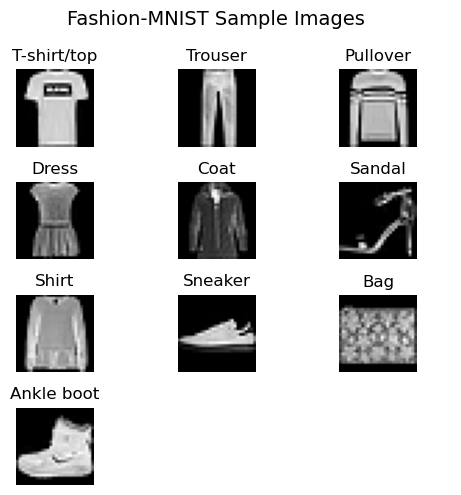

<Figure size 640x480 with 0 Axes>

In [5]:
wandb.init(project=PROJECT, name="Question_1")
sample = []
for id in range(10):
    index = np.where(train_labels == id)[0][0]
    sample.append(train_img[index])

fig, axes = plt.subplots(4, 3, figsize=(5, 5))
fig.suptitle("Fashion-MNIST Sample Images", fontsize=14)

for i, ax in enumerate(axes.flat):
    if i < len(sample):
        ax.imshow(sample[i], cmap='gray')
        ax.set_title(target_classes[i])
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()
wandb.log({"Sample_Images": wandb.Image(plt)})
wandb.finish();

### Activation Functions

In [6]:
class Activation_Functions:
    def __init__(self):
        pass

    def sigmoid(self, x):
        result = np.zeros_like(x)
        result[x >= 0] = 1 / (1 + np.exp(-x[x >= 0]))
        result[x < 0] = np.exp(x[x < 0]) / (1 + np.exp(x[x < 0]))
        return result

    def ReLU(self, x):
        return np.maximum(0, x)

    def tanh(self, x):
        return np.tanh(x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def identity(self, x):
        return x

    def activation(self, x, fun):
        if fun == "tanh":
            return self.tanh(x)
        elif fun == "sigmoid":
            return self.sigmoid(x)
        elif fun == "ReLU":
            return self.ReLU(x)
        elif fun == "softmax":
            return self.softmax(x)
        elif fun == "identity":
            return self.identity(x)


### Loss Functions

In [7]:
class Loss_Function:
    def __init__(self):
        pass

    def compute_loss(self, y_true, y_pred, loss_function="cross_entropy"):
        if loss_function == "cross_entropy":
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  
            return np.mean(-np.sum(y_true * np.log(y_pred), axis=1))
        if loss_function == "mean_squared_error":
            return 0.5 * np.mean(np.sum((y_true - y_pred) ** 2, axis=1))

    def last_output_derivative(self, y_pred, y_true, activation_derivative, loss_function="cross_entropy"):
        if loss_function == "mean_squared_error":
            return (y_pred - y_true) * activation_derivative / len(y_true)
        if loss_function == "cross_entropy":
            return -(y_true - y_pred)


### Derivatioves

In [8]:
class Derivatives:
    def __init__(self):
        self.activation = Activation_Functions()

    def sigmoid_derivative(self, x):
        k = self.activation.sigmoid(x)
        return k * (1 - k)

    def softmax_derivative(self, x):
        k = self.activation.softmax(x)
        return k * (1 - k)

    def tanh_derivative(self, x):
        k = self.activation.tanh(x)
        return 1 - k ** 2

    def ReLU_derivative(self, x):
        x[x > 0] = 1
        x[x <= 0] = 0
        return x

    def identity_derivative(self, x):
        return np.ones_like(x)

    def derivatives(self, x, activation_function):
        if activation_function == "sigmoid":
            return self.sigmoid_derivative(x)
        elif activation_function == "tanh":
            return self.tanh_derivative(x)
        elif activation_function == "ReLU":
            return self.ReLU_derivative(x)
        elif activation_function == "softmax":
            return self.softmax_derivative(x)
        elif activation_function == "identity":
            return self.identity_derivative(x)


## Question 2

In [9]:
def Network_Q2(data, activation, init_method, params):
    weights, biases, activations, outputs = {}, {}, {}, {}
    activation_func = Activation_Functions()
    layer_sizes = [params["input_size"]] + params["hidden_layers"] + [params["output_size"]]
    predicted_probs = []
    
    for layer in range(1, len(layer_sizes)):
        if init_method == "random":
            weights[layer] = np.random.randn(layer_sizes[layer-1], layer_sizes[layer])
            biases[layer] = np.random.randn(1, layer_sizes[layer])
        elif init_method == "Xavier":
            in_dim, out_dim = layer_sizes[layer-1], layer_sizes[layer]
            variance = 2.0 / (in_dim + out_dim)
            weights[layer] = np.random.randn(in_dim, out_dim) * np.sqrt(variance)
            biases[layer] = np.random.randn(1, out_dim) * np.sqrt(variance)
    
    def forward_pass(x):
        num_layers = len(layer_sizes)
        outputs[0] = x
        
        for layer in range(1, num_layers - 1):
            activations[layer] = np.dot(outputs[layer-1], weights[layer]) + biases[layer]
            outputs[layer] = activation_func.activation(activations[layer], fun=activation)
        
        activations[num_layers-1] = np.dot(outputs[layer], weights[num_layers-1]) + biases[num_layers-1]
        outputs[num_layers-1] = activation_func.activation(activations[num_layers-1], fun="softmax")
        
        return outputs[num_layers-1]
    
    for sample in data:
        x = sample.reshape(1, -1) / 255.0
        y_pred = forward_pass(x)
        predicted_probs.append(y_pred)
    
    return predicted_probs


In [10]:
params = {
    "input_size" : 784,           
    "hidden_layers" : [200, 100, 50],  
    "output_size" : 10            
}

y_pred_Q2 = Network_Q2(train_img, "identity", "Xavier", params)  
print(y_pred_Q2[0]) 

[[0.08835926 0.04187589 0.04410094 0.28193964 0.02685161 0.19093032
  0.03856236 0.15142901 0.08029054 0.05566045]]


### Optimizers

In [11]:
import numpy as np

class Optimizer:
    def __init__(self, model, config):
        self.model = model  # Reference to the neural network model
        self.learning_rate = config["eta"]  # Learning rate
        self.decay = config["weight_decay"]  # Weight decay coefficient
        self.method = config["optimizer"]  # Optimization technique
        self.momentum_factor = config["momentum"]  # Momentum parameter
        self.beta1 = config["beta1"]  # First moment coefficient (Adam, Nadam)
        self.beta2 = config["beta2"]  # Second moment coefficient (Adam, Nadam)
        self.epsilon = config["epsilon"]  # Small value to prevent division by zero

    def update_parameters(self, timestep):
        if self.method == "sgd":
            self.stochastic_gradient_descent()
        elif self.method == "momentum":
            self.momentum_gradient_descent()
        elif self.method == "nag":
            self.nesterov_gradient_descent()
        elif self.method == "rmsprop":
            self.rmsprop()
        elif self.method == "adam":
            self.adam(timestep)
        elif self.method == "nadam":
            self.nadam(timestep)

    def stochastic_gradient_descent(self):
        for layer in self.model.weights.keys():
            decay_wt = self.decay * self.model.weights[layer]  # Applying weight decay
            self.model.grad_weights[layer] += decay_wt  # Adding weight decay to gradients
            self.model.weights[layer] -= self.learning_rate * self.model.grad_weights[layer]  # Updating weights
            self.model.biases[layer] -= self.learning_rate * self.model.grad_biases[layer]  # Updating biases
    
    
    def momentum_gradient_descent(self):
        for layer in self.model.weights.keys():
            decay_wt = self.decay * self.model.weights[layer]  # Applying weight decay
            self.model.grad_weights[layer] += decay_wt  # Adding weight decay to gradients
            
            uw = self.momentum_factor * self.model.m_weights[layer] + self.learning_rate * self.model.grad_weights[layer]
            ub = self.momentum_factor * self.model.m_biases[layer] + self.learning_rate * self.model.grad_biases[layer]
            
            self.model.weights[layer] -= uw  # Updating weights
            self.model.biases[layer] -= ub  # Updating biases
            
            self.model.m_weights[layer] = uw  # Storing previous weight update
            self.model.m_biases[layer] = ub  # Storing previous bias update
    
    
    def nesterov_gradient_descent(self):
        for layer in self.model.weights.keys():
            decay_wt = self.decay * self.model.weights[layer]  # Applying weight decay
            self.model.grad_weights[layer] += decay_wt  # Adding weight decay to gradients
            
            self.model.m_weights[layer] = self.momentum_factor * self.model.m_weights[layer] + self.model.grad_weights[layer]
            self.model.m_biases[layer] = self.momentum_factor * self.model.m_biases[layer] + self.model.grad_biases[layer]
            
            self.model.weights[layer] -= self.learning_rate * (self.momentum_factor * self.model.m_weights[layer] + self.model.grad_weights[layer])
            self.model.biases[layer] -= self.learning_rate * (self.momentum_factor * self.model.m_biases[layer] + self.model.grad_biases[layer])
    
    
    def rmsprop(self):
        for layer in self.model.weights.keys():
            decay_wt = self.decay * self.model.weights[layer]  # Applying weight decay
            self.model.grad_weights[layer] += decay_wt  # Adding weight decay to gradients
            
            self.model.v_weights[layer] = self.beta2 * self.model.v_weights[layer] + (1 - self.beta2) * (self.model.grad_weights[layer] ** 2)
            self.model.v_biases[layer] = self.beta2 * self.model.v_biases[layer] + (1 - self.beta2) * (self.model.grad_biases[layer] ** 2)
            
            self.model.weights[layer] -= (self.learning_rate / (np.sqrt(self.model.v_weights[layer]) + self.epsilon)) * self.model.grad_weights[layer]
            self.model.biases[layer] -= (self.learning_rate / (np.sqrt(self.model.v_biases[layer]) + self.epsilon)) * self.model.grad_biases[layer]
    
    
    def adam(self, timestep):
        for layer in self.model.weights.keys():
            decay_wt = self.decay * self.model.weights[layer]  # Applying weight decay
            self.model.grad_weights[layer] += decay_wt  # Adding weight decay to gradients
            
            self.model.m_weights[layer] = self.beta1 * self.model.m_weights[layer] + (1 - self.beta1) * self.model.grad_weights[layer]
            self.model.m_biases[layer] = self.beta1 * self.model.m_biases[layer] + (1 - self.beta1) * self.model.grad_biases[layer]
            
            self.model.v_weights[layer] = self.beta2 * self.model.v_weights[layer] + (1 - self.beta2) * (self.model.grad_weights[layer] ** 2)
            self.model.v_biases[layer] = self.beta2 * self.model.v_biases[layer] + (1 - self.beta2) * (self.model.grad_biases[layer] ** 2)
            
            m_hat_weights = self.model.m_weights[layer] / (1 - self.beta1 ** timestep)
            v_hat_weights = self.model.v_weights[layer] / (1 - self.beta2 ** timestep)
            
            m_hat_biases = self.model.m_biases[layer] / (1 - self.beta1 ** timestep)
            v_hat_biases = self.model.v_biases[layer] / (1 - self.beta2 ** timestep)
            
            self.model.weights[layer] -= (self.learning_rate / (np.sqrt(v_hat_weights) + self.epsilon)) * m_hat_weights
            self.model.biases[layer] -= (self.learning_rate / (np.sqrt(v_hat_biases) + self.epsilon)) * m_hat_biases
    
    
    def nadam(self, timestep):
        for layer in self.model.weights.keys():
            decay_wt = self.decay * self.model.weights[layer]  # Applying weight decay
            self.model.grad_weights[layer] += decay_wt  # Adding weight decay to gradients
            
            self.model.m_weights[layer] = self.beta1 * self.model.m_weights[layer] + (1 - self.beta1) * self.model.grad_weights[layer]
            self.model.m_biases[layer] = self.beta1 * self.model.m_biases[layer] + (1 - self.beta1) * self.model.grad_biases[layer]
            
            self.model.v_weights[layer] = self.beta2 * self.model.v_weights[layer] + (1 - self.beta2) * (self.model.grad_weights[layer] ** 2)
            self.model.v_biases[layer] = self.beta2 * self.model.v_biases[layer] + (1 - self.beta2) * (self.model.grad_biases[layer] ** 2)
            
            m_hat_weights = self.model.m_weights[layer] / (1 - self.beta1 ** timestep)
            v_hat_weights = self.model.v_weights[layer] / (1 - self.beta2 ** timestep)
            
            m_hat_biases = self.model.m_biases[layer] / (1 - self.beta1 ** timestep)
            v_hat_biases = self.model.v_biases[layer] / (1 - self.beta2 ** timestep)
            
            self.model.weights[layer] -= (self.learning_rate / (np.sqrt(v_hat_weights) + self.epsilon)) * (self.beta1 * m_hat_weights + ((1 - self.beta1) * self.model.grad_weights[layer]) / (1 - self.beta1 ** timestep))
            self.model.biases[layer] -= (self.learning_rate / (np.sqrt(v_hat_biases) + self.epsilon)) * (self.beta1 * m_hat_biases + ((1 - self.beta1) * self.model.grad_biases[layer]) / (1 - self.beta1 ** timestep))


### Final Neural Network Functionalities

In [12]:
class Neural_Network:
    def __init__(self, params, log=1, console=1):
        self.weights, self.biases, self.a, self.h = {}, {}, {}, {}
        self.grad_weights, self.grad_biases, self.m_weights, self.m_biases = {}, {}, {}, {}
        self.v_weights, self.v_biases = {}, {}

        self.activation_function = params["activation_function"]
        self.loss_function = params["loss_function"]
        self.initialization = params["init"]
        self.hidden_layers = params["hidden_layers"]
        self.hidden_layer_sizes = params["hidden_layer_sizes"]
        self.dataset = params["dataset"]
        self.wan_log, self.console_log = log, console
        self.loss = Loss_Function()
        self.act = Activation_Functions()
        self.derivative = Derivatives()

        (train_img, train_lbl), (test_img, test_lbl) = self.load_dataset()
        train_img, val_img, train_lbl, val_lbl = train_test_split(train_img, train_lbl, test_size=0.1, random_state=41)

        self.input, self.y_true = self.preprocess_data(train_img, train_lbl)
        self.val_img, self.val_true = self.preprocess_data(val_img, val_lbl)
        self.test_img, self.test_true = self.preprocess_data(test_img, test_lbl)
        self.layers = [self.input.shape[1]] + [self.hidden_layer_sizes] * self.hidden_layers + [10]
        
        self.initialize_parameters()

    def load_dataset(self):
        if self.dataset == 'fashion_mnist':
            return (train_img, train_labels), (test_img, test_labels)
        else:
            raise ValueError("Unknown dataset")

    def preprocess_data(self, images, labels):
        return images.reshape(images.shape[0], -1) / 255.0 , labels

    def initialize_parameters(self):
        for layer in range(1, len(self.layers)):
            self.m_weights[layer] = np.zeros((self.layers[layer-1], self.layers[layer]))
            self.m_biases[layer] = np.zeros((1, self.layers[layer]))
            self.v_weights[layer] = np.zeros((self.layers[layer-1], self.layers[layer]))
            self.v_biases[layer] = np.zeros((1, self.layers[layer]))

            if self.initialization == "random":
                self.weights[layer] = np.random.randn(self.layers[layer-1], self.layers[layer])
                self.biases[layer] = np.random.randn(1, self.layers[layer])
            elif self.initialization == "Xavier":
                variance_w = 6.0 / (self.layers[layer-1] + self.layers[layer])
                variance_b = 6.0 / (1 + self.layers[layer])
                self.weights[layer] = np.random.randn(self.layers[layer-1], self.layers[layer]) * np.sqrt(variance_w)
                self.biases[layer] = np.random.randn(1, self.layers[layer]) * np.sqrt(variance_b)

    def forward_propagation(self, x):
        self.h[0] = x
        for layer in range(1, len(self.layers)-1):
            self.a[layer] = np.dot(self.h[layer-1], self.weights[layer]) + self.biases[layer]
            self.h[layer] = self.act.activation(self.a[layer], self.activation_function)
        self.a[layer+1] = np.dot(self.h[layer], self.weights[layer+1]) + self.biases[layer+1]
        self.h[layer+1] = self.act.activation(self.a[layer+1], "softmax")
        return self.h[layer+1]

    def backward_propagation(self, x, y_true, y_hat):
        activation_derivative = self.derivative.derivatives(self.a[len(self.layers) - 1], "softmax")
        error_wrt_output = self.loss.last_output_derivative(y_hat, y_true, activation_derivative, self.loss_function)

        for layer in range(len(self.layers)-1, 1, -1):
            self.grad_weights[layer] = np.dot(self.h[layer-1].T, error_wrt_output)
            self.grad_biases[layer] = np.sum(error_wrt_output, axis=0, keepdims=True)
            error_wrt_hidden = np.dot(error_wrt_output, self.weights[layer].T)
            error_wrt_output = error_wrt_hidden * self.derivative.derivatives(self.a[layer-1], self.activation_function)

        self.grad_weights[1] = np.dot(x.T, error_wrt_output)
        self.grad_biases[1] = np.sum(error_wrt_output, axis=0, keepdims=True)

    def one_hot_matrix(self, labels):
        mat = np.zeros((labels.shape[0], 10))
        mat[np.arange(labels.shape[0]), labels] = 1
        return mat

    def compute_performance(self, data, labels):
        y_pred = self.forward_propagation(data)
        one_hot_labels = self.one_hot_matrix(labels)
        accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(one_hot_labels, axis=1)) * 100
        loss = self.loss.compute_loss(one_hot_labels, y_pred, self.loss_function)
        return loss, accuracy

    
    def probability(self, data):
        return self.forward_propagation(data)

        
    def fit(self, batch_size, epochs, optimizer):
        total_batches = int(np.ceil(self.input.shape[0] / batch_size))
        for epoch in range(epochs):
            t = 1
            for batch in range(total_batches):
                batch_start, batch_end = batch * batch_size, (batch + 1) * batch_size
                image_set, label_set = self.input[batch_start:batch_end], self.y_true[batch_start:batch_end]
                y_hat = self.forward_propagation(image_set)
                self.backward_propagation(image_set, self.one_hot_matrix(label_set), y_hat)
                for layer in range(1, len(self.layers)):
                    self.grad_weights[layer] /= batch_size
                    self.grad_biases[layer] /= batch_size
                optimizer.update_parameters(t)
                t += 1
            
            t_loss, t_acc = self.compute_performance(self.input, self.y_true)
            v_loss, v_acc = self.compute_performance(self.val_img, self.val_true)
            
            if self.wan_log:
                wandb.log({'epoch': epoch + 1, 'train_loss': t_loss, 'train_acc': t_acc, 'val_loss': v_loss, 'val_acc': v_acc})
            if self.console_log:
                print(f"Epoch {epoch+1}: Train Loss={t_loss:.4f}, Train Acc={t_acc:.2f}%, Val Loss={v_loss:.4f}, Val Acc={v_acc:.2f}%")
        
        return t_loss, t_acc, v_loss, v_acc


## Question 3

In [13]:
param_nn = {
    "hidden_layers": 4,
    "hidden_layer_sizes": 128,
    "activation_function": "sigmoid",  # Options: sigmoid, tanh, ReLU
    "dataset": "fashion_mnist",
    "loss_function": "cross_entropy",  # Options: mean_squared_error, cross_entropy
    "init": "random"  # Options: random, Xavier
}

param_opt = {
    "eta": 0.0005,
    "optimizer": "adam",  # Options: sgd, momentum, adam, nadam, rmsprop, nag
    "beta": 0.9,
    "weight_decay": 0.0005,
    "epsilon": 1e-8,
    "beta2": 0.999,
    "beta1": 0.9,
    "momentum": 0.9
}

neural_network = Neural_Network(param_nn, log=0, console=1)
optimizer = Optimizer(neural_network, param_opt)

train_model = neural_network.fit(batch_size=64, epochs=5, optimizer=optimizer)


Epoch 1: Train Loss=0.7223, Train Acc=73.71%, Val Loss=0.7443, Val Acc=73.05%
Epoch 2: Train Loss=0.6102, Train Acc=77.81%, Val Loss=0.6372, Val Acc=77.25%
Epoch 3: Train Loss=0.5496, Train Acc=79.94%, Val Loss=0.5769, Val Acc=78.87%
Epoch 4: Train Loss=0.5084, Train Acc=81.50%, Val Loss=0.5382, Val Acc=80.75%
Epoch 5: Train Loss=0.4784, Train Acc=82.54%, Val Loss=0.5102, Val Acc=81.65%


## Question 4

In [14]:
sweep_config = {
    "method": "bayes",  
    "project": f"{PROJECT}",
    "metric": {"name": "test_accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "hidden_layer_sizes": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "activation": {"values": ["sigmoid", "tanh", "ReLU"]},
        "initialization": {"values": ["Xavier", "random"]},
        "dataset": {"values": ["fashion_mnist"]}
    }
}


def train(loss_function):
    var1 = wandb.init(project=PROJECT)
    var2 = var1.config

    # wandb.run.name = 'Optimizer:- ' + var2.optimizer + ' Epoch:- ' + str(var2.epochs) + " Avtivation_Function :- " + var2.activation + " Batch_Size :- " + str(var2.batch_size) + " Initialization :- " + var2.initialization + \
    #                 ' layers:-' + str(len(var2.hidden_layers)) +' decay:-' + str(var2.weight_decay) + ' beta:-' + str(var2.beta) + ' learning_rate:-' + str(var2.learning_rate) + \
    #                 ' beta2 :- ' + str(var2.beta)

    wandb.run.name = f"opt_{var2.optimizer}_hl_{var2.hidden_layers}_bs_{var2.batch_size}_e_{var2.epochs}_act_{var2.activation}_eta_{var2.learning_rate}_init_{var2.initialization}_hls_{var2.hidden_layer_sizes}_dataset_{var2.dataset}_{loss_function}"

    param_nn = {
        "hidden_layers": var2.hidden_layers,
        "hidden_layer_sizes" : var2.hidden_layer_sizes,
        "activation_function": var2.activation, # sigmoid, tanh, ReLU
        "loss_function" : loss_function, # mean_squared_error, cross_entropy
        "init" : var2.initialization, #random, xavier
        "dataset" : var2.dataset
    }

    param_opt = {
        "eta": var2.learning_rate,
        "optimizer": var2.optimizer, #sgd, momentum, adam, nadam, rmsprop, nag
        "beta": 0.9,
        "weight_decay": var2.weight_decay,
        "epsilon": 1e-8,
        "beta2" : 0.999,
        "beta1" : 0.9,
        "momentum" : 0.9
    }

    nn = Neural_Network(param_nn,log = 1,console=1)
    opt = Optimizer(nn, param_opt)

    t_loss, t_acc, v_loss, v_acc = nn.fit(batch_size=var2.batch_size, epochs=var2.epochs, optimizer=opt)

    loss, accuracy = nn.compute_performance(nn.test_img, nn.test_true)
    print(f"Test-loss: {loss}, Test-accuracy: {accuracy}%")    # Printing loss and accuracy for Test 
    #print(loss, accuracy)
    wandb.log({"test_accuracy" : accuracy})

In [15]:
sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: qksfum4h
Sweep URL: https://wandb.ai/cs24m021-iit-madras/DA6401_Assignment1/sweeps/qksfum4h


In [16]:
wandb.agent(sweep_id,  lambda : train(loss_function = "cross_entropy"), count = 250)
wandb.finish()

wandb: Agent Starting Run: zisadpvv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=3.3111, Train Acc=4.03%, Val Loss=3.3481, Val Acc=3.53%
Epoch 2: Train Loss=3.3111, Train Acc=4.03%, Val Loss=3.3481, Val Acc=3.53%
Epoch 3: Train Loss=3.3111, Train Acc=4.03%, Val Loss=3.3481, Val Acc=3.53%
Epoch 4: Train Loss=3.3111, Train Acc=4.03%, Val Loss=3.3481, Val Acc=3.53%
Epoch 5: Train Loss=3.3111, Train Acc=4.03%, Val Loss=3.3481, Val Acc=3.53%
Epoch 6: Train Loss=3.3111, Train Acc=4.03%, Val Loss=3.3481, Val Acc=3.53%
Epoch 7: Train Loss=3.3111, Train Acc=4.03%, Val Loss=3.3481, Val Acc=3.53%
Epoch 8: Train Loss=3.3111, Train Acc=4.03%, Val Loss=3.3481, Val Acc=3.53%
Epoch 9: Train Loss=3.3111, Train Acc=4.03%, Val Loss=3.3481, Val Acc=3.53%
Epoch 10: Train Loss=3.3111, Train Acc=4.03%, Val Loss=3.3481, Val Acc=3.53%
Test-loss : 3.308312368270921, Test-accuracy:4.01%
3.308312368270921 4.01


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,4.01
train_acc,4.03148
train_loss,3.31112
val_acc,3.53333


wandb: Agent Starting Run: aahkr1z1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1: Train Loss=3.4123, Train Acc=12.54%, Val Loss=3.3746, Val Acc=13.17%
Epoch 2: Train Loss=3.4123, Train Acc=12.54%, Val Loss=3.3746, Val Acc=13.17%
Epoch 3: Train Loss=3.4123, Train Acc=12.54%, Val Loss=3.3746, Val Acc=13.17%
Epoch 4: Train Loss=3.4123, Train Acc=12.54%, Val Loss=3.3746, Val Acc=13.17%
Epoch 5: Train Loss=3.4123, Train Acc=12.54%, Val Loss=3.3746, Val Acc=13.17%
Epoch 6: Train Loss=3.4123, Train Acc=12.54%, Val Loss=3.3746, Val Acc=13.17%
Epoch 7: Train Loss=3.4123, Train Acc=12.54%, Val Loss=3.3746, Val Acc=13.17%
Epoch 8: Train Loss=3.4123, Train Acc=12.54%, Val Loss=3.3746, Val Acc=13.17%
Epoch 9: Train Loss=3.4123, Train Acc=12.54%, Val Loss=3.3746, Val Acc=13.17%
Epoch 10: Train Loss=3.4123, Train Acc=12.54%, Val Loss=3.3746, Val Acc=13.17%
Test-loss : 3.4143101970902645, Test-accuracy:11.86%
3.4143101970902645 11.86


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,11.86
train_acc,12.54259
train_loss,3.41231
val_acc,13.16667


wandb: Agent Starting Run: xktn3p4j with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=9.2938, Train Acc=73.04%, Val Loss=9.6601, Val Acc=71.97%
Epoch 2: Train Loss=8.8717, Train Acc=74.20%, Val Loss=9.3172, Val Acc=72.93%
Epoch 3: Train Loss=8.9561, Train Acc=73.86%, Val Loss=9.4975, Val Acc=72.30%
Epoch 4: Train Loss=8.0571, Train Acc=76.31%, Val Loss=8.7782, Val Acc=74.20%
Epoch 5: Train Loss=7.5410, Train Acc=77.47%, Val Loss=8.1149, Val Acc=75.77%
Epoch 6: Train Loss=6.7949, Train Acc=78.86%, Val Loss=7.3176, Val Acc=77.27%
Epoch 7: Train Loss=7.3656, Train Acc=76.78%, Val Loss=7.9477, Val Acc=74.90%
Epoch 8: Train Loss=7.0297, Train Acc=76.60%, Val Loss=7.7005, Val Acc=74.70%
Epoch 9: Train Loss=6.5529, Train Acc=75.71%, Val Loss=7.2020, Val Acc=73.65%
Epoch 10: Train Loss=7.2186, Train Acc=71.86%, Val Loss=7.6493, Val Acc=70.63%
Test-loss : 7.857539156866245, Test-accuracy:70.19%
7.857539156866245 70.19


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▂▃▃▅▇█▆▆▅▁
train_loss,█▇▇▅▄▂▃▂▁▃
val_acc,▂▃▃▅▆█▆▅▄▁
val_loss,█▇█▅▄▁▃▂▁▂
epoch,10
test_accuracy,70.19
train_acc,71.85556
train_loss,7.21857
val_acc,70.63333


wandb: Agent Starting Run: 0vrxkog3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=1.1814, Train Acc=64.02%, Val Loss=1.1877, Val Acc=62.88%
Epoch 2: Train Loss=2.3016, Train Acc=9.99%, Val Loss=2.2998, Val Acc=10.12%
Epoch 3: Train Loss=2.3046, Train Acc=9.99%, Val Loss=2.3030, Val Acc=10.12%
Epoch 4: Train Loss=2.3044, Train Acc=9.99%, Val Loss=2.3030, Val Acc=10.12%
Epoch 5: Train Loss=2.3044, Train Acc=9.99%, Val Loss=2.3029, Val Acc=10.12%
Epoch 6: Train Loss=2.3043, Train Acc=9.99%, Val Loss=2.3029, Val Acc=10.12%
Epoch 7: Train Loss=2.3043, Train Acc=9.99%, Val Loss=2.3029, Val Acc=10.12%
Epoch 8: Train Loss=2.3042, Train Acc=9.99%, Val Loss=2.3029, Val Acc=10.12%
Epoch 9: Train Loss=2.3041, Train Acc=9.99%, Val Loss=2.3028, Val Acc=10.12%
Epoch 10: Train Loss=2.3041, Train Acc=9.99%, Val Loss=2.3028, Val Acc=10.12%
Test-loss : 2.3039596430761673, Test-accuracy:10.0%
2.3039596430761673 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,█▁▁▁▁▁▁▁▁▁
train_loss,▁█████████
val_acc,█▁▁▁▁▁▁▁▁▁
val_loss,▁█████████
epoch,10
test_accuracy,10
train_acc,9.98704
train_loss,2.30409
val_acc,10.11667


wandb: Agent Starting Run: r8bj38sa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=1.9583, Train Acc=32.60%, Val Loss=1.9532, Val Acc=33.33%
Epoch 2: Train Loss=2.3133, Train Acc=9.98%, Val Loss=2.3099, Val Acc=10.15%
Epoch 3: Train Loss=2.3108, Train Acc=9.98%, Val Loss=2.3077, Val Acc=10.15%
Epoch 4: Train Loss=2.3072, Train Acc=9.91%, Val Loss=2.3048, Val Acc=10.80%
Epoch 5: Train Loss=2.3048, Train Acc=9.91%, Val Loss=2.3032, Val Acc=10.80%
Epoch 6: Train Loss=2.3035, Train Acc=9.99%, Val Loss=2.3026, Val Acc=10.12%
Epoch 7: Train Loss=2.3029, Train Acc=9.99%, Val Loss=2.3025, Val Acc=10.12%
Epoch 8: Train Loss=2.3028, Train Acc=9.99%, Val Loss=2.3026, Val Acc=10.12%
Epoch 9: Train Loss=2.3027, Train Acc=9.99%, Val Loss=2.3026, Val Acc=10.12%
Epoch 10: Train Loss=2.3027, Train Acc=9.99%, Val Loss=2.3027, Val Acc=10.12%
Test-loss : 2.302652004229019, Test-accuracy:10.0%
2.302652004229019 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,█▁▁▁▁▁▁▁▁▁
train_loss,▁█████████
val_acc,█▁▁▁▁▁▁▁▁▁
val_loss,▁█████████
epoch,10
test_accuracy,10
train_acc,9.98704
train_loss,2.30265
val_acc,10.11667


wandb: Agent Starting Run: qpnj28ly with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=2.3068, Train Acc=9.99%, Val Loss=2.3046, Val Acc=10.12%
Epoch 2: Train Loss=2.3044, Train Acc=9.99%, Val Loss=2.3029, Val Acc=10.12%
Epoch 3: Train Loss=2.3038, Train Acc=9.99%, Val Loss=2.3027, Val Acc=10.12%
Epoch 4: Train Loss=2.3036, Train Acc=9.99%, Val Loss=2.3026, Val Acc=10.12%
Epoch 5: Train Loss=2.3035, Train Acc=9.99%, Val Loss=2.3026, Val Acc=10.12%
Epoch 6: Train Loss=2.3034, Train Acc=9.99%, Val Loss=2.3026, Val Acc=10.12%
Epoch 7: Train Loss=2.3033, Train Acc=9.99%, Val Loss=2.3026, Val Acc=10.12%
Epoch 8: Train Loss=2.3032, Train Acc=9.99%, Val Loss=2.3025, Val Acc=10.12%
Epoch 9: Train Loss=2.3031, Train Acc=9.99%, Val Loss=2.3025, Val Acc=10.12%
Epoch 10: Train Loss=2.3030, Train Acc=9.99%, Val Loss=2.3025, Val Acc=10.12%
Test-loss : 2.302953275469074, Test-accuracy:10.0%
2.302953275469074 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▂▂▂▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98704
train_loss,2.303
val_acc,10.11667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n3r21s28 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6936, Train Acc=76.68%, Val Loss=0.7147, Val Acc=76.02%
Epoch 2: Train Loss=0.5818, Train Acc=79.96%, Val Loss=0.6011, Val Acc=79.37%
Epoch 3: Train Loss=0.5292, Train Acc=81.62%, Val Loss=0.5492, Val Acc=81.00%
Epoch 4: Train Loss=0.4968, Train Acc=82.67%, Val Loss=0.5177, Val Acc=81.63%
Epoch 5: Train Loss=0.4711, Train Acc=83.53%, Val Loss=0.4919, Val Acc=82.47%
Test-loss : 0.5077077837316082, Test-accuracy:82.39%
0.5077077837316082 82.39


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▄▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,82.39
train_acc,83.52593
train_loss,0.47109
val_acc,82.46667


wandb: Agent Starting Run: 9jg1lwc8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.3732, Train Acc=86.42%, Val Loss=0.3782, Val Acc=86.15%
Epoch 2: Train Loss=0.3446, Train Acc=87.38%, Val Loss=0.3570, Val Acc=87.03%
Epoch 3: Train Loss=0.3258, Train Acc=88.00%, Val Loss=0.3441, Val Acc=87.37%
Epoch 4: Train Loss=0.3123, Train Acc=88.49%, Val Loss=0.3353, Val Acc=87.70%
Epoch 5: Train Loss=0.3015, Train Acc=88.88%, Val Loss=0.3291, Val Acc=87.75%
Epoch 6: Train Loss=0.2932, Train Acc=89.14%, Val Loss=0.3254, Val Acc=88.07%
Epoch 7: Train Loss=0.2866, Train Acc=89.35%, Val Loss=0.3231, Val Acc=88.25%
Epoch 8: Train Loss=0.2807, Train Acc=89.56%, Val Loss=0.3214, Val Acc=88.18%
Epoch 9: Train Loss=0.2754, Train Acc=89.71%, Val Loss=0.3201, Val Acc=88.23%
Epoch 10: Train Loss=0.2707, Train Acc=89.88%, Val Loss=0.3192, Val Acc=88.23%
Test-loss : 0.3672849347494942, Test-accuracy:87.28%
0.3672849347494942 87.28


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▆▇████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,87.28
train_acc,89.88148
train_loss,0.27071
val_acc,88.23333


wandb: Agent Starting Run: vrlvcyy1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=3.1540, Train Acc=10.02%, Val Loss=3.1594, Val Acc=9.80%
Epoch 2: Train Loss=3.1540, Train Acc=10.02%, Val Loss=3.1594, Val Acc=9.80%
Epoch 3: Train Loss=3.1540, Train Acc=10.02%, Val Loss=3.1594, Val Acc=9.80%
Epoch 4: Train Loss=3.1540, Train Acc=10.02%, Val Loss=3.1594, Val Acc=9.80%
Epoch 5: Train Loss=3.1540, Train Acc=10.02%, Val Loss=3.1594, Val Acc=9.80%
Epoch 6: Train Loss=3.1540, Train Acc=10.02%, Val Loss=3.1594, Val Acc=9.80%
Epoch 7: Train Loss=3.1540, Train Acc=10.02%, Val Loss=3.1594, Val Acc=9.80%
Epoch 8: Train Loss=3.1540, Train Acc=10.02%, Val Loss=3.1594, Val Acc=9.80%
Epoch 9: Train Loss=3.1540, Train Acc=10.02%, Val Loss=3.1594, Val Acc=9.80%
Epoch 10: Train Loss=3.1540, Train Acc=10.02%, Val Loss=3.1594, Val Acc=9.80%
Test-loss : 3.1538936682546876, Test-accuracy:10.0%
3.1538936682546876 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,10.02222
train_loss,3.15396
val_acc,9.8


wandb: Agent Starting Run: ufi6p2fe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1: Train Loss=2.6782, Train Acc=9.97%, Val Loss=2.6489, Val Acc=10.30%
Epoch 2: Train Loss=2.6782, Train Acc=9.97%, Val Loss=2.6489, Val Acc=10.30%
Epoch 3: Train Loss=2.6782, Train Acc=9.97%, Val Loss=2.6489, Val Acc=10.30%
Epoch 4: Train Loss=2.6782, Train Acc=9.97%, Val Loss=2.6489, Val Acc=10.30%
Epoch 5: Train Loss=2.6782, Train Acc=9.97%, Val Loss=2.6489, Val Acc=10.30%
Test-loss : 2.674942626259284, Test-accuracy:10.0%
2.674942626259284 10.0


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_acc,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
test_accuracy,10
train_acc,9.96667
train_loss,2.67815
val_acc,10.3


wandb: Agent Starting Run: w4di6mdq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=3.3476, Train Acc=10.05%, Val Loss=3.3782, Val Acc=9.58%
Epoch 2: Train Loss=3.3476, Train Acc=10.05%, Val Loss=3.3782, Val Acc=9.58%
Epoch 3: Train Loss=3.3476, Train Acc=10.05%, Val Loss=3.3782, Val Acc=9.58%
Epoch 4: Train Loss=3.3476, Train Acc=10.05%, Val Loss=3.3782, Val Acc=9.58%
Epoch 5: Train Loss=3.3476, Train Acc=10.05%, Val Loss=3.3782, Val Acc=9.58%
Test-loss : 3.3505596446667587, Test-accuracy:10.0%
3.3505596446667587 10.0


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_acc,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
test_accuracy,10
train_acc,10.0463
train_loss,3.34757
val_acc,9.58333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 42boxzct with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=11.2459, Train Acc=66.35%, Val Loss=11.4509, Val Acc=65.57%
Epoch 2: Train Loss=10.1587, Train Acc=68.25%, Val Loss=10.3768, Val Acc=67.73%
Epoch 3: Train Loss=9.6489, Train Acc=68.37%, Val Loss=9.8090, Val Acc=67.67%
Epoch 4: Train Loss=9.1057, Train Acc=68.36%, Val Loss=9.3368, Val Acc=67.95%
Epoch 5: Train Loss=7.9738, Train Acc=68.98%, Val Loss=8.1969, Val Acc=68.25%
Epoch 6: Train Loss=7.0695, Train Acc=68.82%, Val Loss=7.3252, Val Acc=67.87%
Epoch 7: Train Loss=6.2721, Train Acc=67.97%, Val Loss=6.4411, Val Acc=67.27%
Epoch 8: Train Loss=4.6166, Train Acc=68.56%, Val Loss=4.8238, Val Acc=67.65%
Epoch 9: Train Loss=4.0126, Train Acc=68.12%, Val Loss=4.2286, Val Acc=66.88%
Epoch 10: Train Loss=3.1598, Train Acc=68.47%, Val Loss=3.3830, Val Acc=67.10%
Test-loss : 3.4387017702096214, Test-accuracy:67.47%
3.4387017702096214 67.47


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▆▆▆██▅▇▆▇
train_loss,█▇▇▆▅▄▄▂▂▁
val_acc,▁▇▆▇█▇▅▆▄▅
val_loss,█▇▇▆▅▄▄▂▂▁
epoch,10
test_accuracy,67.47
train_acc,68.47222
train_loss,3.15977
val_acc,67.1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wus06pwi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4252, Train Acc=84.75%, Val Loss=0.4344, Val Acc=84.18%
Epoch 2: Train Loss=0.3788, Train Acc=86.42%, Val Loss=0.3934, Val Acc=85.70%
Epoch 3: Train Loss=0.3530, Train Acc=87.37%, Val Loss=0.3715, Val Acc=86.52%
Epoch 4: Train Loss=0.3347, Train Acc=88.10%, Val Loss=0.3568, Val Acc=86.87%
Epoch 5: Train Loss=0.3203, Train Acc=88.64%, Val Loss=0.3459, Val Acc=87.43%
Epoch 6: Train Loss=0.3082, Train Acc=89.03%, Val Loss=0.3374, Val Acc=87.70%
Epoch 7: Train Loss=0.2979, Train Acc=89.38%, Val Loss=0.3306, Val Acc=87.92%
Epoch 8: Train Loss=0.2889, Train Acc=89.68%, Val Loss=0.3253, Val Acc=88.13%
Epoch 9: Train Loss=0.2809, Train Acc=89.99%, Val Loss=0.3210, Val Acc=88.35%
Epoch 10: Train Loss=0.2738, Train Acc=90.20%, Val Loss=0.3175, Val Acc=88.47%
Test-loss : 0.3563130831060314, Test-accuracy:87.63%
0.3563130831060314 87.63


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▅▆▇▇▇██
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,87.63
train_acc,90.20185
train_loss,0.2738
val_acc,88.46667


wandb: Agent Starting Run: f3zs3v6u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=2.2779, Train Acc=17.81%, Val Loss=2.2902, Val Acc=16.92%
Epoch 2: Train Loss=2.1225, Train Acc=23.43%, Val Loss=2.1314, Val Acc=22.67%
Epoch 3: Train Loss=2.2564, Train Acc=13.86%, Val Loss=2.2611, Val Acc=13.65%
Epoch 4: Train Loss=2.3030, Train Acc=12.76%, Val Loss=2.3045, Val Acc=12.12%
Epoch 5: Train Loss=2.3099, Train Acc=9.97%, Val Loss=2.3101, Val Acc=10.32%
Test-loss : 2.3099083887114076, Test-accuracy:10.0%
2.3099083887114076 10.0


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▅█▃▂▁
train_loss,▇▁▆██
val_acc,▅█▃▂▁
val_loss,▇▁▆██
epoch,5
test_accuracy,10
train_acc,9.96667
train_loss,2.30987
val_acc,10.31667


wandb: Agent Starting Run: 2frvbqjz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=7.7664, Train Acc=16.21%, Val Loss=7.7968, Val Acc=15.72%
Epoch 2: Train Loss=6.0859, Train Acc=19.21%, Val Loss=6.1498, Val Acc=18.85%
Epoch 3: Train Loss=4.8795, Train Acc=22.50%, Val Loss=4.9968, Val Acc=21.40%
Epoch 4: Train Loss=4.0109, Train Acc=25.53%, Val Loss=4.0901, Val Acc=24.57%
Epoch 5: Train Loss=3.3241, Train Acc=28.84%, Val Loss=3.3710, Val Acc=28.12%
Epoch 6: Train Loss=2.8005, Train Acc=32.04%, Val Loss=2.8289, Val Acc=31.53%
Epoch 7: Train Loss=2.4195, Train Acc=34.96%, Val Loss=2.4275, Val Acc=34.13%
Epoch 8: Train Loss=2.1065, Train Acc=38.93%, Val Loss=2.0704, Val Acc=39.70%
Epoch 9: Train Loss=1.8735, Train Acc=42.41%, Val Loss=1.8454, Val Acc=43.08%
Epoch 10: Train Loss=1.6980, Train Acc=45.35%, Val Loss=1.6767, Val Acc=45.35%
Test-loss : 1.692856123298463, Test-accuracy:45.62%
1.692856123298463 45.62


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▄▃▂▂▁▁▁
val_acc,▁▂▂▃▄▅▅▇▇█
val_loss,█▆▅▄▃▂▂▁▁▁
epoch,10
test_accuracy,45.62
train_acc,45.3463
train_loss,1.69798
val_acc,45.35


wandb: Agent Starting Run: 1vykcio2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.3988, Train Acc=85.41%, Val Loss=0.4113, Val Acc=84.82%
Epoch 2: Train Loss=0.3515, Train Acc=87.14%, Val Loss=0.3741, Val Acc=86.23%
Epoch 3: Train Loss=0.3248, Train Acc=88.13%, Val Loss=0.3554, Val Acc=87.10%
Epoch 4: Train Loss=0.3062, Train Acc=88.81%, Val Loss=0.3434, Val Acc=87.58%
Epoch 5: Train Loss=0.2919, Train Acc=89.31%, Val Loss=0.3347, Val Acc=87.73%
Epoch 6: Train Loss=0.2804, Train Acc=89.70%, Val Loss=0.3281, Val Acc=87.80%
Epoch 7: Train Loss=0.2707, Train Acc=90.05%, Val Loss=0.3228, Val Acc=87.98%
Epoch 8: Train Loss=0.2624, Train Acc=90.42%, Val Loss=0.3185, Val Acc=88.18%
Epoch 9: Train Loss=0.2551, Train Acc=90.64%, Val Loss=0.3150, Val Acc=88.27%
Epoch 10: Train Loss=0.2487, Train Acc=90.88%, Val Loss=0.3123, Val Acc=88.30%
Test-loss : 0.3496051997228094, Test-accuracy:87.62%
0.3496051997228094 87.62


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▄▆▇▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,87.62
train_acc,90.88333
train_loss,0.24872
val_acc,88.3


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pqbpvgio with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=1.3474, Train Acc=61.95%, Val Loss=1.3527, Val Acc=61.50%
Epoch 2: Train Loss=1.3207, Train Acc=66.73%, Val Loss=1.3279, Val Acc=65.93%
Epoch 3: Train Loss=1.4100, Train Acc=67.03%, Val Loss=1.4176, Val Acc=66.23%
Epoch 4: Train Loss=1.5339, Train Acc=65.44%, Val Loss=1.5408, Val Acc=64.67%
Epoch 5: Train Loss=1.6625, Train Acc=62.16%, Val Loss=1.6681, Val Acc=61.55%
Test-loss : 1.6672096925859856, Test-accuracy:61.370000000000005%
1.6672096925859856 61.370000000000005


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁██▆▁
train_loss,▂▁▃▅█
val_acc,▁██▆▁
val_loss,▂▁▃▅█
epoch,5
test_accuracy,61.37
train_acc,62.16481
train_loss,1.66253
val_acc,61.55


wandb: Agent Starting Run: 5qixfhxb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1: Train Loss=2.9842, Train Acc=10.48%, Val Loss=2.9806, Val Acc=10.33%
Epoch 2: Train Loss=2.9842, Train Acc=10.48%, Val Loss=2.9806, Val Acc=10.33%
Epoch 3: Train Loss=2.9842, Train Acc=10.48%, Val Loss=2.9806, Val Acc=10.33%
Epoch 4: Train Loss=2.9842, Train Acc=10.48%, Val Loss=2.9806, Val Acc=10.33%
Epoch 5: Train Loss=2.9842, Train Acc=10.48%, Val Loss=2.9806, Val Acc=10.33%
Epoch 6: Train Loss=2.9842, Train Acc=10.48%, Val Loss=2.9806, Val Acc=10.33%
Epoch 7: Train Loss=2.9842, Train Acc=10.48%, Val Loss=2.9806, Val Acc=10.33%
Epoch 8: Train Loss=2.9842, Train Acc=10.48%, Val Loss=2.9806, Val Acc=10.33%
Epoch 9: Train Loss=2.9842, Train Acc=10.48%, Val Loss=2.9806, Val Acc=10.33%
Epoch 10: Train Loss=2.9842, Train Acc=10.48%, Val Loss=2.9806, Val Acc=10.33%
Test-loss : 2.983720554803292, Test-accuracy:10.59%
2.983720554803292 10.59


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,10.59
train_acc,10.48333
train_loss,2.98419
val_acc,10.33333


wandb: Agent Starting Run: 4ztojizu with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4420, Train Acc=84.24%, Val Loss=0.4501, Val Acc=83.68%
Epoch 2: Train Loss=0.3911, Train Acc=85.75%, Val Loss=0.4040, Val Acc=84.88%
Epoch 3: Train Loss=0.3597, Train Acc=86.86%, Val Loss=0.3839, Val Acc=86.25%
Epoch 4: Train Loss=0.3397, Train Acc=87.57%, Val Loss=0.3683, Val Acc=86.70%
Epoch 5: Train Loss=0.3262, Train Acc=88.02%, Val Loss=0.3590, Val Acc=86.98%
Test-loss : 0.39304677436317415, Test-accuracy:86.03%
0.39304677436317415 86.03


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,86.03
train_acc,88.02222
train_loss,0.32623
val_acc,86.98333


wandb: Agent Starting Run: u25ptue7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=2.1814, Train Acc=21.86%, Val Loss=2.1830, Val Acc=21.10%
Epoch 2: Train Loss=1.8839, Train Acc=51.47%, Val Loss=1.8909, Val Acc=51.13%
Epoch 3: Train Loss=1.5681, Train Acc=60.43%, Val Loss=1.5749, Val Acc=59.70%
Epoch 4: Train Loss=1.3132, Train Acc=67.06%, Val Loss=1.3226, Val Acc=66.25%
Epoch 5: Train Loss=1.0773, Train Acc=71.60%, Val Loss=1.0896, Val Acc=70.55%
Epoch 6: Train Loss=0.8925, Train Acc=74.54%, Val Loss=0.9055, Val Acc=73.38%
Epoch 7: Train Loss=0.7738, Train Acc=76.28%, Val Loss=0.7869, Val Acc=75.45%
Epoch 8: Train Loss=0.6965, Train Acc=77.69%, Val Loss=0.7099, Val Acc=76.55%
Epoch 9: Train Loss=0.6445, Train Acc=78.55%, Val Loss=0.6587, Val Acc=77.55%
Epoch 10: Train Loss=0.6082, Train Acc=79.28%, Val Loss=0.6231, Val Acc=78.37%
Test-loss : 0.630804009847015, Test-accuracy:78.34%
0.630804009847015 78.34


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▇▇▇████
train_loss,█▇▅▄▃▂▂▁▁▁
val_acc,▁▅▆▇▇▇████
val_loss,█▇▅▄▃▂▂▁▁▁
epoch,10
test_accuracy,78.34
train_acc,79.27778
train_loss,0.60819
val_acc,78.36667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: va6if46u with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=7.7464, Train Acc=9.90%, Val Loss=7.7961, Val Acc=9.48%
Epoch 2: Train Loss=7.7464, Train Acc=9.90%, Val Loss=7.7961, Val Acc=9.48%
Epoch 3: Train Loss=7.7464, Train Acc=9.90%, Val Loss=7.7961, Val Acc=9.48%
Epoch 4: Train Loss=7.7464, Train Acc=9.90%, Val Loss=7.7961, Val Acc=9.48%
Epoch 5: Train Loss=7.7464, Train Acc=9.90%, Val Loss=7.7961, Val Acc=9.48%
Test-loss : 7.747344845138576, Test-accuracy:9.82%
7.747344845138576 9.82


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_acc,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
test_accuracy,9.82
train_acc,9.8963
train_loss,7.74642
val_acc,9.48333


wandb: Agent Starting Run: bpkfharv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5562, Train Acc=79.94%, Val Loss=0.5931, Val Acc=78.50%
Epoch 2: Train Loss=0.4782, Train Acc=82.67%, Val Loss=0.5251, Val Acc=81.15%
Epoch 3: Train Loss=0.4359, Train Acc=84.01%, Val Loss=0.4908, Val Acc=82.50%
Epoch 4: Train Loss=0.4076, Train Acc=85.18%, Val Loss=0.4703, Val Acc=83.12%
Epoch 5: Train Loss=0.3843, Train Acc=86.02%, Val Loss=0.4549, Val Acc=83.88%
Test-loss : 0.4869779728780456, Test-accuracy:82.98%
0.4869779728780456 82.98


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,82.98
train_acc,86.02037
train_loss,0.38428
val_acc,83.88333


wandb: Agent Starting Run: 8l0tcvfg with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1: Train Loss=5.3519, Train Acc=14.75%, Val Loss=5.4015, Val Acc=14.62%
Epoch 2: Train Loss=5.3519, Train Acc=14.75%, Val Loss=5.4015, Val Acc=14.62%
Epoch 3: Train Loss=5.3519, Train Acc=14.75%, Val Loss=5.4015, Val Acc=14.62%
Epoch 4: Train Loss=5.3519, Train Acc=14.75%, Val Loss=5.4015, Val Acc=14.62%
Epoch 5: Train Loss=5.3519, Train Acc=14.75%, Val Loss=5.4015, Val Acc=14.62%
Test-loss : 5.393457097876554, Test-accuracy:14.860000000000001%
5.393457097876554 14.860000000000001


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_acc,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
test_accuracy,14.86
train_acc,14.75
train_loss,5.35194
val_acc,14.61667


wandb: Agent Starting Run: 0ncryldc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4359, Train Acc=84.14%, Val Loss=0.4492, Val Acc=83.73%
Epoch 2: Train Loss=0.3857, Train Acc=85.83%, Val Loss=0.4095, Val Acc=84.90%
Epoch 3: Train Loss=0.3527, Train Acc=87.14%, Val Loss=0.3855, Val Acc=85.78%
Epoch 4: Train Loss=0.3287, Train Acc=88.05%, Val Loss=0.3686, Val Acc=86.52%
Epoch 5: Train Loss=0.3103, Train Acc=88.67%, Val Loss=0.3561, Val Acc=86.98%
Test-loss : 0.3915812834074184, Test-accuracy:85.91%
0.3915812834074184 85.91


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▅▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,85.91
train_acc,88.66852
train_loss,0.31028
val_acc,86.98333


wandb: Agent Starting Run: 7z5e9ja2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=2.3048, Train Acc=9.99%, Val Loss=2.3036, Val Acc=10.12%
Epoch 2: Train Loss=2.3030, Train Acc=9.99%, Val Loss=2.3025, Val Acc=10.12%
Epoch 3: Train Loss=2.3027, Train Acc=9.99%, Val Loss=2.3026, Val Acc=10.12%
Epoch 4: Train Loss=2.3026, Train Acc=9.99%, Val Loss=2.3027, Val Acc=10.12%
Epoch 5: Train Loss=2.3026, Train Acc=9.99%, Val Loss=2.3027, Val Acc=10.12%
Test-loss : 2.302644994869107, Test-accuracy:10.0%
2.302644994869107 10.0


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,█▂▁▁▁
val_acc,▁▁▁▁▁
val_loss,█▁▁▂▂
epoch,5
test_accuracy,10
train_acc,9.98704
train_loss,2.30264
val_acc,10.11667


wandb: Agent Starting Run: 0z1up44s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=3.9066, Train Acc=11.89%, Val Loss=3.9311, Val Acc=12.15%
Epoch 2: Train Loss=3.4847, Train Acc=12.01%, Val Loss=3.5115, Val Acc=12.00%
Epoch 3: Train Loss=3.2770, Train Acc=11.42%, Val Loss=3.3018, Val Acc=11.37%
Epoch 4: Train Loss=3.1328, Train Acc=10.79%, Val Loss=3.1539, Val Acc=10.50%
Epoch 5: Train Loss=3.0154, Train Acc=11.56%, Val Loss=3.0323, Val Acc=11.38%
Test-loss : 3.0149009673465788, Test-accuracy:11.51%
3.0149009673465788 11.51


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▇█▅▁▅
train_loss,█▅▃▂▁
val_acc,█▇▅▁▅
val_loss,█▅▃▂▁
epoch,5
test_accuracy,11.51
train_acc,11.55926
train_loss,3.01541
val_acc,11.38333


wandb: Agent Starting Run: fxi6xhfw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=2.2555, Train Acc=15.36%, Val Loss=2.2763, Val Acc=15.53%
Epoch 2: Train Loss=2.1574, Train Acc=18.05%, Val Loss=2.1654, Val Acc=17.70%
Epoch 3: Train Loss=2.0889, Train Acc=20.49%, Val Loss=2.1146, Val Acc=19.87%
Epoch 4: Train Loss=2.0390, Train Acc=22.52%, Val Loss=2.0486, Val Acc=23.00%
Epoch 5: Train Loss=1.9791, Train Acc=22.97%, Val Loss=1.9979, Val Acc=23.45%
Test-loss : 1.9946658005124847, Test-accuracy:22.66%
1.9946658005124847 22.66


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▃▆██
train_loss,█▆▄▃▁
val_acc,▁▃▅██
val_loss,█▅▄▂▁
epoch,5
test_accuracy,22.66
train_acc,22.97222
train_loss,1.97906
val_acc,23.45


wandb: Agent Starting Run: cnma2l5h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=4.9874, Train Acc=8.99%, Val Loss=4.9767, Val Acc=8.82%
Epoch 2: Train Loss=4.9874, Train Acc=8.99%, Val Loss=4.9767, Val Acc=8.82%
Epoch 3: Train Loss=4.9874, Train Acc=8.99%, Val Loss=4.9767, Val Acc=8.82%
Epoch 4: Train Loss=4.9874, Train Acc=8.99%, Val Loss=4.9767, Val Acc=8.82%
Epoch 5: Train Loss=4.9874, Train Acc=8.99%, Val Loss=4.9767, Val Acc=8.82%
Epoch 6: Train Loss=4.9874, Train Acc=8.99%, Val Loss=4.9767, Val Acc=8.82%
Epoch 7: Train Loss=4.9874, Train Acc=8.99%, Val Loss=4.9767, Val Acc=8.82%
Epoch 8: Train Loss=4.9874, Train Acc=8.99%, Val Loss=4.9767, Val Acc=8.82%
Epoch 9: Train Loss=4.9874, Train Acc=8.99%, Val Loss=4.9767, Val Acc=8.82%
Epoch 10: Train Loss=4.9874, Train Acc=8.99%, Val Loss=4.9767, Val Acc=8.82%
Test-loss : 4.984671099906605, Test-accuracy:9.049999999999999%
4.984671099906605 9.049999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,9.05
train_acc,8.98704
train_loss,4.98737
val_acc,8.81667


wandb: Agent Starting Run: s6xzkcj3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=10.5692, Train Acc=69.39%, Val Loss=10.8798, Val Acc=68.50%
Epoch 2: Train Loss=9.3397, Train Acc=72.95%, Val Loss=9.7090, Val Acc=71.88%
Epoch 3: Train Loss=8.8707, Train Acc=74.30%, Val Loss=9.4495, Val Acc=72.63%
Epoch 4: Train Loss=8.5167, Train Acc=75.33%, Val Loss=9.1863, Val Acc=73.38%
Epoch 5: Train Loss=8.2483, Train Acc=76.10%, Val Loss=8.8955, Val Acc=74.23%
Epoch 6: Train Loss=7.9977, Train Acc=76.82%, Val Loss=8.7032, Val Acc=74.78%
Epoch 7: Train Loss=7.6948, Train Acc=77.70%, Val Loss=8.5286, Val Acc=75.27%
Epoch 8: Train Loss=7.6267, Train Acc=77.89%, Val Loss=8.4478, Val Acc=75.50%
Epoch 9: Train Loss=7.5981, Train Acc=77.99%, Val Loss=8.5510, Val Acc=75.20%
Epoch 10: Train Loss=7.2964, Train Acc=78.84%, Val Loss=8.2244, Val Acc=76.15%
Test-loss : 8.592912063087955, Test-accuracy:75.09%
8.592912063087955 75.09


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▆▇▇▇▇█
train_loss,█▅▄▄▃▂▂▂▂▁
val_acc,▁▄▅▅▆▇▇▇▇█
val_loss,█▅▄▄▃▂▂▂▂▁
epoch,10
test_accuracy,75.09
train_acc,78.84259
train_loss,7.29644
val_acc,76.15


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h9nkpkzu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=2.3104, Train Acc=9.91%, Val Loss=2.3082, Val Acc=10.80%
Epoch 2: Train Loss=2.3059, Train Acc=9.99%, Val Loss=2.3042, Val Acc=10.12%
Epoch 3: Train Loss=2.3047, Train Acc=9.99%, Val Loss=2.3033, Val Acc=10.12%
Epoch 4: Train Loss=2.3039, Train Acc=9.99%, Val Loss=2.3030, Val Acc=10.12%
Epoch 5: Train Loss=2.3032, Train Acc=9.99%, Val Loss=2.3027, Val Acc=10.12%
Epoch 6: Train Loss=2.3028, Train Acc=9.99%, Val Loss=2.3027, Val Acc=10.12%
Epoch 7: Train Loss=2.3027, Train Acc=9.99%, Val Loss=2.3027, Val Acc=10.12%
Epoch 8: Train Loss=2.3026, Train Acc=9.99%, Val Loss=2.3027, Val Acc=10.12%
Epoch 9: Train Loss=2.3026, Train Acc=9.99%, Val Loss=2.3027, Val Acc=10.12%
Epoch 10: Train Loss=2.3026, Train Acc=9.99%, Val Loss=2.3027, Val Acc=10.12%
Test-loss : 2.302628787694239, Test-accuracy:10.0%
2.302628787694239 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁█████████
train_loss,█▄▃▂▂▁▁▁▁▁
val_acc,█▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98704
train_loss,2.30262
val_acc,10.11667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qn6f8jpp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=14.1998, Train Acc=10.78%, Val Loss=14.3071, Val Acc=10.90%
Epoch 2: Train Loss=12.6810, Train Acc=13.00%, Val Loss=12.8528, Val Acc=12.55%
Epoch 3: Train Loss=11.7071, Train Acc=15.11%, Val Loss=11.9033, Val Acc=14.53%
Epoch 4: Train Loss=11.0195, Train Acc=16.76%, Val Loss=11.2396, Val Acc=16.27%
Epoch 5: Train Loss=10.4793, Train Acc=18.31%, Val Loss=10.6782, Val Acc=18.08%
Test-loss : 10.50089498832908, Test-accuracy:18.85%
10.50089498832908 18.85


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▃▅▇█
train_loss,█▅▃▂▁
val_acc,▁▃▅▆█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,18.85
train_acc,18.30741
train_loss,10.47932
val_acc,18.08333


wandb: Agent Starting Run: k8h8uzgj with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.8068, Train Acc=72.31%, Val Loss=0.8249, Val Acc=71.50%
Epoch 2: Train Loss=0.6622, Train Acc=76.66%, Val Loss=0.6806, Val Acc=75.90%
Epoch 3: Train Loss=0.6041, Train Acc=78.42%, Val Loss=0.6212, Val Acc=77.73%
Epoch 4: Train Loss=0.5691, Train Acc=79.48%, Val Loss=0.5851, Val Acc=78.87%
Epoch 5: Train Loss=0.5441, Train Acc=80.36%, Val Loss=0.5600, Val Acc=79.72%
Test-loss : 0.5821880838522456, Test-accuracy:79.22%
0.5821880838522456 79.22


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,79.22
train_acc,80.35926
train_loss,0.54407
val_acc,79.71667


wandb: Agent Starting Run: x0mnd5zd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5270, Train Acc=81.74%, Val Loss=0.5376, Val Acc=81.05%
Epoch 2: Train Loss=0.4560, Train Acc=83.88%, Val Loss=0.4683, Val Acc=83.23%
Epoch 3: Train Loss=0.4196, Train Acc=85.19%, Val Loss=0.4343, Val Acc=84.23%
Epoch 4: Train Loss=0.3955, Train Acc=85.96%, Val Loss=0.4126, Val Acc=85.00%
Epoch 5: Train Loss=0.3777, Train Acc=86.57%, Val Loss=0.3974, Val Acc=85.62%
Test-loss : 0.4287742409278149, Test-accuracy:84.61%
0.4287742409278149 84.61


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,84.61
train_acc,86.56667
train_loss,0.37769
val_acc,85.61667


wandb: Agent Starting Run: sthhlcmc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=4.8815, Train Acc=19.12%, Val Loss=4.9505, Val Acc=18.97%
Epoch 2: Train Loss=3.6733, Train Acc=26.80%, Val Loss=3.7571, Val Acc=25.57%
Epoch 3: Train Loss=3.1105, Train Acc=32.23%, Val Loss=3.1730, Val Acc=30.95%
Epoch 4: Train Loss=2.7594, Train Acc=35.99%, Val Loss=2.8168, Val Acc=34.95%
Epoch 5: Train Loss=2.5040, Train Acc=39.09%, Val Loss=2.5793, Val Acc=38.18%
Epoch 6: Train Loss=2.3230, Train Acc=41.47%, Val Loss=2.3967, Val Acc=40.25%
Epoch 7: Train Loss=2.1798, Train Acc=43.10%, Val Loss=2.2545, Val Acc=41.18%
Epoch 8: Train Loss=2.0598, Train Acc=44.63%, Val Loss=2.1268, Val Acc=43.22%
Epoch 9: Train Loss=1.9589, Train Acc=45.97%, Val Loss=2.0289, Val Acc=44.70%
Epoch 10: Train Loss=1.8767, Train Acc=46.94%, Val Loss=1.9504, Val Acc=45.73%
Test-loss : 1.9349844111605292, Test-accuracy:45.739999999999995%
1.9349844111605292 45.739999999999995


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▃▄▅▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,45.74
train_acc,46.94259
train_loss,1.87668
val_acc,45.73333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ymiwu57p with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=2.3086, Train Acc=10.05%, Val Loss=2.3074, Val Acc=9.58%
Epoch 2: Train Loss=2.3053, Train Acc=9.99%, Val Loss=2.3045, Val Acc=10.12%
Epoch 3: Train Loss=2.3044, Train Acc=9.99%, Val Loss=2.3037, Val Acc=10.12%
Epoch 4: Train Loss=2.3040, Train Acc=9.99%, Val Loss=2.3034, Val Acc=10.12%
Epoch 5: Train Loss=2.3037, Train Acc=9.99%, Val Loss=2.3032, Val Acc=10.12%
Test-loss : 2.3036814654272093, Test-accuracy:10.0%
2.3036814654272093 10.0


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,█▁▁▁▁
train_loss,█▃▂▁▁
val_acc,▁████
val_loss,█▃▂▁▁
epoch,5
test_accuracy,10
train_acc,9.98704
train_loss,2.30373
val_acc,10.11667


wandb: Agent Starting Run: hpkbk8u2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=1.9669, Train Acc=31.22%, Val Loss=1.9675, Val Acc=30.88%
Epoch 2: Train Loss=1.6098, Train Acc=44.51%, Val Loss=1.6080, Val Acc=44.43%
Epoch 3: Train Loss=1.4137, Train Acc=52.01%, Val Loss=1.4133, Val Acc=51.55%
Epoch 4: Train Loss=1.2737, Train Acc=57.21%, Val Loss=1.2745, Val Acc=56.05%
Epoch 5: Train Loss=1.1696, Train Acc=60.77%, Val Loss=1.1708, Val Acc=59.57%
Test-loss : 1.1822683908561613, Test-accuracy:59.88%
1.1822683908561613 59.88


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,59.88
train_acc,60.77037
train_loss,1.16961
val_acc,59.56667


wandb: Agent Starting Run: g52xzqbp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=1.5761, Train Acc=53.11%, Val Loss=1.5800, Val Acc=52.57%
Epoch 2: Train Loss=1.2334, Train Acc=66.40%, Val Loss=1.2428, Val Acc=66.18%
Epoch 3: Train Loss=1.0274, Train Acc=69.13%, Val Loss=1.0386, Val Acc=68.93%
Epoch 4: Train Loss=0.8931, Train Acc=71.21%, Val Loss=0.9053, Val Acc=70.73%
Epoch 5: Train Loss=0.8005, Train Acc=74.06%, Val Loss=0.8132, Val Acc=73.17%
Epoch 6: Train Loss=0.7280, Train Acc=76.20%, Val Loss=0.7409, Val Acc=75.15%
Epoch 7: Train Loss=0.6703, Train Acc=77.48%, Val Loss=0.6834, Val Acc=76.43%
Epoch 8: Train Loss=0.6261, Train Acc=78.39%, Val Loss=0.6392, Val Acc=77.35%
Epoch 9: Train Loss=0.5921, Train Acc=79.36%, Val Loss=0.6052, Val Acc=78.30%
Epoch 10: Train Loss=0.5650, Train Acc=80.40%, Val Loss=0.5780, Val Acc=79.38%
Test-loss : 0.5899589118503924, Test-accuracy:79.28%
0.5899589118503924 79.28


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▅▅▆▆▇▇▇██
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,79.28
train_acc,80.4037
train_loss,0.56499
val_acc,79.38333


wandb: Agent Starting Run: d0jxqpaw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=8.9707, Train Acc=47.06%, Val Loss=9.1237, Val Acc=46.17%
Epoch 2: Train Loss=5.9635, Train Acc=47.04%, Val Loss=6.0737, Val Acc=46.78%
Epoch 3: Train Loss=4.5880, Train Acc=47.74%, Val Loss=4.6375, Val Acc=47.37%
Epoch 4: Train Loss=3.5442, Train Acc=47.26%, Val Loss=3.5881, Val Acc=46.88%
Epoch 5: Train Loss=2.8557, Train Acc=48.94%, Val Loss=2.9134, Val Acc=48.48%
Test-loss : 2.9550595300075746, Test-accuracy:48.83%
2.9550595300075746 48.83


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▄▂█
train_loss,█▅▃▂▁
val_acc,▁▃▅▃█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,48.83
train_acc,48.93704
train_loss,2.85575
val_acc,48.48333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7gox9dt9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=3.0239, Train Acc=12.78%, Val Loss=3.0248, Val Acc=13.22%
Epoch 2: Train Loss=2.6060, Train Acc=12.61%, Val Loss=2.6025, Val Acc=12.37%
Epoch 3: Train Loss=2.4462, Train Acc=11.85%, Val Loss=2.4417, Val Acc=12.35%
Epoch 4: Train Loss=2.3643, Train Acc=11.79%, Val Loss=2.3591, Val Acc=12.05%
Epoch 5: Train Loss=2.3117, Train Acc=12.70%, Val Loss=2.3071, Val Acc=13.13%
Epoch 6: Train Loss=2.2814, Train Acc=15.45%, Val Loss=2.2789, Val Acc=15.23%
Epoch 7: Train Loss=2.2730, Train Acc=16.70%, Val Loss=2.2725, Val Acc=16.02%
Epoch 8: Train Loss=2.2786, Train Acc=14.54%, Val Loss=2.2796, Val Acc=14.13%
Epoch 9: Train Loss=2.2925, Train Acc=12.99%, Val Loss=2.2945, Val Acc=12.57%
Epoch 10: Train Loss=2.3040, Train Acc=11.80%, Val Loss=2.3067, Val Acc=11.30%
Test-loss : 2.3036704362560987, Test-accuracy:12.23%
2.3036704362560987 12.23


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▂▂▁▁▂▆█▅▃▁
train_loss,█▄▃▂▁▁▁▁▁▁
val_acc,▄▃▃▂▄▇█▅▃▁
val_loss,█▄▃▂▁▁▁▁▁▁
epoch,10
test_accuracy,12.23
train_acc,11.8
train_loss,2.30404
val_acc,11.3


wandb: Agent Starting Run: iazy7asd with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=16.8947, Train Acc=42.06%, Val Loss=17.3559, Val Acc=41.12%
Epoch 2: Train Loss=12.7246, Train Acc=47.61%, Val Loss=12.9037, Val Acc=46.45%
Epoch 3: Train Loss=9.5144, Train Acc=49.69%, Val Loss=9.5649, Val Acc=49.48%
Epoch 4: Train Loss=6.6544, Train Acc=50.54%, Val Loss=6.6377, Val Acc=50.60%
Epoch 5: Train Loss=4.3921, Train Acc=50.44%, Val Loss=4.3956, Val Acc=50.50%
Epoch 6: Train Loss=2.8384, Train Acc=50.41%, Val Loss=2.8907, Val Acc=50.75%
Epoch 7: Train Loss=1.9714, Train Acc=50.96%, Val Loss=2.0026, Val Acc=51.00%
Epoch 8: Train Loss=1.5163, Train Acc=51.67%, Val Loss=1.5325, Val Acc=51.40%
Epoch 9: Train Loss=1.2550, Train Acc=55.99%, Val Loss=1.2703, Val Acc=54.67%
Epoch 10: Train Loss=1.1611, Train Acc=60.82%, Val Loss=1.1622, Val Acc=60.47%
Test-loss : 1.1627473927264653, Test-accuracy:60.6%
1.1627473927264653 60.6


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▄▄▄▄▅▆█
train_loss,█▆▅▃▂▂▁▁▁▁
val_acc,▁▃▄▄▄▄▅▅▆█
val_loss,█▆▅▃▂▂▁▁▁▁
epoch,10
test_accuracy,60.6
train_acc,60.82407
train_loss,1.16112
val_acc,60.46667


wandb: Agent Starting Run: 2c7onxqs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=3.6441, Train Acc=8.50%, Val Loss=3.6446, Val Acc=8.55%
Epoch 2: Train Loss=3.6441, Train Acc=8.50%, Val Loss=3.6446, Val Acc=8.55%
Epoch 3: Train Loss=3.6441, Train Acc=8.50%, Val Loss=3.6446, Val Acc=8.55%
Epoch 4: Train Loss=3.6441, Train Acc=8.50%, Val Loss=3.6446, Val Acc=8.55%
Epoch 5: Train Loss=3.6441, Train Acc=8.50%, Val Loss=3.6446, Val Acc=8.55%
Epoch 6: Train Loss=3.6441, Train Acc=8.50%, Val Loss=3.6446, Val Acc=8.55%
Epoch 7: Train Loss=3.6441, Train Acc=8.50%, Val Loss=3.6446, Val Acc=8.55%
Epoch 8: Train Loss=3.6441, Train Acc=8.50%, Val Loss=3.6446, Val Acc=8.55%
Epoch 9: Train Loss=3.6441, Train Acc=8.50%, Val Loss=3.6446, Val Acc=8.55%
Epoch 10: Train Loss=3.6441, Train Acc=8.50%, Val Loss=3.6446, Val Acc=8.55%
Test-loss : 3.640907807745815, Test-accuracy:8.38%
3.640907807745815 8.38


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,8.38
train_acc,8.4963
train_loss,3.64415
val_acc,8.55


wandb: Agent Starting Run: qg07bh49 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5021, Train Acc=81.93%, Val Loss=0.5105, Val Acc=81.42%
Epoch 2: Train Loss=0.4246, Train Acc=84.52%, Val Loss=0.4314, Val Acc=84.13%
Epoch 3: Train Loss=0.3854, Train Acc=85.81%, Val Loss=0.3948, Val Acc=85.45%
Epoch 4: Train Loss=0.3652, Train Acc=86.54%, Val Loss=0.3787, Val Acc=85.75%
Epoch 5: Train Loss=0.3492, Train Acc=87.13%, Val Loss=0.3656, Val Acc=86.05%
Test-loss : 0.40844790174708623, Test-accuracy:85.42%
0.40844790174708623 85.42


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▄▃▂▁
val_acc,▁▅▇██
val_loss,█▄▂▂▁
epoch,5
test_accuracy,85.42
train_acc,87.12593
train_loss,0.34918
val_acc,86.05


wandb: Agent Starting Run: ffn4wrni with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=17.0624, Train Acc=50.33%, Val Loss=17.1769, Val Acc=50.00%
Epoch 2: Train Loss=14.1400, Train Acc=58.71%, Val Loss=14.3153, Val Acc=58.15%
Epoch 3: Train Loss=12.5184, Train Acc=63.41%, Val Loss=12.8447, Val Acc=62.37%
Epoch 4: Train Loss=11.6023, Train Acc=65.96%, Val Loss=11.9493, Val Acc=65.05%
Epoch 5: Train Loss=10.9907, Train Acc=67.73%, Val Loss=11.4302, Val Acc=66.47%
Epoch 6: Train Loss=10.5844, Train Acc=68.82%, Val Loss=10.9968, Val Acc=67.58%
Epoch 7: Train Loss=10.2939, Train Acc=69.66%, Val Loss=10.8265, Val Acc=68.10%
Epoch 8: Train Loss=9.9867, Train Acc=70.54%, Val Loss=10.6529, Val Acc=68.72%
Epoch 9: Train Loss=9.8486, Train Acc=70.84%, Val Loss=10.5035, Val Acc=68.82%
Epoch 10: Train Loss=9.6350, Train Acc=71.40%, Val Loss=10.2871, Val Acc=69.47%
Test-loss : 10.158583990417082, Test-accuracy:70.03%
10.158583990417082 70.03


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,70.03
train_acc,71.39815
train_loss,9.63499
val_acc,69.46667


wandb: Agent Starting Run: hzymq7f3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4868, Train Acc=82.46%, Val Loss=0.4944, Val Acc=81.98%
Epoch 2: Train Loss=0.4293, Train Acc=84.67%, Val Loss=0.4407, Val Acc=83.70%
Epoch 3: Train Loss=0.3978, Train Acc=85.66%, Val Loss=0.4133, Val Acc=84.85%
Epoch 4: Train Loss=0.3762, Train Acc=86.38%, Val Loss=0.3956, Val Acc=85.52%
Epoch 5: Train Loss=0.3598, Train Acc=86.99%, Val Loss=0.3827, Val Acc=85.97%
Epoch 6: Train Loss=0.3464, Train Acc=87.54%, Val Loss=0.3725, Val Acc=86.27%
Epoch 7: Train Loss=0.3349, Train Acc=87.97%, Val Loss=0.3640, Val Acc=86.60%
Epoch 8: Train Loss=0.3250, Train Acc=88.32%, Val Loss=0.3568, Val Acc=87.08%
Epoch 9: Train Loss=0.3162, Train Acc=88.67%, Val Loss=0.3506, Val Acc=87.08%
Epoch 10: Train Loss=0.3084, Train Acc=88.91%, Val Loss=0.3452, Val Acc=87.38%
Test-loss : 0.3808525067667291, Test-accuracy:86.26%
0.3808525067667291 86.26


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,86.26
train_acc,88.90741
train_loss,0.30843
val_acc,87.38333


wandb: Agent Starting Run: uvyg8k0x with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5424, Train Acc=80.81%, Val Loss=0.5461, Val Acc=80.32%
Epoch 2: Train Loss=0.4612, Train Acc=83.54%, Val Loss=0.4666, Val Acc=83.50%
Epoch 3: Train Loss=0.4222, Train Acc=84.91%, Val Loss=0.4316, Val Acc=84.63%
Epoch 4: Train Loss=0.3941, Train Acc=85.84%, Val Loss=0.4094, Val Acc=85.48%
Epoch 5: Train Loss=0.3770, Train Acc=86.45%, Val Loss=0.3963, Val Acc=85.85%
Epoch 6: Train Loss=0.3615, Train Acc=86.99%, Val Loss=0.3846, Val Acc=86.30%
Epoch 7: Train Loss=0.3510, Train Acc=87.29%, Val Loss=0.3769, Val Acc=86.48%
Epoch 8: Train Loss=0.3402, Train Acc=87.73%, Val Loss=0.3691, Val Acc=86.75%
Epoch 9: Train Loss=0.3310, Train Acc=88.01%, Val Loss=0.3621, Val Acc=87.00%
Epoch 10: Train Loss=0.3223, Train Acc=88.32%, Val Loss=0.3559, Val Acc=87.23%
Test-loss : 0.3941020999653008, Test-accuracy:85.99%
0.3941020999653008 85.99


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.99
train_acc,88.32407
train_loss,0.32226
val_acc,87.23333


wandb: Agent Starting Run: 0nyyeh8r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4093, Train Acc=85.09%, Val Loss=0.4210, Val Acc=84.35%
Epoch 2: Train Loss=0.3597, Train Acc=86.92%, Val Loss=0.3790, Val Acc=86.03%
Epoch 3: Train Loss=0.3307, Train Acc=87.94%, Val Loss=0.3570, Val Acc=86.88%
Epoch 4: Train Loss=0.3101, Train Acc=88.71%, Val Loss=0.3434, Val Acc=87.57%
Epoch 5: Train Loss=0.2943, Train Acc=89.26%, Val Loss=0.3341, Val Acc=87.93%
Epoch 6: Train Loss=0.2813, Train Acc=89.75%, Val Loss=0.3276, Val Acc=88.08%
Epoch 7: Train Loss=0.2701, Train Acc=90.12%, Val Loss=0.3226, Val Acc=88.37%
Epoch 8: Train Loss=0.2601, Train Acc=90.44%, Val Loss=0.3187, Val Acc=88.63%
Epoch 9: Train Loss=0.2512, Train Acc=90.76%, Val Loss=0.3157, Val Acc=88.62%
Epoch 10: Train Loss=0.2430, Train Acc=91.03%, Val Loss=0.3134, Val Acc=88.77%
Test-loss : 0.34833995102503446, Test-accuracy:87.27000000000001%
0.34833995102503446 87.27000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,87.27
train_acc,91.02963
train_loss,0.24301
val_acc,88.76667


wandb: Agent Starting Run: t7b16nya with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=21.8404, Train Acc=36.51%, Val Loss=21.9352, Val Acc=36.30%
Epoch 2: Train Loss=17.7759, Train Acc=48.22%, Val Loss=17.8110, Val Acc=48.12%
Epoch 3: Train Loss=15.7195, Train Acc=54.15%, Val Loss=15.8162, Val Acc=53.85%
Epoch 4: Train Loss=14.4179, Train Acc=57.89%, Val Loss=14.3427, Val Acc=58.15%
Epoch 5: Train Loss=13.5001, Train Acc=60.49%, Val Loss=13.3723, Val Acc=60.97%
Epoch 6: Train Loss=12.7780, Train Acc=62.57%, Val Loss=12.7565, Val Acc=62.73%
Epoch 7: Train Loss=12.2190, Train Acc=64.17%, Val Loss=12.1750, Val Acc=64.20%
Epoch 8: Train Loss=11.7762, Train Acc=65.44%, Val Loss=11.6616, Val Acc=65.73%
Epoch 9: Train Loss=11.4898, Train Acc=66.22%, Val Loss=11.3685, Val Acc=66.60%
Epoch 10: Train Loss=11.2056, Train Acc=66.99%, Val Loss=11.1149, Val Acc=67.10%
Test-loss : 11.624014894050058, Test-accuracy:65.85%
11.624014894050058 65.85


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,65.85
train_acc,66.99074
train_loss,11.20563
val_acc,67.1


wandb: Agent Starting Run: brnc5kgi with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5377, Train Acc=80.93%, Val Loss=0.5455, Val Acc=80.73%
Epoch 2: Train Loss=0.4628, Train Acc=83.49%, Val Loss=0.4761, Val Acc=83.40%
Epoch 3: Train Loss=0.4261, Train Acc=84.57%, Val Loss=0.4416, Val Acc=84.32%
Epoch 4: Train Loss=0.4017, Train Acc=85.38%, Val Loss=0.4202, Val Acc=85.07%
Epoch 5: Train Loss=0.3843, Train Acc=85.97%, Val Loss=0.4058, Val Acc=85.57%
Epoch 6: Train Loss=0.3701, Train Acc=86.49%, Val Loss=0.3947, Val Acc=85.90%
Epoch 7: Train Loss=0.3580, Train Acc=86.96%, Val Loss=0.3860, Val Acc=86.42%
Epoch 8: Train Loss=0.3465, Train Acc=87.38%, Val Loss=0.3777, Val Acc=86.92%
Epoch 9: Train Loss=0.3369, Train Acc=87.82%, Val Loss=0.3711, Val Acc=87.02%
Epoch 10: Train Loss=0.3290, Train Acc=88.11%, Val Loss=0.3660, Val Acc=87.32%
Test-loss : 0.40100915397788195, Test-accuracy:85.7%
0.40100915397788195 85.7


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▆▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,85.7
train_acc,88.10741
train_loss,0.32904
val_acc,87.31667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zlxz8o1e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=4.5034, Train Acc=15.87%, Val Loss=4.4405, Val Acc=16.45%
Epoch 2: Train Loss=3.3277, Train Acc=24.82%, Val Loss=3.3333, Val Acc=25.18%
Epoch 3: Train Loss=2.7077, Train Acc=31.92%, Val Loss=2.7290, Val Acc=31.57%
Epoch 4: Train Loss=2.2980, Train Acc=37.34%, Val Loss=2.3119, Val Acc=36.87%
Epoch 5: Train Loss=1.9971, Train Acc=42.14%, Val Loss=2.0173, Val Acc=41.72%
Epoch 6: Train Loss=1.7880, Train Acc=45.19%, Val Loss=1.8246, Val Acc=44.13%
Epoch 7: Train Loss=1.6216, Train Acc=47.81%, Val Loss=1.6385, Val Acc=47.15%
Epoch 8: Train Loss=1.5029, Train Acc=50.39%, Val Loss=1.5198, Val Acc=49.67%
Epoch 9: Train Loss=1.4098, Train Acc=52.29%, Val Loss=1.4281, Val Acc=52.08%
Epoch 10: Train Loss=1.3341, Train Acc=54.02%, Val Loss=1.3642, Val Acc=53.17%
Test-loss : 1.374951667364345, Test-accuracy:52.72%
1.374951667364345 52.72


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,52.72
train_acc,54.02407
train_loss,1.33406
val_acc,53.16667


wandb: Agent Starting Run: cgwmocdg with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=16.9345, Train Acc=49.62%, Val Loss=16.8260, Val Acc=49.82%
Epoch 2: Train Loss=13.4346, Train Acc=59.55%, Val Loss=13.5968, Val Acc=59.03%
Epoch 3: Train Loss=11.9075, Train Acc=63.87%, Val Loss=12.0281, Val Acc=63.30%
Epoch 4: Train Loss=11.0710, Train Acc=66.10%, Val Loss=11.2765, Val Acc=65.40%
Epoch 5: Train Loss=10.4255, Train Acc=67.71%, Val Loss=10.6344, Val Acc=67.07%
Test-loss : 10.965252481707417, Test-accuracy:66.24%
10.965252481707417 66.24


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▇▇█
train_loss,█▄▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,66.24
train_acc,67.71111
train_loss,10.42554
val_acc,67.06667


wandb: Agent Starting Run: 1nr4a7ze with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=12.4958, Train Acc=63.81%, Val Loss=12.7736, Val Acc=63.02%
Epoch 2: Train Loss=10.9260, Train Acc=68.36%, Val Loss=11.3861, Val Acc=67.02%
Epoch 3: Train Loss=10.2491, Train Acc=70.31%, Val Loss=10.7434, Val Acc=68.88%
Epoch 4: Train Loss=9.6996, Train Acc=71.91%, Val Loss=10.3048, Val Acc=70.15%
Epoch 5: Train Loss=9.2994, Train Acc=73.06%, Val Loss=9.9884, Val Acc=71.07%
Epoch 6: Train Loss=8.9837, Train Acc=73.98%, Val Loss=9.5785, Val Acc=72.25%
Epoch 7: Train Loss=8.7877, Train Acc=74.54%, Val Loss=9.4127, Val Acc=72.72%
Epoch 8: Train Loss=8.6069, Train Acc=75.06%, Val Loss=9.2835, Val Acc=73.12%
Epoch 9: Train Loss=8.3906, Train Acc=75.70%, Val Loss=9.0146, Val Acc=73.90%
Epoch 10: Train Loss=8.2939, Train Acc=75.97%, Val Loss=8.9356, Val Acc=74.12%
Test-loss : 8.930055829153295, Test-accuracy:74.11999999999999%
8.930055829153295 74.11999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▅▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,74.12
train_acc,75.97037
train_loss,8.2939
val_acc,74.11667


wandb: Agent Starting Run: s8kmxx3s with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4773, Train Acc=82.87%, Val Loss=0.4831, Val Acc=82.65%
Epoch 2: Train Loss=0.4221, Train Acc=84.85%, Val Loss=0.4283, Val Acc=84.40%
Epoch 3: Train Loss=0.3906, Train Acc=85.95%, Val Loss=0.4015, Val Acc=85.25%
Epoch 4: Train Loss=0.3710, Train Acc=86.62%, Val Loss=0.3872, Val Acc=85.88%
Epoch 5: Train Loss=0.3564, Train Acc=87.16%, Val Loss=0.3773, Val Acc=86.37%
Epoch 6: Train Loss=0.3439, Train Acc=87.49%, Val Loss=0.3703, Val Acc=86.63%
Epoch 7: Train Loss=0.3350, Train Acc=87.76%, Val Loss=0.3658, Val Acc=86.77%
Epoch 8: Train Loss=0.3269, Train Acc=88.03%, Val Loss=0.3623, Val Acc=86.72%
Epoch 9: Train Loss=0.3189, Train Acc=88.33%, Val Loss=0.3580, Val Acc=86.78%
Epoch 10: Train Loss=0.3105, Train Acc=88.62%, Val Loss=0.3540, Val Acc=87.18%
Test-loss : 0.3878242195376629, Test-accuracy:86.22999999999999%
0.3878242195376629 86.22999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇▇▇█
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,86.23
train_acc,88.62037
train_loss,0.31045
val_acc,87.18333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v037qj2z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4008, Train Acc=85.37%, Val Loss=0.4154, Val Acc=84.70%
Epoch 2: Train Loss=0.3531, Train Acc=87.01%, Val Loss=0.3775, Val Acc=86.47%
Epoch 3: Train Loss=0.3253, Train Acc=88.02%, Val Loss=0.3571, Val Acc=87.03%
Epoch 4: Train Loss=0.3045, Train Acc=88.74%, Val Loss=0.3422, Val Acc=87.65%
Epoch 5: Train Loss=0.2880, Train Acc=89.36%, Val Loss=0.3312, Val Acc=87.98%
Epoch 6: Train Loss=0.2751, Train Acc=89.85%, Val Loss=0.3235, Val Acc=88.20%
Epoch 7: Train Loss=0.2645, Train Acc=90.22%, Val Loss=0.3182, Val Acc=88.37%
Epoch 8: Train Loss=0.2557, Train Acc=90.59%, Val Loss=0.3147, Val Acc=88.63%
Epoch 9: Train Loss=0.2482, Train Acc=90.87%, Val Loss=0.3124, Val Acc=88.82%
Epoch 10: Train Loss=0.2416, Train Acc=91.09%, Val Loss=0.3109, Val Acc=88.90%
Test-loss : 0.35293138121705986, Test-accuracy:87.38%
0.35293138121705986 87.38


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,87.38
train_acc,91.08889
train_loss,0.24161
val_acc,88.9


wandb: Agent Starting Run: a2kgcks4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4484, Train Acc=84.11%, Val Loss=0.4557, Val Acc=83.77%
Epoch 2: Train Loss=0.3925, Train Acc=85.96%, Val Loss=0.4064, Val Acc=85.27%
Epoch 3: Train Loss=0.3631, Train Acc=86.91%, Val Loss=0.3836, Val Acc=86.20%
Epoch 4: Train Loss=0.3435, Train Acc=87.58%, Val Loss=0.3692, Val Acc=86.80%
Epoch 5: Train Loss=0.3288, Train Acc=88.09%, Val Loss=0.3592, Val Acc=87.23%
Epoch 6: Train Loss=0.3169, Train Acc=88.53%, Val Loss=0.3519, Val Acc=87.38%
Epoch 7: Train Loss=0.3068, Train Acc=88.88%, Val Loss=0.3463, Val Acc=87.48%
Epoch 8: Train Loss=0.2979, Train Acc=89.19%, Val Loss=0.3418, Val Acc=87.57%
Epoch 9: Train Loss=0.2898, Train Acc=89.50%, Val Loss=0.3381, Val Acc=87.83%
Epoch 10: Train Loss=0.2823, Train Acc=89.78%, Val Loss=0.3351, Val Acc=87.93%
Test-loss : 0.3711589331082749, Test-accuracy:86.66%
0.3711589331082749 86.66


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,86.66
train_acc,89.77593
train_loss,0.28235
val_acc,87.93333


wandb: Agent Starting Run: 838i2wox with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6056, Train Acc=79.71%, Val Loss=0.6092, Val Acc=79.55%
Epoch 2: Train Loss=0.5142, Train Acc=82.53%, Val Loss=0.5191, Val Acc=82.47%
Epoch 3: Train Loss=0.4698, Train Acc=83.83%, Val Loss=0.4764, Val Acc=83.25%
Epoch 4: Train Loss=0.4415, Train Acc=84.65%, Val Loss=0.4501, Val Acc=84.07%
Epoch 5: Train Loss=0.4211, Train Acc=85.34%, Val Loss=0.4315, Val Acc=84.70%
Epoch 6: Train Loss=0.4052, Train Acc=85.81%, Val Loss=0.4175, Val Acc=85.28%
Epoch 7: Train Loss=0.3925, Train Acc=86.13%, Val Loss=0.4066, Val Acc=85.75%
Epoch 8: Train Loss=0.3818, Train Acc=86.43%, Val Loss=0.3978, Val Acc=85.97%
Epoch 9: Train Loss=0.3727, Train Acc=86.72%, Val Loss=0.3904, Val Acc=86.33%
Epoch 10: Train Loss=0.3648, Train Acc=86.97%, Val Loss=0.3842, Val Acc=86.55%
Test-loss : 0.4184202412800033, Test-accuracy:85.24000000000001%
0.4184202412800033 85.24000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.24
train_acc,86.96667
train_loss,0.36477
val_acc,86.55


wandb: Agent Starting Run: qv7djws2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5086, Train Acc=81.68%, Val Loss=0.5245, Val Acc=81.35%
Epoch 2: Train Loss=0.4479, Train Acc=83.78%, Val Loss=0.4668, Val Acc=83.00%
Epoch 3: Train Loss=0.4124, Train Acc=85.04%, Val Loss=0.4352, Val Acc=84.03%
Epoch 4: Train Loss=0.3901, Train Acc=85.86%, Val Loss=0.4151, Val Acc=84.72%
Epoch 5: Train Loss=0.3735, Train Acc=86.41%, Val Loss=0.4013, Val Acc=85.25%
Epoch 6: Train Loss=0.3595, Train Acc=86.90%, Val Loss=0.3897, Val Acc=85.87%
Epoch 7: Train Loss=0.3484, Train Acc=87.33%, Val Loss=0.3814, Val Acc=86.17%
Epoch 8: Train Loss=0.3373, Train Acc=87.73%, Val Loss=0.3729, Val Acc=86.57%
Epoch 9: Train Loss=0.3286, Train Acc=88.05%, Val Loss=0.3666, Val Acc=86.90%
Epoch 10: Train Loss=0.3212, Train Acc=88.30%, Val Loss=0.3620, Val Acc=87.07%
Test-loss : 0.38786888721594626, Test-accuracy:85.76%
0.38786888721594626 85.76


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▄▅▆▇▇▇██
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,85.76
train_acc,88.3037
train_loss,0.32123
val_acc,87.06667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m7p92bg2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6334, Train Acc=77.98%, Val Loss=0.6459, Val Acc=78.02%
Epoch 2: Train Loss=0.5318, Train Acc=81.34%, Val Loss=0.5416, Val Acc=81.00%
Epoch 3: Train Loss=0.4863, Train Acc=82.82%, Val Loss=0.4951, Val Acc=82.43%
Epoch 4: Train Loss=0.4581, Train Acc=83.85%, Val Loss=0.4668, Val Acc=83.55%
Epoch 5: Train Loss=0.4374, Train Acc=84.60%, Val Loss=0.4468, Val Acc=84.08%
Test-loss : 0.4768923704718157, Test-accuracy:83.28%
0.4768923704718157 83.28


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,83.28
train_acc,84.6
train_loss,0.43741
val_acc,84.08333


wandb: Agent Starting Run: 645ppav9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5632, Train Acc=79.99%, Val Loss=0.5738, Val Acc=79.20%
Epoch 2: Train Loss=0.4797, Train Acc=83.14%, Val Loss=0.4905, Val Acc=82.57%
Epoch 3: Train Loss=0.4402, Train Acc=84.40%, Val Loss=0.4520, Val Acc=84.02%
Epoch 4: Train Loss=0.4144, Train Acc=85.29%, Val Loss=0.4290, Val Acc=84.88%
Epoch 5: Train Loss=0.3959, Train Acc=85.89%, Val Loss=0.4116, Val Acc=85.55%
Epoch 6: Train Loss=0.3818, Train Acc=86.40%, Val Loss=0.3998, Val Acc=86.03%
Epoch 7: Train Loss=0.3700, Train Acc=86.80%, Val Loss=0.3904, Val Acc=86.22%
Epoch 8: Train Loss=0.3602, Train Acc=87.14%, Val Loss=0.3837, Val Acc=86.43%
Epoch 9: Train Loss=0.3527, Train Acc=87.37%, Val Loss=0.3787, Val Acc=86.80%
Epoch 10: Train Loss=0.3454, Train Acc=87.57%, Val Loss=0.3736, Val Acc=86.93%
Test-loss : 0.4008399130768418, Test-accuracy:85.49%
0.4008399130768418 85.49


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.49
train_acc,87.57407
train_loss,0.34539
val_acc,86.93333


wandb: Agent Starting Run: cdsa44k0 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=24.5219, Train Acc=27.56%, Val Loss=24.4879, Val Acc=27.67%
Epoch 2: Train Loss=20.1836, Train Acc=39.19%, Val Loss=20.5157, Val Acc=38.42%
Epoch 3: Train Loss=17.0067, Train Acc=48.17%, Val Loss=17.2883, Val Acc=47.38%
Epoch 4: Train Loss=15.1684, Train Acc=52.94%, Val Loss=15.2971, Val Acc=52.62%
Epoch 5: Train Loss=14.0838, Train Acc=55.71%, Val Loss=14.2439, Val Acc=55.38%
Test-loss : 14.312584190257418, Test-accuracy:54.910000000000004%
14.312584190257418 54.910000000000004


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,54.91
train_acc,55.71296
train_loss,14.08385
val_acc,55.38333


wandb: Agent Starting Run: tk4mtg8v with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6784, Train Acc=76.19%, Val Loss=0.6872, Val Acc=75.20%
Epoch 2: Train Loss=0.5466, Train Acc=80.81%, Val Loss=0.5552, Val Acc=80.33%
Epoch 3: Train Loss=0.4946, Train Acc=82.51%, Val Loss=0.5050, Val Acc=82.05%
Epoch 4: Train Loss=0.4630, Train Acc=83.59%, Val Loss=0.4768, Val Acc=83.12%
Epoch 5: Train Loss=0.4416, Train Acc=84.31%, Val Loss=0.4580, Val Acc=83.48%
Epoch 6: Train Loss=0.4249, Train Acc=84.91%, Val Loss=0.4437, Val Acc=84.07%
Epoch 7: Train Loss=0.4117, Train Acc=85.45%, Val Loss=0.4330, Val Acc=84.45%
Epoch 8: Train Loss=0.3998, Train Acc=85.87%, Val Loss=0.4236, Val Acc=84.85%
Epoch 9: Train Loss=0.3902, Train Acc=86.22%, Val Loss=0.4162, Val Acc=85.13%
Epoch 10: Train Loss=0.3816, Train Acc=86.51%, Val Loss=0.4091, Val Acc=85.35%
Test-loss : 0.43208541461190036, Test-accuracy:84.56%
0.43208541461190036 84.56


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▅▆▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,84.56
train_acc,86.51111
train_loss,0.38163
val_acc,85.35


wandb: Agent Starting Run: zklim857 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=21.0022, Train Acc=37.69%, Val Loss=20.8228, Val Acc=37.98%
Epoch 2: Train Loss=17.6376, Train Acc=46.51%, Val Loss=17.6457, Val Acc=46.43%
Epoch 3: Train Loss=15.7946, Train Acc=51.17%, Val Loss=15.8895, Val Acc=51.10%
Epoch 4: Train Loss=14.5173, Train Acc=53.83%, Val Loss=14.7787, Val Acc=52.60%
Epoch 5: Train Loss=13.6435, Train Acc=54.76%, Val Loss=13.9535, Val Acc=53.43%
Epoch 6: Train Loss=12.6871, Train Acc=55.63%, Val Loss=13.0684, Val Acc=54.70%
Epoch 7: Train Loss=11.6699, Train Acc=56.15%, Val Loss=11.9611, Val Acc=55.30%
Epoch 8: Train Loss=10.6021, Train Acc=56.33%, Val Loss=10.9501, Val Acc=55.57%
Epoch 9: Train Loss=9.2104, Train Acc=56.33%, Val Loss=9.4214, Val Acc=55.83%
Epoch 10: Train Loss=7.8357, Train Acc=56.48%, Val Loss=8.0210, Val Acc=55.48%
Test-loss : 8.04828160903719, Test-accuracy:55.879999999999995%
8.04828160903719 55.879999999999995


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▇▇█████
train_loss,█▆▅▅▄▄▃▂▂▁
val_acc,▁▄▆▇▇█████
val_loss,█▆▅▅▄▄▃▃▂▁
epoch,10
test_accuracy,55.88
train_acc,56.48333
train_loss,7.83571
val_acc,55.48333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: un2nnqyi with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=15.5442, Train Acc=54.75%, Val Loss=15.6399, Val Acc=54.53%
Epoch 2: Train Loss=13.5662, Train Acc=60.42%, Val Loss=13.7623, Val Acc=59.90%
Epoch 3: Train Loss=12.7057, Train Acc=62.89%, Val Loss=12.6504, Val Acc=62.93%
Epoch 4: Train Loss=12.0232, Train Acc=64.78%, Val Loss=11.9783, Val Acc=64.92%
Epoch 5: Train Loss=11.6104, Train Acc=65.93%, Val Loss=11.5518, Val Acc=66.08%
Epoch 6: Train Loss=11.2626, Train Acc=66.82%, Val Loss=11.1645, Val Acc=67.12%
Epoch 7: Train Loss=10.9741, Train Acc=67.64%, Val Loss=10.8591, Val Acc=68.13%
Epoch 8: Train Loss=10.6845, Train Acc=68.45%, Val Loss=10.4709, Val Acc=69.17%
Epoch 9: Train Loss=10.5148, Train Acc=68.84%, Val Loss=10.3838, Val Acc=69.35%
Epoch 10: Train Loss=10.2929, Train Acc=69.42%, Val Loss=10.1525, Val Acc=69.82%
Test-loss : 10.701730993075346, Test-accuracy:68.35%
10.701730993075346 68.35


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,68.35
train_acc,69.42222
train_loss,10.29286
val_acc,69.81667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 90hka9w8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5658, Train Acc=80.12%, Val Loss=0.5765, Val Acc=79.40%
Epoch 2: Train Loss=0.4840, Train Acc=82.92%, Val Loss=0.5008, Val Acc=81.77%
Epoch 3: Train Loss=0.4423, Train Acc=84.36%, Val Loss=0.4639, Val Acc=83.13%
Epoch 4: Train Loss=0.4173, Train Acc=85.21%, Val Loss=0.4411, Val Acc=84.12%
Epoch 5: Train Loss=0.3964, Train Acc=85.85%, Val Loss=0.4213, Val Acc=85.00%
Epoch 6: Train Loss=0.3807, Train Acc=86.30%, Val Loss=0.4073, Val Acc=85.65%
Epoch 7: Train Loss=0.3682, Train Acc=86.78%, Val Loss=0.3978, Val Acc=85.82%
Epoch 8: Train Loss=0.3584, Train Acc=87.12%, Val Loss=0.3897, Val Acc=86.27%
Epoch 9: Train Loss=0.3488, Train Acc=87.45%, Val Loss=0.3826, Val Acc=86.30%
Epoch 10: Train Loss=0.3422, Train Acc=87.69%, Val Loss=0.3760, Val Acc=86.53%
Test-loss : 0.4104352586899278, Test-accuracy:85.1%
0.4104352586899278 85.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,85.1
train_acc,87.68889
train_loss,0.34218
val_acc,86.53333


wandb: Agent Starting Run: gfdndavt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5398, Train Acc=81.33%, Val Loss=0.5462, Val Acc=81.17%
Epoch 2: Train Loss=0.4572, Train Acc=83.77%, Val Loss=0.4679, Val Acc=83.18%
Epoch 3: Train Loss=0.4186, Train Acc=85.14%, Val Loss=0.4333, Val Acc=84.45%
Epoch 4: Train Loss=0.3939, Train Acc=85.86%, Val Loss=0.4119, Val Acc=85.18%
Epoch 5: Train Loss=0.3761, Train Acc=86.50%, Val Loss=0.3969, Val Acc=86.13%
Epoch 6: Train Loss=0.3624, Train Acc=87.01%, Val Loss=0.3857, Val Acc=86.45%
Epoch 7: Train Loss=0.3513, Train Acc=87.41%, Val Loss=0.3768, Val Acc=86.70%
Epoch 8: Train Loss=0.3420, Train Acc=87.71%, Val Loss=0.3697, Val Acc=86.70%
Epoch 9: Train Loss=0.3340, Train Acc=87.97%, Val Loss=0.3637, Val Acc=86.93%
Epoch 10: Train Loss=0.3269, Train Acc=88.20%, Val Loss=0.3586, Val Acc=87.12%
Test-loss : 0.39687390399028893, Test-accuracy:85.99%
0.39687390399028893 85.99


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▃▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.99
train_acc,88.2037
train_loss,0.32691
val_acc,87.11667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zsigs3ln with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4880, Train Acc=82.66%, Val Loss=0.4945, Val Acc=82.65%
Epoch 2: Train Loss=0.4271, Train Acc=84.59%, Val Loss=0.4358, Val Acc=84.40%
Epoch 3: Train Loss=0.3945, Train Acc=85.74%, Val Loss=0.4064, Val Acc=85.27%
Epoch 4: Train Loss=0.3720, Train Acc=86.53%, Val Loss=0.3872, Val Acc=86.03%
Epoch 5: Train Loss=0.3548, Train Acc=87.21%, Val Loss=0.3733, Val Acc=86.45%
Test-loss : 0.41302718006633005, Test-accuracy:85.00999999999999%
0.41302718006633005 85.00999999999999


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,85.01
train_acc,87.21111
train_loss,0.35485
val_acc,86.45


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1ytnie76 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5128, Train Acc=82.10%, Val Loss=0.5128, Val Acc=81.98%
Epoch 2: Train Loss=0.4500, Train Acc=83.99%, Val Loss=0.4529, Val Acc=83.83%
Epoch 3: Train Loss=0.4156, Train Acc=85.20%, Val Loss=0.4212, Val Acc=84.87%
Epoch 4: Train Loss=0.3939, Train Acc=85.96%, Val Loss=0.4022, Val Acc=85.57%
Epoch 5: Train Loss=0.3784, Train Acc=86.43%, Val Loss=0.3892, Val Acc=86.23%
Epoch 6: Train Loss=0.3662, Train Acc=86.81%, Val Loss=0.3790, Val Acc=86.63%
Epoch 7: Train Loss=0.3560, Train Acc=87.11%, Val Loss=0.3716, Val Acc=86.95%
Epoch 8: Train Loss=0.3479, Train Acc=87.44%, Val Loss=0.3662, Val Acc=87.43%
Epoch 9: Train Loss=0.3401, Train Acc=87.73%, Val Loss=0.3606, Val Acc=87.63%
Epoch 10: Train Loss=0.3334, Train Acc=87.99%, Val Loss=0.3569, Val Acc=87.72%
Test-loss : 0.3973941458528961, Test-accuracy:85.98%
0.3973941458528961 85.98


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▃▅▅▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.98
train_acc,87.99259
train_loss,0.33338
val_acc,87.71667


wandb: Agent Starting Run: n2codann with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=1.3075, Train Acc=71.25%, Val Loss=1.3061, Val Acc=70.97%
Epoch 2: Train Loss=1.6874, Train Acc=59.64%, Val Loss=1.6837, Val Acc=59.40%
Epoch 3: Train Loss=2.0832, Train Acc=26.79%, Val Loss=2.0795, Val Acc=27.47%
Epoch 4: Train Loss=2.3156, Train Acc=10.02%, Val Loss=2.3181, Val Acc=9.80%
Epoch 5: Train Loss=2.3171, Train Acc=10.02%, Val Loss=2.3196, Val Acc=9.80%
Epoch 6: Train Loss=2.3131, Train Acc=10.02%, Val Loss=2.3153, Val Acc=9.80%
Epoch 7: Train Loss=2.3097, Train Acc=10.02%, Val Loss=2.3116, Val Acc=9.80%
Epoch 8: Train Loss=2.3074, Train Acc=10.02%, Val Loss=2.3090, Val Acc=9.80%
Epoch 9: Train Loss=2.3060, Train Acc=10.02%, Val Loss=2.3073, Val Acc=9.80%
Epoch 10: Train Loss=2.3050, Train Acc=9.99%, Val Loss=2.3062, Val Acc=10.13%
Test-loss : 2.3051410745949883, Test-accuracy:10.0%
2.3051410745949883 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,█▇▃▁▁▁▁▁▁▁
train_loss,▁▄▆███████
val_acc,█▇▃▁▁▁▁▁▁▁
val_loss,▁▄▆███████
epoch,10
test_accuracy,10
train_acc,9.98519
train_loss,2.30503
val_acc,10.13333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3w2zj6nf with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5815, Train Acc=79.58%, Val Loss=0.5962, Val Acc=79.35%
Epoch 2: Train Loss=0.4921, Train Acc=82.52%, Val Loss=0.5116, Val Acc=81.63%
Epoch 3: Train Loss=0.4568, Train Acc=83.63%, Val Loss=0.4761, Val Acc=82.87%
Epoch 4: Train Loss=0.4301, Train Acc=84.58%, Val Loss=0.4519, Val Acc=83.92%
Epoch 5: Train Loss=0.4096, Train Acc=85.36%, Val Loss=0.4329, Val Acc=84.50%
Epoch 6: Train Loss=0.3951, Train Acc=85.79%, Val Loss=0.4202, Val Acc=84.80%
Epoch 7: Train Loss=0.3831, Train Acc=86.26%, Val Loss=0.4098, Val Acc=85.10%
Epoch 8: Train Loss=0.3728, Train Acc=86.58%, Val Loss=0.4021, Val Acc=85.22%
Epoch 9: Train Loss=0.3631, Train Acc=86.92%, Val Loss=0.3947, Val Acc=85.68%
Epoch 10: Train Loss=0.3556, Train Acc=87.10%, Val Loss=0.3891, Val Acc=85.90%
Test-loss : 0.42810891339743073, Test-accuracy:84.65%
0.42810891339743073 84.65


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▃▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,84.65
train_acc,87.10185
train_loss,0.35557
val_acc,85.9


wandb: Agent Starting Run: as3okfc1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6389, Train Acc=76.72%, Val Loss=0.6433, Val Acc=76.18%
Epoch 2: Train Loss=0.5528, Train Acc=80.32%, Val Loss=0.5567, Val Acc=80.27%
Epoch 3: Train Loss=0.5058, Train Acc=82.04%, Val Loss=0.5087, Val Acc=81.88%
Epoch 4: Train Loss=0.4753, Train Acc=83.15%, Val Loss=0.4785, Val Acc=82.93%
Epoch 5: Train Loss=0.4519, Train Acc=83.90%, Val Loss=0.4553, Val Acc=83.68%
Test-loss : 0.49151295053333527, Test-accuracy:82.74000000000001%
0.49151295053333527 82.74000000000001


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,82.74
train_acc,83.9
train_loss,0.45189
val_acc,83.68333


wandb: Agent Starting Run: 7blajy5p with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4962, Train Acc=82.39%, Val Loss=0.5006, Val Acc=81.95%
Epoch 2: Train Loss=0.4287, Train Acc=84.63%, Val Loss=0.4406, Val Acc=83.42%
Epoch 3: Train Loss=0.3949, Train Acc=85.78%, Val Loss=0.4115, Val Acc=84.50%
Epoch 4: Train Loss=0.3679, Train Acc=86.71%, Val Loss=0.3899, Val Acc=85.52%
Epoch 5: Train Loss=0.3459, Train Acc=87.52%, Val Loss=0.3724, Val Acc=86.40%
Epoch 6: Train Loss=0.3338, Train Acc=87.84%, Val Loss=0.3634, Val Acc=86.75%
Epoch 7: Train Loss=0.3204, Train Acc=88.34%, Val Loss=0.3542, Val Acc=87.12%
Epoch 8: Train Loss=0.3119, Train Acc=88.62%, Val Loss=0.3506, Val Acc=87.33%
Epoch 9: Train Loss=0.3039, Train Acc=88.82%, Val Loss=0.3445, Val Acc=87.53%
Epoch 10: Train Loss=0.2954, Train Acc=89.16%, Val Loss=0.3407, Val Acc=87.55%
Test-loss : 0.3843274441262798, Test-accuracy:86.21%
0.3843274441262798 86.21


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▄▅▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,86.21
train_acc,89.16296
train_loss,0.29541
val_acc,87.55


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xgv9eq0x with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6528, Train Acc=77.54%, Val Loss=0.6719, Val Acc=76.25%
Epoch 2: Train Loss=0.5479, Train Acc=81.16%, Val Loss=0.5650, Val Acc=79.85%
Epoch 3: Train Loss=0.5004, Train Acc=82.82%, Val Loss=0.5159, Val Acc=81.67%
Epoch 4: Train Loss=0.4699, Train Acc=83.88%, Val Loss=0.4858, Val Acc=82.78%
Epoch 5: Train Loss=0.4496, Train Acc=84.48%, Val Loss=0.4663, Val Acc=83.47%
Test-loss : 0.494775683449798, Test-accuracy:82.78999999999999%
0.494775683449798 82.78999999999999


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,82.79
train_acc,84.47963
train_loss,0.44955
val_acc,83.46667


wandb: Agent Starting Run: 50dipo5g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3967, Train Acc=85.57%, Val Loss=0.4115, Val Acc=84.87%
Epoch 2: Train Loss=0.3528, Train Acc=87.14%, Val Loss=0.3752, Val Acc=86.08%
Epoch 3: Train Loss=0.3265, Train Acc=88.09%, Val Loss=0.3557, Val Acc=86.83%
Epoch 4: Train Loss=0.3074, Train Acc=88.74%, Val Loss=0.3436, Val Acc=87.33%
Epoch 5: Train Loss=0.2925, Train Acc=89.21%, Val Loss=0.3356, Val Acc=87.53%
Epoch 6: Train Loss=0.2801, Train Acc=89.66%, Val Loss=0.3299, Val Acc=87.82%
Epoch 7: Train Loss=0.2694, Train Acc=90.03%, Val Loss=0.3259, Val Acc=88.03%
Epoch 8: Train Loss=0.2598, Train Acc=90.41%, Val Loss=0.3231, Val Acc=88.20%
Epoch 9: Train Loss=0.2511, Train Acc=90.76%, Val Loss=0.3212, Val Acc=88.27%
Epoch 10: Train Loss=0.2431, Train Acc=91.04%, Val Loss=0.3201, Val Acc=88.30%
Test-loss : 0.361630975883133, Test-accuracy:87.46000000000001%
0.361630975883133 87.46000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,87.46
train_acc,91.04074
train_loss,0.24314
val_acc,88.3


wandb: Agent Starting Run: vljywt9n with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=21.6638, Train Acc=34.31%, Val Loss=21.2421, Val Acc=35.77%
Epoch 2: Train Loss=17.0059, Train Acc=44.44%, Val Loss=16.8732, Val Acc=45.07%
Epoch 3: Train Loss=13.6858, Train Acc=51.12%, Val Loss=13.6781, Val Acc=51.32%
Epoch 4: Train Loss=11.2324, Train Acc=54.69%, Val Loss=11.1425, Val Acc=55.22%
Epoch 5: Train Loss=9.4281, Train Acc=57.26%, Val Loss=9.3844, Val Acc=57.68%
Epoch 6: Train Loss=8.0651, Train Acc=59.20%, Val Loss=7.9626, Val Acc=59.67%
Epoch 7: Train Loss=7.0958, Train Acc=59.56%, Val Loss=6.9630, Val Acc=59.75%
Epoch 8: Train Loss=6.1339, Train Acc=60.61%, Val Loss=6.0089, Val Acc=61.05%
Epoch 9: Train Loss=5.2005, Train Acc=60.77%, Val Loss=5.0516, Val Acc=61.73%
Epoch 10: Train Loss=4.3658, Train Acc=62.24%, Val Loss=4.3106, Val Acc=63.15%
Test-loss : 4.555979201423227, Test-accuracy:61.51%
4.555979201423227 61.51


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▃▅▆▇▇▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_accuracy,61.51
train_acc,62.24259
train_loss,4.36578
val_acc,63.15


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 28up410u with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=22.6286, Train Acc=32.95%, Val Loss=22.6865, Val Acc=33.03%
Epoch 2: Train Loss=18.7976, Train Acc=43.55%, Val Loss=19.2234, Val Acc=42.15%
Epoch 3: Train Loss=16.6599, Train Acc=49.38%, Val Loss=16.8311, Val Acc=48.60%
Epoch 4: Train Loss=15.2987, Train Acc=52.94%, Val Loss=15.5280, Val Acc=52.12%
Epoch 5: Train Loss=14.3641, Train Acc=55.22%, Val Loss=14.3488, Val Acc=55.25%
Epoch 6: Train Loss=13.5352, Train Acc=57.01%, Val Loss=13.3602, Val Acc=57.60%
Epoch 7: Train Loss=12.8457, Train Acc=58.61%, Val Loss=12.8251, Val Acc=58.75%
Epoch 8: Train Loss=12.2539, Train Acc=59.73%, Val Loss=12.2562, Val Acc=59.58%
Epoch 9: Train Loss=11.6956, Train Acc=60.84%, Val Loss=11.7395, Val Acc=60.43%
Epoch 10: Train Loss=11.1003, Train Acc=61.96%, Val Loss=11.2948, Val Acc=61.38%
Test-loss : 11.460790155213031, Test-accuracy:60.77%
11.460790155213031 60.77


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
test_accuracy,60.77
train_acc,61.96111
train_loss,11.10027
val_acc,61.38333


wandb: Agent Starting Run: sgtgvzln with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=21.6232, Train Acc=32.93%, Val Loss=21.5556, Val Acc=33.25%
Epoch 2: Train Loss=16.8738, Train Acc=41.86%, Val Loss=17.0901, Val Acc=41.23%
Epoch 3: Train Loss=13.2887, Train Acc=45.81%, Val Loss=13.1382, Val Acc=46.23%
Epoch 4: Train Loss=10.4725, Train Acc=49.30%, Val Loss=10.2525, Val Acc=49.17%
Epoch 5: Train Loss=8.1939, Train Acc=51.57%, Val Loss=8.0411, Val Acc=51.35%
Test-loss : 8.36887803456621, Test-accuracy:50.480000000000004%
8.36887803456621 50.480000000000004


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▆▄▂▁
val_acc,▁▄▆▇█
val_loss,█▆▄▂▁
epoch,5
test_accuracy,50.48
train_acc,51.57037
train_loss,8.19389
val_acc,51.35


wandb: Agent Starting Run: xzmuh87d with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6484, Train Acc=77.32%, Val Loss=0.6504, Val Acc=76.97%
Epoch 2: Train Loss=0.5421, Train Acc=80.66%, Val Loss=0.5459, Val Acc=80.03%
Epoch 3: Train Loss=0.4953, Train Acc=82.26%, Val Loss=0.5001, Val Acc=81.58%
Epoch 4: Train Loss=0.4635, Train Acc=83.29%, Val Loss=0.4695, Val Acc=82.80%
Epoch 5: Train Loss=0.4402, Train Acc=84.13%, Val Loss=0.4489, Val Acc=83.52%
Test-loss : 0.48408947510394784, Test-accuracy:82.5%
0.48408947510394784 82.5


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▄▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,82.5
train_acc,84.12963
train_loss,0.44017
val_acc,83.51667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 61zkw1u4 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6662, Train Acc=77.37%, Val Loss=0.6776, Val Acc=77.47%
Epoch 2: Train Loss=0.5551, Train Acc=80.88%, Val Loss=0.5677, Val Acc=80.88%
Epoch 3: Train Loss=0.5030, Train Acc=82.56%, Val Loss=0.5180, Val Acc=82.40%
Epoch 4: Train Loss=0.4710, Train Acc=83.55%, Val Loss=0.4878, Val Acc=83.42%
Epoch 5: Train Loss=0.4487, Train Acc=84.30%, Val Loss=0.4686, Val Acc=84.17%
Epoch 6: Train Loss=0.4318, Train Acc=84.83%, Val Loss=0.4539, Val Acc=84.53%
Epoch 7: Train Loss=0.4188, Train Acc=85.21%, Val Loss=0.4434, Val Acc=84.63%
Epoch 8: Train Loss=0.4069, Train Acc=85.50%, Val Loss=0.4346, Val Acc=85.02%
Epoch 9: Train Loss=0.3971, Train Acc=85.85%, Val Loss=0.4262, Val Acc=85.18%
Epoch 10: Train Loss=0.3885, Train Acc=86.13%, Val Loss=0.4201, Val Acc=85.20%
Test-loss : 0.44141324657701014, Test-accuracy:84.32%
0.44141324657701014 84.32


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,84.32
train_acc,86.13148
train_loss,0.38855
val_acc,85.2


wandb: Agent Starting Run: qw1izhp1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6534, Train Acc=79.68%, Val Loss=0.6621, Val Acc=79.23%
Epoch 2: Train Loss=0.5279, Train Acc=82.43%, Val Loss=0.5372, Val Acc=81.82%
Epoch 3: Train Loss=0.4741, Train Acc=83.73%, Val Loss=0.4856, Val Acc=83.27%
Epoch 4: Train Loss=0.4425, Train Acc=84.57%, Val Loss=0.4561, Val Acc=84.55%
Epoch 5: Train Loss=0.4206, Train Acc=85.20%, Val Loss=0.4362, Val Acc=84.85%
Epoch 6: Train Loss=0.4041, Train Acc=85.73%, Val Loss=0.4216, Val Acc=85.33%
Epoch 7: Train Loss=0.3909, Train Acc=86.16%, Val Loss=0.4102, Val Acc=85.78%
Epoch 8: Train Loss=0.3799, Train Acc=86.49%, Val Loss=0.4009, Val Acc=86.03%
Epoch 9: Train Loss=0.3707, Train Acc=86.78%, Val Loss=0.3933, Val Acc=86.35%
Epoch 10: Train Loss=0.3628, Train Acc=87.05%, Val Loss=0.3869, Val Acc=86.43%
Test-loss : 0.4158273458745879, Test-accuracy:85.27%
0.4158273458745879 85.27


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.27
train_acc,87.04815
train_loss,0.36277
val_acc,86.43333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7x13yiek with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6098, Train Acc=78.58%, Val Loss=0.6183, Val Acc=78.20%
Epoch 2: Train Loss=0.5229, Train Acc=81.84%, Val Loss=0.5313, Val Acc=81.87%
Epoch 3: Train Loss=0.4777, Train Acc=83.33%, Val Loss=0.4900, Val Acc=83.02%
Epoch 4: Train Loss=0.4480, Train Acc=84.33%, Val Loss=0.4623, Val Acc=83.82%
Epoch 5: Train Loss=0.4270, Train Acc=85.01%, Val Loss=0.4427, Val Acc=84.47%
Test-loss : 0.4680724465877942, Test-accuracy:83.74000000000001%
0.4680724465877942 83.74000000000001


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,83.74
train_acc,85.00556
train_loss,0.42704
val_acc,84.46667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y4r3i8jn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6368, Train Acc=78.17%, Val Loss=0.6518, Val Acc=77.27%
Epoch 2: Train Loss=0.5464, Train Acc=81.05%, Val Loss=0.5578, Val Acc=80.35%
Epoch 3: Train Loss=0.5022, Train Acc=82.40%, Val Loss=0.5158, Val Acc=81.43%
Epoch 4: Train Loss=0.4737, Train Acc=83.38%, Val Loss=0.4882, Val Acc=82.45%
Epoch 5: Train Loss=0.4532, Train Acc=84.01%, Val Loss=0.4673, Val Acc=83.53%
Epoch 6: Train Loss=0.4373, Train Acc=84.52%, Val Loss=0.4518, Val Acc=84.03%
Epoch 7: Train Loss=0.4225, Train Acc=84.94%, Val Loss=0.4380, Val Acc=84.50%
Epoch 8: Train Loss=0.4109, Train Acc=85.36%, Val Loss=0.4267, Val Acc=84.88%
Epoch 9: Train Loss=0.4018, Train Acc=85.62%, Val Loss=0.4185, Val Acc=84.82%
Epoch 10: Train Loss=0.3927, Train Acc=85.97%, Val Loss=0.4108, Val Acc=85.08%
Test-loss : 0.44622251234461774, Test-accuracy:84.00999999999999%
0.44622251234461774 84.00999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,84.01
train_acc,85.96667
train_loss,0.39274
val_acc,85.08333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t4vwxmkt with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5183, Train Acc=81.51%, Val Loss=0.5344, Val Acc=81.00%
Epoch 2: Train Loss=0.4528, Train Acc=83.76%, Val Loss=0.4706, Val Acc=83.13%
Epoch 3: Train Loss=0.4161, Train Acc=85.12%, Val Loss=0.4370, Val Acc=84.23%
Epoch 4: Train Loss=0.3938, Train Acc=85.85%, Val Loss=0.4166, Val Acc=85.02%
Epoch 5: Train Loss=0.3746, Train Acc=86.61%, Val Loss=0.4008, Val Acc=85.60%
Epoch 6: Train Loss=0.3599, Train Acc=87.09%, Val Loss=0.3889, Val Acc=86.05%
Epoch 7: Train Loss=0.3464, Train Acc=87.57%, Val Loss=0.3782, Val Acc=86.23%
Epoch 8: Train Loss=0.3369, Train Acc=87.80%, Val Loss=0.3701, Val Acc=86.68%
Epoch 9: Train Loss=0.3285, Train Acc=88.11%, Val Loss=0.3642, Val Acc=87.05%
Epoch 10: Train Loss=0.3196, Train Acc=88.44%, Val Loss=0.3581, Val Acc=87.42%
Test-loss : 0.3960665069266901, Test-accuracy:85.76%
0.3960665069266901 85.76


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▅▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,85.76
train_acc,88.43704
train_loss,0.31957
val_acc,87.41667


wandb: Agent Starting Run: 33qgnzow with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4832, Train Acc=82.76%, Val Loss=0.4910, Val Acc=82.13%
Epoch 2: Train Loss=0.4208, Train Acc=85.04%, Val Loss=0.4304, Val Acc=84.32%
Epoch 3: Train Loss=0.3884, Train Acc=86.15%, Val Loss=0.4025, Val Acc=85.33%
Epoch 4: Train Loss=0.3686, Train Acc=86.89%, Val Loss=0.3867, Val Acc=86.13%
Epoch 5: Train Loss=0.3516, Train Acc=87.37%, Val Loss=0.3749, Val Acc=86.45%
Test-loss : 0.41478098376416844, Test-accuracy:85.24000000000001%
0.41478098376416844 85.24000000000001


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,85.24
train_acc,87.37037
train_loss,0.35159
val_acc,86.45


wandb: Agent Starting Run: mj19dsxc with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5550, Train Acc=80.47%, Val Loss=0.5627, Val Acc=79.68%
Epoch 2: Train Loss=0.4843, Train Acc=82.75%, Val Loss=0.4941, Val Acc=81.98%
Epoch 3: Train Loss=0.4464, Train Acc=84.00%, Val Loss=0.4566, Val Acc=83.27%
Epoch 4: Train Loss=0.4223, Train Acc=84.76%, Val Loss=0.4346, Val Acc=84.20%
Epoch 5: Train Loss=0.4039, Train Acc=85.38%, Val Loss=0.4194, Val Acc=84.37%
Epoch 6: Train Loss=0.3915, Train Acc=85.87%, Val Loss=0.4090, Val Acc=84.82%
Epoch 7: Train Loss=0.3803, Train Acc=86.20%, Val Loss=0.4001, Val Acc=85.10%
Epoch 8: Train Loss=0.3715, Train Acc=86.49%, Val Loss=0.3933, Val Acc=85.32%
Epoch 9: Train Loss=0.3637, Train Acc=86.79%, Val Loss=0.3871, Val Acc=85.65%
Epoch 10: Train Loss=0.3551, Train Acc=87.05%, Val Loss=0.3799, Val Acc=85.85%
Test-loss : 0.4148649871876665, Test-accuracy:85.02%
0.4148649871876665 85.02


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,85.02
train_acc,87.0463
train_loss,0.35513
val_acc,85.85


wandb: Agent Starting Run: p5h4q9mn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6368, Train Acc=77.12%, Val Loss=0.6441, Val Acc=77.28%
Epoch 2: Train Loss=0.5392, Train Acc=80.66%, Val Loss=0.5532, Val Acc=79.93%
Epoch 3: Train Loss=0.4915, Train Acc=82.46%, Val Loss=0.5092, Val Acc=81.37%
Epoch 4: Train Loss=0.4610, Train Acc=83.60%, Val Loss=0.4841, Val Acc=82.45%
Epoch 5: Train Loss=0.4394, Train Acc=84.34%, Val Loss=0.4647, Val Acc=83.32%
Test-loss : 0.48355073677907173, Test-accuracy:82.47%
0.48355073677907173 82.47


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,82.47
train_acc,84.33889
train_loss,0.43938
val_acc,83.31667


wandb: Agent Starting Run: p4oe2cb7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=16.7339, Train Acc=42.79%, Val Loss=16.9347, Val Acc=42.53%
Epoch 2: Train Loss=12.8883, Train Acc=51.22%, Val Loss=13.0836, Val Acc=50.23%
Epoch 3: Train Loss=10.6383, Train Acc=54.57%, Val Loss=10.9655, Val Acc=53.62%
Epoch 4: Train Loss=8.7325, Train Acc=55.95%, Val Loss=8.8592, Val Acc=55.22%
Epoch 5: Train Loss=7.0029, Train Acc=55.53%, Val Loss=7.1079, Val Acc=54.40%
Epoch 6: Train Loss=5.7234, Train Acc=55.95%, Val Loss=5.8904, Val Acc=54.03%
Epoch 7: Train Loss=4.7540, Train Acc=57.20%, Val Loss=4.9422, Val Acc=55.58%
Epoch 8: Train Loss=4.0016, Train Acc=58.71%, Val Loss=4.2288, Val Acc=57.03%
Epoch 9: Train Loss=3.4492, Train Acc=60.08%, Val Loss=3.6812, Val Acc=58.38%
Epoch 10: Train Loss=3.0364, Train Acc=61.35%, Val Loss=3.2459, Val Acc=59.52%
Test-loss : 3.380837993028651, Test-accuracy:59.419999999999995%
3.380837993028651 59.419999999999995


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▆▆▇██
train_loss,█▆▅▄▃▂▂▁▁▁
val_acc,▁▄▆▆▆▆▆▇██
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
test_accuracy,59.42
train_acc,61.3463
train_loss,3.03641
val_acc,59.51667


wandb: Agent Starting Run: j7bbbert with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=16.4869, Train Acc=47.20%, Val Loss=16.4487, Val Acc=46.98%
Epoch 2: Train Loss=12.6636, Train Acc=56.10%, Val Loss=12.7019, Val Acc=55.67%
Epoch 3: Train Loss=10.8033, Train Acc=60.06%, Val Loss=10.9679, Val Acc=59.68%
Epoch 4: Train Loss=9.4794, Train Acc=61.96%, Val Loss=9.8135, Val Acc=61.22%
Epoch 5: Train Loss=8.3646, Train Acc=63.36%, Val Loss=8.7438, Val Acc=62.37%
Epoch 6: Train Loss=7.4050, Train Acc=64.44%, Val Loss=7.7248, Val Acc=63.42%
Epoch 7: Train Loss=6.4664, Train Acc=65.45%, Val Loss=6.7647, Val Acc=64.60%
Epoch 8: Train Loss=5.6440, Train Acc=66.47%, Val Loss=5.9077, Val Acc=65.93%
Epoch 9: Train Loss=4.9465, Train Acc=67.40%, Val Loss=5.1659, Val Acc=66.82%
Epoch 10: Train Loss=4.3355, Train Acc=67.63%, Val Loss=4.5175, Val Acc=67.13%
Test-loss : 4.607063305444427, Test-accuracy:66.47999999999999%
4.607063305444427 66.47999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_accuracy,66.48
train_acc,67.62593
train_loss,4.33555
val_acc,67.13333


wandb: Agent Starting Run: gqql8hx7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4224, Train Acc=84.84%, Val Loss=0.4420, Val Acc=84.22%
Epoch 2: Train Loss=0.3750, Train Acc=86.49%, Val Loss=0.4030, Val Acc=85.30%
Epoch 3: Train Loss=0.3497, Train Acc=87.20%, Val Loss=0.3854, Val Acc=85.97%
Epoch 4: Train Loss=0.3277, Train Acc=88.00%, Val Loss=0.3704, Val Acc=86.18%
Epoch 5: Train Loss=0.3119, Train Acc=88.61%, Val Loss=0.3627, Val Acc=86.73%
Epoch 6: Train Loss=0.2974, Train Acc=89.15%, Val Loss=0.3566, Val Acc=86.85%
Epoch 7: Train Loss=0.2835, Train Acc=89.62%, Val Loss=0.3495, Val Acc=87.33%
Epoch 8: Train Loss=0.2711, Train Acc=90.10%, Val Loss=0.3436, Val Acc=87.77%
Epoch 9: Train Loss=0.2626, Train Acc=90.41%, Val Loss=0.3415, Val Acc=87.87%
Epoch 10: Train Loss=0.2538, Train Acc=90.68%, Val Loss=0.3402, Val Acc=88.00%
Test-loss : 0.3649737398974835, Test-accuracy:87.48%
0.3649737398974835 87.48


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▆▆▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,87.48
train_acc,90.67593
train_loss,0.25378
val_acc,88


wandb: Agent Starting Run: xt0w9lw7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4941, Train Acc=82.57%, Val Loss=0.4987, Val Acc=82.20%
Epoch 2: Train Loss=0.4316, Train Acc=84.67%, Val Loss=0.4422, Val Acc=84.07%
Epoch 3: Train Loss=0.3985, Train Acc=85.74%, Val Loss=0.4130, Val Acc=85.15%
Epoch 4: Train Loss=0.3762, Train Acc=86.49%, Val Loss=0.3941, Val Acc=85.85%
Epoch 5: Train Loss=0.3596, Train Acc=87.11%, Val Loss=0.3805, Val Acc=86.25%
Test-loss : 0.4140753358453528, Test-accuracy:85.37%
0.4140753358453528 85.37


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,85.37
train_acc,87.11481
train_loss,0.35955
val_acc,86.25


wandb: Agent Starting Run: icou80bn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4455, Train Acc=84.14%, Val Loss=0.4520, Val Acc=83.65%
Epoch 2: Train Loss=0.3906, Train Acc=86.01%, Val Loss=0.4016, Val Acc=85.55%
Epoch 3: Train Loss=0.3618, Train Acc=86.93%, Val Loss=0.3769, Val Acc=86.45%
Epoch 4: Train Loss=0.3423, Train Acc=87.59%, Val Loss=0.3619, Val Acc=87.08%
Epoch 5: Train Loss=0.3275, Train Acc=88.15%, Val Loss=0.3517, Val Acc=87.23%
Test-loss : 0.39371477027264734, Test-accuracy:85.6%
0.39371477027264734 85.6


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▆██
val_loss,█▄▃▂▁
epoch,5
test_accuracy,85.6
train_acc,88.1537
train_loss,0.32745
val_acc,87.23333


wandb: Agent Starting Run: 2af20jf8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5817, Train Acc=80.13%, Val Loss=0.5909, Val Acc=79.77%
Epoch 2: Train Loss=0.4852, Train Acc=82.72%, Val Loss=0.4998, Val Acc=82.17%
Epoch 3: Train Loss=0.4398, Train Acc=84.25%, Val Loss=0.4578, Val Acc=83.28%
Epoch 4: Train Loss=0.4157, Train Acc=85.00%, Val Loss=0.4357, Val Acc=83.83%
Epoch 5: Train Loss=0.3951, Train Acc=85.76%, Val Loss=0.4170, Val Acc=84.50%
Test-loss : 0.4418730711489341, Test-accuracy:84.43%
0.4418730711489341 84.43


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▄▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,84.43
train_acc,85.75926
train_loss,0.39508
val_acc,84.5


wandb: Agent Starting Run: xz796hjy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4537, Train Acc=83.79%, Val Loss=0.4720, Val Acc=83.47%
Epoch 2: Train Loss=0.3980, Train Acc=85.66%, Val Loss=0.4194, Val Acc=84.87%
Epoch 3: Train Loss=0.3687, Train Acc=86.69%, Val Loss=0.3937, Val Acc=85.82%
Epoch 4: Train Loss=0.3493, Train Acc=87.46%, Val Loss=0.3775, Val Acc=86.45%
Epoch 5: Train Loss=0.3351, Train Acc=88.01%, Val Loss=0.3660, Val Acc=86.75%
Epoch 6: Train Loss=0.3239, Train Acc=88.37%, Val Loss=0.3572, Val Acc=86.88%
Epoch 7: Train Loss=0.3146, Train Acc=88.73%, Val Loss=0.3501, Val Acc=87.23%
Epoch 8: Train Loss=0.3067, Train Acc=89.01%, Val Loss=0.3442, Val Acc=87.53%
Epoch 9: Train Loss=0.2998, Train Acc=89.17%, Val Loss=0.3393, Val Acc=87.67%
Epoch 10: Train Loss=0.2938, Train Acc=89.40%, Val Loss=0.3351, Val Acc=87.83%
Test-loss : 0.3700974398970389, Test-accuracy:86.53999999999999%
0.3700974398970389 86.53999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇███
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▃▅▆▆▆▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.54
train_acc,89.3963
train_loss,0.29375
val_acc,87.83333


wandb: Agent Starting Run: xkh2tfzv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5483, Train Acc=80.47%, Val Loss=0.5570, Val Acc=80.07%
Epoch 2: Train Loss=0.4722, Train Acc=83.19%, Val Loss=0.4818, Val Acc=82.35%
Epoch 3: Train Loss=0.4371, Train Acc=84.32%, Val Loss=0.4487, Val Acc=83.57%
Epoch 4: Train Loss=0.4145, Train Acc=85.19%, Val Loss=0.4270, Val Acc=84.67%
Epoch 5: Train Loss=0.3988, Train Acc=85.75%, Val Loss=0.4129, Val Acc=85.13%
Test-loss : 0.4477722904154776, Test-accuracy:84.34%
0.4477722904154776 84.34


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,84.34
train_acc,85.74815
train_loss,0.39884
val_acc,85.13333


wandb: Agent Starting Run: 6bn3qkgl with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5537, Train Acc=80.13%, Val Loss=0.5650, Val Acc=79.60%
Epoch 2: Train Loss=0.4735, Train Acc=83.28%, Val Loss=0.4893, Val Acc=82.62%
Epoch 3: Train Loss=0.4371, Train Acc=84.44%, Val Loss=0.4551, Val Acc=84.02%
Epoch 4: Train Loss=0.4135, Train Acc=85.13%, Val Loss=0.4321, Val Acc=84.58%
Epoch 5: Train Loss=0.3955, Train Acc=85.82%, Val Loss=0.4160, Val Acc=85.25%
Test-loss : 0.45017047171294633, Test-accuracy:84.2%
0.45017047171294633 84.2


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,84.2
train_acc,85.82037
train_loss,0.3955
val_acc,85.25


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jmwm2dhv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6978, Train Acc=75.40%, Val Loss=0.7081, Val Acc=74.70%
Epoch 2: Train Loss=0.5789, Train Acc=79.23%, Val Loss=0.5957, Val Acc=78.63%
Epoch 3: Train Loss=0.5263, Train Acc=81.19%, Val Loss=0.5441, Val Acc=80.52%
Epoch 4: Train Loss=0.4898, Train Acc=82.53%, Val Loss=0.5082, Val Acc=81.93%
Epoch 5: Train Loss=0.4620, Train Acc=83.45%, Val Loss=0.4810, Val Acc=83.08%
Epoch 6: Train Loss=0.4413, Train Acc=84.18%, Val Loss=0.4604, Val Acc=83.83%
Epoch 7: Train Loss=0.4241, Train Acc=84.77%, Val Loss=0.4441, Val Acc=84.68%
Epoch 8: Train Loss=0.4099, Train Acc=85.20%, Val Loss=0.4298, Val Acc=85.22%
Epoch 9: Train Loss=0.3979, Train Acc=85.58%, Val Loss=0.4179, Val Acc=85.55%
Epoch 10: Train Loss=0.3891, Train Acc=85.81%, Val Loss=0.4095, Val Acc=85.73%
Test-loss : 0.4440414157861651, Test-accuracy:84.17999999999999%
0.4440414157861651 84.17999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,84.18
train_acc,85.80556
train_loss,0.38908
val_acc,85.73333


wandb: Agent Starting Run: yl595dvt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6327, Train Acc=78.53%, Val Loss=0.6369, Val Acc=78.40%
Epoch 2: Train Loss=0.5326, Train Acc=81.49%, Val Loss=0.5385, Val Acc=81.07%
Epoch 3: Train Loss=0.4839, Train Acc=82.96%, Val Loss=0.4904, Val Acc=82.38%
Epoch 4: Train Loss=0.4522, Train Acc=84.04%, Val Loss=0.4591, Val Acc=83.35%
Epoch 5: Train Loss=0.4288, Train Acc=84.90%, Val Loss=0.4368, Val Acc=83.95%
Epoch 6: Train Loss=0.4110, Train Acc=85.47%, Val Loss=0.4207, Val Acc=84.67%
Epoch 7: Train Loss=0.3968, Train Acc=85.97%, Val Loss=0.4086, Val Acc=85.27%
Epoch 8: Train Loss=0.3852, Train Acc=86.39%, Val Loss=0.3989, Val Acc=85.50%
Epoch 9: Train Loss=0.3754, Train Acc=86.69%, Val Loss=0.3911, Val Acc=85.82%
Epoch 10: Train Loss=0.3668, Train Acc=86.97%, Val Loss=0.3845, Val Acc=86.13%
Test-loss : 0.4257430989581647, Test-accuracy:85.27%
0.4257430989581647 85.27


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▃▅▅▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.27
train_acc,86.96667
train_loss,0.36685
val_acc,86.13333


wandb: Agent Starting Run: n2pxodj7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4943, Train Acc=82.30%, Val Loss=0.4986, Val Acc=81.95%
Epoch 2: Train Loss=0.4304, Train Acc=84.54%, Val Loss=0.4374, Val Acc=84.17%
Epoch 3: Train Loss=0.3956, Train Acc=85.88%, Val Loss=0.4055, Val Acc=85.13%
Epoch 4: Train Loss=0.3734, Train Acc=86.64%, Val Loss=0.3872, Val Acc=85.85%
Epoch 5: Train Loss=0.3576, Train Acc=87.25%, Val Loss=0.3740, Val Acc=86.32%
Epoch 6: Train Loss=0.3451, Train Acc=87.69%, Val Loss=0.3638, Val Acc=86.90%
Epoch 7: Train Loss=0.3338, Train Acc=88.00%, Val Loss=0.3546, Val Acc=87.03%
Epoch 8: Train Loss=0.3245, Train Acc=88.31%, Val Loss=0.3479, Val Acc=87.17%
Epoch 9: Train Loss=0.3167, Train Acc=88.54%, Val Loss=0.3419, Val Acc=87.47%
Epoch 10: Train Loss=0.3096, Train Acc=88.79%, Val Loss=0.3381, Val Acc=87.57%
Test-loss : 0.3793867877606068, Test-accuracy:86.39%
0.3793867877606068 86.39


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.39
train_acc,88.79074
train_loss,0.30959
val_acc,87.56667


wandb: Agent Starting Run: dm6is0g6 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6360, Train Acc=78.08%, Val Loss=0.6366, Val Acc=77.82%
Epoch 2: Train Loss=0.5379, Train Acc=81.26%, Val Loss=0.5381, Val Acc=80.92%
Epoch 3: Train Loss=0.4882, Train Acc=82.78%, Val Loss=0.4908, Val Acc=82.38%
Epoch 4: Train Loss=0.4600, Train Acc=83.74%, Val Loss=0.4657, Val Acc=83.17%
Epoch 5: Train Loss=0.4393, Train Acc=84.41%, Val Loss=0.4477, Val Acc=83.82%
Test-loss : 0.47661183957383946, Test-accuracy:83.12%
0.47661183957383946 83.12


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,83.12
train_acc,84.41481
train_loss,0.43931
val_acc,83.81667


wandb: Agent Starting Run: bktjh0fq with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5899, Train Acc=79.28%, Val Loss=0.5973, Val Acc=78.92%
Epoch 2: Train Loss=0.5118, Train Acc=81.88%, Val Loss=0.5199, Val Acc=81.13%
Epoch 3: Train Loss=0.4697, Train Acc=83.41%, Val Loss=0.4789, Val Acc=82.70%
Epoch 4: Train Loss=0.4418, Train Acc=84.36%, Val Loss=0.4519, Val Acc=83.75%
Epoch 5: Train Loss=0.4198, Train Acc=85.08%, Val Loss=0.4321, Val Acc=84.57%
Epoch 6: Train Loss=0.4018, Train Acc=85.70%, Val Loss=0.4168, Val Acc=85.05%
Epoch 7: Train Loss=0.3880, Train Acc=86.20%, Val Loss=0.4051, Val Acc=85.60%
Epoch 8: Train Loss=0.3764, Train Acc=86.65%, Val Loss=0.3955, Val Acc=86.02%
Epoch 9: Train Loss=0.3661, Train Acc=87.00%, Val Loss=0.3874, Val Acc=86.35%
Epoch 10: Train Loss=0.3578, Train Acc=87.25%, Val Loss=0.3816, Val Acc=86.55%
Test-loss : 0.4166101050258267, Test-accuracy:85.44%
0.4166101050258267 85.44


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▄▅▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,85.44
train_acc,87.25185
train_loss,0.35785
val_acc,86.55


wandb: Agent Starting Run: fyczguf8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5275, Train Acc=81.59%, Val Loss=0.5342, Val Acc=81.33%
Epoch 2: Train Loss=0.4557, Train Acc=83.78%, Val Loss=0.4651, Val Acc=83.05%
Epoch 3: Train Loss=0.4212, Train Acc=84.91%, Val Loss=0.4337, Val Acc=84.12%
Epoch 4: Train Loss=0.3984, Train Acc=85.73%, Val Loss=0.4134, Val Acc=84.77%
Epoch 5: Train Loss=0.3813, Train Acc=86.33%, Val Loss=0.3984, Val Acc=85.40%
Test-loss : 0.4311468734709449, Test-accuracy:84.76%
0.4311468734709449 84.76


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,84.76
train_acc,86.32593
train_loss,0.38129
val_acc,85.4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e7xzcjc3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4782, Train Acc=83.22%, Val Loss=0.4781, Val Acc=83.15%
Epoch 2: Train Loss=0.4203, Train Acc=85.06%, Val Loss=0.4228, Val Acc=84.90%
Epoch 3: Train Loss=0.3904, Train Acc=86.06%, Val Loss=0.3964, Val Acc=85.88%
Epoch 4: Train Loss=0.3701, Train Acc=86.81%, Val Loss=0.3799, Val Acc=86.58%
Epoch 5: Train Loss=0.3546, Train Acc=87.32%, Val Loss=0.3682, Val Acc=86.98%
Epoch 6: Train Loss=0.3419, Train Acc=87.73%, Val Loss=0.3593, Val Acc=87.22%
Epoch 7: Train Loss=0.3311, Train Acc=88.08%, Val Loss=0.3522, Val Acc=87.50%
Epoch 8: Train Loss=0.3217, Train Acc=88.36%, Val Loss=0.3465, Val Acc=87.68%
Epoch 9: Train Loss=0.3134, Train Acc=88.63%, Val Loss=0.3417, Val Acc=87.82%
Epoch 10: Train Loss=0.3061, Train Acc=88.91%, Val Loss=0.3377, Val Acc=87.97%
Test-loss : 0.37051405568714385, Test-accuracy:86.92999999999999%
0.37051405568714385 86.92999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.93
train_acc,88.91296
train_loss,0.3061
val_acc,87.96667


wandb: Agent Starting Run: t4lm00bw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7059, Train Acc=74.63%, Val Loss=0.7048, Val Acc=74.97%
Epoch 2: Train Loss=0.6067, Train Acc=78.39%, Val Loss=0.6091, Val Acc=78.70%
Epoch 3: Train Loss=0.5577, Train Acc=80.21%, Val Loss=0.5619, Val Acc=80.12%
Epoch 4: Train Loss=0.5304, Train Acc=81.10%, Val Loss=0.5357, Val Acc=80.90%
Epoch 5: Train Loss=0.5093, Train Acc=81.79%, Val Loss=0.5160, Val Acc=81.72%
Test-loss : 0.5459029170692314, Test-accuracy:80.53%
0.5459029170692314 80.53


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,80.53
train_acc,81.78704
train_loss,0.50929
val_acc,81.71667


wandb: Agent Starting Run: zpzst086 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5365, Train Acc=81.52%, Val Loss=0.5507, Val Acc=80.87%
Epoch 2: Train Loss=0.4630, Train Acc=83.60%, Val Loss=0.4801, Val Acc=82.82%
Epoch 3: Train Loss=0.4274, Train Acc=84.82%, Val Loss=0.4481, Val Acc=83.95%
Epoch 4: Train Loss=0.4036, Train Acc=85.56%, Val Loss=0.4275, Val Acc=84.38%
Epoch 5: Train Loss=0.3863, Train Acc=86.17%, Val Loss=0.4127, Val Acc=85.00%
Test-loss : 0.442889187125666, Test-accuracy:84.3%
0.442889187125666 84.3


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,84.3
train_acc,86.17407
train_loss,0.38631
val_acc,85


wandb: Agent Starting Run: culpryze with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6481, Train Acc=77.65%, Val Loss=0.6470, Val Acc=77.43%
Epoch 2: Train Loss=0.5387, Train Acc=81.13%, Val Loss=0.5384, Val Acc=80.92%
Epoch 3: Train Loss=0.4902, Train Acc=82.79%, Val Loss=0.4918, Val Acc=82.52%
Epoch 4: Train Loss=0.4604, Train Acc=83.78%, Val Loss=0.4657, Val Acc=83.40%
Epoch 5: Train Loss=0.4386, Train Acc=84.58%, Val Loss=0.4464, Val Acc=84.08%
Epoch 6: Train Loss=0.4221, Train Acc=85.14%, Val Loss=0.4326, Val Acc=84.55%
Epoch 7: Train Loss=0.4084, Train Acc=85.52%, Val Loss=0.4209, Val Acc=85.02%
Epoch 8: Train Loss=0.3971, Train Acc=85.91%, Val Loss=0.4114, Val Acc=85.42%
Epoch 9: Train Loss=0.3867, Train Acc=86.24%, Val Loss=0.4033, Val Acc=85.77%
Epoch 10: Train Loss=0.3786, Train Acc=86.46%, Val Loss=0.3966, Val Acc=85.98%
Test-loss : 0.43737614042933537, Test-accuracy:84.25%
0.43737614042933537 84.25


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,84.25
train_acc,86.46296
train_loss,0.37862
val_acc,85.98333


wandb: Agent Starting Run: gioen3lo with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6389, Train Acc=78.33%, Val Loss=0.6474, Val Acc=77.83%
Epoch 2: Train Loss=0.5446, Train Acc=81.23%, Val Loss=0.5536, Val Acc=80.83%
Epoch 3: Train Loss=0.4977, Train Acc=82.59%, Val Loss=0.5069, Val Acc=82.48%
Epoch 4: Train Loss=0.4687, Train Acc=83.58%, Val Loss=0.4793, Val Acc=83.15%
Epoch 5: Train Loss=0.4466, Train Acc=84.26%, Val Loss=0.4593, Val Acc=83.72%
Epoch 6: Train Loss=0.4297, Train Acc=84.75%, Val Loss=0.4446, Val Acc=84.03%
Epoch 7: Train Loss=0.4161, Train Acc=85.19%, Val Loss=0.4336, Val Acc=84.43%
Epoch 8: Train Loss=0.4034, Train Acc=85.54%, Val Loss=0.4228, Val Acc=84.67%
Epoch 9: Train Loss=0.3926, Train Acc=85.91%, Val Loss=0.4139, Val Acc=85.12%
Epoch 10: Train Loss=0.3839, Train Acc=86.23%, Val Loss=0.4068, Val Acc=85.25%
Test-loss : 0.430724952299534, Test-accuracy:84.33%
0.430724952299534 84.33


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,84.33
train_acc,86.22963
train_loss,0.38386
val_acc,85.25


wandb: Agent Starting Run: ubyprnlv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5679, Train Acc=80.33%, Val Loss=0.5701, Val Acc=80.02%
Epoch 2: Train Loss=0.4830, Train Acc=82.91%, Val Loss=0.4904, Val Acc=82.57%
Epoch 3: Train Loss=0.4461, Train Acc=84.15%, Val Loss=0.4562, Val Acc=83.68%
Epoch 4: Train Loss=0.4204, Train Acc=85.00%, Val Loss=0.4326, Val Acc=84.47%
Epoch 5: Train Loss=0.4019, Train Acc=85.64%, Val Loss=0.4173, Val Acc=84.90%
Epoch 6: Train Loss=0.3855, Train Acc=86.24%, Val Loss=0.4038, Val Acc=85.27%
Epoch 7: Train Loss=0.3744, Train Acc=86.54%, Val Loss=0.3953, Val Acc=85.92%
Epoch 8: Train Loss=0.3647, Train Acc=86.93%, Val Loss=0.3883, Val Acc=86.20%
Epoch 9: Train Loss=0.3559, Train Acc=87.26%, Val Loss=0.3830, Val Acc=86.60%
Epoch 10: Train Loss=0.3479, Train Acc=87.51%, Val Loss=0.3780, Val Acc=86.75%
Test-loss : 0.416688192192484, Test-accuracy:85.36%
0.416688192192484 85.36


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▆▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.36
train_acc,87.51111
train_loss,0.34793
val_acc,86.75


wandb: Agent Starting Run: aj30qn7c with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=1.8685, Train Acc=32.55%, Val Loss=1.8813, Val Acc=31.90%
Epoch 2: Train Loss=1.4200, Train Acc=55.52%, Val Loss=1.4280, Val Acc=54.70%
Epoch 3: Train Loss=1.1118, Train Acc=63.95%, Val Loss=1.1189, Val Acc=63.97%
Epoch 4: Train Loss=0.9530, Train Acc=67.31%, Val Loss=0.9608, Val Acc=66.77%
Epoch 5: Train Loss=0.8593, Train Acc=70.03%, Val Loss=0.8671, Val Acc=69.63%
Test-loss : 0.8739136788349291, Test-accuracy:69.24%
0.8739136788349291 69.24


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▇▇█
train_loss,█▅▃▂▁
val_acc,▁▅▇▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,69.24
train_acc,70.02778
train_loss,0.85929
val_acc,69.63333


wandb: Agent Starting Run: g4ji06hu with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5141, Train Acc=81.50%, Val Loss=0.5340, Val Acc=81.37%
Epoch 2: Train Loss=0.4259, Train Acc=84.58%, Val Loss=0.4481, Val Acc=83.93%
Epoch 3: Train Loss=0.3898, Train Acc=85.83%, Val Loss=0.4175, Val Acc=84.93%
Epoch 4: Train Loss=0.3719, Train Acc=86.39%, Val Loss=0.4030, Val Acc=85.32%
Epoch 5: Train Loss=0.3589, Train Acc=86.80%, Val Loss=0.3948, Val Acc=85.63%
Test-loss : 0.42175243058259076, Test-accuracy:84.96000000000001%
0.42175243058259076 84.96000000000001


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▇▇█
train_loss,█▄▂▂▁
val_acc,▁▅▇▇█
val_loss,█▄▂▁▁
epoch,5
test_accuracy,84.96
train_acc,86.8037
train_loss,0.35894
val_acc,85.63333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wbl7pbq2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6998, Train Acc=75.07%, Val Loss=0.7085, Val Acc=75.05%
Epoch 2: Train Loss=0.5864, Train Acc=78.80%, Val Loss=0.5979, Val Acc=78.80%
Epoch 3: Train Loss=0.5375, Train Acc=80.68%, Val Loss=0.5503, Val Acc=80.75%
Epoch 4: Train Loss=0.5050, Train Acc=81.87%, Val Loss=0.5190, Val Acc=81.90%
Epoch 5: Train Loss=0.4832, Train Acc=82.68%, Val Loss=0.4975, Val Acc=82.42%
Test-loss : 0.5166038200018218, Test-accuracy:81.78999999999999%
0.5166038200018218 81.78999999999999


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▄▃▂▁
val_acc,▁▅▆██
val_loss,█▄▃▂▁
epoch,5
test_accuracy,81.79
train_acc,82.68333
train_loss,0.48316
val_acc,82.41667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2r5gl48n with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4513, Train Acc=83.51%, Val Loss=0.4660, Val Acc=83.48%
Epoch 2: Train Loss=0.3978, Train Acc=85.27%, Val Loss=0.4171, Val Acc=84.78%
Epoch 3: Train Loss=0.3668, Train Acc=86.63%, Val Loss=0.3916, Val Acc=85.73%
Epoch 4: Train Loss=0.3479, Train Acc=87.22%, Val Loss=0.3770, Val Acc=86.27%
Epoch 5: Train Loss=0.3319, Train Acc=87.80%, Val Loss=0.3665, Val Acc=86.67%
Test-loss : 0.3985534565944473, Test-accuracy:85.42999999999999%
0.3985534565944473 85.42999999999999


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,85.43
train_acc,87.80185
train_loss,0.33193
val_acc,86.66667


wandb: Agent Starting Run: bujk0a3e with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4883, Train Acc=82.52%, Val Loss=0.4956, Val Acc=82.23%
Epoch 2: Train Loss=0.4318, Train Acc=84.28%, Val Loss=0.4394, Val Acc=84.27%
Epoch 3: Train Loss=0.3956, Train Acc=85.61%, Val Loss=0.4048, Val Acc=85.38%
Epoch 4: Train Loss=0.3736, Train Acc=86.44%, Val Loss=0.3857, Val Acc=86.03%
Epoch 5: Train Loss=0.3565, Train Acc=87.10%, Val Loss=0.3736, Val Acc=86.20%
Epoch 6: Train Loss=0.3451, Train Acc=87.44%, Val Loss=0.3655, Val Acc=86.58%
Epoch 7: Train Loss=0.3354, Train Acc=87.75%, Val Loss=0.3601, Val Acc=86.77%
Epoch 8: Train Loss=0.3241, Train Acc=88.21%, Val Loss=0.3528, Val Acc=87.07%
Epoch 9: Train Loss=0.3156, Train Acc=88.47%, Val Loss=0.3477, Val Acc=87.32%
Epoch 10: Train Loss=0.3048, Train Acc=88.89%, Val Loss=0.3418, Val Acc=87.52%
Test-loss : 0.39301148534600544, Test-accuracy:86.33999999999999%
0.39301148534600544 86.33999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▄▄▃▃▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,86.34
train_acc,88.88704
train_loss,0.30482
val_acc,87.51667


wandb: Agent Starting Run: 1gcptu5j with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5636, Train Acc=79.62%, Val Loss=0.5692, Val Acc=79.82%
Epoch 2: Train Loss=0.4855, Train Acc=82.56%, Val Loss=0.4917, Val Acc=82.23%
Epoch 3: Train Loss=0.4497, Train Acc=83.78%, Val Loss=0.4593, Val Acc=83.52%
Epoch 4: Train Loss=0.4232, Train Acc=84.78%, Val Loss=0.4377, Val Acc=84.58%
Epoch 5: Train Loss=0.4060, Train Acc=85.43%, Val Loss=0.4219, Val Acc=84.78%
Epoch 6: Train Loss=0.3932, Train Acc=85.99%, Val Loss=0.4119, Val Acc=85.27%
Epoch 7: Train Loss=0.3811, Train Acc=86.40%, Val Loss=0.4022, Val Acc=85.77%
Epoch 8: Train Loss=0.3711, Train Acc=86.72%, Val Loss=0.3952, Val Acc=86.12%
Epoch 9: Train Loss=0.3610, Train Acc=86.99%, Val Loss=0.3884, Val Acc=86.15%
Epoch 10: Train Loss=0.3539, Train Acc=87.26%, Val Loss=0.3833, Val Acc=86.50%
Test-loss : 0.4221515410735221, Test-accuracy:85.32%
0.4221515410735221 85.32


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.32
train_acc,87.25556
train_loss,0.35389
val_acc,86.5


wandb: Agent Starting Run: uadrdhon with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6923, Train Acc=75.26%, Val Loss=0.7102, Val Acc=74.95%
Epoch 2: Train Loss=0.5828, Train Acc=78.97%, Val Loss=0.5974, Val Acc=78.18%
Epoch 3: Train Loss=0.5353, Train Acc=80.76%, Val Loss=0.5504, Val Acc=79.78%
Epoch 4: Train Loss=0.5055, Train Acc=81.74%, Val Loss=0.5207, Val Acc=81.18%
Epoch 5: Train Loss=0.4839, Train Acc=82.55%, Val Loss=0.4994, Val Acc=81.58%
Test-loss : 0.5263263763174565, Test-accuracy:81.39999999999999%
0.5263263763174565 81.39999999999999


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
val_acc,▁▄▆██
val_loss,█▄▃▂▁
epoch,5
test_accuracy,81.4
train_acc,82.55185
train_loss,0.4839
val_acc,81.58333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fi3wwbf7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5205, Train Acc=81.89%, Val Loss=0.5283, Val Acc=81.33%
Epoch 2: Train Loss=0.4537, Train Acc=83.89%, Val Loss=0.4626, Val Acc=82.98%
Epoch 3: Train Loss=0.4183, Train Acc=85.14%, Val Loss=0.4304, Val Acc=84.27%
Epoch 4: Train Loss=0.3947, Train Acc=85.95%, Val Loss=0.4104, Val Acc=85.13%
Epoch 5: Train Loss=0.3777, Train Acc=86.54%, Val Loss=0.3969, Val Acc=85.47%
Epoch 6: Train Loss=0.3645, Train Acc=86.99%, Val Loss=0.3868, Val Acc=85.85%
Epoch 7: Train Loss=0.3538, Train Acc=87.38%, Val Loss=0.3788, Val Acc=86.15%
Epoch 8: Train Loss=0.3447, Train Acc=87.70%, Val Loss=0.3721, Val Acc=86.38%
Epoch 9: Train Loss=0.3368, Train Acc=87.91%, Val Loss=0.3666, Val Acc=86.50%
Epoch 10: Train Loss=0.3299, Train Acc=88.14%, Val Loss=0.3618, Val Acc=86.77%
Test-loss : 0.393884187273915, Test-accuracy:86.26%
0.393884187273915 86.26


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇███
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,86.26
train_acc,88.13519
train_loss,0.32994
val_acc,86.76667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e9bj67mn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6157, Train Acc=78.69%, Val Loss=0.6252, Val Acc=78.23%
Epoch 2: Train Loss=0.5214, Train Acc=81.71%, Val Loss=0.5291, Val Acc=81.37%
Epoch 3: Train Loss=0.4779, Train Acc=83.07%, Val Loss=0.4877, Val Acc=82.55%
Epoch 4: Train Loss=0.4501, Train Acc=84.00%, Val Loss=0.4616, Val Acc=83.65%
Epoch 5: Train Loss=0.4289, Train Acc=84.72%, Val Loss=0.4432, Val Acc=84.28%
Test-loss : 0.4738795362425947, Test-accuracy:82.93%
0.4738795362425947 82.93


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,82.93
train_acc,84.72037
train_loss,0.42887
val_acc,84.28333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 71u557d9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4586, Train Acc=83.10%, Val Loss=0.4697, Val Acc=83.08%
Epoch 2: Train Loss=0.3959, Train Acc=85.43%, Val Loss=0.4140, Val Acc=84.50%
Epoch 3: Train Loss=0.3618, Train Acc=86.72%, Val Loss=0.3870, Val Acc=85.37%
Epoch 4: Train Loss=0.3409, Train Acc=87.39%, Val Loss=0.3691, Val Acc=86.25%
Epoch 5: Train Loss=0.3233, Train Acc=88.05%, Val Loss=0.3561, Val Acc=86.58%
Test-loss : 0.3908395860485327, Test-accuracy:85.86%
0.3908395860485327 85.86


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,85.86
train_acc,88.0537
train_loss,0.32332
val_acc,86.58333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 377wjsnu with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5671, Train Acc=80.45%, Val Loss=0.5839, Val Acc=79.67%
Epoch 2: Train Loss=0.4892, Train Acc=82.84%, Val Loss=0.5050, Val Acc=82.40%
Epoch 3: Train Loss=0.4507, Train Acc=84.12%, Val Loss=0.4653, Val Acc=83.78%
Epoch 4: Train Loss=0.4258, Train Acc=84.88%, Val Loss=0.4407, Val Acc=84.62%
Epoch 5: Train Loss=0.4083, Train Acc=85.47%, Val Loss=0.4257, Val Acc=85.02%
Test-loss : 0.45103757243813813, Test-accuracy:84.11%
0.45103757243813813 84.11


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,84.11
train_acc,85.47222
train_loss,0.40829
val_acc,85.01667


wandb: Agent Starting Run: rjovfh22 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1: Train Loss=6.3422, Train Acc=8.44%, Val Loss=6.2771, Val Acc=8.03%
Epoch 2: Train Loss=6.3422, Train Acc=8.44%, Val Loss=6.2771, Val Acc=8.03%
Epoch 3: Train Loss=6.3422, Train Acc=8.44%, Val Loss=6.2771, Val Acc=8.03%
Epoch 4: Train Loss=6.3422, Train Acc=8.44%, Val Loss=6.2771, Val Acc=8.03%
Epoch 5: Train Loss=6.3422, Train Acc=8.44%, Val Loss=6.2771, Val Acc=8.03%
Epoch 6: Train Loss=6.3422, Train Acc=8.44%, Val Loss=6.2771, Val Acc=8.03%
Epoch 7: Train Loss=6.3422, Train Acc=8.44%, Val Loss=6.2771, Val Acc=8.03%
Epoch 8: Train Loss=6.3422, Train Acc=8.44%, Val Loss=6.2771, Val Acc=8.03%
Epoch 9: Train Loss=6.3422, Train Acc=8.44%, Val Loss=6.2771, Val Acc=8.03%
Epoch 10: Train Loss=6.3422, Train Acc=8.44%, Val Loss=6.2771, Val Acc=8.03%
Test-loss : 6.313520636957727, Test-accuracy:8.4%
6.313520636957727 8.4


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,8.4
train_acc,8.43704
train_loss,6.34219
val_acc,8.03333


wandb: Agent Starting Run: b848oxnc with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4423, Train Acc=83.94%, Val Loss=0.4614, Val Acc=83.33%
Epoch 2: Train Loss=0.3871, Train Acc=85.87%, Val Loss=0.4147, Val Acc=84.80%
Epoch 3: Train Loss=0.3568, Train Acc=86.89%, Val Loss=0.3905, Val Acc=86.00%
Epoch 4: Train Loss=0.3374, Train Acc=87.66%, Val Loss=0.3769, Val Acc=86.82%
Epoch 5: Train Loss=0.3221, Train Acc=88.07%, Val Loss=0.3673, Val Acc=87.02%
Epoch 6: Train Loss=0.3113, Train Acc=88.55%, Val Loss=0.3637, Val Acc=87.37%
Epoch 7: Train Loss=0.2976, Train Acc=89.02%, Val Loss=0.3565, Val Acc=87.37%
Epoch 8: Train Loss=0.2861, Train Acc=89.52%, Val Loss=0.3517, Val Acc=87.58%
Epoch 9: Train Loss=0.2768, Train Acc=89.84%, Val Loss=0.3482, Val Acc=87.65%
Epoch 10: Train Loss=0.2706, Train Acc=90.06%, Val Loss=0.3499, Val Acc=87.48%
Test-loss : 0.37848572843406153, Test-accuracy:86.76%
0.37848572843406153 86.76


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▇▇█████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,86.76
train_acc,90.06481
train_loss,0.2706
val_acc,87.48333


wandb: Agent Starting Run: 72brq3tj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=1.2750, Train Acc=56.53%, Val Loss=1.2764, Val Acc=55.77%
Epoch 2: Train Loss=0.9633, Train Acc=66.34%, Val Loss=0.9753, Val Acc=65.85%
Epoch 3: Train Loss=0.8380, Train Acc=70.39%, Val Loss=0.8534, Val Acc=69.60%
Epoch 4: Train Loss=0.7664, Train Acc=72.58%, Val Loss=0.7856, Val Acc=71.90%
Epoch 5: Train Loss=0.7189, Train Acc=74.11%, Val Loss=0.7419, Val Acc=73.03%
Test-loss : 0.7631723555837565, Test-accuracy:73.11%
0.7631723555837565 73.11


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▇▇█
train_loss,█▄▂▂▁
val_acc,▁▅▇██
val_loss,█▄▂▂▁
epoch,5
test_accuracy,73.11
train_acc,74.11296
train_loss,0.71893
val_acc,73.03333


wandb: Agent Starting Run: oh4cgzif with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4645, Train Acc=83.18%, Val Loss=0.4838, Val Acc=82.22%
Epoch 2: Train Loss=0.4135, Train Acc=85.01%, Val Loss=0.4361, Val Acc=84.05%
Epoch 3: Train Loss=0.3840, Train Acc=86.08%, Val Loss=0.4103, Val Acc=84.92%
Epoch 4: Train Loss=0.3659, Train Acc=86.71%, Val Loss=0.3958, Val Acc=85.33%
Epoch 5: Train Loss=0.3484, Train Acc=87.34%, Val Loss=0.3819, Val Acc=86.07%
Test-loss : 0.41426823933462126, Test-accuracy:85.36%
0.41426823933462126 85.36


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,85.36
train_acc,87.33519
train_loss,0.34838
val_acc,86.06667


wandb: Agent Starting Run: rniag5hm with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5845, Train Acc=79.90%, Val Loss=0.5954, Val Acc=79.82%
Epoch 2: Train Loss=0.4977, Train Acc=82.49%, Val Loss=0.5057, Val Acc=82.77%
Epoch 3: Train Loss=0.4557, Train Acc=83.93%, Val Loss=0.4647, Val Acc=84.03%
Epoch 4: Train Loss=0.4282, Train Acc=84.92%, Val Loss=0.4385, Val Acc=84.43%
Epoch 5: Train Loss=0.4082, Train Acc=85.55%, Val Loss=0.4205, Val Acc=85.00%
Test-loss : 0.4511207802913024, Test-accuracy:84.17%
0.4511207802913024 84.17


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▇▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,84.17
train_acc,85.55
train_loss,0.40825
val_acc,85


wandb: Agent Starting Run: 7i45vrus with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5805, Train Acc=79.72%, Val Loss=0.5943, Val Acc=78.80%
Epoch 2: Train Loss=0.4919, Train Acc=82.45%, Val Loss=0.5072, Val Acc=81.88%
Epoch 3: Train Loss=0.4455, Train Acc=83.94%, Val Loss=0.4664, Val Acc=83.17%
Epoch 4: Train Loss=0.4189, Train Acc=84.87%, Val Loss=0.4445, Val Acc=83.58%
Epoch 5: Train Loss=0.3991, Train Acc=85.51%, Val Loss=0.4266, Val Acc=84.17%
Test-loss : 0.4546653618475987, Test-accuracy:84.17999999999999%
0.4546653618475987 84.17999999999999


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▇▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,84.18
train_acc,85.50556
train_loss,0.3991
val_acc,84.16667


wandb: Agent Starting Run: cjqy5m9f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4246, Train Acc=84.80%, Val Loss=0.4360, Val Acc=84.33%
Epoch 2: Train Loss=0.3794, Train Acc=86.41%, Val Loss=0.3964, Val Acc=85.42%
Epoch 3: Train Loss=0.3535, Train Acc=87.29%, Val Loss=0.3750, Val Acc=86.33%
Epoch 4: Train Loss=0.3350, Train Acc=87.89%, Val Loss=0.3603, Val Acc=86.68%
Epoch 5: Train Loss=0.3204, Train Acc=88.40%, Val Loss=0.3494, Val Acc=87.08%
Epoch 6: Train Loss=0.3083, Train Acc=88.80%, Val Loss=0.3408, Val Acc=87.55%
Epoch 7: Train Loss=0.2978, Train Acc=89.15%, Val Loss=0.3338, Val Acc=87.82%
Epoch 8: Train Loss=0.2887, Train Acc=89.47%, Val Loss=0.3281, Val Acc=88.15%
Epoch 9: Train Loss=0.2805, Train Acc=89.75%, Val Loss=0.3232, Val Acc=88.32%
Epoch 10: Train Loss=0.2730, Train Acc=90.00%, Val Loss=0.3190, Val Acc=88.50%
Test-loss : 0.3546086857444147, Test-accuracy:87.12%
0.3546086857444147 87.12


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,87.12
train_acc,90.00185
train_loss,0.27301
val_acc,88.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k8dh5pax with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4207, Train Acc=84.80%, Val Loss=0.4231, Val Acc=84.25%
Epoch 2: Train Loss=0.3716, Train Acc=86.57%, Val Loss=0.3820, Val Acc=85.88%
Epoch 3: Train Loss=0.3438, Train Acc=87.54%, Val Loss=0.3609, Val Acc=86.75%
Epoch 4: Train Loss=0.3237, Train Acc=88.23%, Val Loss=0.3467, Val Acc=87.17%
Epoch 5: Train Loss=0.3080, Train Acc=88.79%, Val Loss=0.3365, Val Acc=87.60%
Epoch 6: Train Loss=0.2951, Train Acc=89.20%, Val Loss=0.3287, Val Acc=87.73%
Epoch 7: Train Loss=0.2843, Train Acc=89.53%, Val Loss=0.3228, Val Acc=87.90%
Epoch 8: Train Loss=0.2749, Train Acc=89.90%, Val Loss=0.3181, Val Acc=88.03%
Epoch 9: Train Loss=0.2666, Train Acc=90.19%, Val Loss=0.3144, Val Acc=88.22%
Epoch 10: Train Loss=0.2589, Train Acc=90.48%, Val Loss=0.3114, Val Acc=88.40%
Test-loss : 0.3537774738426376, Test-accuracy:87.28%
0.3537774738426376 87.28


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,87.28
train_acc,90.47778
train_loss,0.25893
val_acc,88.4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0up3ck8a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6279, Train Acc=79.19%, Val Loss=0.6416, Val Acc=78.35%
Epoch 2: Train Loss=0.5233, Train Acc=82.12%, Val Loss=0.5383, Val Acc=81.35%
Epoch 3: Train Loss=0.4728, Train Acc=83.74%, Val Loss=0.4892, Val Acc=83.02%
Epoch 4: Train Loss=0.4415, Train Acc=84.75%, Val Loss=0.4588, Val Acc=83.88%
Epoch 5: Train Loss=0.4194, Train Acc=85.38%, Val Loss=0.4376, Val Acc=84.43%
Test-loss : 0.4603828767247329, Test-accuracy:83.46000000000001%
0.4603828767247329 83.46000000000001


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▄▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,83.46
train_acc,85.38148
train_loss,0.41938
val_acc,84.43333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ftwvmk4r with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=2.4908, Train Acc=9.99%, Val Loss=2.4916, Val Acc=10.13%
Epoch 2: Train Loss=2.4119, Train Acc=9.99%, Val Loss=2.4130, Val Acc=10.13%
Epoch 3: Train Loss=2.3693, Train Acc=9.99%, Val Loss=2.3705, Val Acc=10.13%
Epoch 4: Train Loss=2.3434, Train Acc=9.99%, Val Loss=2.3445, Val Acc=10.13%
Epoch 5: Train Loss=2.3271, Train Acc=9.99%, Val Loss=2.3281, Val Acc=10.13%
Test-loss : 2.3271765182962194, Test-accuracy:10.0%
2.3271765182962194 10.0


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,█▅▃▂▁
val_acc,▁▁▁▁▁
val_loss,█▅▃▂▁
epoch,5
test_accuracy,10
train_acc,9.98519
train_loss,2.32708
val_acc,10.13333


wandb: Agent Starting Run: fmtsn88z with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5811, Train Acc=78.86%, Val Loss=0.5918, Val Acc=78.13%
Epoch 2: Train Loss=0.5039, Train Acc=81.88%, Val Loss=0.5124, Val Acc=81.23%
Epoch 3: Train Loss=0.4607, Train Acc=83.50%, Val Loss=0.4702, Val Acc=82.82%
Epoch 4: Train Loss=0.4300, Train Acc=84.54%, Val Loss=0.4417, Val Acc=83.85%
Epoch 5: Train Loss=0.4059, Train Acc=85.46%, Val Loss=0.4206, Val Acc=84.92%
Epoch 6: Train Loss=0.3872, Train Acc=86.04%, Val Loss=0.4050, Val Acc=85.43%
Epoch 7: Train Loss=0.3745, Train Acc=86.59%, Val Loss=0.3952, Val Acc=86.00%
Epoch 8: Train Loss=0.3634, Train Acc=86.92%, Val Loss=0.3861, Val Acc=86.12%
Epoch 9: Train Loss=0.3533, Train Acc=87.22%, Val Loss=0.3788, Val Acc=86.27%
Epoch 10: Train Loss=0.3438, Train Acc=87.55%, Val Loss=0.3719, Val Acc=86.67%
Test-loss : 0.4061846083455005, Test-accuracy:85.46000000000001%
0.4061846083455005 85.46000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,85.46
train_acc,87.55
train_loss,0.34384
val_acc,86.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cbbr124a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=1.3988, Train Acc=53.99%, Val Loss=1.4090, Val Acc=53.82%
Epoch 2: Train Loss=1.0837, Train Acc=64.87%, Val Loss=1.0959, Val Acc=64.20%
Epoch 3: Train Loss=0.9397, Train Acc=69.05%, Val Loss=0.9521, Val Acc=68.23%
Epoch 4: Train Loss=0.8518, Train Acc=71.69%, Val Loss=0.8639, Val Acc=70.88%
Epoch 5: Train Loss=0.7925, Train Acc=73.41%, Val Loss=0.8042, Val Acc=72.57%
Test-loss : 0.8091835886755422, Test-accuracy:72.57000000000001%
0.8091835886755422 72.57000000000001


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,72.57
train_acc,73.41296
train_loss,0.79246
val_acc,72.56667


wandb: Agent Starting Run: qrso2foy with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1: Train Loss=3.4949, Train Acc=10.03%, Val Loss=3.5080, Val Acc=10.23%
Epoch 2: Train Loss=3.4949, Train Acc=10.03%, Val Loss=3.5080, Val Acc=10.23%
Epoch 3: Train Loss=3.4949, Train Acc=10.03%, Val Loss=3.5080, Val Acc=10.23%
Epoch 4: Train Loss=3.4949, Train Acc=10.03%, Val Loss=3.5080, Val Acc=10.23%
Epoch 5: Train Loss=3.4949, Train Acc=10.03%, Val Loss=3.5080, Val Acc=10.23%
Test-loss : 3.4957676823455563, Test-accuracy:10.02%
3.4957676823455563 10.02


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_acc,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
test_accuracy,10.02
train_acc,10.02963
train_loss,3.49488
val_acc,10.23333


wandb: Agent Starting Run: 1mdh4a7b with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5276, Train Acc=81.34%, Val Loss=0.5428, Val Acc=80.42%
Epoch 2: Train Loss=0.4592, Train Acc=83.64%, Val Loss=0.4730, Val Acc=82.93%
Epoch 3: Train Loss=0.4215, Train Acc=84.86%, Val Loss=0.4391, Val Acc=84.25%
Epoch 4: Train Loss=0.3963, Train Acc=85.73%, Val Loss=0.4163, Val Acc=85.20%
Epoch 5: Train Loss=0.3774, Train Acc=86.47%, Val Loss=0.3999, Val Acc=85.77%
Epoch 6: Train Loss=0.3623, Train Acc=87.02%, Val Loss=0.3877, Val Acc=86.12%
Epoch 7: Train Loss=0.3498, Train Acc=87.44%, Val Loss=0.3780, Val Acc=86.70%
Epoch 8: Train Loss=0.3394, Train Acc=87.79%, Val Loss=0.3715, Val Acc=86.98%
Epoch 9: Train Loss=0.3308, Train Acc=88.08%, Val Loss=0.3655, Val Acc=87.07%
Epoch 10: Train Loss=0.3235, Train Acc=88.28%, Val Loss=0.3604, Val Acc=87.12%
Test-loss : 0.3981119125827995, Test-accuracy:86.11999999999999%
0.3981119125827995 86.11999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇███
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.12
train_acc,88.27963
train_loss,0.32351
val_acc,87.11667


wandb: Agent Starting Run: kw3v4l0e with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=9.5657, Train Acc=9.96%, Val Loss=9.4056, Val Acc=10.05%
Epoch 2: Train Loss=9.5657, Train Acc=9.96%, Val Loss=9.4056, Val Acc=10.05%
Epoch 3: Train Loss=9.5657, Train Acc=9.96%, Val Loss=9.4056, Val Acc=10.05%
Epoch 4: Train Loss=9.5657, Train Acc=9.96%, Val Loss=9.4056, Val Acc=10.05%
Epoch 5: Train Loss=9.5657, Train Acc=9.96%, Val Loss=9.4056, Val Acc=10.05%
Test-loss : 9.545145291825335, Test-accuracy:9.98%
9.545145291825335 9.98


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_acc,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
test_accuracy,9.98
train_acc,9.95926
train_loss,9.56573
val_acc,10.05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9512ob20 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5625, Train Acc=80.00%, Val Loss=0.5705, Val Acc=79.92%
Epoch 2: Train Loss=0.4841, Train Acc=82.69%, Val Loss=0.4956, Val Acc=82.17%
Epoch 3: Train Loss=0.4421, Train Acc=84.16%, Val Loss=0.4589, Val Acc=83.20%
Epoch 4: Train Loss=0.4139, Train Acc=85.06%, Val Loss=0.4332, Val Acc=84.57%
Epoch 5: Train Loss=0.3911, Train Acc=85.91%, Val Loss=0.4134, Val Acc=85.10%
Test-loss : 0.45348691691150317, Test-accuracy:83.74000000000001%
0.45348691691150317 83.74000000000001


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▅▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,83.74
train_acc,85.90926
train_loss,0.39106
val_acc,85.1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4ae8z5n5 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5729, Train Acc=79.67%, Val Loss=0.5874, Val Acc=79.53%
Epoch 2: Train Loss=0.4975, Train Acc=82.31%, Val Loss=0.5098, Val Acc=82.40%
Epoch 3: Train Loss=0.4596, Train Acc=83.61%, Val Loss=0.4717, Val Acc=83.43%
Epoch 4: Train Loss=0.4343, Train Acc=84.49%, Val Loss=0.4471, Val Acc=84.62%
Epoch 5: Train Loss=0.4149, Train Acc=85.16%, Val Loss=0.4292, Val Acc=85.27%
Test-loss : 0.46611369339421527, Test-accuracy:83.45%
0.46611369339421527 83.45


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,83.45
train_acc,85.16111
train_loss,0.41489
val_acc,85.26667


wandb: Agent Starting Run: 6q0i1j3w with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4885, Train Acc=82.65%, Val Loss=0.4967, Val Acc=82.02%
Epoch 2: Train Loss=0.4234, Train Acc=84.76%, Val Loss=0.4345, Val Acc=84.48%
Epoch 3: Train Loss=0.3896, Train Acc=85.93%, Val Loss=0.4066, Val Acc=85.58%
Epoch 4: Train Loss=0.3697, Train Acc=86.50%, Val Loss=0.3917, Val Acc=86.10%
Epoch 5: Train Loss=0.3528, Train Acc=87.15%, Val Loss=0.3779, Val Acc=86.67%
Epoch 6: Train Loss=0.3401, Train Acc=87.55%, Val Loss=0.3691, Val Acc=87.03%
Epoch 7: Train Loss=0.3286, Train Acc=87.96%, Val Loss=0.3613, Val Acc=87.20%
Epoch 8: Train Loss=0.3185, Train Acc=88.35%, Val Loss=0.3549, Val Acc=87.52%
Epoch 9: Train Loss=0.3107, Train Acc=88.60%, Val Loss=0.3501, Val Acc=87.65%
Epoch 10: Train Loss=0.3031, Train Acc=88.85%, Val Loss=0.3462, Val Acc=87.83%
Test-loss : 0.382226906678354, Test-accuracy:86.44%
0.382226906678354 86.44


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,86.44
train_acc,88.8463
train_loss,0.30314
val_acc,87.83333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hk3gynsh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4836, Train Acc=82.73%, Val Loss=0.4947, Val Acc=82.37%
Epoch 2: Train Loss=0.4214, Train Acc=84.98%, Val Loss=0.4402, Val Acc=83.90%
Epoch 3: Train Loss=0.3884, Train Acc=86.07%, Val Loss=0.4131, Val Acc=85.00%
Epoch 4: Train Loss=0.3661, Train Acc=86.86%, Val Loss=0.3956, Val Acc=85.55%
Epoch 5: Train Loss=0.3493, Train Acc=87.51%, Val Loss=0.3830, Val Acc=85.87%
Epoch 6: Train Loss=0.3357, Train Acc=87.89%, Val Loss=0.3734, Val Acc=86.27%
Epoch 7: Train Loss=0.3244, Train Acc=88.24%, Val Loss=0.3656, Val Acc=86.55%
Epoch 8: Train Loss=0.3147, Train Acc=88.56%, Val Loss=0.3592, Val Acc=86.73%
Epoch 9: Train Loss=0.3062, Train Acc=88.92%, Val Loss=0.3539, Val Acc=86.98%
Epoch 10: Train Loss=0.2987, Train Acc=89.22%, Val Loss=0.3495, Val Acc=87.18%
Test-loss : 0.38191513260560095, Test-accuracy:86.33%
0.38191513260560095 86.33


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.33
train_acc,89.22407
train_loss,0.29874
val_acc,87.18333


wandb: Agent Starting Run: fh7sk9pc with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4191, Train Acc=84.81%, Val Loss=0.4370, Val Acc=84.15%
Epoch 2: Train Loss=0.3713, Train Acc=86.45%, Val Loss=0.3965, Val Acc=85.40%
Epoch 3: Train Loss=0.3467, Train Acc=87.24%, Val Loss=0.3810, Val Acc=85.93%
Epoch 4: Train Loss=0.3189, Train Acc=88.33%, Val Loss=0.3622, Val Acc=86.65%
Epoch 5: Train Loss=0.3022, Train Acc=88.87%, Val Loss=0.3546, Val Acc=86.85%
Test-loss : 0.39287890818693766, Test-accuracy:86.04%
0.39287890818693766 86.04


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▅▇█
train_loss,█▅▄▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,86.04
train_acc,88.86667
train_loss,0.30216
val_acc,86.85


wandb: Agent Starting Run: 67jgt4fz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4186, Train Acc=85.17%, Val Loss=0.4322, Val Acc=84.28%
Epoch 2: Train Loss=0.3692, Train Acc=86.80%, Val Loss=0.3899, Val Acc=86.03%
Epoch 3: Train Loss=0.3413, Train Acc=87.76%, Val Loss=0.3694, Val Acc=86.55%
Epoch 4: Train Loss=0.3220, Train Acc=88.39%, Val Loss=0.3570, Val Acc=87.25%
Epoch 5: Train Loss=0.3068, Train Acc=89.00%, Val Loss=0.3483, Val Acc=87.58%
Epoch 6: Train Loss=0.2943, Train Acc=89.44%, Val Loss=0.3417, Val Acc=87.77%
Epoch 7: Train Loss=0.2837, Train Acc=89.81%, Val Loss=0.3367, Val Acc=87.93%
Epoch 8: Train Loss=0.2747, Train Acc=90.08%, Val Loss=0.3330, Val Acc=87.97%
Epoch 9: Train Loss=0.2668, Train Acc=90.34%, Val Loss=0.3302, Val Acc=88.30%
Epoch 10: Train Loss=0.2599, Train Acc=90.58%, Val Loss=0.3283, Val Acc=88.47%
Test-loss : 0.361543832765877, Test-accuracy:87.33999999999999%
0.361543832765877 87.33999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,87.34
train_acc,90.58333
train_loss,0.25993
val_acc,88.46667


wandb: Agent Starting Run: 7sl37c4r with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4995, Train Acc=82.31%, Val Loss=0.5045, Val Acc=82.10%
Epoch 2: Train Loss=0.4347, Train Acc=84.51%, Val Loss=0.4429, Val Acc=84.17%
Epoch 3: Train Loss=0.4061, Train Acc=85.48%, Val Loss=0.4183, Val Acc=84.93%
Epoch 4: Train Loss=0.3867, Train Acc=86.17%, Val Loss=0.4043, Val Acc=85.40%
Epoch 5: Train Loss=0.3673, Train Acc=86.84%, Val Loss=0.3894, Val Acc=85.98%
Epoch 6: Train Loss=0.3558, Train Acc=87.23%, Val Loss=0.3823, Val Acc=86.18%
Epoch 7: Train Loss=0.3414, Train Acc=87.73%, Val Loss=0.3708, Val Acc=86.55%
Epoch 8: Train Loss=0.3305, Train Acc=88.16%, Val Loss=0.3633, Val Acc=87.00%
Epoch 9: Train Loss=0.3189, Train Acc=88.47%, Val Loss=0.3566, Val Acc=87.15%
Epoch 10: Train Loss=0.3116, Train Acc=88.81%, Val Loss=0.3529, Val Acc=87.40%
Test-loss : 0.38257747612936044, Test-accuracy:86.45%
0.38257747612936044 86.45


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.45
train_acc,88.80926
train_loss,0.31155
val_acc,87.4


wandb: Agent Starting Run: 9zm4re24 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4528, Train Acc=83.71%, Val Loss=0.4542, Val Acc=83.53%
Epoch 2: Train Loss=0.3978, Train Acc=85.52%, Val Loss=0.4052, Val Acc=85.05%
Epoch 3: Train Loss=0.3671, Train Acc=86.66%, Val Loss=0.3809, Val Acc=85.87%
Epoch 4: Train Loss=0.3462, Train Acc=87.45%, Val Loss=0.3663, Val Acc=86.55%
Epoch 5: Train Loss=0.3302, Train Acc=88.06%, Val Loss=0.3563, Val Acc=86.87%
Epoch 6: Train Loss=0.3171, Train Acc=88.51%, Val Loss=0.3487, Val Acc=87.27%
Epoch 7: Train Loss=0.3059, Train Acc=88.90%, Val Loss=0.3427, Val Acc=87.33%
Epoch 8: Train Loss=0.2962, Train Acc=89.20%, Val Loss=0.3378, Val Acc=87.48%
Epoch 9: Train Loss=0.2876, Train Acc=89.49%, Val Loss=0.3339, Val Acc=87.62%
Epoch 10: Train Loss=0.2798, Train Acc=89.81%, Val Loss=0.3307, Val Acc=87.87%
Test-loss : 0.36844997206885083, Test-accuracy:86.92999999999999%
0.36844997206885083 86.92999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,86.93
train_acc,89.80741
train_loss,0.27984
val_acc,87.86667


wandb: Agent Starting Run: 1bz2bj76 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=1.1299, Train Acc=70.66%, Val Loss=1.1332, Val Acc=70.23%
Epoch 2: Train Loss=1.2510, Train Acc=71.32%, Val Loss=1.2544, Val Acc=71.38%
Epoch 3: Train Loss=1.4440, Train Acc=67.84%, Val Loss=1.4449, Val Acc=68.20%
Epoch 4: Train Loss=1.6629, Train Acc=61.06%, Val Loss=1.6627, Val Acc=60.63%
Epoch 5: Train Loss=1.8709, Train Acc=49.70%, Val Loss=1.8718, Val Acc=48.95%
Epoch 6: Train Loss=2.0443, Train Acc=34.35%, Val Loss=2.0477, Val Acc=33.88%
Epoch 7: Train Loss=2.2023, Train Acc=17.22%, Val Loss=2.2086, Val Acc=16.00%
Epoch 8: Train Loss=2.3174, Train Acc=10.07%, Val Loss=2.3261, Val Acc=9.40%
Epoch 9: Train Loss=2.3345, Train Acc=10.07%, Val Loss=2.3437, Val Acc=9.40%
Epoch 10: Train Loss=2.3321, Train Acc=10.07%, Val Loss=2.3408, Val Acc=9.40%
Test-loss : 2.332951062263303, Test-accuracy:10.0%
2.332951062263303 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,███▇▆▄▂▁▁▁
train_loss,▁▂▃▄▅▆▇███
val_acc,███▇▅▄▂▁▁▁
val_loss,▁▂▃▄▅▆▇███
epoch,10
test_accuracy,10
train_acc,10.06667
train_loss,2.33208
val_acc,9.4


wandb: Agent Starting Run: mo1vnduw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6085, Train Acc=78.46%, Val Loss=0.6227, Val Acc=78.43%
Epoch 2: Train Loss=0.5288, Train Acc=81.23%, Val Loss=0.5454, Val Acc=81.10%
Epoch 3: Train Loss=0.4881, Train Acc=82.72%, Val Loss=0.5071, Val Acc=82.37%
Epoch 4: Train Loss=0.4620, Train Acc=83.62%, Val Loss=0.4824, Val Acc=82.83%
Epoch 5: Train Loss=0.4416, Train Acc=84.34%, Val Loss=0.4632, Val Acc=83.42%
Test-loss : 0.4866953590231791, Test-accuracy:82.67999999999999%
0.4866953590231791 82.67999999999999


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▇▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,82.68
train_acc,84.34074
train_loss,0.44163
val_acc,83.41667


wandb: Agent Starting Run: 3jz3nb20 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4858, Train Acc=82.63%, Val Loss=0.4865, Val Acc=82.55%
Epoch 2: Train Loss=0.4265, Train Acc=84.73%, Val Loss=0.4347, Val Acc=84.33%
Epoch 3: Train Loss=0.3976, Train Acc=85.74%, Val Loss=0.4114, Val Acc=85.28%
Epoch 4: Train Loss=0.3762, Train Acc=86.32%, Val Loss=0.3956, Val Acc=85.78%
Epoch 5: Train Loss=0.3618, Train Acc=86.76%, Val Loss=0.3874, Val Acc=86.05%
Test-loss : 0.4318283823476384, Test-accuracy:84.68%
0.4318283823476384 84.68


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,84.68
train_acc,86.76481
train_loss,0.36177
val_acc,86.05


wandb: Agent Starting Run: 1u82gvxg with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5286, Train Acc=80.92%, Val Loss=0.5421, Val Acc=80.15%
Epoch 2: Train Loss=0.4600, Train Acc=83.53%, Val Loss=0.4751, Val Acc=82.95%
Epoch 3: Train Loss=0.4239, Train Acc=84.81%, Val Loss=0.4418, Val Acc=83.97%
Epoch 4: Train Loss=0.3994, Train Acc=85.61%, Val Loss=0.4201, Val Acc=84.67%
Epoch 5: Train Loss=0.3829, Train Acc=86.11%, Val Loss=0.4069, Val Acc=85.23%
Epoch 6: Train Loss=0.3682, Train Acc=86.62%, Val Loss=0.3959, Val Acc=85.62%
Epoch 7: Train Loss=0.3581, Train Acc=86.96%, Val Loss=0.3891, Val Acc=85.95%
Epoch 8: Train Loss=0.3484, Train Acc=87.33%, Val Loss=0.3825, Val Acc=86.13%
Epoch 9: Train Loss=0.3379, Train Acc=87.69%, Val Loss=0.3764, Val Acc=86.40%
Epoch 10: Train Loss=0.3274, Train Acc=88.15%, Val Loss=0.3697, Val Acc=86.57%
Test-loss : 0.4064177530648485, Test-accuracy:85.67%
0.4064177530648485 85.67


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,85.67
train_acc,88.15185
train_loss,0.32736
val_acc,86.56667


wandb: Agent Starting Run: lhd1sfe7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4975, Train Acc=82.39%, Val Loss=0.5035, Val Acc=82.03%
Epoch 2: Train Loss=0.4351, Train Acc=84.44%, Val Loss=0.4446, Val Acc=83.97%
Epoch 3: Train Loss=0.4023, Train Acc=85.58%, Val Loss=0.4160, Val Acc=84.97%
Epoch 4: Train Loss=0.3805, Train Acc=86.36%, Val Loss=0.3979, Val Acc=85.45%
Epoch 5: Train Loss=0.3642, Train Acc=86.90%, Val Loss=0.3849, Val Acc=86.08%
Epoch 6: Train Loss=0.3511, Train Acc=87.34%, Val Loss=0.3748, Val Acc=86.33%
Epoch 7: Train Loss=0.3401, Train Acc=87.74%, Val Loss=0.3669, Val Acc=86.63%
Epoch 8: Train Loss=0.3306, Train Acc=88.08%, Val Loss=0.3604, Val Acc=86.88%
Epoch 9: Train Loss=0.3222, Train Acc=88.36%, Val Loss=0.3549, Val Acc=86.93%
Epoch 10: Train Loss=0.3146, Train Acc=88.61%, Val Loss=0.3503, Val Acc=87.03%
Test-loss : 0.38538127391323007, Test-accuracy:86.24000000000001%
0.38538127391323007 86.24000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.24
train_acc,88.61111
train_loss,0.31463
val_acc,87.03333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4ijyjpeu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4562, Train Acc=83.83%, Val Loss=0.4662, Val Acc=83.17%
Epoch 2: Train Loss=0.4011, Train Acc=85.72%, Val Loss=0.4145, Val Acc=84.98%
Epoch 3: Train Loss=0.3716, Train Acc=86.64%, Val Loss=0.3889, Val Acc=86.13%
Epoch 4: Train Loss=0.3519, Train Acc=87.35%, Val Loss=0.3732, Val Acc=86.77%
Epoch 5: Train Loss=0.3371, Train Acc=87.94%, Val Loss=0.3622, Val Acc=87.25%
Test-loss : 0.39755309938297667, Test-accuracy:85.71%
0.39755309938297667 85.71


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,85.71
train_acc,87.94074
train_loss,0.33712
val_acc,87.25


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xb9yeeft with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6373, Train Acc=77.63%, Val Loss=0.6426, Val Acc=77.75%
Epoch 2: Train Loss=0.5368, Train Acc=81.07%, Val Loss=0.5433, Val Acc=81.17%
Epoch 3: Train Loss=0.4873, Train Acc=82.72%, Val Loss=0.4956, Val Acc=82.50%
Epoch 4: Train Loss=0.4563, Train Acc=83.76%, Val Loss=0.4671, Val Acc=83.78%
Epoch 5: Train Loss=0.4349, Train Acc=84.45%, Val Loss=0.4472, Val Acc=84.42%
Epoch 6: Train Loss=0.4184, Train Acc=84.94%, Val Loss=0.4324, Val Acc=84.75%
Epoch 7: Train Loss=0.4053, Train Acc=85.37%, Val Loss=0.4216, Val Acc=85.12%
Epoch 8: Train Loss=0.3943, Train Acc=85.75%, Val Loss=0.4127, Val Acc=85.38%
Epoch 9: Train Loss=0.3841, Train Acc=86.12%, Val Loss=0.4031, Val Acc=85.65%
Epoch 10: Train Loss=0.3767, Train Acc=86.40%, Val Loss=0.3974, Val Acc=85.83%
Test-loss : 0.4389167531343299, Test-accuracy:84.37%
0.4389167531343299 84.37


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,84.37
train_acc,86.4
train_loss,0.3767
val_acc,85.83333


wandb: Agent Starting Run: lcton82g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4105, Train Acc=85.32%, Val Loss=0.4140, Val Acc=84.95%
Epoch 2: Train Loss=0.3665, Train Acc=86.78%, Val Loss=0.3759, Val Acc=86.47%
Epoch 3: Train Loss=0.3419, Train Acc=87.60%, Val Loss=0.3582, Val Acc=86.97%
Epoch 4: Train Loss=0.3242, Train Acc=88.24%, Val Loss=0.3480, Val Acc=87.47%
Epoch 5: Train Loss=0.3105, Train Acc=88.71%, Val Loss=0.3410, Val Acc=87.78%
Epoch 6: Train Loss=0.2992, Train Acc=89.10%, Val Loss=0.3353, Val Acc=87.92%
Epoch 7: Train Loss=0.2898, Train Acc=89.50%, Val Loss=0.3308, Val Acc=88.03%
Epoch 8: Train Loss=0.2816, Train Acc=89.80%, Val Loss=0.3274, Val Acc=88.17%
Epoch 9: Train Loss=0.2743, Train Acc=90.07%, Val Loss=0.3248, Val Acc=88.30%
Epoch 10: Train Loss=0.2677, Train Acc=90.33%, Val Loss=0.3230, Val Acc=88.53%
Test-loss : 0.3678763187859473, Test-accuracy:86.96000000000001%
0.3678763187859473 86.96000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,86.96
train_acc,90.32963
train_loss,0.26768
val_acc,88.53333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6oq835lt with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=1.4526, Train Acc=49.89%, Val Loss=1.4602, Val Acc=48.88%
Epoch 2: Train Loss=1.0839, Train Acc=61.80%, Val Loss=1.0909, Val Acc=61.90%
Epoch 3: Train Loss=0.9229, Train Acc=67.31%, Val Loss=0.9340, Val Acc=67.28%
Epoch 4: Train Loss=0.8363, Train Acc=70.30%, Val Loss=0.8477, Val Acc=70.10%
Epoch 5: Train Loss=0.7813, Train Acc=72.33%, Val Loss=0.7937, Val Acc=72.52%
Test-loss : 0.8017987747884247, Test-accuracy:71.41999999999999%
0.8017987747884247 71.41999999999999


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▄▂▂▁
val_acc,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
test_accuracy,71.42
train_acc,72.32593
train_loss,0.78135
val_acc,72.51667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fqoz7u4m with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6347, Train Acc=77.46%, Val Loss=0.6350, Val Acc=76.83%
Epoch 2: Train Loss=0.5435, Train Acc=80.56%, Val Loss=0.5490, Val Acc=80.05%
Epoch 3: Train Loss=0.4976, Train Acc=82.34%, Val Loss=0.5049, Val Acc=81.67%
Epoch 4: Train Loss=0.4673, Train Acc=83.43%, Val Loss=0.4756, Val Acc=82.63%
Epoch 5: Train Loss=0.4463, Train Acc=84.09%, Val Loss=0.4562, Val Acc=83.40%
Epoch 6: Train Loss=0.4297, Train Acc=84.65%, Val Loss=0.4419, Val Acc=83.93%
Epoch 7: Train Loss=0.4158, Train Acc=85.19%, Val Loss=0.4296, Val Acc=84.48%
Epoch 8: Train Loss=0.4044, Train Acc=85.60%, Val Loss=0.4206, Val Acc=84.77%
Epoch 9: Train Loss=0.3930, Train Acc=86.03%, Val Loss=0.4105, Val Acc=85.28%
Epoch 10: Train Loss=0.3830, Train Acc=86.35%, Val Loss=0.4031, Val Acc=85.58%
Test-loss : 0.4385344470470871, Test-accuracy:84.31%
0.4385344470470871 84.31


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,84.31
train_acc,86.34815
train_loss,0.38303
val_acc,85.58333


wandb: Agent Starting Run: 0wh391qs with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1: Train Loss=6.2506, Train Acc=11.33%, Val Loss=6.2047, Val Acc=11.60%
Epoch 2: Train Loss=6.2506, Train Acc=11.33%, Val Loss=6.2047, Val Acc=11.60%
Epoch 3: Train Loss=6.2506, Train Acc=11.33%, Val Loss=6.2047, Val Acc=11.60%
Epoch 4: Train Loss=6.2506, Train Acc=11.33%, Val Loss=6.2047, Val Acc=11.60%
Epoch 5: Train Loss=6.2506, Train Acc=11.33%, Val Loss=6.2047, Val Acc=11.60%
Test-loss : 6.241179079008339, Test-accuracy:11.4%
6.241179079008339 11.4


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_acc,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
test_accuracy,11.4
train_acc,11.33333
train_loss,6.2506
val_acc,11.6


wandb: Agent Starting Run: tzxo5lgv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1: Train Loss=3.1278, Train Acc=10.73%, Val Loss=3.1145, Val Acc=10.75%
Epoch 2: Train Loss=3.1278, Train Acc=10.73%, Val Loss=3.1145, Val Acc=10.75%
Epoch 3: Train Loss=3.1278, Train Acc=10.73%, Val Loss=3.1145, Val Acc=10.75%
Epoch 4: Train Loss=3.1278, Train Acc=10.73%, Val Loss=3.1145, Val Acc=10.75%
Epoch 5: Train Loss=3.1278, Train Acc=10.73%, Val Loss=3.1145, Val Acc=10.75%
Test-loss : 3.1208352745314443, Test-accuracy:11.06%
3.1208352745314443 11.06


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_acc,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
test_accuracy,11.06
train_acc,10.72593
train_loss,3.12782
val_acc,10.75


wandb: Agent Starting Run: 6ektnk9x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=4.9779, Train Acc=28.59%, Val Loss=5.1109, Val Acc=28.00%
Epoch 2: Train Loss=3.5224, Train Acc=37.37%, Val Loss=3.6448, Val Acc=35.65%
Epoch 3: Train Loss=2.7522, Train Acc=42.96%, Val Loss=2.8733, Val Acc=41.12%
Epoch 4: Train Loss=2.2352, Train Acc=47.70%, Val Loss=2.3021, Val Acc=46.58%
Epoch 5: Train Loss=1.9000, Train Acc=50.43%, Val Loss=2.0128, Val Acc=48.68%
Epoch 6: Train Loss=1.6699, Train Acc=52.23%, Val Loss=1.7630, Val Acc=50.40%
Epoch 7: Train Loss=1.4854, Train Acc=54.95%, Val Loss=1.5651, Val Acc=52.67%
Epoch 8: Train Loss=1.3604, Train Acc=56.72%, Val Loss=1.4208, Val Acc=55.20%
Epoch 9: Train Loss=1.2713, Train Acc=58.48%, Val Loss=1.3442, Val Acc=56.93%
Epoch 10: Train Loss=1.1983, Train Acc=60.11%, Val Loss=1.2691, Val Acc=58.10%
Test-loss : 1.3008007042606382, Test-accuracy:58.220000000000006%
1.3008007042606382 58.220000000000006


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,58.22
train_acc,60.11296
train_loss,1.19829
val_acc,58.1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nxg78cps with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=14.5724, Train Acc=57.46%, Val Loss=14.7230, Val Acc=57.00%
Epoch 2: Train Loss=12.2702, Train Acc=64.06%, Val Loss=12.3675, Val Acc=63.78%
Epoch 3: Train Loss=11.1059, Train Acc=67.34%, Val Loss=11.2590, Val Acc=67.00%
Epoch 4: Train Loss=10.4308, Train Acc=69.25%, Val Loss=10.5254, Val Acc=68.90%
Epoch 5: Train Loss=9.8282, Train Acc=70.88%, Val Loss=10.1133, Val Acc=70.15%
Epoch 6: Train Loss=9.4385, Train Acc=71.91%, Val Loss=9.6638, Val Acc=71.22%
Epoch 7: Train Loss=9.2640, Train Acc=72.26%, Val Loss=9.4661, Val Acc=71.70%
Epoch 8: Train Loss=8.9968, Train Acc=72.98%, Val Loss=9.2697, Val Acc=72.17%
Epoch 9: Train Loss=8.7324, Train Acc=73.62%, Val Loss=8.9333, Val Acc=73.13%
Epoch 10: Train Loss=8.5583, Train Acc=73.97%, Val Loss=8.6736, Val Acc=73.78%
Test-loss : 9.079433860705448, Test-accuracy:72.54%
9.079433860705448 72.54


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,72.54
train_acc,73.97407
train_loss,8.55831
val_acc,73.78333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bite7jxi with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5370, Train Acc=80.88%, Val Loss=0.5376, Val Acc=81.08%
Epoch 2: Train Loss=0.4626, Train Acc=83.39%, Val Loss=0.4681, Val Acc=83.22%
Epoch 3: Train Loss=0.4281, Train Acc=84.60%, Val Loss=0.4395, Val Acc=84.27%
Epoch 4: Train Loss=0.4016, Train Acc=85.42%, Val Loss=0.4179, Val Acc=84.77%
Epoch 5: Train Loss=0.3816, Train Acc=86.08%, Val Loss=0.4015, Val Acc=85.23%
Epoch 6: Train Loss=0.3683, Train Acc=86.56%, Val Loss=0.3910, Val Acc=85.55%
Epoch 7: Train Loss=0.3566, Train Acc=86.89%, Val Loss=0.3826, Val Acc=85.82%
Epoch 8: Train Loss=0.3448, Train Acc=87.32%, Val Loss=0.3739, Val Acc=86.22%
Epoch 9: Train Loss=0.3363, Train Acc=87.65%, Val Loss=0.3690, Val Acc=86.43%
Epoch 10: Train Loss=0.3272, Train Acc=87.99%, Val Loss=0.3635, Val Acc=86.58%
Test-loss : 0.40924817063413427, Test-accuracy:85.31%
0.40924817063413427 85.31


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,85.31
train_acc,87.99074
train_loss,0.32719
val_acc,86.58333


wandb: Agent Starting Run: cx8gkpzq with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=1.2313, Train Acc=59.22%, Val Loss=1.2398, Val Acc=57.97%
Epoch 2: Train Loss=1.4105, Train Acc=56.96%, Val Loss=1.4156, Val Acc=56.33%
Epoch 3: Train Loss=1.7120, Train Acc=45.46%, Val Loss=1.7121, Val Acc=45.73%
Epoch 4: Train Loss=1.9700, Train Acc=30.11%, Val Loss=1.9685, Val Acc=29.92%
Epoch 5: Train Loss=2.1816, Train Acc=14.75%, Val Loss=2.1808, Val Acc=15.05%
Epoch 6: Train Loss=2.3154, Train Acc=10.01%, Val Loss=2.3146, Val Acc=9.88%
Epoch 7: Train Loss=2.3246, Train Acc=10.01%, Val Loss=2.3240, Val Acc=9.88%
Epoch 8: Train Loss=2.3182, Train Acc=10.01%, Val Loss=2.3180, Val Acc=9.88%
Epoch 9: Train Loss=2.3138, Train Acc=10.01%, Val Loss=2.3137, Val Acc=9.88%
Epoch 10: Train Loss=2.3108, Train Acc=10.01%, Val Loss=2.3109, Val Acc=9.88%
Test-loss : 2.3108488308191992, Test-accuracy:10.0%
2.3108488308191992 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,██▆▄▂▁▁▁▁▁
train_loss,▁▂▄▆▇█████
val_acc,██▆▄▂▁▁▁▁▁
val_loss,▁▂▄▆▇█████
epoch,10
test_accuracy,10
train_acc,10.01296
train_loss,2.31084
val_acc,9.88333


wandb: Agent Starting Run: v1oze7vu with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=16.8299, Train Acc=51.22%, Val Loss=16.9078, Val Acc=51.00%
Epoch 2: Train Loss=14.3614, Train Acc=58.36%, Val Loss=14.3112, Val Acc=58.48%
Epoch 3: Train Loss=13.0520, Train Acc=62.13%, Val Loss=13.1766, Val Acc=61.78%
Epoch 4: Train Loss=12.2805, Train Acc=64.33%, Val Loss=12.4427, Val Acc=63.83%
Epoch 5: Train Loss=11.7230, Train Acc=65.95%, Val Loss=11.8394, Val Acc=65.60%
Epoch 6: Train Loss=11.2954, Train Acc=67.17%, Val Loss=11.6053, Val Acc=66.30%
Epoch 7: Train Loss=11.0100, Train Acc=67.99%, Val Loss=11.4560, Val Acc=66.72%
Epoch 8: Train Loss=10.7651, Train Acc=68.68%, Val Loss=11.1307, Val Acc=67.63%
Epoch 9: Train Loss=10.5917, Train Acc=69.18%, Val Loss=10.9594, Val Acc=68.15%
Epoch 10: Train Loss=10.4580, Train Acc=69.57%, Val Loss=10.8176, Val Acc=68.53%
Test-loss : 10.852012426802391, Test-accuracy:68.38%
10.852012426802391 68.38


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,68.38
train_acc,69.57407
train_loss,10.45796
val_acc,68.53333


wandb: Agent Starting Run: 7uycavxz with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5317, Train Acc=81.27%, Val Loss=0.5430, Val Acc=81.08%
Epoch 2: Train Loss=0.4664, Train Acc=83.51%, Val Loss=0.4765, Val Acc=83.45%
Epoch 3: Train Loss=0.4280, Train Acc=84.84%, Val Loss=0.4384, Val Acc=84.60%
Epoch 4: Train Loss=0.4022, Train Acc=85.79%, Val Loss=0.4160, Val Acc=85.48%
Epoch 5: Train Loss=0.3847, Train Acc=86.29%, Val Loss=0.4013, Val Acc=85.85%
Epoch 6: Train Loss=0.3707, Train Acc=86.79%, Val Loss=0.3897, Val Acc=86.28%
Epoch 7: Train Loss=0.3580, Train Acc=87.16%, Val Loss=0.3794, Val Acc=86.73%
Epoch 8: Train Loss=0.3477, Train Acc=87.50%, Val Loss=0.3710, Val Acc=87.05%
Epoch 9: Train Loss=0.3386, Train Acc=87.79%, Val Loss=0.3648, Val Acc=87.08%
Epoch 10: Train Loss=0.3301, Train Acc=88.11%, Val Loss=0.3586, Val Acc=87.25%
Test-loss : 0.39265760996915583, Test-accuracy:85.95%
0.39265760996915583 85.95


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,85.95
train_acc,88.11481
train_loss,0.33012
val_acc,87.25


wandb: Agent Starting Run: pa5i9sc3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=4.2266, Train Acc=24.01%, Val Loss=4.2440, Val Acc=23.78%
Epoch 2: Train Loss=3.3140, Train Acc=32.03%, Val Loss=3.3068, Val Acc=31.52%
Epoch 3: Train Loss=2.7640, Train Acc=37.53%, Val Loss=2.7690, Val Acc=37.72%
Epoch 4: Train Loss=2.3816, Train Acc=41.45%, Val Loss=2.3885, Val Acc=41.43%
Epoch 5: Train Loss=2.1185, Train Acc=44.52%, Val Loss=2.1589, Val Acc=43.83%
Test-loss : 2.1453735222358263, Test-accuracy:44.49%
2.1453735222358263 44.49


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,44.49
train_acc,44.51852
train_loss,2.11849
val_acc,43.83333


wandb: Agent Starting Run: 6ou4hsu9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4789, Train Acc=82.91%, Val Loss=0.4891, Val Acc=82.52%
Epoch 2: Train Loss=0.4150, Train Acc=85.06%, Val Loss=0.4331, Val Acc=84.37%
Epoch 3: Train Loss=0.3827, Train Acc=86.18%, Val Loss=0.4104, Val Acc=85.23%
Epoch 4: Train Loss=0.3631, Train Acc=86.89%, Val Loss=0.3945, Val Acc=85.95%
Epoch 5: Train Loss=0.3473, Train Acc=87.33%, Val Loss=0.3833, Val Acc=86.47%
Test-loss : 0.41901001439562824, Test-accuracy:85.04%
0.41901001439562824 85.04


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,85.04
train_acc,87.33148
train_loss,0.34733
val_acc,86.46667


wandb: Agent Starting Run: ri1ox9s7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6039, Train Acc=78.32%, Val Loss=0.6164, Val Acc=78.00%
Epoch 2: Train Loss=0.5151, Train Acc=81.47%, Val Loss=0.5291, Val Acc=81.23%
Epoch 3: Train Loss=0.4704, Train Acc=83.13%, Val Loss=0.4871, Val Acc=82.90%
Epoch 4: Train Loss=0.4416, Train Acc=84.23%, Val Loss=0.4601, Val Acc=83.95%
Epoch 5: Train Loss=0.4203, Train Acc=84.99%, Val Loss=0.4413, Val Acc=84.48%
Epoch 6: Train Loss=0.4047, Train Acc=85.46%, Val Loss=0.4292, Val Acc=84.73%
Epoch 7: Train Loss=0.3925, Train Acc=85.93%, Val Loss=0.4200, Val Acc=85.17%
Epoch 8: Train Loss=0.3819, Train Acc=86.19%, Val Loss=0.4121, Val Acc=85.25%
Epoch 9: Train Loss=0.3728, Train Acc=86.48%, Val Loss=0.4058, Val Acc=85.50%
Epoch 10: Train Loss=0.3650, Train Acc=86.75%, Val Loss=0.4001, Val Acc=85.70%
Test-loss : 0.43300410892810187, Test-accuracy:84.45%
0.43300410892810187 84.45


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,84.45
train_acc,86.75185
train_loss,0.36503
val_acc,85.7


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uudlnm7x with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5669, Train Acc=80.05%, Val Loss=0.5873, Val Acc=78.98%
Epoch 2: Train Loss=0.4925, Train Acc=82.55%, Val Loss=0.5142, Val Acc=81.58%
Epoch 3: Train Loss=0.4540, Train Acc=83.91%, Val Loss=0.4771, Val Acc=83.23%
Epoch 4: Train Loss=0.4300, Train Acc=84.67%, Val Loss=0.4558, Val Acc=84.10%
Epoch 5: Train Loss=0.4121, Train Acc=85.20%, Val Loss=0.4403, Val Acc=84.73%
Test-loss : 0.4622627028036055, Test-accuracy:83.21%
0.4622627028036055 83.21


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,83.21
train_acc,85.2
train_loss,0.41209
val_acc,84.73333


wandb: Agent Starting Run: vwqqj4mv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5954, Train Acc=78.85%, Val Loss=0.5972, Val Acc=78.40%
Epoch 2: Train Loss=0.5011, Train Acc=82.36%, Val Loss=0.5040, Val Acc=81.93%
Epoch 3: Train Loss=0.4548, Train Acc=83.99%, Val Loss=0.4618, Val Acc=83.15%
Epoch 4: Train Loss=0.4253, Train Acc=84.81%, Val Loss=0.4338, Val Acc=84.30%
Epoch 5: Train Loss=0.4031, Train Acc=85.51%, Val Loss=0.4158, Val Acc=85.08%
Test-loss : 0.45784904202290055, Test-accuracy:83.73%
0.45784904202290055 83.73


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,83.73
train_acc,85.50741
train_loss,0.4031
val_acc,85.08333


wandb: Agent Starting Run: 4xkc4i0z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4969, Train Acc=82.70%, Val Loss=0.5009, Val Acc=82.62%
Epoch 2: Train Loss=0.4381, Train Acc=84.55%, Val Loss=0.4448, Val Acc=84.33%
Epoch 3: Train Loss=0.4062, Train Acc=85.53%, Val Loss=0.4157, Val Acc=85.37%
Epoch 4: Train Loss=0.3845, Train Acc=86.26%, Val Loss=0.3965, Val Acc=86.05%
Epoch 5: Train Loss=0.3683, Train Acc=86.76%, Val Loss=0.3825, Val Acc=86.33%
Epoch 6: Train Loss=0.3554, Train Acc=87.24%, Val Loss=0.3717, Val Acc=86.82%
Epoch 7: Train Loss=0.3446, Train Acc=87.53%, Val Loss=0.3631, Val Acc=87.18%
Epoch 8: Train Loss=0.3354, Train Acc=87.85%, Val Loss=0.3560, Val Acc=87.57%
Epoch 9: Train Loss=0.3275, Train Acc=88.18%, Val Loss=0.3501, Val Acc=87.83%
Epoch 10: Train Loss=0.3204, Train Acc=88.43%, Val Loss=0.3450, Val Acc=88.03%
Test-loss : 0.3822827280922019, Test-accuracy:86.1%
0.3822827280922019 86.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.1
train_acc,88.43333
train_loss,0.3204
val_acc,88.03333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tw7tig62 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4314, Train Acc=84.71%, Val Loss=0.4469, Val Acc=84.02%
Epoch 2: Train Loss=0.3855, Train Acc=86.05%, Val Loss=0.4077, Val Acc=85.53%
Epoch 3: Train Loss=0.3708, Train Acc=86.66%, Val Loss=0.4039, Val Acc=85.78%
Epoch 4: Train Loss=0.3424, Train Acc=87.61%, Val Loss=0.3772, Val Acc=86.38%
Epoch 5: Train Loss=0.3278, Train Acc=88.07%, Val Loss=0.3591, Val Acc=87.05%
Epoch 6: Train Loss=0.3158, Train Acc=88.44%, Val Loss=0.3532, Val Acc=87.40%
Epoch 7: Train Loss=0.3137, Train Acc=88.53%, Val Loss=0.3562, Val Acc=87.35%
Epoch 8: Train Loss=0.3219, Train Acc=88.36%, Val Loss=0.3666, Val Acc=86.95%
Epoch 9: Train Loss=0.3033, Train Acc=88.73%, Val Loss=0.3501, Val Acc=87.65%
Epoch 10: Train Loss=0.2920, Train Acc=89.33%, Val Loss=0.3339, Val Acc=87.80%
Test-loss : 0.3678842466620198, Test-accuracy:86.98%
0.3678842466620198 86.98


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇▇█
train_loss,█▆▅▄▃▂▂▂▂▁
val_acc,▁▄▄▅▇▇▇▆██
val_loss,█▆▅▄▃▂▂▃▂▁
epoch,10
test_accuracy,86.98
train_acc,89.32778
train_loss,0.29202
val_acc,87.8


wandb: Agent Starting Run: qno5jvf7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=12.0077, Train Acc=65.18%, Val Loss=12.3368, Val Acc=64.25%
Epoch 2: Train Loss=10.3706, Train Acc=69.89%, Val Loss=10.6341, Val Acc=69.12%
Epoch 3: Train Loss=9.4618, Train Acc=72.51%, Val Loss=9.8805, Val Acc=71.33%
Epoch 4: Train Loss=8.8275, Train Acc=74.34%, Val Loss=9.1026, Val Acc=73.57%
Epoch 5: Train Loss=8.4696, Train Acc=75.36%, Val Loss=8.8038, Val Acc=74.37%
Epoch 6: Train Loss=8.1611, Train Acc=76.26%, Val Loss=8.5416, Val Acc=75.15%
Epoch 7: Train Loss=7.8603, Train Acc=77.11%, Val Loss=8.3473, Val Acc=75.80%
Epoch 8: Train Loss=7.7189, Train Acc=77.51%, Val Loss=8.2851, Val Acc=75.90%
Epoch 9: Train Loss=7.5608, Train Acc=77.96%, Val Loss=8.1432, Val Acc=76.25%
Epoch 10: Train Loss=7.3725, Train Acc=78.49%, Val Loss=8.1603, Val Acc=76.22%
Test-loss : 8.581441352710687, Test-accuracy:75.02%
8.581441352710687 75.02


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,75.02
train_acc,78.49074
train_loss,7.37249
val_acc,76.21667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 09iyrxb4 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4935, Train Acc=82.19%, Val Loss=0.5222, Val Acc=81.28%
Epoch 2: Train Loss=0.4277, Train Acc=84.34%, Val Loss=0.4647, Val Acc=83.00%
Epoch 3: Train Loss=0.3968, Train Acc=85.30%, Val Loss=0.4359, Val Acc=84.08%
Epoch 4: Train Loss=0.3699, Train Acc=86.38%, Val Loss=0.4126, Val Acc=85.28%
Epoch 5: Train Loss=0.3499, Train Acc=87.19%, Val Loss=0.3955, Val Acc=85.83%
Epoch 6: Train Loss=0.3334, Train Acc=87.74%, Val Loss=0.3854, Val Acc=86.25%
Epoch 7: Train Loss=0.3220, Train Acc=88.15%, Val Loss=0.3781, Val Acc=86.57%
Epoch 8: Train Loss=0.3102, Train Acc=88.65%, Val Loss=0.3713, Val Acc=87.25%
Epoch 9: Train Loss=0.3002, Train Acc=89.01%, Val Loss=0.3669, Val Acc=87.38%
Epoch 10: Train Loss=0.2941, Train Acc=89.09%, Val Loss=0.3657, Val Acc=87.42%
Test-loss : 0.3918437640125623, Test-accuracy:86.35000000000001%
0.3918437640125623 86.35000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇███
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▃▄▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,86.35
train_acc,89.09444
train_loss,0.29415
val_acc,87.41667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xprx6zs5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5557, Train Acc=80.23%, Val Loss=0.5591, Val Acc=79.95%
Epoch 2: Train Loss=0.4828, Train Acc=82.69%, Val Loss=0.4890, Val Acc=82.38%
Epoch 3: Train Loss=0.4450, Train Acc=84.13%, Val Loss=0.4538, Val Acc=83.67%
Epoch 4: Train Loss=0.4197, Train Acc=85.06%, Val Loss=0.4307, Val Acc=84.40%
Epoch 5: Train Loss=0.4008, Train Acc=85.70%, Val Loss=0.4139, Val Acc=85.13%
Test-loss : 0.442261541687176, Test-accuracy:84.39%
0.442261541687176 84.39


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,84.39
train_acc,85.6963
train_loss,0.40077
val_acc,85.13333


wandb: Agent Starting Run: ikab14ap with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4264, Train Acc=84.48%, Val Loss=0.4431, Val Acc=83.55%
Epoch 2: Train Loss=0.3744, Train Acc=86.26%, Val Loss=0.4000, Val Acc=85.47%
Epoch 3: Train Loss=0.3439, Train Acc=87.30%, Val Loss=0.3797, Val Acc=85.98%
Epoch 4: Train Loss=0.3265, Train Acc=88.03%, Val Loss=0.3708, Val Acc=86.38%
Epoch 5: Train Loss=0.3052, Train Acc=88.71%, Val Loss=0.3589, Val Acc=86.78%
Epoch 6: Train Loss=0.2970, Train Acc=88.96%, Val Loss=0.3570, Val Acc=86.83%
Epoch 7: Train Loss=0.2817, Train Acc=89.53%, Val Loss=0.3461, Val Acc=87.55%
Epoch 8: Train Loss=0.2691, Train Acc=89.99%, Val Loss=0.3442, Val Acc=87.55%
Epoch 9: Train Loss=0.2608, Train Acc=90.31%, Val Loss=0.3438, Val Acc=87.50%
Epoch 10: Train Loss=0.2505, Train Acc=90.53%, Val Loss=0.3456, Val Acc=87.38%
Test-loss : 0.38835014121252887, Test-accuracy:86.58%
0.38835014121252887 86.58


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,86.58
train_acc,90.52778
train_loss,0.25048
val_acc,87.38333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 94n98jg3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6095, Train Acc=78.24%, Val Loss=0.6176, Val Acc=78.63%
Epoch 2: Train Loss=0.5255, Train Acc=81.31%, Val Loss=0.5304, Val Acc=81.45%
Epoch 3: Train Loss=0.4801, Train Acc=82.92%, Val Loss=0.4843, Val Acc=83.05%
Epoch 4: Train Loss=0.4510, Train Acc=83.98%, Val Loss=0.4575, Val Acc=83.97%
Epoch 5: Train Loss=0.4300, Train Acc=84.78%, Val Loss=0.4383, Val Acc=84.53%
Epoch 6: Train Loss=0.4142, Train Acc=85.28%, Val Loss=0.4248, Val Acc=85.02%
Epoch 7: Train Loss=0.4015, Train Acc=85.73%, Val Loss=0.4154, Val Acc=85.33%
Epoch 8: Train Loss=0.3907, Train Acc=86.13%, Val Loss=0.4077, Val Acc=85.53%
Epoch 9: Train Loss=0.3815, Train Acc=86.42%, Val Loss=0.4007, Val Acc=85.83%
Epoch 10: Train Loss=0.3739, Train Acc=86.71%, Val Loss=0.3949, Val Acc=86.00%
Test-loss : 0.42620969615231336, Test-accuracy:84.87%
0.42620969615231336 84.87


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,84.87
train_acc,86.71481
train_loss,0.37391
val_acc,86


wandb: Agent Starting Run: ef7nhuzg with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5994, Train Acc=79.21%, Val Loss=0.6109, Val Acc=78.95%
Epoch 2: Train Loss=0.4978, Train Acc=82.53%, Val Loss=0.5109, Val Acc=81.77%
Epoch 3: Train Loss=0.4547, Train Acc=83.79%, Val Loss=0.4702, Val Acc=83.00%
Epoch 4: Train Loss=0.4280, Train Acc=84.66%, Val Loss=0.4431, Val Acc=84.02%
Epoch 5: Train Loss=0.4085, Train Acc=85.33%, Val Loss=0.4234, Val Acc=84.62%
Epoch 6: Train Loss=0.3932, Train Acc=85.83%, Val Loss=0.4104, Val Acc=85.18%
Epoch 7: Train Loss=0.3802, Train Acc=86.18%, Val Loss=0.4001, Val Acc=85.60%
Epoch 8: Train Loss=0.3694, Train Acc=86.56%, Val Loss=0.3916, Val Acc=85.92%
Epoch 9: Train Loss=0.3600, Train Acc=86.90%, Val Loss=0.3848, Val Acc=86.13%
Epoch 10: Train Loss=0.3521, Train Acc=87.17%, Val Loss=0.3789, Val Acc=86.43%
Test-loss : 0.41774444257805227, Test-accuracy:85.16%
0.41774444257805227 85.16


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.16
train_acc,87.17222
train_loss,0.35207
val_acc,86.43333


wandb: Agent Starting Run: 8p9xq3si with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4258, Train Acc=84.53%, Val Loss=0.4459, Val Acc=83.77%
Epoch 2: Train Loss=0.3688, Train Acc=86.43%, Val Loss=0.3954, Val Acc=85.75%
Epoch 3: Train Loss=0.3383, Train Acc=87.52%, Val Loss=0.3731, Val Acc=86.55%
Epoch 4: Train Loss=0.3209, Train Acc=88.15%, Val Loss=0.3611, Val Acc=86.92%
Epoch 5: Train Loss=0.3016, Train Acc=88.83%, Val Loss=0.3501, Val Acc=87.45%
Epoch 6: Train Loss=0.2850, Train Acc=89.35%, Val Loss=0.3435, Val Acc=87.75%
Epoch 7: Train Loss=0.2736, Train Acc=89.84%, Val Loss=0.3422, Val Acc=87.82%
Epoch 8: Train Loss=0.2654, Train Acc=90.19%, Val Loss=0.3405, Val Acc=87.95%
Epoch 9: Train Loss=0.2547, Train Acc=90.53%, Val Loss=0.3370, Val Acc=87.95%
Epoch 10: Train Loss=0.2487, Train Acc=90.74%, Val Loss=0.3402, Val Acc=87.97%
Test-loss : 0.3709331926472965, Test-accuracy:87.15%
0.3709331926472965 87.15


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▄▆▆▇█████
val_loss,█▅▃▃▂▁▁▁▁▁
epoch,10
test_accuracy,87.15
train_acc,90.73889
train_loss,0.24875
val_acc,87.96667


wandb: Agent Starting Run: ce4328zp with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6520, Train Acc=77.37%, Val Loss=0.6702, Val Acc=76.35%
Epoch 2: Train Loss=0.5534, Train Acc=80.49%, Val Loss=0.5672, Val Acc=79.38%
Epoch 3: Train Loss=0.5060, Train Acc=82.05%, Val Loss=0.5206, Val Acc=81.10%
Epoch 4: Train Loss=0.4724, Train Acc=83.27%, Val Loss=0.4896, Val Acc=82.40%
Epoch 5: Train Loss=0.4483, Train Acc=84.01%, Val Loss=0.4688, Val Acc=83.25%
Epoch 6: Train Loss=0.4313, Train Acc=84.67%, Val Loss=0.4547, Val Acc=83.67%
Epoch 7: Train Loss=0.4166, Train Acc=85.15%, Val Loss=0.4424, Val Acc=84.27%
Epoch 8: Train Loss=0.4043, Train Acc=85.60%, Val Loss=0.4314, Val Acc=84.50%
Epoch 9: Train Loss=0.3938, Train Acc=86.00%, Val Loss=0.4218, Val Acc=84.88%
Epoch 10: Train Loss=0.3849, Train Acc=86.32%, Val Loss=0.4132, Val Acc=85.03%
Test-loss : 0.44592722660399303, Test-accuracy:84.54%
0.44592722660399303 84.54


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▃▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,84.54
train_acc,86.31852
train_loss,0.38489
val_acc,85.03333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bg2gj1h3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5713, Train Acc=79.51%, Val Loss=0.5743, Val Acc=79.05%
Epoch 2: Train Loss=0.4874, Train Acc=82.32%, Val Loss=0.4882, Val Acc=82.02%
Epoch 3: Train Loss=0.4460, Train Acc=83.89%, Val Loss=0.4475, Val Acc=83.53%
Epoch 4: Train Loss=0.4206, Train Acc=84.80%, Val Loss=0.4246, Val Acc=84.73%
Epoch 5: Train Loss=0.4000, Train Acc=85.54%, Val Loss=0.4076, Val Acc=85.15%
Epoch 6: Train Loss=0.3864, Train Acc=85.91%, Val Loss=0.3968, Val Acc=85.43%
Epoch 7: Train Loss=0.3736, Train Acc=86.35%, Val Loss=0.3865, Val Acc=85.77%
Epoch 8: Train Loss=0.3642, Train Acc=86.78%, Val Loss=0.3787, Val Acc=86.05%
Epoch 9: Train Loss=0.3556, Train Acc=86.99%, Val Loss=0.3725, Val Acc=86.18%
Epoch 10: Train Loss=0.3471, Train Acc=87.29%, Val Loss=0.3664, Val Acc=86.63%
Test-loss : 0.4098659804329773, Test-accuracy:85.22999999999999%
0.4098659804329773 85.22999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.23
train_acc,87.28704
train_loss,0.34713
val_acc,86.63333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 97s6rvc3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5061, Train Acc=81.86%, Val Loss=0.5078, Val Acc=81.48%
Epoch 2: Train Loss=0.4453, Train Acc=83.92%, Val Loss=0.4505, Val Acc=83.42%
Epoch 3: Train Loss=0.4113, Train Acc=85.17%, Val Loss=0.4221, Val Acc=84.58%
Epoch 4: Train Loss=0.3896, Train Acc=85.86%, Val Loss=0.4042, Val Acc=85.52%
Epoch 5: Train Loss=0.3744, Train Acc=86.46%, Val Loss=0.3926, Val Acc=85.78%
Epoch 6: Train Loss=0.3610, Train Acc=86.90%, Val Loss=0.3821, Val Acc=86.18%
Epoch 7: Train Loss=0.3482, Train Acc=87.34%, Val Loss=0.3713, Val Acc=86.47%
Epoch 8: Train Loss=0.3389, Train Acc=87.63%, Val Loss=0.3644, Val Acc=86.87%
Epoch 9: Train Loss=0.3298, Train Acc=88.00%, Val Loss=0.3580, Val Acc=87.05%
Epoch 10: Train Loss=0.3221, Train Acc=88.30%, Val Loss=0.3533, Val Acc=87.18%
Test-loss : 0.38585373047104893, Test-accuracy:86.08%
0.38585373047104893 86.08


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,86.08
train_acc,88.29815
train_loss,0.32207
val_acc,87.18333


wandb: Agent Starting Run: l9l38skn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


/var/folders/_j/cmll7785497_g41srw91rbj00000gn/T/ipykernel_9063/91531650.py:22: RuntimeWarning: invalid value encountered in subtract
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))


Epoch 1: Train Loss=nan, Train Acc=10.02%, Val Loss=nan, Val Acc=9.80%
Epoch 2: Train Loss=nan, Train Acc=10.02%, Val Loss=nan, Val Acc=9.80%
Epoch 3: Train Loss=nan, Train Acc=10.02%, Val Loss=nan, Val Acc=9.80%
Epoch 4: Train Loss=nan, Train Acc=10.02%, Val Loss=nan, Val Acc=9.80%
Epoch 5: Train Loss=nan, Train Acc=10.02%, Val Loss=nan, Val Acc=9.80%
Test-loss : nan, Test-accuracy:10.0%
nan 10.0


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
val_acc,▁▁▁▁▁
epoch,5
test_accuracy,10
train_acc,10.02222
train_loss,nan
val_acc,9.8
val_loss,nan


wandb: Agent Starting Run: 0logdvn7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9754, Train Acc=65.11%, Val Loss=0.9980, Val Acc=63.40%
Epoch 2: Train Loss=0.7803, Train Acc=72.11%, Val Loss=0.7971, Val Acc=70.85%
Epoch 3: Train Loss=0.6942, Train Acc=75.44%, Val Loss=0.7091, Val Acc=74.07%
Epoch 4: Train Loss=0.6438, Train Acc=77.20%, Val Loss=0.6570, Val Acc=76.02%
Epoch 5: Train Loss=0.6092, Train Acc=78.46%, Val Loss=0.6218, Val Acc=77.20%
Epoch 6: Train Loss=0.5831, Train Acc=79.41%, Val Loss=0.5950, Val Acc=78.35%
Epoch 7: Train Loss=0.5628, Train Acc=80.22%, Val Loss=0.5745, Val Acc=79.08%
Epoch 8: Train Loss=0.5466, Train Acc=80.72%, Val Loss=0.5580, Val Acc=79.95%
Epoch 9: Train Loss=0.5330, Train Acc=81.13%, Val Loss=0.5444, Val Acc=80.50%
Epoch 10: Train Loss=0.5213, Train Acc=81.52%, Val Loss=0.5331, Val Acc=80.82%
Test-loss : 0.5530681482463463, Test-accuracy:80.28999999999999%
0.5530681482463463 80.28999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,80.29
train_acc,81.51667
train_loss,0.52127
val_acc,80.81667


wandb: Agent Starting Run: ypu6sba5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=1.6219, Train Acc=44.07%, Val Loss=1.6194, Val Acc=43.73%
Epoch 2: Train Loss=1.2624, Train Acc=59.32%, Val Loss=1.2708, Val Acc=58.13%
Epoch 3: Train Loss=1.0999, Train Acc=64.49%, Val Loss=1.1110, Val Acc=63.20%
Epoch 4: Train Loss=1.0043, Train Acc=67.11%, Val Loss=1.0158, Val Acc=66.03%
Epoch 5: Train Loss=0.9393, Train Acc=68.80%, Val Loss=0.9506, Val Acc=67.93%
Test-loss : 0.9522353120737711, Test-accuracy:68.22%
0.9522353120737711 68.22


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▇██
train_loss,█▄▃▂▁
val_acc,▁▅▇▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,68.22
train_acc,68.8
train_loss,0.93932
val_acc,67.93333


wandb: Agent Starting Run: 5st1kabb with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3995, Train Acc=85.64%, Val Loss=0.4136, Val Acc=85.37%
Epoch 2: Train Loss=0.3756, Train Acc=85.76%, Val Loss=0.3935, Val Acc=85.13%
Epoch 3: Train Loss=0.3490, Train Acc=87.19%, Val Loss=0.3758, Val Acc=85.98%
Epoch 4: Train Loss=0.3512, Train Acc=86.58%, Val Loss=0.3821, Val Acc=85.93%
Epoch 5: Train Loss=0.3158, Train Acc=88.38%, Val Loss=0.3564, Val Acc=87.27%
Epoch 6: Train Loss=0.3228, Train Acc=88.26%, Val Loss=0.3630, Val Acc=86.95%
Epoch 7: Train Loss=0.3165, Train Acc=88.38%, Val Loss=0.3584, Val Acc=86.97%
Epoch 8: Train Loss=0.3117, Train Acc=88.59%, Val Loss=0.3728, Val Acc=86.97%
Epoch 9: Train Loss=0.3614, Train Acc=86.85%, Val Loss=0.4143, Val Acc=85.65%
Epoch 10: Train Loss=0.2977, Train Acc=88.91%, Val Loss=0.3709, Val Acc=87.62%
Test-loss : 0.41677464657731206, Test-accuracy:85.92%
0.41677464657731206 85.92


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▄▃▇▇▇▇▄█
train_loss,█▆▅▅▂▃▂▂▅▁
val_acc,▂▁▃▃▇▆▆▆▂█
val_loss,█▅▃▄▁▂▁▃█▃
epoch,10
test_accuracy,85.92
train_acc,88.90741
train_loss,0.29769
val_acc,87.61667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sbqfv10v with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6039, Train Acc=78.71%, Val Loss=0.6179, Val Acc=78.38%
Epoch 2: Train Loss=0.5298, Train Acc=80.97%, Val Loss=0.5442, Val Acc=80.55%
Epoch 3: Train Loss=0.4914, Train Acc=82.41%, Val Loss=0.5053, Val Acc=81.77%
Epoch 4: Train Loss=0.4648, Train Acc=83.28%, Val Loss=0.4786, Val Acc=82.57%
Epoch 5: Train Loss=0.4454, Train Acc=84.00%, Val Loss=0.4605, Val Acc=83.33%
Test-loss : 0.4938681032052175, Test-accuracy:82.39%
0.4938681032052175 82.39


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,82.39
train_acc,83.99815
train_loss,0.44538
val_acc,83.33333


wandb: Agent Starting Run: 9lehj6td with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4884, Train Acc=82.64%, Val Loss=0.4981, Val Acc=82.08%
Epoch 2: Train Loss=0.4276, Train Acc=84.72%, Val Loss=0.4395, Val Acc=84.35%
Epoch 3: Train Loss=0.3956, Train Acc=85.80%, Val Loss=0.4113, Val Acc=85.12%
Epoch 4: Train Loss=0.3739, Train Acc=86.59%, Val Loss=0.3938, Val Acc=85.82%
Epoch 5: Train Loss=0.3570, Train Acc=87.18%, Val Loss=0.3814, Val Acc=86.27%
Test-loss : 0.41470732154752005, Test-accuracy:85.38%
0.41470732154752005 85.38


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,85.38
train_acc,87.17778
train_loss,0.35703
val_acc,86.26667


wandb: Agent Starting Run: o91dpzbc with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=12.2648, Train Acc=64.48%, Val Loss=12.3274, Val Acc=64.30%
Epoch 2: Train Loss=10.6021, Train Acc=69.30%, Val Loss=10.7106, Val Acc=68.98%
Epoch 3: Train Loss=9.7718, Train Acc=71.70%, Val Loss=9.9184, Val Acc=71.28%
Epoch 4: Train Loss=9.2240, Train Acc=73.29%, Val Loss=9.4118, Val Acc=72.75%
Epoch 5: Train Loss=8.9054, Train Acc=74.21%, Val Loss=9.1790, Val Acc=73.42%
Epoch 6: Train Loss=8.6698, Train Acc=74.89%, Val Loss=9.1592, Val Acc=73.47%
Epoch 7: Train Loss=8.3896, Train Acc=75.70%, Val Loss=8.8370, Val Acc=74.40%
Epoch 8: Train Loss=8.1637, Train Acc=76.35%, Val Loss=8.6291, Val Acc=75.00%
Epoch 9: Train Loss=7.9985, Train Acc=76.83%, Val Loss=8.5366, Val Acc=75.28%
Epoch 10: Train Loss=7.8361, Train Acc=77.30%, Val Loss=8.4084, Val Acc=75.65%
Test-loss : 8.46171812210006, Test-accuracy:75.48%
8.46171812210006 75.48


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,75.48
train_acc,77.29815
train_loss,7.83611
val_acc,75.65


wandb: Agent Starting Run: a61nct09 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5334, Train Acc=81.23%, Val Loss=0.5359, Val Acc=80.83%
Epoch 2: Train Loss=0.4637, Train Acc=83.46%, Val Loss=0.4723, Val Acc=82.87%
Epoch 3: Train Loss=0.4269, Train Acc=84.71%, Val Loss=0.4394, Val Acc=84.15%
Epoch 4: Train Loss=0.4029, Train Acc=85.53%, Val Loss=0.4190, Val Acc=84.83%
Epoch 5: Train Loss=0.3840, Train Acc=86.22%, Val Loss=0.4031, Val Acc=85.57%
Test-loss : 0.4383977899471261, Test-accuracy:84.33%
0.4383977899471261 84.33


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,84.33
train_acc,86.21667
train_loss,0.384
val_acc,85.56667


wandb: Agent Starting Run: untquvzp with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4824, Train Acc=82.62%, Val Loss=0.4932, Val Acc=82.17%
Epoch 2: Train Loss=0.4196, Train Acc=84.79%, Val Loss=0.4310, Val Acc=84.18%
Epoch 3: Train Loss=0.3858, Train Acc=85.97%, Val Loss=0.3998, Val Acc=85.80%
Epoch 4: Train Loss=0.3652, Train Acc=86.72%, Val Loss=0.3823, Val Acc=86.25%
Epoch 5: Train Loss=0.3522, Train Acc=87.10%, Val Loss=0.3724, Val Acc=86.63%
Epoch 6: Train Loss=0.3406, Train Acc=87.53%, Val Loss=0.3639, Val Acc=86.90%
Epoch 7: Train Loss=0.3277, Train Acc=87.93%, Val Loss=0.3555, Val Acc=87.13%
Epoch 8: Train Loss=0.3204, Train Acc=88.20%, Val Loss=0.3513, Val Acc=87.20%
Epoch 9: Train Loss=0.3101, Train Acc=88.54%, Val Loss=0.3457, Val Acc=87.47%
Epoch 10: Train Loss=0.3022, Train Acc=88.84%, Val Loss=0.3412, Val Acc=87.58%
Test-loss : 0.3832398149775655, Test-accuracy:86.22999999999999%
0.3832398149775655 86.22999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,86.23
train_acc,88.84259
train_loss,0.30222
val_acc,87.58333


wandb: Agent Starting Run: u0v83jwa with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=2.2680, Train Acc=17.05%, Val Loss=2.2699, Val Acc=17.32%
Epoch 2: Train Loss=2.3341, Train Acc=10.02%, Val Loss=2.3369, Val Acc=9.80%
Epoch 3: Train Loss=2.3157, Train Acc=10.07%, Val Loss=2.3173, Val Acc=9.40%
Epoch 4: Train Loss=2.3091, Train Acc=10.07%, Val Loss=2.3101, Val Acc=9.40%
Epoch 5: Train Loss=2.3065, Train Acc=10.07%, Val Loss=2.3072, Val Acc=9.40%
Epoch 6: Train Loss=2.3053, Train Acc=9.99%, Val Loss=2.3057, Val Acc=10.12%
Epoch 7: Train Loss=2.3047, Train Acc=9.99%, Val Loss=2.3049, Val Acc=10.12%
Epoch 8: Train Loss=2.3043, Train Acc=9.99%, Val Loss=2.3044, Val Acc=10.12%
Epoch 9: Train Loss=2.3041, Train Acc=9.99%, Val Loss=2.3041, Val Acc=10.12%
Epoch 10: Train Loss=2.3039, Train Acc=9.99%, Val Loss=2.3038, Val Acc=10.12%
Test-loss : 2.303925391447349, Test-accuracy:10.0%
2.303925391447349 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,█▁▁▁▁▁▁▁▁▁
train_loss,▁█▆▅▅▅▅▅▅▅
val_acc,█▁▁▁▁▂▂▂▂▂
val_loss,▁█▆▅▅▅▅▅▅▅
epoch,10
test_accuracy,10
train_acc,9.98704
train_loss,2.30394
val_acc,10.11667


wandb: Agent Starting Run: 1hhqob57 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=14.1269, Train Acc=59.09%, Val Loss=14.1321, Val Acc=59.08%
Epoch 2: Train Loss=11.9277, Train Acc=65.45%, Val Loss=11.8929, Val Acc=65.57%
Epoch 3: Train Loss=10.7966, Train Acc=68.73%, Val Loss=10.8706, Val Acc=68.52%
Epoch 4: Train Loss=10.1661, Train Acc=70.56%, Val Loss=10.6174, Val Acc=69.23%
Epoch 5: Train Loss=9.6866, Train Acc=71.94%, Val Loss=10.0221, Val Acc=70.98%
Epoch 6: Train Loss=9.3556, Train Acc=72.89%, Val Loss=9.7629, Val Acc=71.73%
Epoch 7: Train Loss=9.0297, Train Acc=73.84%, Val Loss=9.5840, Val Acc=72.25%
Epoch 8: Train Loss=8.8580, Train Acc=74.33%, Val Loss=9.3950, Val Acc=72.78%
Epoch 9: Train Loss=8.6488, Train Acc=74.94%, Val Loss=9.2270, Val Acc=73.27%
Epoch 10: Train Loss=8.3787, Train Acc=75.73%, Val Loss=8.9408, Val Acc=74.10%
Test-loss : 9.279435798326661, Test-accuracy:73.11%
9.279435798326661 73.11


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,73.11
train_acc,75.73148
train_loss,8.37875
val_acc,74.1


wandb: Agent Starting Run: okycrbbu with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4855, Train Acc=82.47%, Val Loss=0.4889, Val Acc=82.08%
Epoch 2: Train Loss=0.4243, Train Acc=84.57%, Val Loss=0.4318, Val Acc=84.43%
Epoch 3: Train Loss=0.3917, Train Acc=85.58%, Val Loss=0.4057, Val Acc=85.43%
Epoch 4: Train Loss=0.3681, Train Acc=86.48%, Val Loss=0.3884, Val Acc=86.03%
Epoch 5: Train Loss=0.3488, Train Acc=87.17%, Val Loss=0.3756, Val Acc=86.67%
Epoch 6: Train Loss=0.3339, Train Acc=87.67%, Val Loss=0.3669, Val Acc=86.90%
Epoch 7: Train Loss=0.3221, Train Acc=88.12%, Val Loss=0.3598, Val Acc=87.20%
Epoch 8: Train Loss=0.3116, Train Acc=88.52%, Val Loss=0.3545, Val Acc=87.18%
Epoch 9: Train Loss=0.3050, Train Acc=88.76%, Val Loss=0.3530, Val Acc=87.30%
Epoch 10: Train Loss=0.2988, Train Acc=88.98%, Val Loss=0.3527, Val Acc=87.32%
Test-loss : 0.3949115060819809, Test-accuracy:86.09%
0.3949115060819809 86.09


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇███
train_loss,█▆▄▄▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,86.09
train_acc,88.97963
train_loss,0.29883
val_acc,87.31667


wandb: Agent Starting Run: 3rse9ng6 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9505, Train Acc=67.09%, Val Loss=0.9651, Val Acc=66.10%
Epoch 2: Train Loss=0.7723, Train Acc=72.93%, Val Loss=0.7867, Val Acc=72.30%
Epoch 3: Train Loss=0.6943, Train Acc=75.59%, Val Loss=0.7074, Val Acc=74.97%
Epoch 4: Train Loss=0.6464, Train Acc=77.12%, Val Loss=0.6595, Val Acc=76.45%
Epoch 5: Train Loss=0.6129, Train Acc=78.31%, Val Loss=0.6263, Val Acc=77.58%
Epoch 6: Train Loss=0.5878, Train Acc=79.17%, Val Loss=0.6014, Val Acc=78.38%
Epoch 7: Train Loss=0.5681, Train Acc=79.84%, Val Loss=0.5823, Val Acc=78.97%
Epoch 8: Train Loss=0.5518, Train Acc=80.41%, Val Loss=0.5666, Val Acc=79.43%
Epoch 9: Train Loss=0.5382, Train Acc=80.87%, Val Loss=0.5537, Val Acc=79.95%
Epoch 10: Train Loss=0.5266, Train Acc=81.34%, Val Loss=0.5425, Val Acc=80.28%
Test-loss : 0.5688816729335584, Test-accuracy:79.67%
0.5688816729335584 79.67


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,79.67
train_acc,81.34259
train_loss,0.52661
val_acc,80.28333


wandb: Agent Starting Run: m7dgie50 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5011, Train Acc=82.39%, Val Loss=0.5072, Val Acc=81.92%
Epoch 2: Train Loss=0.4399, Train Acc=84.29%, Val Loss=0.4466, Val Acc=83.53%
Epoch 3: Train Loss=0.4057, Train Acc=85.46%, Val Loss=0.4168, Val Acc=84.87%
Epoch 4: Train Loss=0.3831, Train Acc=86.17%, Val Loss=0.3988, Val Acc=85.65%
Epoch 5: Train Loss=0.3674, Train Acc=86.71%, Val Loss=0.3877, Val Acc=86.03%
Test-loss : 0.42258302844572554, Test-accuracy:84.99%
0.42258302844572554 84.99


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,84.99
train_acc,86.71111
train_loss,0.36741
val_acc,86.03333


wandb: Agent Starting Run: mbit5mp2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5760, Train Acc=79.87%, Val Loss=0.5854, Val Acc=79.68%
Epoch 2: Train Loss=0.4893, Train Acc=82.70%, Val Loss=0.5017, Val Acc=82.25%
Epoch 3: Train Loss=0.4464, Train Acc=84.19%, Val Loss=0.4612, Val Acc=83.50%
Epoch 4: Train Loss=0.4185, Train Acc=85.07%, Val Loss=0.4366, Val Acc=84.35%
Epoch 5: Train Loss=0.3991, Train Acc=85.68%, Val Loss=0.4206, Val Acc=84.87%
Epoch 6: Train Loss=0.3847, Train Acc=86.11%, Val Loss=0.4080, Val Acc=85.52%
Epoch 7: Train Loss=0.3720, Train Acc=86.51%, Val Loss=0.3977, Val Acc=85.80%
Epoch 8: Train Loss=0.3622, Train Acc=86.84%, Val Loss=0.3902, Val Acc=86.07%
Epoch 9: Train Loss=0.3529, Train Acc=87.17%, Val Loss=0.3831, Val Acc=86.38%
Epoch 10: Train Loss=0.3456, Train Acc=87.38%, Val Loss=0.3785, Val Acc=86.50%
Test-loss : 0.4098902855799674, Test-accuracy:85.28999999999999%
0.4098902855799674 85.28999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.29
train_acc,87.38148
train_loss,0.3456
val_acc,86.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pfpbmp2w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1: Train Loss=3.9450, Train Acc=10.70%, Val Loss=3.9810, Val Acc=10.35%
Epoch 2: Train Loss=3.9450, Train Acc=10.70%, Val Loss=3.9810, Val Acc=10.35%
Epoch 3: Train Loss=3.9450, Train Acc=10.70%, Val Loss=3.9810, Val Acc=10.35%
Epoch 4: Train Loss=3.9450, Train Acc=10.70%, Val Loss=3.9810, Val Acc=10.35%
Epoch 5: Train Loss=3.9450, Train Acc=10.70%, Val Loss=3.9810, Val Acc=10.35%
Test-loss : 3.9540299815422943, Test-accuracy:10.7%
3.9540299815422943 10.7


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_acc,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
test_accuracy,10.7
train_acc,10.69815
train_loss,3.94502
val_acc,10.35


wandb: Agent Starting Run: zg29fn5o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1: Train Loss=3.6098, Train Acc=7.78%, Val Loss=3.5977, Val Acc=7.72%
Epoch 2: Train Loss=3.6098, Train Acc=7.78%, Val Loss=3.5977, Val Acc=7.72%
Epoch 3: Train Loss=3.6098, Train Acc=7.78%, Val Loss=3.5977, Val Acc=7.72%
Epoch 4: Train Loss=3.6098, Train Acc=7.78%, Val Loss=3.5977, Val Acc=7.72%
Epoch 5: Train Loss=3.6098, Train Acc=7.78%, Val Loss=3.5977, Val Acc=7.72%
Test-loss : 3.604601385694882, Test-accuracy:8.12%
3.604601385694882 8.12


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_acc,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
test_accuracy,8.12
train_acc,7.78333
train_loss,3.60979
val_acc,7.71667


wandb: Agent Starting Run: npzdxt9s with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4029, Train Acc=85.39%, Val Loss=0.4058, Val Acc=85.33%
Epoch 2: Train Loss=0.3573, Train Acc=86.90%, Val Loss=0.3665, Val Acc=86.63%
Epoch 3: Train Loss=0.3449, Train Acc=87.28%, Val Loss=0.3569, Val Acc=86.83%
Epoch 4: Train Loss=0.3334, Train Acc=87.69%, Val Loss=0.3533, Val Acc=87.17%
Epoch 5: Train Loss=0.3254, Train Acc=87.98%, Val Loss=0.3492, Val Acc=87.40%
Epoch 6: Train Loss=0.3149, Train Acc=88.35%, Val Loss=0.3440, Val Acc=87.55%
Epoch 7: Train Loss=0.3051, Train Acc=88.64%, Val Loss=0.3369, Val Acc=87.82%
Epoch 8: Train Loss=0.2992, Train Acc=89.01%, Val Loss=0.3362, Val Acc=87.90%
Epoch 9: Train Loss=0.2857, Train Acc=89.42%, Val Loss=0.3246, Val Acc=88.23%
Epoch 10: Train Loss=0.2829, Train Acc=89.55%, Val Loss=0.3245, Val Acc=88.32%
Test-loss : 0.3754905984074698, Test-accuracy:86.48%
0.3754905984074698 86.48


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▄▅▅▆▆▇██
train_loss,█▅▅▄▃▃▂▂▁▁
val_acc,▁▄▅▅▆▆▇▇██
val_loss,█▅▄▃▃▃▂▂▁▁
epoch,10
test_accuracy,86.48
train_acc,89.5463
train_loss,0.28291
val_acc,88.31667


wandb: Agent Starting Run: dag8vz99 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6173, Train Acc=78.56%, Val Loss=0.6255, Val Acc=78.27%
Epoch 2: Train Loss=0.5288, Train Acc=81.36%, Val Loss=0.5373, Val Acc=81.08%
Epoch 3: Train Loss=0.4845, Train Acc=82.90%, Val Loss=0.4937, Val Acc=82.47%
Epoch 4: Train Loss=0.4564, Train Acc=83.82%, Val Loss=0.4674, Val Acc=83.33%
Epoch 5: Train Loss=0.4344, Train Acc=84.54%, Val Loss=0.4476, Val Acc=84.10%
Epoch 6: Train Loss=0.4165, Train Acc=85.26%, Val Loss=0.4317, Val Acc=84.65%
Epoch 7: Train Loss=0.4028, Train Acc=85.77%, Val Loss=0.4200, Val Acc=85.05%
Epoch 8: Train Loss=0.3905, Train Acc=86.15%, Val Loss=0.4094, Val Acc=85.52%
Epoch 9: Train Loss=0.3807, Train Acc=86.49%, Val Loss=0.4023, Val Acc=85.70%
Epoch 10: Train Loss=0.3722, Train Acc=86.73%, Val Loss=0.3967, Val Acc=86.00%
Test-loss : 0.4314084858126912, Test-accuracy:84.91%
0.4314084858126912 84.91


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,84.91
train_acc,86.72778
train_loss,0.37221
val_acc,86


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sqe0m015 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5078, Train Acc=82.07%, Val Loss=0.5108, Val Acc=82.08%
Epoch 2: Train Loss=0.4461, Train Acc=84.14%, Val Loss=0.4520, Val Acc=83.77%
Epoch 3: Train Loss=0.4137, Train Acc=85.28%, Val Loss=0.4226, Val Acc=84.80%
Epoch 4: Train Loss=0.3928, Train Acc=85.96%, Val Loss=0.4054, Val Acc=85.25%
Epoch 5: Train Loss=0.3768, Train Acc=86.41%, Val Loss=0.3925, Val Acc=85.58%
Epoch 6: Train Loss=0.3632, Train Acc=86.86%, Val Loss=0.3813, Val Acc=85.78%
Epoch 7: Train Loss=0.3520, Train Acc=87.22%, Val Loss=0.3726, Val Acc=86.27%
Epoch 8: Train Loss=0.3427, Train Acc=87.56%, Val Loss=0.3655, Val Acc=86.58%
Epoch 9: Train Loss=0.3339, Train Acc=87.92%, Val Loss=0.3603, Val Acc=87.08%
Epoch 10: Train Loss=0.3268, Train Acc=88.17%, Val Loss=0.3553, Val Acc=87.13%
Test-loss : 0.39379227120902444, Test-accuracy:85.65%
0.39379227120902444 85.65


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,85.65
train_acc,88.17037
train_loss,0.32676
val_acc,87.13333


wandb: Agent Starting Run: 5a59bwsh with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5752, Train Acc=79.56%, Val Loss=0.5841, Val Acc=79.42%
Epoch 2: Train Loss=0.4895, Train Acc=82.54%, Val Loss=0.4959, Val Acc=82.63%
Epoch 3: Train Loss=0.4466, Train Acc=83.84%, Val Loss=0.4554, Val Acc=83.85%
Epoch 4: Train Loss=0.4183, Train Acc=84.73%, Val Loss=0.4333, Val Acc=84.23%
Epoch 5: Train Loss=0.3990, Train Acc=85.38%, Val Loss=0.4185, Val Acc=84.95%
Test-loss : 0.4488192661038568, Test-accuracy:83.89999999999999%
0.4488192661038568 83.89999999999999


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▇▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,83.9
train_acc,85.37593
train_loss,0.39905
val_acc,84.95


wandb: Agent Starting Run: fdo0vxtg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=3.1083, Train Acc=9.29%, Val Loss=3.1084, Val Acc=9.40%
Epoch 2: Train Loss=3.1083, Train Acc=9.29%, Val Loss=3.1084, Val Acc=9.40%
Epoch 3: Train Loss=3.1083, Train Acc=9.29%, Val Loss=3.1084, Val Acc=9.40%
Epoch 4: Train Loss=3.1083, Train Acc=9.29%, Val Loss=3.1084, Val Acc=9.40%
Epoch 5: Train Loss=3.1083, Train Acc=9.29%, Val Loss=3.1084, Val Acc=9.40%
Epoch 6: Train Loss=3.1083, Train Acc=9.29%, Val Loss=3.1084, Val Acc=9.40%
Epoch 7: Train Loss=3.1083, Train Acc=9.29%, Val Loss=3.1084, Val Acc=9.40%
Epoch 8: Train Loss=3.1083, Train Acc=9.29%, Val Loss=3.1084, Val Acc=9.40%
Epoch 9: Train Loss=3.1083, Train Acc=9.29%, Val Loss=3.1084, Val Acc=9.40%
Epoch 10: Train Loss=3.1083, Train Acc=9.29%, Val Loss=3.1084, Val Acc=9.40%
Test-loss : 3.120754183341223, Test-accuracy:9.13%
3.120754183341223 9.13


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,9.13
train_acc,9.29074
train_loss,3.10829
val_acc,9.4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jmazq7fu with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=1.3132, Train Acc=57.28%, Val Loss=1.3037, Val Acc=56.95%
Epoch 2: Train Loss=1.0000, Train Acc=66.75%, Val Loss=0.9920, Val Acc=66.60%
Epoch 3: Train Loss=0.8665, Train Acc=70.89%, Val Loss=0.8596, Val Acc=71.17%
Epoch 4: Train Loss=0.7903, Train Acc=73.17%, Val Loss=0.7849, Val Acc=73.67%
Epoch 5: Train Loss=0.7384, Train Acc=74.80%, Val Loss=0.7344, Val Acc=75.17%
Epoch 6: Train Loss=0.6997, Train Acc=76.10%, Val Loss=0.6965, Val Acc=76.00%
Epoch 7: Train Loss=0.6692, Train Acc=77.00%, Val Loss=0.6666, Val Acc=77.02%
Epoch 8: Train Loss=0.6444, Train Acc=77.73%, Val Loss=0.6430, Val Acc=77.70%
Epoch 9: Train Loss=0.6242, Train Acc=78.34%, Val Loss=0.6239, Val Acc=78.07%
Epoch 10: Train Loss=0.6071, Train Acc=78.81%, Val Loss=0.6077, Val Acc=78.55%
Test-loss : 0.633226434906929, Test-accuracy:78.3%
0.633226434906929 78.3


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▆▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,78.3
train_acc,78.80741
train_loss,0.60708
val_acc,78.55


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dp13mzpb with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4462, Train Acc=84.16%, Val Loss=0.4519, Val Acc=83.78%
Epoch 2: Train Loss=0.3935, Train Acc=85.91%, Val Loss=0.4046, Val Acc=85.35%
Epoch 3: Train Loss=0.3645, Train Acc=86.84%, Val Loss=0.3798, Val Acc=86.08%
Epoch 4: Train Loss=0.3436, Train Acc=87.62%, Val Loss=0.3644, Val Acc=86.55%
Epoch 5: Train Loss=0.3298, Train Acc=88.08%, Val Loss=0.3549, Val Acc=87.08%
Epoch 6: Train Loss=0.3158, Train Acc=88.57%, Val Loss=0.3447, Val Acc=87.43%
Epoch 7: Train Loss=0.3068, Train Acc=88.89%, Val Loss=0.3377, Val Acc=87.80%
Epoch 8: Train Loss=0.2985, Train Acc=89.26%, Val Loss=0.3327, Val Acc=87.87%
Epoch 9: Train Loss=0.2915, Train Acc=89.51%, Val Loss=0.3292, Val Acc=88.03%
Epoch 10: Train Loss=0.2836, Train Acc=89.80%, Val Loss=0.3242, Val Acc=88.38%
Test-loss : 0.3749382883960577, Test-accuracy:86.82%
0.3749382883960577 86.82


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▅▆▇▇▇▇█
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.82
train_acc,89.8
train_loss,0.28361
val_acc,88.38333


wandb: Agent Starting Run: g9aejklg with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5274, Train Acc=81.18%, Val Loss=0.5277, Val Acc=81.20%
Epoch 2: Train Loss=0.4653, Train Acc=83.32%, Val Loss=0.4667, Val Acc=83.10%
Epoch 3: Train Loss=0.4317, Train Acc=84.50%, Val Loss=0.4382, Val Acc=84.53%
Epoch 4: Train Loss=0.4072, Train Acc=85.40%, Val Loss=0.4192, Val Acc=85.22%
Epoch 5: Train Loss=0.3894, Train Acc=85.93%, Val Loss=0.4058, Val Acc=85.77%
Epoch 6: Train Loss=0.3749, Train Acc=86.41%, Val Loss=0.3946, Val Acc=86.07%
Epoch 7: Train Loss=0.3624, Train Acc=86.87%, Val Loss=0.3864, Val Acc=86.17%
Epoch 8: Train Loss=0.3517, Train Acc=87.20%, Val Loss=0.3786, Val Acc=86.47%
Epoch 9: Train Loss=0.3428, Train Acc=87.48%, Val Loss=0.3723, Val Acc=86.58%
Epoch 10: Train Loss=0.3336, Train Acc=87.79%, Val Loss=0.3668, Val Acc=86.55%
Test-loss : 0.3983484792168629, Test-accuracy:85.69%
0.3983484792168629 85.69


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▃▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,85.69
train_acc,87.79259
train_loss,0.33359
val_acc,86.55


wandb: Agent Starting Run: mjm8bg4p with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6539, Train Acc=77.28%, Val Loss=0.6636, Val Acc=76.82%
Epoch 2: Train Loss=0.5475, Train Acc=80.71%, Val Loss=0.5560, Val Acc=80.47%
Epoch 3: Train Loss=0.4991, Train Acc=82.31%, Val Loss=0.5085, Val Acc=82.00%
Epoch 4: Train Loss=0.4667, Train Acc=83.38%, Val Loss=0.4773, Val Acc=83.45%
Epoch 5: Train Loss=0.4437, Train Acc=84.06%, Val Loss=0.4557, Val Acc=84.35%
Epoch 6: Train Loss=0.4274, Train Acc=84.67%, Val Loss=0.4407, Val Acc=84.93%
Epoch 7: Train Loss=0.4136, Train Acc=85.17%, Val Loss=0.4279, Val Acc=85.35%
Epoch 8: Train Loss=0.4023, Train Acc=85.62%, Val Loss=0.4184, Val Acc=85.58%
Epoch 9: Train Loss=0.3925, Train Acc=85.95%, Val Loss=0.4104, Val Acc=85.68%
Epoch 10: Train Loss=0.3837, Train Acc=86.21%, Val Loss=0.4035, Val Acc=85.73%
Test-loss : 0.4411036978071699, Test-accuracy:84.1%
0.4411036978071699 84.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,84.1
train_acc,86.21111
train_loss,0.38368
val_acc,85.73333


wandb: Agent Starting Run: hlhknba4 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4554, Train Acc=83.03%, Val Loss=0.4664, Val Acc=82.25%
Epoch 2: Train Loss=0.4042, Train Acc=85.01%, Val Loss=0.4180, Val Acc=84.47%
Epoch 3: Train Loss=0.3680, Train Acc=86.55%, Val Loss=0.3853, Val Acc=85.92%
Epoch 4: Train Loss=0.3547, Train Acc=86.74%, Val Loss=0.3742, Val Acc=86.17%
Epoch 5: Train Loss=0.3475, Train Acc=86.92%, Val Loss=0.3658, Val Acc=86.55%
Epoch 6: Train Loss=0.3296, Train Acc=87.75%, Val Loss=0.3505, Val Acc=87.33%
Epoch 7: Train Loss=0.3250, Train Acc=87.75%, Val Loss=0.3494, Val Acc=87.17%
Epoch 8: Train Loss=0.3300, Train Acc=87.52%, Val Loss=0.3593, Val Acc=86.88%
Epoch 9: Train Loss=0.3330, Train Acc=87.27%, Val Loss=0.3642, Val Acc=86.47%
Epoch 10: Train Loss=0.3198, Train Acc=87.89%, Val Loss=0.3552, Val Acc=86.98%
Test-loss : 0.3895635298422459, Test-accuracy:85.77%
0.3895635298422459 85.77


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▆▇██▇▇█
train_loss,█▅▃▃▂▂▁▂▂▁
val_acc,▁▄▆▆▇██▇▇█
val_loss,█▅▃▂▂▁▁▂▂▁
epoch,10
test_accuracy,85.77
train_acc,87.89444
train_loss,0.31984
val_acc,86.98333


wandb: Agent Starting Run: ej5bsgd3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=1.3133, Train Acc=55.43%, Val Loss=1.3167, Val Acc=55.03%
Epoch 2: Train Loss=0.9973, Train Acc=66.64%, Val Loss=1.0056, Val Acc=66.18%
Epoch 3: Train Loss=0.8610, Train Acc=71.01%, Val Loss=0.8728, Val Acc=70.17%
Epoch 4: Train Loss=0.7856, Train Acc=73.24%, Val Loss=0.7979, Val Acc=72.37%
Epoch 5: Train Loss=0.7370, Train Acc=74.61%, Val Loss=0.7503, Val Acc=74.05%
Epoch 6: Train Loss=0.7023, Train Acc=75.65%, Val Loss=0.7167, Val Acc=75.12%
Epoch 7: Train Loss=0.6757, Train Acc=76.45%, Val Loss=0.6910, Val Acc=75.78%
Epoch 8: Train Loss=0.6546, Train Acc=77.12%, Val Loss=0.6705, Val Acc=76.17%
Epoch 9: Train Loss=0.6370, Train Acc=77.69%, Val Loss=0.6534, Val Acc=76.77%
Epoch 10: Train Loss=0.6222, Train Acc=78.11%, Val Loss=0.6386, Val Acc=77.10%
Test-loss : 0.6429933781213516, Test-accuracy:77.68%
0.6429933781213516 77.68


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▆▇▇▇███
train_loss,█▅▃▃▂▂▂▁▁▁
val_acc,▁▅▆▆▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,77.68
train_acc,78.11296
train_loss,0.62217
val_acc,77.1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ydkmqlr8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6314, Train Acc=78.08%, Val Loss=0.6500, Val Acc=77.35%
Epoch 2: Train Loss=0.5477, Train Acc=80.75%, Val Loss=0.5645, Val Acc=80.38%
Epoch 3: Train Loss=0.5033, Train Acc=82.24%, Val Loss=0.5197, Val Acc=81.88%
Epoch 4: Train Loss=0.4739, Train Acc=83.22%, Val Loss=0.4915, Val Acc=82.88%
Epoch 5: Train Loss=0.4531, Train Acc=83.87%, Val Loss=0.4728, Val Acc=83.43%
Test-loss : 0.49392284679859605, Test-accuracy:82.62%
0.49392284679859605 82.62


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,82.62
train_acc,83.87222
train_loss,0.45315
val_acc,83.43333


wandb: Agent Starting Run: t3de6hc4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=1.1515, Train Acc=63.19%, Val Loss=1.1610, Val Acc=62.17%
Epoch 2: Train Loss=0.9377, Train Acc=69.40%, Val Loss=0.9441, Val Acc=68.85%
Epoch 3: Train Loss=0.8359, Train Acc=72.26%, Val Loss=0.8409, Val Acc=71.28%
Epoch 4: Train Loss=0.7722, Train Acc=73.99%, Val Loss=0.7769, Val Acc=73.37%
Epoch 5: Train Loss=0.7277, Train Acc=75.25%, Val Loss=0.7325, Val Acc=74.90%
Test-loss : 0.7514242465352127, Test-accuracy:74.72999999999999%
0.7514242465352127 74.72999999999999


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,74.73
train_acc,75.25
train_loss,0.72766
val_acc,74.9


wandb: Agent Starting Run: feq4davn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5174, Train Acc=81.74%, Val Loss=0.5208, Val Acc=81.50%
Epoch 2: Train Loss=0.4481, Train Acc=84.10%, Val Loss=0.4547, Val Acc=83.10%
Epoch 3: Train Loss=0.4133, Train Acc=85.16%, Val Loss=0.4220, Val Acc=84.18%
Epoch 4: Train Loss=0.3902, Train Acc=85.97%, Val Loss=0.4016, Val Acc=85.00%
Epoch 5: Train Loss=0.3737, Train Acc=86.48%, Val Loss=0.3900, Val Acc=85.62%
Test-loss : 0.4302017271518314, Test-accuracy:85.00999999999999%
0.4302017271518314 85.00999999999999


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,85.01
train_acc,86.48333
train_loss,0.37366
val_acc,85.61667


wandb: Agent Starting Run: 5ruxq10h with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=5.8722, Train Acc=39.34%, Val Loss=6.0297, Val Acc=38.88%
Epoch 2: Train Loss=2.7162, Train Acc=44.10%, Val Loss=2.8011, Val Acc=43.07%
Epoch 3: Train Loss=2.0663, Train Acc=44.42%, Val Loss=2.1409, Val Acc=43.25%
Epoch 4: Train Loss=1.7802, Train Acc=45.24%, Val Loss=1.8442, Val Acc=44.03%
Epoch 5: Train Loss=1.6625, Train Acc=45.22%, Val Loss=1.7337, Val Acc=44.28%
Test-loss : 1.7232976627805772, Test-accuracy:44.230000000000004%
1.7232976627805772 44.230000000000004


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▇▇██
train_loss,█▃▂▁▁
val_acc,▁▆▇██
val_loss,█▃▂▁▁
epoch,5
test_accuracy,44.23
train_acc,45.21667
train_loss,1.66252
val_acc,44.28333


wandb: Agent Starting Run: eoutqsj7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5879, Train Acc=79.43%, Val Loss=0.5961, Val Acc=79.15%
Epoch 2: Train Loss=0.4944, Train Acc=82.34%, Val Loss=0.4998, Val Acc=81.98%
Epoch 3: Train Loss=0.4518, Train Acc=83.81%, Val Loss=0.4586, Val Acc=83.32%
Epoch 4: Train Loss=0.4228, Train Acc=84.80%, Val Loss=0.4327, Val Acc=84.33%
Epoch 5: Train Loss=0.4015, Train Acc=85.52%, Val Loss=0.4163, Val Acc=84.83%
Epoch 6: Train Loss=0.3874, Train Acc=86.05%, Val Loss=0.4059, Val Acc=85.32%
Epoch 7: Train Loss=0.3757, Train Acc=86.36%, Val Loss=0.3973, Val Acc=85.65%
Epoch 8: Train Loss=0.3657, Train Acc=86.77%, Val Loss=0.3909, Val Acc=85.93%
Epoch 9: Train Loss=0.3574, Train Acc=87.04%, Val Loss=0.3855, Val Acc=86.23%
Epoch 10: Train Loss=0.3490, Train Acc=87.36%, Val Loss=0.3804, Val Acc=86.43%
Test-loss : 0.41899737660600733, Test-accuracy:85.2%
0.41899737660600733 85.2


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.2
train_acc,87.36296
train_loss,0.34902
val_acc,86.43333


wandb: Agent Starting Run: 13e7k0dk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6438, Train Acc=79.24%, Val Loss=0.6579, Val Acc=78.57%
Epoch 2: Train Loss=0.5354, Train Acc=82.09%, Val Loss=0.5507, Val Acc=81.35%
Epoch 3: Train Loss=0.4837, Train Acc=83.39%, Val Loss=0.5013, Val Acc=82.75%
Epoch 4: Train Loss=0.4510, Train Acc=84.40%, Val Loss=0.4706, Val Acc=83.70%
Epoch 5: Train Loss=0.4276, Train Acc=85.07%, Val Loss=0.4489, Val Acc=84.45%
Epoch 6: Train Loss=0.4097, Train Acc=85.59%, Val Loss=0.4327, Val Acc=85.05%
Epoch 7: Train Loss=0.3954, Train Acc=86.11%, Val Loss=0.4200, Val Acc=85.35%
Epoch 8: Train Loss=0.3835, Train Acc=86.47%, Val Loss=0.4098, Val Acc=85.80%
Epoch 9: Train Loss=0.3734, Train Acc=86.80%, Val Loss=0.4013, Val Acc=86.07%
Epoch 10: Train Loss=0.3647, Train Acc=87.07%, Val Loss=0.3941, Val Acc=86.42%
Test-loss : 0.42264243185216344, Test-accuracy:84.87%
0.42264243185216344 84.87


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,84.87
train_acc,87.07037
train_loss,0.36475
val_acc,86.41667


wandb: Agent Starting Run: ern4r6mc with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5852, Train Acc=78.79%, Val Loss=0.5905, Val Acc=78.47%
Epoch 2: Train Loss=0.5001, Train Acc=82.24%, Val Loss=0.5081, Val Acc=82.00%
Epoch 3: Train Loss=0.4576, Train Acc=83.73%, Val Loss=0.4683, Val Acc=83.45%
Epoch 4: Train Loss=0.4276, Train Acc=84.75%, Val Loss=0.4394, Val Acc=84.32%
Epoch 5: Train Loss=0.4076, Train Acc=85.42%, Val Loss=0.4237, Val Acc=84.73%
Epoch 6: Train Loss=0.3943, Train Acc=85.79%, Val Loss=0.4119, Val Acc=85.18%
Epoch 7: Train Loss=0.3806, Train Acc=86.23%, Val Loss=0.4009, Val Acc=85.50%
Epoch 8: Train Loss=0.3697, Train Acc=86.59%, Val Loss=0.3933, Val Acc=85.78%
Epoch 9: Train Loss=0.3600, Train Acc=86.94%, Val Loss=0.3863, Val Acc=86.25%
Epoch 10: Train Loss=0.3513, Train Acc=87.26%, Val Loss=0.3812, Val Acc=86.58%
Test-loss : 0.413704811252885, Test-accuracy:85.15%
0.413704811252885 85.15


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.15
train_acc,87.26296
train_loss,0.35132
val_acc,86.58333


wandb: Agent Starting Run: kh8ixafn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7915, Train Acc=74.10%, Val Loss=0.8035, Val Acc=73.58%
Epoch 2: Train Loss=0.6549, Train Acc=77.29%, Val Loss=0.6679, Val Acc=76.83%
Epoch 3: Train Loss=0.5958, Train Acc=79.16%, Val Loss=0.6093, Val Acc=78.73%
Epoch 4: Train Loss=0.5580, Train Acc=80.46%, Val Loss=0.5720, Val Acc=79.80%
Epoch 5: Train Loss=0.5306, Train Acc=81.38%, Val Loss=0.5449, Val Acc=80.92%
Test-loss : 0.5627120627235027, Test-accuracy:80.36%
0.5627120627235027 80.36


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▄▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,80.36
train_acc,81.38148
train_loss,0.53062
val_acc,80.91667


wandb: Agent Starting Run: ly2u3wbm with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1: Train Loss=5.3619, Train Acc=13.59%, Val Loss=5.3162, Val Acc=13.30%
Epoch 2: Train Loss=5.3619, Train Acc=13.59%, Val Loss=5.3162, Val Acc=13.30%
Epoch 3: Train Loss=5.3619, Train Acc=13.59%, Val Loss=5.3162, Val Acc=13.30%
Epoch 4: Train Loss=5.3619, Train Acc=13.59%, Val Loss=5.3162, Val Acc=13.30%
Epoch 5: Train Loss=5.3619, Train Acc=13.59%, Val Loss=5.3162, Val Acc=13.30%
Test-loss : 5.3421797179067205, Test-accuracy:13.84%
5.3421797179067205 13.84


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_acc,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
test_accuracy,13.84
train_acc,13.59259
train_loss,5.36188
val_acc,13.3


wandb: Agent Starting Run: y4xyp4gi with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4909, Train Acc=82.55%, Val Loss=0.5058, Val Acc=81.78%
Epoch 2: Train Loss=0.4273, Train Acc=84.79%, Val Loss=0.4503, Val Acc=83.48%
Epoch 3: Train Loss=0.3925, Train Acc=85.91%, Val Loss=0.4226, Val Acc=84.85%
Epoch 4: Train Loss=0.3695, Train Acc=86.71%, Val Loss=0.4035, Val Acc=85.57%
Epoch 5: Train Loss=0.3521, Train Acc=87.21%, Val Loss=0.3921, Val Acc=86.08%
Epoch 6: Train Loss=0.3369, Train Acc=87.77%, Val Loss=0.3814, Val Acc=86.38%
Epoch 7: Train Loss=0.3246, Train Acc=88.12%, Val Loss=0.3747, Val Acc=86.68%
Epoch 8: Train Loss=0.3144, Train Acc=88.51%, Val Loss=0.3675, Val Acc=86.88%
Epoch 9: Train Loss=0.3050, Train Acc=88.81%, Val Loss=0.3625, Val Acc=87.08%
Epoch 10: Train Loss=0.2960, Train Acc=89.16%, Val Loss=0.3576, Val Acc=87.47%
Test-loss : 0.3866532300173191, Test-accuracy:86.3%
0.3866532300173191 86.3


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.3
train_acc,89.16481
train_loss,0.29599
val_acc,87.46667


wandb: Agent Starting Run: 8p8gi0fm with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=18.7906, Train Acc=37.56%, Val Loss=18.5573, Val Acc=38.35%
Epoch 2: Train Loss=13.5519, Train Acc=48.90%, Val Loss=13.4920, Val Acc=49.32%
Epoch 3: Train Loss=10.5693, Train Acc=53.69%, Val Loss=10.6442, Val Acc=53.85%
Epoch 4: Train Loss=8.5382, Train Acc=55.06%, Val Loss=8.7244, Val Acc=55.30%
Epoch 5: Train Loss=6.9649, Train Acc=55.93%, Val Loss=7.2259, Val Acc=54.95%
Epoch 6: Train Loss=5.5834, Train Acc=56.29%, Val Loss=5.7508, Val Acc=56.12%
Epoch 7: Train Loss=4.4879, Train Acc=55.72%, Val Loss=4.6046, Val Acc=54.97%
Epoch 8: Train Loss=3.7419, Train Acc=55.63%, Val Loss=3.8332, Val Acc=55.62%
Epoch 9: Train Loss=3.1842, Train Acc=55.29%, Val Loss=3.3033, Val Acc=54.85%
Epoch 10: Train Loss=2.7852, Train Acc=55.74%, Val Loss=2.9350, Val Acc=55.23%
Test-loss : 2.9814970637982117, Test-accuracy:53.959999999999994%
2.9814970637982117 53.959999999999994


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▇███████
train_loss,█▆▄▄▃▂▂▁▁▁
val_acc,▁▅▇███████
val_loss,█▆▄▄▃▂▂▁▁▁
epoch,10
test_accuracy,53.96
train_acc,55.74444
train_loss,2.7852
val_acc,55.23333


wandb: Agent Starting Run: epitp1df with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=21.4149, Train Acc=37.80%, Val Loss=21.2248, Val Acc=38.37%
Epoch 2: Train Loss=18.6101, Train Acc=45.81%, Val Loss=18.5320, Val Acc=46.05%
Epoch 3: Train Loss=16.4976, Train Acc=51.88%, Val Loss=16.7629, Val Acc=51.05%
Epoch 4: Train Loss=14.9741, Train Acc=56.21%, Val Loss=15.0699, Val Acc=55.87%
Epoch 5: Train Loss=13.9475, Train Acc=59.15%, Val Loss=14.1936, Val Acc=58.52%
Test-loss : 14.421562328067482, Test-accuracy:57.75%
14.421562328067482 57.75


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▅▇█
val_loss,█▅▄▂▁
epoch,5
test_accuracy,57.75
train_acc,59.1463
train_loss,13.94749
val_acc,58.51667


wandb: Agent Starting Run: yocemmgw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9502, Train Acc=66.53%, Val Loss=0.9578, Val Acc=65.88%
Epoch 2: Train Loss=0.7894, Train Acc=72.17%, Val Loss=0.7915, Val Acc=72.02%
Epoch 3: Train Loss=0.7140, Train Acc=74.79%, Val Loss=0.7142, Val Acc=74.82%
Epoch 4: Train Loss=0.6668, Train Acc=76.42%, Val Loss=0.6659, Val Acc=76.55%
Epoch 5: Train Loss=0.6332, Train Acc=77.58%, Val Loss=0.6320, Val Acc=77.93%
Epoch 6: Train Loss=0.6074, Train Acc=78.52%, Val Loss=0.6064, Val Acc=78.78%
Epoch 7: Train Loss=0.5870, Train Acc=79.19%, Val Loss=0.5862, Val Acc=79.30%
Epoch 8: Train Loss=0.5702, Train Acc=79.78%, Val Loss=0.5698, Val Acc=79.90%
Epoch 9: Train Loss=0.5560, Train Acc=80.29%, Val Loss=0.5560, Val Acc=80.45%
Epoch 10: Train Loss=0.5439, Train Acc=80.74%, Val Loss=0.5441, Val Acc=81.03%
Test-loss : 0.5769800430137162, Test-accuracy:79.62%
0.5769800430137162 79.62


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,79.62
train_acc,80.74074
train_loss,0.54386
val_acc,81.03333


wandb: Agent Starting Run: kwnmk4kw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=1.0809, Train Acc=65.14%, Val Loss=1.0904, Val Acc=64.88%
Epoch 2: Train Loss=0.8616, Train Acc=71.36%, Val Loss=0.8713, Val Acc=70.73%
Epoch 3: Train Loss=0.7585, Train Acc=74.28%, Val Loss=0.7676, Val Acc=73.17%
Epoch 4: Train Loss=0.6950, Train Acc=76.17%, Val Loss=0.7032, Val Acc=75.53%
Epoch 5: Train Loss=0.6504, Train Acc=77.57%, Val Loss=0.6578, Val Acc=76.97%
Test-loss : 0.674488915051457, Test-accuracy:76.57000000000001%
0.674488915051457 76.57000000000001


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,76.57
train_acc,77.56667
train_loss,0.65038
val_acc,76.96667


wandb: Agent Starting Run: wf53d1qc with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4818, Train Acc=82.57%, Val Loss=0.4994, Val Acc=81.95%
Epoch 2: Train Loss=0.4279, Train Acc=84.50%, Val Loss=0.4502, Val Acc=83.52%
Epoch 3: Train Loss=0.3985, Train Acc=85.65%, Val Loss=0.4268, Val Acc=84.53%
Epoch 4: Train Loss=0.3694, Train Acc=86.47%, Val Loss=0.4028, Val Acc=85.58%
Epoch 5: Train Loss=0.3559, Train Acc=86.96%, Val Loss=0.3962, Val Acc=85.53%
Epoch 6: Train Loss=0.3402, Train Acc=87.46%, Val Loss=0.3849, Val Acc=86.13%
Epoch 7: Train Loss=0.3279, Train Acc=87.97%, Val Loss=0.3769, Val Acc=86.42%
Epoch 8: Train Loss=0.3166, Train Acc=88.38%, Val Loss=0.3719, Val Acc=86.80%
Epoch 9: Train Loss=0.3103, Train Acc=88.52%, Val Loss=0.3706, Val Acc=86.70%
Epoch 10: Train Loss=0.3021, Train Acc=88.83%, Val Loss=0.3662, Val Acc=87.12%
Test-loss : 0.4033773023658595, Test-accuracy:85.85000000000001%
0.4033773023658595 85.85000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇█▇█
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,85.85
train_acc,88.82963
train_loss,0.30211
val_acc,87.11667


wandb: Agent Starting Run: t3h85dtj with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6094, Train Acc=78.76%, Val Loss=0.6181, Val Acc=78.15%
Epoch 2: Train Loss=0.5172, Train Acc=81.59%, Val Loss=0.5264, Val Acc=81.07%
Epoch 3: Train Loss=0.4719, Train Acc=83.06%, Val Loss=0.4853, Val Acc=82.52%
Epoch 4: Train Loss=0.4440, Train Acc=84.04%, Val Loss=0.4597, Val Acc=83.52%
Epoch 5: Train Loss=0.4236, Train Acc=84.71%, Val Loss=0.4406, Val Acc=84.38%
Epoch 6: Train Loss=0.4082, Train Acc=85.27%, Val Loss=0.4288, Val Acc=84.57%
Epoch 7: Train Loss=0.3959, Train Acc=85.68%, Val Loss=0.4201, Val Acc=84.73%
Epoch 8: Train Loss=0.3852, Train Acc=86.01%, Val Loss=0.4102, Val Acc=85.15%
Epoch 9: Train Loss=0.3758, Train Acc=86.37%, Val Loss=0.4030, Val Acc=85.53%
Epoch 10: Train Loss=0.3697, Train Acc=86.53%, Val Loss=0.3989, Val Acc=85.72%
Test-loss : 0.42744994173996437, Test-accuracy:85.14%
0.42744994173996437 85.14


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.14
train_acc,86.53333
train_loss,0.36967
val_acc,85.71667


wandb: Agent Starting Run: 07rs2wjr with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4850, Train Acc=82.97%, Val Loss=0.4923, Val Acc=82.87%
Epoch 2: Train Loss=0.4221, Train Acc=84.95%, Val Loss=0.4336, Val Acc=84.63%
Epoch 3: Train Loss=0.3888, Train Acc=86.05%, Val Loss=0.4058, Val Acc=85.38%
Epoch 4: Train Loss=0.3672, Train Acc=86.76%, Val Loss=0.3875, Val Acc=86.15%
Epoch 5: Train Loss=0.3517, Train Acc=87.30%, Val Loss=0.3757, Val Acc=86.65%
Epoch 6: Train Loss=0.3387, Train Acc=87.79%, Val Loss=0.3660, Val Acc=86.93%
Epoch 7: Train Loss=0.3284, Train Acc=88.11%, Val Loss=0.3585, Val Acc=87.02%
Epoch 8: Train Loss=0.3194, Train Acc=88.42%, Val Loss=0.3525, Val Acc=87.27%
Epoch 9: Train Loss=0.3118, Train Acc=88.72%, Val Loss=0.3480, Val Acc=87.43%
Epoch 10: Train Loss=0.3054, Train Acc=88.87%, Val Loss=0.3434, Val Acc=87.75%
Test-loss : 0.37646040709350215, Test-accuracy:86.74%
0.37646040709350215 86.74


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.74
train_acc,88.87222
train_loss,0.30545
val_acc,87.75


wandb: Agent Starting Run: 8y0oiypp with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6478, Train Acc=76.55%, Val Loss=0.6733, Val Acc=75.17%
Epoch 2: Train Loss=0.5595, Train Acc=79.66%, Val Loss=0.5816, Val Acc=78.32%
Epoch 3: Train Loss=0.5123, Train Acc=81.41%, Val Loss=0.5348, Val Acc=80.40%
Epoch 4: Train Loss=0.4826, Train Acc=82.56%, Val Loss=0.5053, Val Acc=81.68%
Epoch 5: Train Loss=0.4619, Train Acc=83.39%, Val Loss=0.4849, Val Acc=82.50%
Epoch 6: Train Loss=0.4448, Train Acc=83.94%, Val Loss=0.4676, Val Acc=83.12%
Epoch 7: Train Loss=0.4322, Train Acc=84.35%, Val Loss=0.4547, Val Acc=83.75%
Epoch 8: Train Loss=0.4217, Train Acc=84.64%, Val Loss=0.4442, Val Acc=84.15%
Epoch 9: Train Loss=0.4120, Train Acc=85.04%, Val Loss=0.4352, Val Acc=84.40%
Epoch 10: Train Loss=0.4036, Train Acc=85.36%, Val Loss=0.4290, Val Acc=84.72%
Test-loss : 0.45560311832372374, Test-accuracy:83.34%
0.45560311832372374 83.34


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,83.34
train_acc,85.36111
train_loss,0.4036
val_acc,84.71667


wandb: Agent Starting Run: cu19i0vd with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4010, Train Acc=85.40%, Val Loss=0.4113, Val Acc=84.83%
Epoch 2: Train Loss=0.3651, Train Acc=86.62%, Val Loss=0.3848, Val Acc=85.97%
Epoch 3: Train Loss=0.3470, Train Acc=87.18%, Val Loss=0.3736, Val Acc=86.48%
Epoch 4: Train Loss=0.3247, Train Acc=88.05%, Val Loss=0.3590, Val Acc=86.85%
Epoch 5: Train Loss=0.3125, Train Acc=88.43%, Val Loss=0.3544, Val Acc=86.67%
Epoch 6: Train Loss=0.3037, Train Acc=88.64%, Val Loss=0.3532, Val Acc=86.88%
Epoch 7: Train Loss=0.3039, Train Acc=88.64%, Val Loss=0.3562, Val Acc=86.73%
Epoch 8: Train Loss=0.2943, Train Acc=88.91%, Val Loss=0.3536, Val Acc=87.07%
Epoch 9: Train Loss=0.2975, Train Acc=88.83%, Val Loss=0.3634, Val Acc=86.85%
Epoch 10: Train Loss=0.2922, Train Acc=89.00%, Val Loss=0.3700, Val Acc=86.92%
Test-loss : 0.4110907722783283, Test-accuracy:85.68%
0.4110907722783283 85.68


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▆▇▇▇███
train_loss,█▆▅▃▂▂▂▁▁▁
val_acc,▁▅▆▇▇▇▇█▇█
val_loss,█▅▃▂▁▁▁▁▂▃
epoch,10
test_accuracy,85.68
train_acc,88.9963
train_loss,0.29217
val_acc,86.91667


wandb: Agent Starting Run: 9jr3q6tv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=12.3256, Train Acc=63.87%, Val Loss=12.4578, Val Acc=63.42%
Epoch 2: Train Loss=10.3167, Train Acc=69.60%, Val Loss=10.4531, Val Acc=69.25%
Epoch 3: Train Loss=9.3153, Train Acc=72.41%, Val Loss=9.5256, Val Acc=71.83%
Epoch 4: Train Loss=8.6430, Train Acc=74.33%, Val Loss=8.9658, Val Acc=73.45%
Epoch 5: Train Loss=8.2120, Train Acc=75.49%, Val Loss=8.5653, Val Acc=74.35%
Epoch 6: Train Loss=7.9223, Train Acc=76.29%, Val Loss=8.3829, Val Acc=74.92%
Epoch 7: Train Loss=7.7112, Train Acc=76.83%, Val Loss=8.1307, Val Acc=75.67%
Epoch 8: Train Loss=7.4647, Train Acc=77.47%, Val Loss=7.8340, Val Acc=76.45%
Epoch 9: Train Loss=7.2042, Train Acc=78.21%, Val Loss=7.5954, Val Acc=77.02%
Epoch 10: Train Loss=7.0805, Train Acc=78.50%, Val Loss=7.4607, Val Acc=77.42%
Test-loss : 7.963402940406991, Test-accuracy:76.05%
7.963402940406991 76.05


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,76.05
train_acc,78.5
train_loss,7.08049
val_acc,77.41667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xg4xus3x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4918, Train Acc=82.97%, Val Loss=0.4996, Val Acc=82.63%
Epoch 2: Train Loss=0.4306, Train Acc=84.86%, Val Loss=0.4400, Val Acc=84.30%
Epoch 3: Train Loss=0.3986, Train Acc=85.83%, Val Loss=0.4100, Val Acc=85.22%
Epoch 4: Train Loss=0.3775, Train Acc=86.54%, Val Loss=0.3911, Val Acc=85.92%
Epoch 5: Train Loss=0.3621, Train Acc=87.11%, Val Loss=0.3778, Val Acc=86.63%
Epoch 6: Train Loss=0.3500, Train Acc=87.50%, Val Loss=0.3678, Val Acc=86.93%
Epoch 7: Train Loss=0.3402, Train Acc=87.81%, Val Loss=0.3598, Val Acc=87.18%
Epoch 8: Train Loss=0.3319, Train Acc=88.10%, Val Loss=0.3533, Val Acc=87.55%
Epoch 9: Train Loss=0.3246, Train Acc=88.39%, Val Loss=0.3479, Val Acc=87.77%
Epoch 10: Train Loss=0.3183, Train Acc=88.58%, Val Loss=0.3432, Val Acc=88.00%
Test-loss : 0.38377888991052933, Test-accuracy:86.17%
0.38377888991052933 86.17


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▃▄▅▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.17
train_acc,88.58148
train_loss,0.31827
val_acc,88


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j3885j9k with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4367, Train Acc=84.30%, Val Loss=0.4502, Val Acc=83.67%
Epoch 2: Train Loss=0.3879, Train Acc=85.84%, Val Loss=0.4106, Val Acc=84.98%
Epoch 3: Train Loss=0.3557, Train Acc=86.85%, Val Loss=0.3872, Val Acc=85.55%
Epoch 4: Train Loss=0.3372, Train Acc=87.56%, Val Loss=0.3744, Val Acc=86.22%
Epoch 5: Train Loss=0.3195, Train Acc=88.21%, Val Loss=0.3604, Val Acc=86.80%
Epoch 6: Train Loss=0.3033, Train Acc=88.81%, Val Loss=0.3520, Val Acc=86.90%
Epoch 7: Train Loss=0.2917, Train Acc=89.20%, Val Loss=0.3470, Val Acc=87.10%
Epoch 8: Train Loss=0.2744, Train Acc=89.89%, Val Loss=0.3364, Val Acc=87.65%
Epoch 9: Train Loss=0.2650, Train Acc=90.26%, Val Loss=0.3326, Val Acc=87.60%
Epoch 10: Train Loss=0.2582, Train Acc=90.38%, Val Loss=0.3311, Val Acc=87.95%
Test-loss : 0.37001781836504766, Test-accuracy:86.92%
0.37001781836504766 86.92


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▆▆▇█▇█
val_loss,█▆▄▄▃▂▂▁▁▁
epoch,10
test_accuracy,86.92
train_acc,90.38333
train_loss,0.25823
val_acc,87.95


wandb: Agent Starting Run: fl4xq7qd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=1.6410, Train Acc=56.44%, Val Loss=1.6430, Val Acc=55.88%
Epoch 2: Train Loss=1.2853, Train Acc=69.21%, Val Loss=1.2910, Val Acc=68.73%
Epoch 3: Train Loss=1.0528, Train Acc=72.53%, Val Loss=1.0606, Val Acc=71.97%
Epoch 4: Train Loss=0.8979, Train Acc=74.84%, Val Loss=0.9063, Val Acc=73.78%
Epoch 5: Train Loss=0.7940, Train Acc=76.78%, Val Loss=0.8025, Val Acc=75.92%
Test-loss : 0.8128515237932411, Test-accuracy:75.68%
0.8128515237932411 75.68


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▇▇█
train_loss,█▅▃▂▁
val_acc,▁▅▇▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,75.68
train_acc,76.77778
train_loss,0.79404
val_acc,75.91667


wandb: Agent Starting Run: 8hsexrc9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5957, Train Acc=78.71%, Val Loss=0.6033, Val Acc=78.28%
Epoch 2: Train Loss=0.5189, Train Acc=81.53%, Val Loss=0.5257, Val Acc=81.07%
Epoch 3: Train Loss=0.4789, Train Acc=83.00%, Val Loss=0.4870, Val Acc=82.53%
Epoch 4: Train Loss=0.4535, Train Acc=83.90%, Val Loss=0.4627, Val Acc=83.23%
Epoch 5: Train Loss=0.4362, Train Acc=84.45%, Val Loss=0.4470, Val Acc=83.63%
Test-loss : 0.48227850572481185, Test-accuracy:82.97%
0.48227850572481185 82.97


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▇▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,82.97
train_acc,84.45
train_loss,0.43617
val_acc,83.63333


wandb: Agent Starting Run: s2h8xc6z with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4484, Train Acc=83.91%, Val Loss=0.4657, Val Acc=82.82%
Epoch 2: Train Loss=0.3949, Train Acc=85.67%, Val Loss=0.4185, Val Acc=84.67%
Epoch 3: Train Loss=0.3656, Train Acc=86.72%, Val Loss=0.3946, Val Acc=85.62%
Epoch 4: Train Loss=0.3444, Train Acc=87.45%, Val Loss=0.3813, Val Acc=86.37%
Epoch 5: Train Loss=0.3281, Train Acc=88.04%, Val Loss=0.3691, Val Acc=86.72%
Epoch 6: Train Loss=0.3168, Train Acc=88.52%, Val Loss=0.3620, Val Acc=87.20%
Epoch 7: Train Loss=0.3086, Train Acc=88.80%, Val Loss=0.3583, Val Acc=87.13%
Epoch 8: Train Loss=0.2963, Train Acc=89.20%, Val Loss=0.3499, Val Acc=87.57%
Epoch 9: Train Loss=0.2869, Train Acc=89.57%, Val Loss=0.3437, Val Acc=87.55%
Epoch 10: Train Loss=0.2799, Train Acc=89.79%, Val Loss=0.3395, Val Acc=87.78%
Test-loss : 0.3838029574556948, Test-accuracy:86.46000000000001%
0.3838029574556948 86.46000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,86.46
train_acc,89.79074
train_loss,0.27993
val_acc,87.78333


wandb: Agent Starting Run: r8esp2n3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=1.2272, Train Acc=58.77%, Val Loss=1.2422, Val Acc=58.12%
Epoch 2: Train Loss=0.9766, Train Acc=66.24%, Val Loss=0.9948, Val Acc=66.17%
Epoch 3: Train Loss=0.8658, Train Acc=69.82%, Val Loss=0.8834, Val Acc=69.48%
Epoch 4: Train Loss=0.8000, Train Acc=72.01%, Val Loss=0.8161, Val Acc=71.85%
Epoch 5: Train Loss=0.7544, Train Acc=73.57%, Val Loss=0.7701, Val Acc=73.52%
Epoch 6: Train Loss=0.7200, Train Acc=74.73%, Val Loss=0.7351, Val Acc=74.62%
Epoch 7: Train Loss=0.6925, Train Acc=75.61%, Val Loss=0.7070, Val Acc=75.30%
Epoch 8: Train Loss=0.6700, Train Acc=76.41%, Val Loss=0.6841, Val Acc=76.00%
Epoch 9: Train Loss=0.6510, Train Acc=77.09%, Val Loss=0.6650, Val Acc=76.55%
Epoch 10: Train Loss=0.6348, Train Acc=77.64%, Val Loss=0.6488, Val Acc=77.17%
Test-loss : 0.6669898662680749, Test-accuracy:76.46%
0.6669898662680749 76.46


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,76.46
train_acc,77.63704
train_loss,0.63482
val_acc,77.16667


wandb: Agent Starting Run: df3nhucq with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=16.2515, Train Acc=51.71%, Val Loss=16.6733, Val Acc=50.47%
Epoch 2: Train Loss=13.8327, Train Acc=58.39%, Val Loss=14.1556, Val Acc=57.50%
Epoch 3: Train Loss=12.4805, Train Acc=62.05%, Val Loss=12.7137, Val Acc=61.20%
Epoch 4: Train Loss=11.4935, Train Acc=64.66%, Val Loss=11.8084, Val Acc=63.58%
Epoch 5: Train Loss=10.8449, Train Acc=66.28%, Val Loss=11.1403, Val Acc=65.57%
Epoch 6: Train Loss=10.3927, Train Acc=67.43%, Val Loss=10.5454, Val Acc=67.00%
Epoch 7: Train Loss=9.9835, Train Acc=68.35%, Val Loss=10.1518, Val Acc=67.97%
Epoch 8: Train Loss=9.6648, Train Acc=68.96%, Val Loss=9.8559, Val Acc=68.65%
Epoch 9: Train Loss=9.3699, Train Acc=69.43%, Val Loss=9.6882, Val Acc=68.65%
Epoch 10: Train Loss=9.0818, Train Acc=69.96%, Val Loss=9.3815, Val Acc=69.00%
Test-loss : 9.723767510349168, Test-accuracy:68.21000000000001%
9.723767510349168 68.21000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,68.21
train_acc,69.95741
train_loss,9.08175
val_acc,69


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qu64zops with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4510, Train Acc=83.95%, Val Loss=0.4514, Val Acc=83.83%
Epoch 2: Train Loss=0.3956, Train Acc=85.79%, Val Loss=0.4018, Val Acc=85.65%
Epoch 3: Train Loss=0.3659, Train Acc=86.80%, Val Loss=0.3773, Val Acc=86.58%
Epoch 4: Train Loss=0.3461, Train Acc=87.52%, Val Loss=0.3619, Val Acc=86.97%
Epoch 5: Train Loss=0.3316, Train Acc=88.04%, Val Loss=0.3513, Val Acc=87.37%
Epoch 6: Train Loss=0.3200, Train Acc=88.43%, Val Loss=0.3434, Val Acc=87.68%
Epoch 7: Train Loss=0.3104, Train Acc=88.76%, Val Loss=0.3371, Val Acc=87.78%
Epoch 8: Train Loss=0.3021, Train Acc=89.05%, Val Loss=0.3321, Val Acc=88.08%
Epoch 9: Train Loss=0.2948, Train Acc=89.32%, Val Loss=0.3278, Val Acc=88.27%
Epoch 10: Train Loss=0.2882, Train Acc=89.47%, Val Loss=0.3243, Val Acc=88.43%
Test-loss : 0.36460576795112193, Test-accuracy:86.87%
0.36460576795112193 86.87


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,86.87
train_acc,89.47407
train_loss,0.28821
val_acc,88.43333


wandb: Agent Starting Run: w5ve1nmw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5134, Train Acc=81.47%, Val Loss=0.5178, Val Acc=81.28%
Epoch 2: Train Loss=0.4416, Train Acc=84.03%, Val Loss=0.4530, Val Acc=83.37%
Epoch 3: Train Loss=0.3997, Train Acc=85.51%, Val Loss=0.4135, Val Acc=84.82%
Epoch 4: Train Loss=0.3757, Train Acc=86.29%, Val Loss=0.3953, Val Acc=85.82%
Epoch 5: Train Loss=0.3594, Train Acc=86.78%, Val Loss=0.3834, Val Acc=85.72%
Epoch 6: Train Loss=0.3491, Train Acc=87.08%, Val Loss=0.3765, Val Acc=86.23%
Epoch 7: Train Loss=0.3343, Train Acc=87.64%, Val Loss=0.3669, Val Acc=86.55%
Epoch 8: Train Loss=0.3191, Train Acc=88.17%, Val Loss=0.3579, Val Acc=87.30%
Epoch 9: Train Loss=0.3112, Train Acc=88.47%, Val Loss=0.3549, Val Acc=87.28%
Epoch 10: Train Loss=0.3021, Train Acc=88.82%, Val Loss=0.3512, Val Acc=87.52%
Test-loss : 0.3965359855710066, Test-accuracy:86.33999999999999%
0.3965359855710066 86.33999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▆▇▇██
train_loss,█▆▄▃▃▃▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,86.34
train_acc,88.81667
train_loss,0.30206
val_acc,87.51667


wandb: Agent Starting Run: btu9ypvh with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4445, Train Acc=84.17%, Val Loss=0.4517, Val Acc=83.93%
Epoch 2: Train Loss=0.3960, Train Acc=85.77%, Val Loss=0.4114, Val Acc=85.17%
Epoch 3: Train Loss=0.3654, Train Acc=86.84%, Val Loss=0.3874, Val Acc=85.85%
Epoch 4: Train Loss=0.3463, Train Acc=87.48%, Val Loss=0.3741, Val Acc=86.72%
Epoch 5: Train Loss=0.3297, Train Acc=88.05%, Val Loss=0.3626, Val Acc=87.07%
Epoch 6: Train Loss=0.3171, Train Acc=88.54%, Val Loss=0.3545, Val Acc=87.32%
Epoch 7: Train Loss=0.3067, Train Acc=88.86%, Val Loss=0.3467, Val Acc=87.52%
Epoch 8: Train Loss=0.2960, Train Acc=89.26%, Val Loss=0.3401, Val Acc=87.80%
Epoch 9: Train Loss=0.2898, Train Acc=89.51%, Val Loss=0.3376, Val Acc=87.88%
Epoch 10: Train Loss=0.2804, Train Acc=89.86%, Val Loss=0.3336, Val Acc=88.00%
Test-loss : 0.3714298512831169, Test-accuracy:86.77%
0.3714298512831169 86.77


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▆▆▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.77
train_acc,89.86111
train_loss,0.28043
val_acc,88


wandb: Agent Starting Run: nnooynir with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=15.2977, Train Acc=55.41%, Val Loss=15.5348, Val Acc=54.75%
Epoch 2: Train Loss=12.8318, Train Acc=62.55%, Val Loss=13.1486, Val Acc=61.65%
Epoch 3: Train Loss=11.5661, Train Acc=66.17%, Val Loss=11.8461, Val Acc=65.42%
Epoch 4: Train Loss=10.7009, Train Acc=68.68%, Val Loss=10.9055, Val Acc=68.08%
Epoch 5: Train Loss=10.0591, Train Acc=70.56%, Val Loss=10.2075, Val Acc=70.13%
Epoch 6: Train Loss=9.5585, Train Acc=71.94%, Val Loss=9.7595, Val Acc=71.38%
Epoch 7: Train Loss=9.1756, Train Acc=73.03%, Val Loss=9.3973, Val Acc=72.47%
Epoch 8: Train Loss=8.8929, Train Acc=73.87%, Val Loss=9.1628, Val Acc=73.08%
Epoch 9: Train Loss=8.6658, Train Acc=74.45%, Val Loss=9.0013, Val Acc=73.52%
Epoch 10: Train Loss=8.4860, Train Acc=75.01%, Val Loss=8.8779, Val Acc=73.88%
Test-loss : 8.968528250509955, Test-accuracy:73.67%
8.968528250509955 73.67


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,73.67
train_acc,75.00926
train_loss,8.486
val_acc,73.88333


wandb: Agent Starting Run: haffdfus with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4939, Train Acc=82.21%, Val Loss=0.5055, Val Acc=81.58%
Epoch 2: Train Loss=0.4281, Train Acc=84.49%, Val Loss=0.4443, Val Acc=83.85%
Epoch 3: Train Loss=0.3922, Train Acc=85.86%, Val Loss=0.4114, Val Acc=84.75%
Epoch 4: Train Loss=0.3679, Train Acc=86.72%, Val Loss=0.3917, Val Acc=85.57%
Epoch 5: Train Loss=0.3489, Train Acc=87.36%, Val Loss=0.3774, Val Acc=86.22%
Epoch 6: Train Loss=0.3336, Train Acc=87.86%, Val Loss=0.3665, Val Acc=86.52%
Epoch 7: Train Loss=0.3211, Train Acc=88.32%, Val Loss=0.3577, Val Acc=86.98%
Epoch 8: Train Loss=0.3096, Train Acc=88.70%, Val Loss=0.3502, Val Acc=87.15%
Epoch 9: Train Loss=0.3007, Train Acc=88.96%, Val Loss=0.3459, Val Acc=87.47%
Epoch 10: Train Loss=0.2929, Train Acc=89.25%, Val Loss=0.3438, Val Acc=87.67%
Test-loss : 0.37752070193474235, Test-accuracy:86.22999999999999%
0.37752070193474235 86.22999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,86.23
train_acc,89.2537
train_loss,0.29286
val_acc,87.66667


wandb: Agent Starting Run: 73o39tdx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6231, Train Acc=79.49%, Val Loss=0.6369, Val Acc=78.95%
Epoch 2: Train Loss=0.5217, Train Acc=82.38%, Val Loss=0.5333, Val Acc=81.50%
Epoch 3: Train Loss=0.4740, Train Acc=83.72%, Val Loss=0.4868, Val Acc=82.63%
Epoch 4: Train Loss=0.4441, Train Acc=84.61%, Val Loss=0.4589, Val Acc=83.77%
Epoch 5: Train Loss=0.4231, Train Acc=85.21%, Val Loss=0.4397, Val Acc=84.35%
Epoch 6: Train Loss=0.4071, Train Acc=85.72%, Val Loss=0.4254, Val Acc=84.80%
Epoch 7: Train Loss=0.3942, Train Acc=86.10%, Val Loss=0.4141, Val Acc=85.23%
Epoch 8: Train Loss=0.3835, Train Acc=86.48%, Val Loss=0.4048, Val Acc=85.65%
Epoch 9: Train Loss=0.3743, Train Acc=86.74%, Val Loss=0.3970, Val Acc=85.90%
Epoch 10: Train Loss=0.3662, Train Acc=86.99%, Val Loss=0.3902, Val Acc=86.03%
Test-loss : 0.42671660914313436, Test-accuracy:85.17%
0.42671660914313436 85.17


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.17
train_acc,86.99444
train_loss,0.36622
val_acc,86.03333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rxho3gm0 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=nan, Train Acc=10.02%, Val Loss=nan, Val Acc=9.80%
Epoch 2: Train Loss=nan, Train Acc=10.02%, Val Loss=nan, Val Acc=9.80%
Epoch 3: Train Loss=nan, Train Acc=10.02%, Val Loss=nan, Val Acc=9.80%
Epoch 4: Train Loss=nan, Train Acc=10.02%, Val Loss=nan, Val Acc=9.80%
Epoch 5: Train Loss=nan, Train Acc=10.02%, Val Loss=nan, Val Acc=9.80%
Test-loss : nan, Test-accuracy:10.0%
nan 10.0


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
val_acc,▁▁▁▁▁
epoch,5
test_accuracy,10
train_acc,10.02222
train_loss,nan
val_acc,9.8
val_loss,nan


wandb: Agent Starting Run: hbn8bcpa with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=2.5713, Train Acc=11.89%, Val Loss=2.6244, Val Acc=11.82%
Epoch 2: Train Loss=2.3534, Train Acc=11.16%, Val Loss=2.3690, Val Acc=10.63%
Epoch 3: Train Loss=2.3084, Train Acc=10.67%, Val Loss=2.3197, Val Acc=10.08%
Epoch 4: Train Loss=2.2992, Train Acc=10.48%, Val Loss=2.3157, Val Acc=10.72%
Epoch 5: Train Loss=2.2944, Train Acc=10.52%, Val Loss=2.3151, Val Acc=10.75%
Epoch 6: Train Loss=2.2835, Train Acc=11.00%, Val Loss=2.3048, Val Acc=11.10%
Epoch 7: Train Loss=2.2872, Train Acc=10.87%, Val Loss=2.2908, Val Acc=11.03%
Epoch 8: Train Loss=2.2834, Train Acc=11.11%, Val Loss=2.2961, Val Acc=11.25%
Epoch 9: Train Loss=2.2737, Train Acc=11.61%, Val Loss=2.2891, Val Acc=11.65%
Epoch 10: Train Loss=2.2451, Train Acc=12.71%, Val Loss=2.2686, Val Acc=12.93%
Test-loss : 2.2537542986501586, Test-accuracy:12.83%
2.2537542986501586 12.83


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▅▃▂▁▁▃▂▃▅█
train_loss,█▃▂▂▂▂▂▂▂▁
val_acc,▅▂▁▃▃▃▃▄▅█
val_loss,█▃▂▂▂▂▁▂▁▁
epoch,10
test_accuracy,12.83
train_acc,12.70926
train_loss,2.24515
val_acc,12.93333


wandb: Agent Starting Run: j0p0ek0h with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6139, Train Acc=78.89%, Val Loss=0.6178, Val Acc=78.28%
Epoch 2: Train Loss=0.5262, Train Acc=81.66%, Val Loss=0.5349, Val Acc=81.03%
Epoch 3: Train Loss=0.4847, Train Acc=82.96%, Val Loss=0.4946, Val Acc=82.38%
Epoch 4: Train Loss=0.4571, Train Acc=83.83%, Val Loss=0.4696, Val Acc=82.92%
Epoch 5: Train Loss=0.4368, Train Acc=84.44%, Val Loss=0.4507, Val Acc=83.88%
Epoch 6: Train Loss=0.4207, Train Acc=84.92%, Val Loss=0.4369, Val Acc=84.33%
Epoch 7: Train Loss=0.4076, Train Acc=85.38%, Val Loss=0.4261, Val Acc=84.60%
Epoch 8: Train Loss=0.3958, Train Acc=85.86%, Val Loss=0.4170, Val Acc=85.08%
Epoch 9: Train Loss=0.3862, Train Acc=86.14%, Val Loss=0.4085, Val Acc=85.38%
Epoch 10: Train Loss=0.3779, Train Acc=86.41%, Val Loss=0.4020, Val Acc=85.80%
Test-loss : 0.4349399264657971, Test-accuracy:84.33%
0.4349399264657971 84.33


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▅▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,84.33
train_acc,86.41481
train_loss,0.37791
val_acc,85.8


wandb: Agent Starting Run: csuuergo with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3762, Train Acc=85.93%, Val Loss=0.3862, Val Acc=85.75%
Epoch 2: Train Loss=0.3486, Train Acc=86.96%, Val Loss=0.3661, Val Acc=86.42%
Epoch 3: Train Loss=0.3138, Train Acc=88.31%, Val Loss=0.3421, Val Acc=87.38%
Epoch 4: Train Loss=0.2983, Train Acc=88.90%, Val Loss=0.3367, Val Acc=87.90%
Epoch 5: Train Loss=0.2968, Train Acc=88.95%, Val Loss=0.3441, Val Acc=87.82%
Epoch 6: Train Loss=0.2974, Train Acc=88.91%, Val Loss=0.3514, Val Acc=87.67%
Epoch 7: Train Loss=0.2778, Train Acc=89.45%, Val Loss=0.3496, Val Acc=87.50%
Epoch 8: Train Loss=0.2725, Train Acc=89.92%, Val Loss=0.3543, Val Acc=87.92%
Epoch 9: Train Loss=0.2835, Train Acc=89.53%, Val Loss=0.3719, Val Acc=87.53%
Epoch 10: Train Loss=0.2595, Train Acc=90.34%, Val Loss=0.3734, Val Acc=87.83%
Test-loss : 0.3927697726073353, Test-accuracy:86.92999999999999%
0.3927697726073353 86.92999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▆▇▇▇█
train_loss,█▆▄▃▃▃▂▂▂▁
val_acc,▁▃▆██▇▇█▇█
val_loss,█▅▂▁▂▃▃▃▆▆
epoch,10
test_accuracy,86.93
train_acc,90.34259
train_loss,0.25946
val_acc,87.83333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5e2vb2ui with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6176, Train Acc=78.42%, Val Loss=0.6321, Val Acc=77.98%
Epoch 2: Train Loss=0.5358, Train Acc=81.02%, Val Loss=0.5506, Val Acc=80.42%
Epoch 3: Train Loss=0.4938, Train Acc=82.32%, Val Loss=0.5089, Val Acc=81.95%
Epoch 4: Train Loss=0.4676, Train Acc=83.34%, Val Loss=0.4828, Val Acc=82.92%
Epoch 5: Train Loss=0.4472, Train Acc=84.04%, Val Loss=0.4632, Val Acc=83.65%
Epoch 6: Train Loss=0.4316, Train Acc=84.64%, Val Loss=0.4480, Val Acc=84.18%
Epoch 7: Train Loss=0.4181, Train Acc=85.13%, Val Loss=0.4348, Val Acc=84.77%
Epoch 8: Train Loss=0.4072, Train Acc=85.50%, Val Loss=0.4254, Val Acc=85.10%
Epoch 9: Train Loss=0.3967, Train Acc=85.89%, Val Loss=0.4156, Val Acc=85.50%
Epoch 10: Train Loss=0.3876, Train Acc=86.21%, Val Loss=0.4072, Val Acc=85.68%
Test-loss : 0.4396001242387472, Test-accuracy:84.66%
0.4396001242387472 84.66


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▃▅▅▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,84.66
train_acc,86.21481
train_loss,0.38758
val_acc,85.68333


wandb: Agent Starting Run: ew491hig with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5684, Train Acc=79.75%, Val Loss=0.5865, Val Acc=79.07%
Epoch 2: Train Loss=0.5000, Train Acc=82.19%, Val Loss=0.5202, Val Acc=81.75%
Epoch 3: Train Loss=0.4649, Train Acc=83.54%, Val Loss=0.4871, Val Acc=82.72%
Epoch 4: Train Loss=0.4392, Train Acc=84.38%, Val Loss=0.4634, Val Acc=83.55%
Epoch 5: Train Loss=0.4209, Train Acc=84.96%, Val Loss=0.4478, Val Acc=84.15%
Epoch 6: Train Loss=0.4052, Train Acc=85.47%, Val Loss=0.4354, Val Acc=84.53%
Epoch 7: Train Loss=0.3917, Train Acc=86.00%, Val Loss=0.4249, Val Acc=84.95%
Epoch 8: Train Loss=0.3808, Train Acc=86.38%, Val Loss=0.4175, Val Acc=85.30%
Epoch 9: Train Loss=0.3712, Train Acc=86.68%, Val Loss=0.4112, Val Acc=85.63%
Epoch 10: Train Loss=0.3622, Train Acc=86.97%, Val Loss=0.4048, Val Acc=85.87%
Test-loss : 0.4338789192701204, Test-accuracy:84.45%
0.4338789192701204 84.45


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,84.45
train_acc,86.96852
train_loss,0.36218
val_acc,85.86667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gtz51ixa with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5422, Train Acc=81.13%, Val Loss=0.5600, Val Acc=80.32%
Epoch 2: Train Loss=0.4650, Train Acc=83.80%, Val Loss=0.4833, Val Acc=83.10%
Epoch 3: Train Loss=0.4249, Train Acc=85.19%, Val Loss=0.4456, Val Acc=84.42%
Epoch 4: Train Loss=0.3990, Train Acc=85.96%, Val Loss=0.4232, Val Acc=85.27%
Epoch 5: Train Loss=0.3811, Train Acc=86.51%, Val Loss=0.4080, Val Acc=85.77%
Epoch 6: Train Loss=0.3658, Train Acc=86.99%, Val Loss=0.3967, Val Acc=86.05%
Epoch 7: Train Loss=0.3552, Train Acc=87.28%, Val Loss=0.3890, Val Acc=86.22%
Epoch 8: Train Loss=0.3445, Train Acc=87.65%, Val Loss=0.3816, Val Acc=86.58%
Epoch 9: Train Loss=0.3359, Train Acc=87.99%, Val Loss=0.3759, Val Acc=86.70%
Epoch 10: Train Loss=0.3271, Train Acc=88.19%, Val Loss=0.3698, Val Acc=86.92%
Test-loss : 0.40088821902389377, Test-accuracy:85.56%
0.40088821902389377 85.56


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.56
train_acc,88.18889
train_loss,0.32709
val_acc,86.91667


wandb: Agent Starting Run: xokcphoj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4588, Train Acc=83.52%, Val Loss=0.4709, Val Acc=82.57%
Epoch 2: Train Loss=0.3989, Train Acc=85.66%, Val Loss=0.4135, Val Acc=84.53%
Epoch 3: Train Loss=0.3667, Train Acc=86.82%, Val Loss=0.3850, Val Acc=85.65%
Epoch 4: Train Loss=0.3451, Train Acc=87.58%, Val Loss=0.3675, Val Acc=86.67%
Epoch 5: Train Loss=0.3291, Train Acc=88.12%, Val Loss=0.3554, Val Acc=86.83%
Epoch 6: Train Loss=0.3164, Train Acc=88.60%, Val Loss=0.3467, Val Acc=87.13%
Epoch 7: Train Loss=0.3058, Train Acc=88.94%, Val Loss=0.3401, Val Acc=87.27%
Epoch 8: Train Loss=0.2967, Train Acc=89.26%, Val Loss=0.3350, Val Acc=87.33%
Epoch 9: Train Loss=0.2886, Train Acc=89.56%, Val Loss=0.3309, Val Acc=87.58%
Epoch 10: Train Loss=0.2812, Train Acc=89.82%, Val Loss=0.3276, Val Acc=87.88%
Test-loss : 0.3691730031122909, Test-accuracy:86.82%
0.3691730031122909 86.82


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,86.82
train_acc,89.81852
train_loss,0.28123
val_acc,87.88333


wandb: Agent Starting Run: fe0f0oyz with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=31.5940, Train Acc=8.53%, Val Loss=31.5512, Val Acc=8.65%
Epoch 2: Train Loss=31.5940, Train Acc=8.53%, Val Loss=31.5512, Val Acc=8.65%
Epoch 3: Train Loss=31.5940, Train Acc=8.53%, Val Loss=31.5512, Val Acc=8.65%
Epoch 4: Train Loss=31.5940, Train Acc=8.53%, Val Loss=31.5512, Val Acc=8.65%
Epoch 5: Train Loss=31.5940, Train Acc=8.53%, Val Loss=31.5512, Val Acc=8.65%
Epoch 6: Train Loss=31.5940, Train Acc=8.53%, Val Loss=31.5512, Val Acc=8.65%
Epoch 7: Train Loss=31.5940, Train Acc=8.53%, Val Loss=31.5512, Val Acc=8.65%
Epoch 8: Train Loss=31.5940, Train Acc=8.53%, Val Loss=31.5512, Val Acc=8.65%
Epoch 9: Train Loss=31.5940, Train Acc=8.53%, Val Loss=31.5512, Val Acc=8.65%
Epoch 10: Train Loss=31.5940, Train Acc=8.53%, Val Loss=31.5512, Val Acc=8.65%
Test-loss : 31.723866118725454, Test-accuracy:8.15%
31.723866118725454 8.15


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,8.15
train_acc,8.52593
train_loss,31.59403
val_acc,8.65


wandb: Agent Starting Run: sna3ite7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4530, Train Acc=83.72%, Val Loss=0.4600, Val Acc=83.38%
Epoch 2: Train Loss=0.3969, Train Acc=85.69%, Val Loss=0.4069, Val Acc=85.05%
Epoch 3: Train Loss=0.3668, Train Acc=86.74%, Val Loss=0.3801, Val Acc=86.23%
Epoch 4: Train Loss=0.3465, Train Acc=87.52%, Val Loss=0.3631, Val Acc=86.72%
Epoch 5: Train Loss=0.3308, Train Acc=88.02%, Val Loss=0.3506, Val Acc=86.90%
Epoch 6: Train Loss=0.3181, Train Acc=88.51%, Val Loss=0.3408, Val Acc=87.30%
Epoch 7: Train Loss=0.3075, Train Acc=88.92%, Val Loss=0.3331, Val Acc=87.57%
Epoch 8: Train Loss=0.2985, Train Acc=89.19%, Val Loss=0.3271, Val Acc=87.63%
Epoch 9: Train Loss=0.2908, Train Acc=89.43%, Val Loss=0.3222, Val Acc=87.83%
Epoch 10: Train Loss=0.2841, Train Acc=89.66%, Val Loss=0.3182, Val Acc=88.07%
Test-loss : 0.3613202141158491, Test-accuracy:87.0%
0.3613202141158491 87.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,87
train_acc,89.66111
train_loss,0.28408
val_acc,88.06667


wandb: Agent Starting Run: kcy174od with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.5432, Train Acc=80.91%, Val Loss=0.5441, Val Acc=80.75%
Epoch 2: Train Loss=0.4774, Train Acc=83.04%, Val Loss=0.4810, Val Acc=82.87%
Epoch 3: Train Loss=0.4430, Train Acc=84.31%, Val Loss=0.4488, Val Acc=84.15%
Epoch 4: Train Loss=0.4193, Train Acc=85.19%, Val Loss=0.4274, Val Acc=85.13%
Epoch 5: Train Loss=0.4015, Train Acc=85.84%, Val Loss=0.4116, Val Acc=85.38%
Epoch 6: Train Loss=0.3874, Train Acc=86.31%, Val Loss=0.3994, Val Acc=85.78%
Epoch 7: Train Loss=0.3757, Train Acc=86.67%, Val Loss=0.3895, Val Acc=86.03%
Epoch 8: Train Loss=0.3658, Train Acc=86.98%, Val Loss=0.3813, Val Acc=86.35%
Epoch 9: Train Loss=0.3572, Train Acc=87.26%, Val Loss=0.3743, Val Acc=86.57%
Epoch 10: Train Loss=0.3496, Train Acc=87.56%, Val Loss=0.3684, Val Acc=86.93%
Test-loss : 0.4081356706788777, Test-accuracy:85.6%
0.4081356706788777 85.6


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,85.6
train_acc,87.55556
train_loss,0.34964
val_acc,86.93333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z8f989fr with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=1.2254, Train Acc=58.31%, Val Loss=1.2330, Val Acc=57.47%
Epoch 2: Train Loss=0.9587, Train Acc=66.77%, Val Loss=0.9662, Val Acc=65.72%
Epoch 3: Train Loss=0.8397, Train Acc=70.92%, Val Loss=0.8459, Val Acc=69.95%
Epoch 4: Train Loss=0.7710, Train Acc=73.29%, Val Loss=0.7765, Val Acc=72.53%
Epoch 5: Train Loss=0.7253, Train Acc=74.91%, Val Loss=0.7309, Val Acc=74.38%
Epoch 6: Train Loss=0.6916, Train Acc=75.94%, Val Loss=0.6976, Val Acc=75.60%
Epoch 7: Train Loss=0.6656, Train Acc=76.79%, Val Loss=0.6722, Val Acc=76.45%
Epoch 8: Train Loss=0.6445, Train Acc=77.51%, Val Loss=0.6515, Val Acc=77.15%
Epoch 9: Train Loss=0.6268, Train Acc=78.04%, Val Loss=0.6345, Val Acc=77.88%
Epoch 10: Train Loss=0.6118, Train Acc=78.49%, Val Loss=0.6201, Val Acc=78.27%
Test-loss : 0.6349844520288495, Test-accuracy:77.72%
0.6349844520288495 77.72


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,77.72
train_acc,78.49259
train_loss,0.61181
val_acc,78.26667


wandb: Agent Starting Run: q1swqrem with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=11.7890, Train Acc=65.86%, Val Loss=11.5532, Val Acc=66.55%
Epoch 2: Train Loss=10.0643, Train Acc=70.86%, Val Loss=10.0508, Val Acc=70.90%
Epoch 3: Train Loss=9.2627, Train Acc=73.17%, Val Loss=9.4199, Val Acc=72.72%
Epoch 4: Train Loss=8.8819, Train Acc=74.27%, Val Loss=9.2044, Val Acc=73.32%
Epoch 5: Train Loss=8.4516, Train Acc=75.52%, Val Loss=8.6558, Val Acc=74.92%
Epoch 6: Train Loss=8.0541, Train Acc=76.66%, Val Loss=8.2834, Val Acc=76.02%
Epoch 7: Train Loss=7.8161, Train Acc=77.36%, Val Loss=8.1581, Val Acc=76.37%
Epoch 8: Train Loss=7.6580, Train Acc=77.81%, Val Loss=8.0725, Val Acc=76.60%
Epoch 9: Train Loss=7.4543, Train Acc=78.41%, Val Loss=7.9555, Val Acc=76.90%
Epoch 10: Train Loss=7.2774, Train Acc=78.91%, Val Loss=7.7735, Val Acc=77.48%
Test-loss : 8.371689670371326, Test-accuracy:75.74%
8.371689670371326 75.74


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▅▆▇▇▇██
val_loss,█▅▄▄▃▂▂▂▁▁
epoch,10
test_accuracy,75.74
train_acc,78.91296
train_loss,7.27738
val_acc,77.48333


wandb: Agent Starting Run: 2z5sh8fp with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=1.3893, Train Acc=56.38%, Val Loss=1.4065, Val Acc=57.03%
Epoch 2: Train Loss=1.0725, Train Acc=64.77%, Val Loss=1.0899, Val Acc=64.20%
Epoch 3: Train Loss=0.9339, Train Acc=68.51%, Val Loss=0.9557, Val Acc=67.50%
Epoch 4: Train Loss=0.8535, Train Acc=70.80%, Val Loss=0.8781, Val Acc=69.22%
Epoch 5: Train Loss=0.8004, Train Acc=72.28%, Val Loss=0.8256, Val Acc=70.83%
Test-loss : 0.8210225060641504, Test-accuracy:71.50999999999999%
0.8210225060641504 71.50999999999999


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,71.51
train_acc,72.27963
train_loss,0.8004
val_acc,70.83333


wandb: Agent Starting Run: umsg830z with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6689, Train Acc=75.81%, Val Loss=0.6773, Val Acc=75.27%
Epoch 2: Train Loss=0.5666, Train Acc=79.74%, Val Loss=0.5761, Val Acc=78.87%
Epoch 3: Train Loss=0.5180, Train Acc=81.60%, Val Loss=0.5263, Val Acc=81.05%
Epoch 4: Train Loss=0.4898, Train Acc=82.67%, Val Loss=0.4983, Val Acc=82.07%
Epoch 5: Train Loss=0.4683, Train Acc=83.39%, Val Loss=0.4777, Val Acc=82.78%
Test-loss : 0.5054231706627765, Test-accuracy:82.37%
0.5054231706627765 82.37


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,82.37
train_acc,83.39074
train_loss,0.4683
val_acc,82.78333


## Question 7 (Insert Best Parameters below)

In [17]:

param_nn = {
    "hidden_layers": 4,
    "hidden_layer_sizes": 64,
    "activation_function": "sigmoid",  # Options: sigmoid, tanh, ReLU
    "dataset": "fashion_mnist",
    "loss_function": "cross_entropy",  # Options: mean_squared_error, cross_entropy
    "init": "random"  # Options: random, Xavier
}

param_opt = {
    "eta": 0.0005,
    "optimizer": "adam",  # Options: sgd, momentum, adam, nadam, rmsprop, nag
    "beta": 0.9,
    "weight_decay": 0.0005,
    "epsilon": 1e-8,
    "beta2": 0.999,
    "beta1": 0.9,
    "momentum": 0.9
}

neural_network = Neural_Network(param_nn, log=0, console=1)
optimizer = Optimizer(neural_network, param_opt)

t_loss, t_acc, v_loss, v_acc = neural_network.fit(batch_size=64, epochs=5, optimizer=optimizer)


Epoch 1: Train Loss=0.7715, Train Acc=73.01%, Val Loss=0.7716, Val Acc=72.67%
Epoch 2: Train Loss=0.6539, Train Acc=76.83%, Val Loss=0.6536, Val Acc=76.52%
Epoch 3: Train Loss=0.5928, Train Acc=78.81%, Val Loss=0.5958, Val Acc=78.10%
Epoch 4: Train Loss=0.5486, Train Acc=80.39%, Val Loss=0.5540, Val Acc=79.75%
Epoch 5: Train Loss=0.5150, Train Acc=81.55%, Val Loss=0.5224, Val Acc=81.07%


In [18]:
y_pred = neural_network.probability(neural_network.test_img)
print("(loss, accuracy)")
print(neural_network.compute_performance(neural_network.test_img, neural_network.test_true))

(loss, accuracy)
(0.5523431720003867, 80.03)


In [19]:
def generate_and_plot_confusion_matrix(y_pred, y_true, dataset='fashion_mnist'):
    # Initialize wandb
    wandb.init(project=PROJECT, name="Question:7")
    
    # Define class labels
    class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
    if dataset == 'mnist':
        class_labels = [str(i) for i in range(10)]
    
    # Compute confusion matrix
    num_classes = len(class_labels)
    mat = np.zeros((num_classes, num_classes), dtype=int)
    class_pred = np.argmax(y_pred, axis=1)
    
    # Debug: Print class distributions
    print("Unique values in y_true:", np.unique(y_true))
    print("Unique values in class_pred:", np.unique(class_pred))
    
    for i in range(y_true.shape[0]):
        true_label = int(y_true[i])
        pred_label = int(class_pred[i])
        if 0 <= true_label < num_classes and 0 <= pred_label < num_classes:
            mat[true_label][pred_label] += 1
        else:
            print(f"Skipping invalid index: y_true={true_label}, y_pred={pred_label}")

    print(mat)
    # Create DataFrame for better visualization
    df_confusion = pd.DataFrame(mat, index=class_labels, columns=class_labels)

    #print(df_confusion)
    # Plot confusion matrix
    plt.figure(figsize=(10, 12))
    ax = sns.heatmap(df_confusion, annot=True, fmt='d', linewidths=4, linecolor='white', cmap="Reds")
    ax.set_xticklabels(class_labels, rotation=90)
    ax.set_yticklabels(class_labels, rotation=0)
    plt.title('Confusion Matrix', fontsize=12)
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")

    # Log the plot to wandb
    wandb.log({"Confusion_Matrix": wandb.Image(plt)})
    plt.show()
    wandb.finish()

Unique values in y_true: [0 1 2 3 4 5 6 7 8 9]
Unique values in class_pred: [0 1 2 3 4 5 6 7 8 9]
[[768   8  28  81   8   2  82   0  23   0]
 [  3 929  13  39   9   0   4   0   2   1]
 [ 23   3 712  15 158   1  75   0  13   0]
 [ 33  15  20 849  43   0  29   0  11   0]
 [  4   4 142  35 716   1  90   0   8   0]
 [  1   1   0   0   0 831   1 104  11  51]
 [180   3 151  60 125   2 440   0  39   0]
 [  0   0   0   0   0  32   0 883   1  84]
 [  0   1  16  12   3   5  18   4 939   2]
 [  0   0   0   0   0  10   1  48   5 936]]


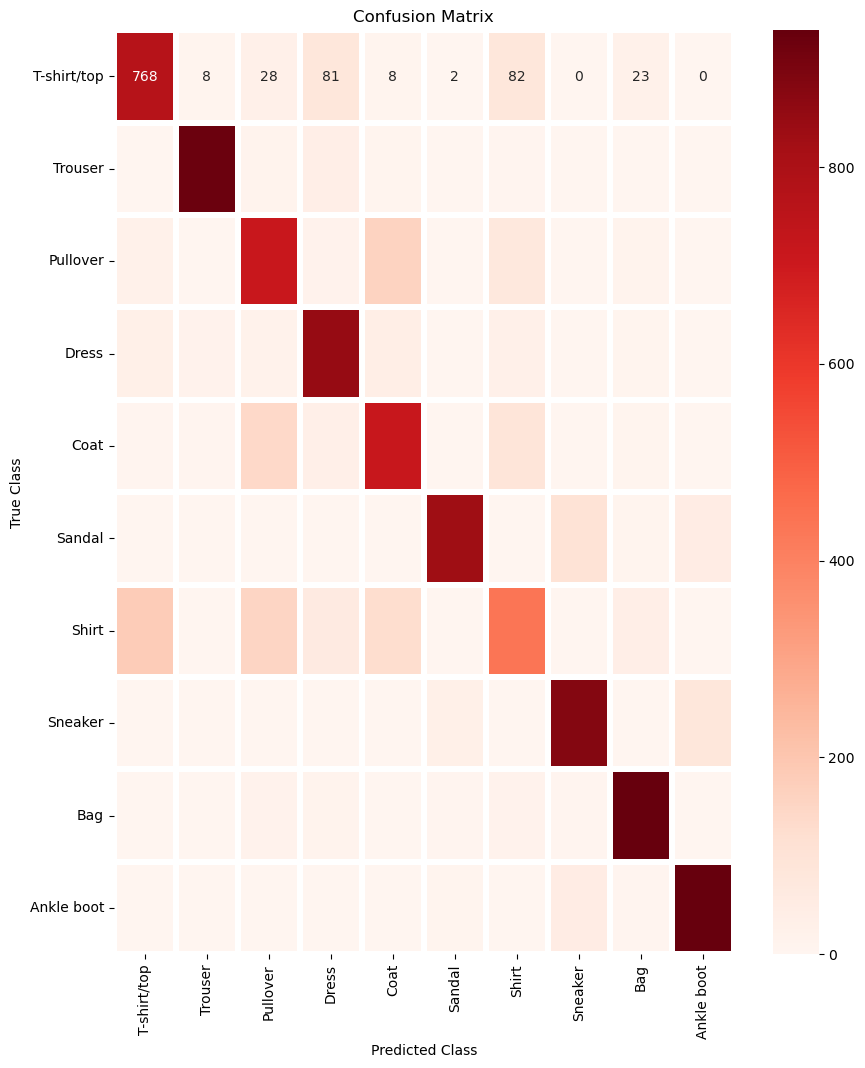

In [20]:
generate_and_plot_confusion_matrix(y_pred, neural_network.test_true)

## Question 8

In [21]:
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id,  lambda : train(loss_function = "mean_squared_error"), count = 250)
wandb.finish()

Create sweep with ID: ybvx48qp
Sweep URL: https://wandb.ai/cs24m021-iit-madras/DA6401_Assignment1/sweeps/ybvx48qp


wandb: Agent Starting Run: 0bx45nxr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4511, Train Acc=9.98%, Val Loss=0.4508, Val Acc=10.15%
Epoch 2: Train Loss=0.4513, Train Acc=9.98%, Val Loss=0.4510, Val Acc=10.15%
Epoch 3: Train Loss=0.4514, Train Acc=9.98%, Val Loss=0.4510, Val Acc=10.15%
Epoch 4: Train Loss=0.4514, Train Acc=9.98%, Val Loss=0.4510, Val Acc=10.15%
Epoch 5: Train Loss=0.4513, Train Acc=9.98%, Val Loss=0.4510, Val Acc=10.15%
Test-loss : 0.4513133660252787, Test-accuracy:10.0%
0.4513133660252787 10.0


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,▁▆██▇
val_acc,▁▁▁▁▁
val_loss,▁▅██▇
epoch,5
test_accuracy,10
train_acc,9.98333
train_loss,0.45135
val_acc,10.15


wandb: Agent Starting Run: 8nvu14fl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5742, Train Acc=9.97%, Val Loss=0.5726, Val Acc=10.30%
Epoch 2: Train Loss=0.5716, Train Acc=9.97%, Val Loss=0.5701, Val Acc=10.30%
Epoch 3: Train Loss=0.5692, Train Acc=9.97%, Val Loss=0.5677, Val Acc=10.30%
Epoch 4: Train Loss=0.5669, Train Acc=9.97%, Val Loss=0.5654, Val Acc=10.30%
Epoch 5: Train Loss=0.5647, Train Acc=9.97%, Val Loss=0.5632, Val Acc=10.30%
Test-loss : 0.564545891558782, Test-accuracy:10.0%
0.564545891558782 10.0


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,█▆▄▃▁
val_acc,▁▁▁▁▁
val_loss,█▆▄▃▁
epoch,5
test_accuracy,10
train_acc,9.96667
train_loss,0.56469
val_acc,10.3


wandb: Agent Starting Run: 6bacneiv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=0.4669, Train Acc=10.07%, Val Loss=0.4685, Val Acc=9.40%
Epoch 2: Train Loss=0.4640, Train Acc=10.07%, Val Loss=0.4654, Val Acc=9.40%
Epoch 3: Train Loss=0.4581, Train Acc=10.07%, Val Loss=0.4590, Val Acc=9.40%
Epoch 4: Train Loss=0.4544, Train Acc=10.07%, Val Loss=0.4550, Val Acc=9.40%
Epoch 5: Train Loss=0.4521, Train Acc=10.07%, Val Loss=0.4526, Val Acc=9.40%
Epoch 6: Train Loss=0.4510, Train Acc=10.07%, Val Loss=0.4513, Val Acc=9.40%
Epoch 7: Train Loss=0.4505, Train Acc=10.07%, Val Loss=0.4507, Val Acc=9.40%
Epoch 8: Train Loss=0.4502, Train Acc=10.07%, Val Loss=0.4503, Val Acc=9.40%
Epoch 9: Train Loss=0.4501, Train Acc=10.07%, Val Loss=0.4502, Val Acc=9.40%
Epoch 10: Train Loss=0.4500, Train Acc=10.07%, Val Loss=0.4501, Val Acc=9.40%
Test-loss : 0.4500406327678078, Test-accuracy:10.0%
0.4500406327678078 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▄▃▂▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▂▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,10.06667
train_loss,0.45003
val_acc,9.4


wandb: Agent Starting Run: sowd7v6i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1224, Train Acc=83.62%, Val Loss=0.1274, Val Acc=82.50%
Epoch 2: Train Loss=0.1110, Train Acc=84.95%, Val Loss=0.1157, Val Acc=84.40%
Epoch 3: Train Loss=0.1047, Train Acc=85.38%, Val Loss=0.1074, Val Acc=84.78%
Epoch 4: Train Loss=0.1036, Train Acc=85.16%, Val Loss=0.1071, Val Acc=84.88%
Epoch 5: Train Loss=0.1070, Train Acc=84.49%, Val Loss=0.1126, Val Acc=83.75%
Epoch 6: Train Loss=0.1138, Train Acc=83.46%, Val Loss=0.1212, Val Acc=82.32%
Epoch 7: Train Loss=0.1065, Train Acc=84.44%, Val Loss=0.1154, Val Acc=83.53%
Epoch 8: Train Loss=0.0998, Train Acc=85.56%, Val Loss=0.1088, Val Acc=84.33%
Epoch 9: Train Loss=0.0922, Train Acc=86.98%, Val Loss=0.1021, Val Acc=85.72%
Epoch 10: Train Loss=0.0911, Train Acc=87.16%, Val Loss=0.1021, Val Acc=85.65%
Test-loss : 0.1085749313988904, Test-accuracy:84.47%
0.1085749313988904 84.47


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▄▃▁▃▅██
train_loss,█▅▄▄▅▆▄▃▁▁
val_acc,▁▅▆▆▄▁▄▅██
val_loss,█▅▂▂▄▆▅▃▁▁
epoch,10
test_accuracy,84.47
train_acc,87.16481
train_loss,0.09108
val_acc,85.65


wandb: Agent Starting Run: nesjhvg7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4501, Val Acc=10.12%
Epoch 2: Train Loss=0.4502, Train Acc=9.91%, Val Loss=0.4500, Val Acc=10.80%
Epoch 3: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 4: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 5: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 6: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 7: Train Loss=0.4501, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 8: Train Loss=0.4501, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 9: Train Loss=0.4501, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 10: Train Loss=0.4501, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Test-loss : 0.4500672001653802, Test-accuracy:10.0%
0.4500672001653802 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,█▁████████
train_loss,██▇▆▆▅▄▃▂▁
val_acc,▁█▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▃▂▂▁▁
epoch,10
test_accuracy,10
train_acc,9.98704
train_loss,0.45007
val_acc,10.11667


wandb: Agent Starting Run: nlgd8bfg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4591, Train Acc=19.24%, Val Loss=0.4609, Val Acc=18.27%
Epoch 2: Train Loss=0.3940, Train Acc=36.56%, Val Loss=0.3947, Val Acc=36.35%
Epoch 3: Train Loss=0.3542, Train Acc=44.28%, Val Loss=0.3553, Val Acc=44.37%
Epoch 4: Train Loss=0.3252, Train Acc=51.73%, Val Loss=0.3257, Val Acc=52.07%
Epoch 5: Train Loss=0.3114, Train Acc=55.60%, Val Loss=0.3113, Val Acc=54.83%
Epoch 6: Train Loss=0.3035, Train Acc=59.53%, Val Loss=0.3048, Val Acc=58.70%
Epoch 7: Train Loss=0.3109, Train Acc=60.85%, Val Loss=0.3130, Val Acc=60.02%
Epoch 8: Train Loss=0.3271, Train Acc=60.61%, Val Loss=0.3290, Val Acc=59.78%
Epoch 9: Train Loss=0.3501, Train Acc=56.14%, Val Loss=0.3515, Val Acc=55.45%
Epoch 10: Train Loss=0.3817, Train Acc=52.82%, Val Loss=0.3829, Val Acc=52.45%
Test-loss : 0.3818977969551933, Test-accuracy:52.88%
0.3818977969551933 52.88


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇███▇▇
train_loss,█▅▃▂▁▁▁▂▃▅
val_acc,▁▄▅▇▇███▇▇
val_loss,█▅▃▂▁▁▁▂▃▅
epoch,10
test_accuracy,52.88
train_acc,52.82407
train_loss,0.38171
val_acc,52.45


wandb: Agent Starting Run: euklm7c8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.7717, Train Acc=10.92%, Val Loss=0.7731, Val Acc=11.15%
Epoch 2: Train Loss=0.7714, Train Acc=10.93%, Val Loss=0.7728, Val Acc=11.13%
Epoch 3: Train Loss=0.7710, Train Acc=10.94%, Val Loss=0.7725, Val Acc=11.17%
Epoch 4: Train Loss=0.7707, Train Acc=10.97%, Val Loss=0.7722, Val Acc=11.13%
Epoch 5: Train Loss=0.7703, Train Acc=11.01%, Val Loss=0.7719, Val Acc=11.20%
Test-loss : 0.7708013612001632, Test-accuracy:10.780000000000001%
0.7708013612001632 10.780000000000001


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▂▃▅█
train_loss,█▆▄▃▁
val_acc,▃▁▅▁█
val_loss,█▆▄▃▁
epoch,5
test_accuracy,10.78
train_acc,11.00926
train_loss,0.77032
val_acc,11.2


wandb: Agent Starting Run: qdn38hyv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.8387, Train Acc=8.62%, Val Loss=0.8426, Val Acc=8.22%
Epoch 2: Train Loss=0.8368, Train Acc=8.76%, Val Loss=0.8414, Val Acc=8.30%
Epoch 3: Train Loss=0.8349, Train Acc=8.86%, Val Loss=0.8396, Val Acc=8.47%
Epoch 4: Train Loss=0.8329, Train Acc=9.04%, Val Loss=0.8370, Val Acc=8.55%
Epoch 5: Train Loss=0.8311, Train Acc=9.20%, Val Loss=0.8349, Val Acc=8.48%
Epoch 6: Train Loss=0.8296, Train Acc=9.34%, Val Loss=0.8335, Val Acc=8.78%
Epoch 7: Train Loss=0.8282, Train Acc=9.39%, Val Loss=0.8321, Val Acc=8.75%
Epoch 8: Train Loss=0.8270, Train Acc=9.48%, Val Loss=0.8308, Val Acc=8.78%
Epoch 9: Train Loss=0.8258, Train Acc=9.63%, Val Loss=0.8300, Val Acc=8.90%
Epoch 10: Train Loss=0.8243, Train Acc=9.71%, Val Loss=0.8292, Val Acc=9.07%
Test-loss : 0.8201371520046492, Test-accuracy:10.02%
0.8201371520046492 10.02


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▅▆▆▇▇█
train_loss,█▇▆▅▄▄▃▂▂▁
val_acc,▁▂▃▄▃▆▅▆▇█
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,10
test_accuracy,10.02
train_acc,9.71111
train_loss,0.8243
val_acc,9.06667


wandb: Agent Starting Run: aimahr7f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6571, Train Acc=8.81%, Val Loss=0.6541, Val Acc=9.10%
Epoch 2: Train Loss=0.5623, Train Acc=9.42%, Val Loss=0.5619, Val Acc=9.52%
Epoch 3: Train Loss=0.5239, Train Acc=10.67%, Val Loss=0.5251, Val Acc=10.48%
Epoch 4: Train Loss=0.5064, Train Acc=13.27%, Val Loss=0.5084, Val Acc=12.47%
Epoch 5: Train Loss=0.5005, Train Acc=14.65%, Val Loss=0.5026, Val Acc=13.78%
Epoch 6: Train Loss=0.4981, Train Acc=15.09%, Val Loss=0.5001, Val Acc=13.93%
Epoch 7: Train Loss=0.4956, Train Acc=15.49%, Val Loss=0.4975, Val Acc=14.72%
Epoch 8: Train Loss=0.4926, Train Acc=15.94%, Val Loss=0.4944, Val Acc=15.25%
Epoch 9: Train Loss=0.4893, Train Acc=16.48%, Val Loss=0.4911, Val Acc=15.95%
Epoch 10: Train Loss=0.4858, Train Acc=16.97%, Val Loss=0.4874, Val Acc=16.33%
Test-loss : 0.48474586046054535, Test-accuracy:17.23%
0.48474586046054535 17.23


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▅▆▆▇▇██
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▁▂▄▆▆▆▇██
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,17.23
train_acc,16.97407
train_loss,0.48575
val_acc,16.33333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8hgr7198 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.7703, Train Acc=8.92%, Val Loss=0.7731, Val Acc=8.78%
Epoch 2: Train Loss=0.7701, Train Acc=8.95%, Val Loss=0.7728, Val Acc=8.82%
Epoch 3: Train Loss=0.7698, Train Acc=8.96%, Val Loss=0.7726, Val Acc=8.82%
Epoch 4: Train Loss=0.7696, Train Acc=8.97%, Val Loss=0.7724, Val Acc=8.82%
Epoch 5: Train Loss=0.7694, Train Acc=9.01%, Val Loss=0.7721, Val Acc=8.82%
Test-loss : 0.7685225580142199, Test-accuracy:9.02%
0.7685225580142199 9.02


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▃▅▅█
train_loss,█▆▄▃▁
val_acc,▁████
val_loss,█▆▄▃▁
epoch,5
test_accuracy,9.02
train_acc,9.00556
train_loss,0.76939
val_acc,8.81667


wandb: Agent Starting Run: cvrn4tg5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4954, Train Acc=11.21%, Val Loss=0.4962, Val Acc=10.77%
Epoch 2: Train Loss=0.4586, Train Acc=17.64%, Val Loss=0.4589, Val Acc=16.97%
Epoch 3: Train Loss=0.4295, Train Acc=26.07%, Val Loss=0.4296, Val Acc=26.00%
Epoch 4: Train Loss=0.4046, Train Acc=33.06%, Val Loss=0.4048, Val Acc=33.32%
Epoch 5: Train Loss=0.3857, Train Acc=37.04%, Val Loss=0.3859, Val Acc=36.88%
Test-loss : 0.38401716722857915, Test-accuracy:37.22%
0.38401716722857915 37.22


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▃▅▇█
train_loss,█▆▄▂▁
val_acc,▁▃▅▇█
val_loss,█▆▄▂▁
epoch,5
test_accuracy,37.22
train_acc,37.04074
train_loss,0.38566
val_acc,36.88333


wandb: Agent Starting Run: sxhjdnfi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.7603, Train Acc=8.48%, Val Loss=0.7593, Val Acc=8.50%
Epoch 2: Train Loss=0.7571, Train Acc=8.65%, Val Loss=0.7558, Val Acc=8.78%
Epoch 3: Train Loss=0.7541, Train Acc=8.90%, Val Loss=0.7521, Val Acc=9.07%
Epoch 4: Train Loss=0.7511, Train Acc=9.12%, Val Loss=0.7491, Val Acc=9.23%
Epoch 5: Train Loss=0.7484, Train Acc=9.23%, Val Loss=0.7468, Val Acc=9.52%
Epoch 6: Train Loss=0.7457, Train Acc=9.42%, Val Loss=0.7450, Val Acc=9.47%
Epoch 7: Train Loss=0.7428, Train Acc=9.63%, Val Loss=0.7438, Val Acc=9.53%
Epoch 8: Train Loss=0.7396, Train Acc=9.84%, Val Loss=0.7423, Val Acc=9.53%
Epoch 9: Train Loss=0.7365, Train Acc=10.11%, Val Loss=0.7389, Val Acc=9.95%
Epoch 10: Train Loss=0.7335, Train Acc=10.25%, Val Loss=0.7345, Val Acc=10.28%
Test-loss : 0.7323803360249638, Test-accuracy:10.25%
0.7323803360249638 10.25


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▄▅▆▆▇█
train_loss,█▇▆▆▅▄▃▃▂▁
val_acc,▁▂▃▄▅▅▅▅▇█
val_loss,█▇▆▅▄▄▄▃▂▁
epoch,10
test_accuracy,10.25
train_acc,10.2463
train_loss,0.73346
val_acc,10.28333


wandb: Agent Starting Run: kttaxhqq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.2695, Train Acc=61.83%, Val Loss=0.2694, Val Acc=61.73%
Epoch 2: Train Loss=0.2721, Train Acc=62.80%, Val Loss=0.2717, Val Acc=62.65%
Epoch 3: Train Loss=0.2758, Train Acc=62.19%, Val Loss=0.2752, Val Acc=62.15%
Epoch 4: Train Loss=0.2780, Train Acc=60.31%, Val Loss=0.2772, Val Acc=60.08%
Epoch 5: Train Loss=0.2808, Train Acc=58.89%, Val Loss=0.2799, Val Acc=59.03%
Test-loss : 0.2810262077868296, Test-accuracy:58.650000000000006%
0.2810262077868296 58.650000000000006


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▆█▇▄▁
train_loss,▁▃▅▆█
val_acc,▆█▇▃▁
val_loss,▁▃▅▆█
epoch,5
test_accuracy,58.65
train_acc,58.89259
train_loss,0.28077
val_acc,59.03333


wandb: Agent Starting Run: xgznkjb1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=0.4723, Train Acc=10.02%, Val Loss=0.4729, Val Acc=9.80%
Epoch 2: Train Loss=0.4709, Train Acc=10.02%, Val Loss=0.4715, Val Acc=9.80%
Epoch 3: Train Loss=0.4697, Train Acc=10.02%, Val Loss=0.4702, Val Acc=9.80%
Epoch 4: Train Loss=0.4685, Train Acc=10.02%, Val Loss=0.4691, Val Acc=9.80%
Epoch 5: Train Loss=0.4675, Train Acc=10.02%, Val Loss=0.4680, Val Acc=9.80%
Epoch 6: Train Loss=0.4666, Train Acc=10.02%, Val Loss=0.4671, Val Acc=9.80%
Epoch 7: Train Loss=0.4657, Train Acc=10.02%, Val Loss=0.4663, Val Acc=9.80%
Epoch 8: Train Loss=0.4650, Train Acc=10.02%, Val Loss=0.4655, Val Acc=9.80%
Epoch 9: Train Loss=0.4643, Train Acc=10.02%, Val Loss=0.4648, Val Acc=9.80%
Epoch 10: Train Loss=0.4636, Train Acc=10.02%, Val Loss=0.4641, Val Acc=9.80%
Test-loss : 0.4636710145964921, Test-accuracy:10.0%
0.4636710145964921 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▄▃▃▂▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▃▂▂▁
epoch,10
test_accuracy,10
train_acc,10.02222
train_loss,0.46362
val_acc,9.8


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kpgv29er with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 2: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 3: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 4: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 5: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 6: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 7: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 8: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 9: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 10: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Test-loss : 0.4967906083669064, Test-accuracy:10.0%
0.4967906083669064 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98333
train_loss,0.49667
val_acc,10.15


wandb: Agent Starting Run: ak8sk5yu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6417, Train Acc=15.94%, Val Loss=0.6367, Val Acc=16.25%
Epoch 2: Train Loss=0.5382, Train Acc=19.94%, Val Loss=0.5333, Val Acc=20.35%
Epoch 3: Train Loss=0.4680, Train Acc=23.33%, Val Loss=0.4687, Val Acc=22.92%
Epoch 4: Train Loss=0.4321, Train Acc=26.02%, Val Loss=0.4313, Val Acc=26.22%
Epoch 5: Train Loss=0.4036, Train Acc=31.61%, Val Loss=0.4021, Val Acc=31.78%
Epoch 6: Train Loss=0.3747, Train Acc=38.39%, Val Loss=0.3730, Val Acc=38.87%
Epoch 7: Train Loss=0.3515, Train Acc=43.37%, Val Loss=0.3512, Val Acc=43.35%
Epoch 8: Train Loss=0.3291, Train Acc=50.62%, Val Loss=0.3290, Val Acc=50.42%
Epoch 9: Train Loss=0.3127, Train Acc=55.30%, Val Loss=0.3140, Val Acc=55.30%
Epoch 10: Train Loss=0.2982, Train Acc=59.08%, Val Loss=0.3002, Val Acc=58.63%
Test-loss : 0.30194714472970174, Test-accuracy:58.53%
0.30194714472970174 58.53


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▂▃▄▅▅▇▇█
train_loss,█▆▄▄▃▃▂▂▁▁
val_acc,▁▂▂▃▄▅▅▇▇█
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_accuracy,58.53
train_acc,59.08148
train_loss,0.29821
val_acc,58.63333


wandb: Agent Starting Run: wvqe49r1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.8983, Train Acc=10.17%, Val Loss=0.8965, Val Acc=10.35%
Epoch 2: Train Loss=0.8910, Train Acc=10.90%, Val Loss=0.8910, Val Acc=10.90%
Epoch 3: Train Loss=0.9004, Train Acc=9.96%, Val Loss=0.8972, Val Acc=10.28%
Epoch 4: Train Loss=0.9004, Train Acc=9.96%, Val Loss=0.8972, Val Acc=10.28%
Epoch 5: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▃█▁▁▁
train_loss,▆▁███
val_acc,▂█▁▁▁
val_loss,▇▁███
epoch,5
test_accuracy,10
train_acc,9.96667
train_loss,0.90033
val_acc,10.3


wandb: Agent Starting Run: dtglk4m8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.1804, Train Acc=76.13%, Val Loss=0.1855, Val Acc=74.97%
Epoch 2: Train Loss=0.1858, Train Acc=75.16%, Val Loss=0.1909, Val Acc=73.98%
Epoch 3: Train Loss=0.1998, Train Acc=72.35%, Val Loss=0.2028, Val Acc=72.28%
Epoch 4: Train Loss=0.2291, Train Acc=66.66%, Val Loss=0.2297, Val Acc=67.08%
Epoch 5: Train Loss=0.2132, Train Acc=69.75%, Val Loss=0.2147, Val Acc=69.48%
Epoch 6: Train Loss=0.2336, Train Acc=65.09%, Val Loss=0.2326, Val Acc=65.60%
Epoch 7: Train Loss=0.3448, Train Acc=36.83%, Val Loss=0.3409, Val Acc=37.92%
Epoch 8: Train Loss=0.2898, Train Acc=54.08%, Val Loss=0.2886, Val Acc=53.95%
Epoch 9: Train Loss=0.2548, Train Acc=62.49%, Val Loss=0.2550, Val Acc=62.87%
Epoch 10: Train Loss=0.3544, Train Acc=36.56%, Val Loss=0.3509, Val Acc=37.45%
Test-loss : 0.35388665079916565, Test-accuracy:36.620000000000005%
0.35388665079916565 36.620000000000005


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,██▇▆▇▆▁▄▆▁
train_loss,▁▁▂▃▂▃█▅▄█
val_acc,██▇▇▇▆▁▄▆▁
val_loss,▁▁▂▃▂▃█▅▄█
epoch,10
test_accuracy,36.62
train_acc,36.56296
train_loss,0.35437
val_acc,37.45


wandb: Agent Starting Run: xq2vnvv5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7116, Train Acc=13.49%, Val Loss=0.7139, Val Acc=13.43%
Epoch 2: Train Loss=0.5080, Train Acc=18.67%, Val Loss=0.5082, Val Acc=19.17%
Epoch 3: Train Loss=0.4328, Train Acc=25.05%, Val Loss=0.4363, Val Acc=25.00%
Epoch 4: Train Loss=0.3780, Train Acc=36.55%, Val Loss=0.3831, Val Acc=35.35%
Epoch 5: Train Loss=0.3490, Train Acc=41.50%, Val Loss=0.3537, Val Acc=40.77%
Epoch 6: Train Loss=0.3277, Train Acc=46.14%, Val Loss=0.3320, Val Acc=45.82%
Epoch 7: Train Loss=0.3111, Train Acc=49.15%, Val Loss=0.3133, Val Acc=48.88%
Epoch 8: Train Loss=0.2976, Train Acc=51.26%, Val Loss=0.3004, Val Acc=50.75%
Epoch 9: Train Loss=0.2881, Train Acc=53.02%, Val Loss=0.2908, Val Acc=52.88%
Epoch 10: Train Loss=0.2793, Train Acc=53.21%, Val Loss=0.2844, Val Acc=52.42%
Test-loss : 0.2891497824219552, Test-accuracy:51.27%
0.2891497824219552 51.27


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▅▆▇▇███
train_loss,█▅▃▃▂▂▂▁▁▁
val_acc,▁▂▃▅▆▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,51.27
train_acc,53.21111
train_loss,0.27931
val_acc,52.41667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8cui1ykk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6759, Train Acc=18.90%, Val Loss=0.6743, Val Acc=18.92%
Epoch 2: Train Loss=0.6003, Train Acc=23.05%, Val Loss=0.6085, Val Acc=22.33%
Epoch 3: Train Loss=0.5246, Train Acc=24.61%, Val Loss=0.5271, Val Acc=24.65%
Epoch 4: Train Loss=0.4619, Train Acc=27.63%, Val Loss=0.4659, Val Acc=27.22%
Epoch 5: Train Loss=0.4255, Train Acc=29.40%, Val Loss=0.4293, Val Acc=29.05%
Epoch 6: Train Loss=0.4025, Train Acc=31.80%, Val Loss=0.4033, Val Acc=31.30%
Epoch 7: Train Loss=0.3821, Train Acc=34.16%, Val Loss=0.3820, Val Acc=34.20%
Epoch 8: Train Loss=0.3646, Train Acc=38.09%, Val Loss=0.3666, Val Acc=37.87%
Epoch 9: Train Loss=0.3519, Train Acc=40.83%, Val Loss=0.3535, Val Acc=41.03%
Epoch 10: Train Loss=0.3401, Train Acc=43.30%, Val Loss=0.3430, Val Acc=43.30%
Test-loss : 0.34704113570661255, Test-accuracy:42.03%
0.34704113570661255 42.03


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▄▅▅▇▇█
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▂▃▃▄▅▅▆▇█
val_loss,█▇▅▄▃▂▂▁▁▁
epoch,10
test_accuracy,42.03
train_acc,43.3037
train_loss,0.34014
val_acc,43.3


wandb: Agent Starting Run: 15k0sf2m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4034, Train Acc=35.81%, Val Loss=0.4031, Val Acc=35.62%
Epoch 2: Train Loss=0.3209, Train Acc=52.84%, Val Loss=0.3213, Val Acc=52.70%
Epoch 3: Train Loss=0.2778, Train Acc=58.33%, Val Loss=0.2784, Val Acc=57.78%
Epoch 4: Train Loss=0.2495, Train Acc=65.60%, Val Loss=0.2499, Val Acc=65.73%
Epoch 5: Train Loss=0.2255, Train Acc=69.23%, Val Loss=0.2256, Val Acc=69.53%
Epoch 6: Train Loss=0.2077, Train Acc=71.21%, Val Loss=0.2077, Val Acc=71.28%
Epoch 7: Train Loss=0.1955, Train Acc=72.58%, Val Loss=0.1956, Val Acc=72.42%
Epoch 8: Train Loss=0.1866, Train Acc=73.60%, Val Loss=0.1870, Val Acc=73.32%
Epoch 9: Train Loss=0.1801, Train Acc=74.36%, Val Loss=0.1807, Val Acc=73.78%
Epoch 10: Train Loss=0.1749, Train Acc=75.02%, Val Loss=0.1757, Val Acc=74.22%
Test-loss : 0.1800961712929497, Test-accuracy:73.82%
0.1800961712929497 73.82


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇████
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,73.82
train_acc,75.02037
train_loss,0.17489
val_acc,74.21667


wandb: Agent Starting Run: s9uh50tl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1119, Train Acc=84.24%, Val Loss=0.1185, Val Acc=83.42%
Epoch 2: Train Loss=0.1131, Train Acc=84.03%, Val Loss=0.1190, Val Acc=83.30%
Epoch 3: Train Loss=0.1151, Train Acc=84.01%, Val Loss=0.1223, Val Acc=82.75%
Epoch 4: Train Loss=0.1020, Train Acc=85.42%, Val Loss=0.1094, Val Acc=84.27%
Epoch 5: Train Loss=0.0931, Train Acc=87.32%, Val Loss=0.0989, Val Acc=86.25%
Epoch 6: Train Loss=0.0870, Train Acc=87.81%, Val Loss=0.0954, Val Acc=86.80%
Epoch 7: Train Loss=0.0910, Train Acc=87.25%, Val Loss=0.0982, Val Acc=86.27%
Epoch 8: Train Loss=0.0847, Train Acc=88.36%, Val Loss=0.0936, Val Acc=86.93%
Epoch 9: Train Loss=0.0963, Train Acc=86.78%, Val Loss=0.1066, Val Acc=85.53%
Epoch 10: Train Loss=0.0866, Train Acc=87.94%, Val Loss=0.0982, Val Acc=85.90%
Test-loss : 0.10296010933962359, Test-accuracy:85.88%
0.10296010933962359 85.88


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▃▆▇▆█▅▇
train_loss,▇██▅▃▂▂▁▄▁
val_acc,▂▂▁▄▇█▇█▆▆
val_loss,▇▇█▅▂▁▂▁▄▂
epoch,10
test_accuracy,85.88
train_acc,87.93519
train_loss,0.08661
val_acc,85.9


wandb: Agent Starting Run: 95r3vfx9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 2: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 3: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 4: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 5: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 6: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9017, Val Acc=9.83%
Epoch 7: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 8: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 9: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 10: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▃▃▃█▁▁▁▁
train_loss,█▆▆▆▆▁████
val_acc,█▆▆▆▆▁████
val_loss,▁▃▃▃▃█▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.96667
train_loss,0.90033
val_acc,10.3


wandb: Agent Starting Run: w51229mx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.7635, Train Acc=11.82%, Val Loss=0.7680, Val Acc=11.72%
Epoch 2: Train Loss=0.7463, Train Acc=12.60%, Val Loss=0.7535, Val Acc=12.07%
Epoch 3: Train Loss=0.7299, Train Acc=13.38%, Val Loss=0.7412, Val Acc=12.52%
Epoch 4: Train Loss=0.7132, Train Acc=13.96%, Val Loss=0.7230, Val Acc=13.23%
Epoch 5: Train Loss=0.6953, Train Acc=14.65%, Val Loss=0.7026, Val Acc=14.02%
Epoch 6: Train Loss=0.6688, Train Acc=15.79%, Val Loss=0.6718, Val Acc=15.68%
Epoch 7: Train Loss=0.6364, Train Acc=17.10%, Val Loss=0.6388, Val Acc=16.98%
Epoch 8: Train Loss=0.5969, Train Acc=18.20%, Val Loss=0.5976, Val Acc=18.02%
Epoch 9: Train Loss=0.5454, Train Acc=20.53%, Val Loss=0.5510, Val Acc=19.17%
Epoch 10: Train Loss=0.5034, Train Acc=23.67%, Val Loss=0.5110, Val Acc=22.33%
Test-loss : 0.5089625271755169, Test-accuracy:22.82%
0.5089625271755169 22.82


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▂▂▃▃▄▅▆█
train_loss,██▇▇▆▅▅▄▂▁
val_acc,▁▁▂▂▃▄▄▅▆█
val_loss,██▇▇▆▅▄▃▂▁
epoch,10
test_accuracy,22.82
train_acc,23.67407
train_loss,0.50345
val_acc,22.33333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: onzyzfvh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7657, Train Acc=14.14%, Val Loss=0.7598, Val Acc=15.22%
Epoch 2: Train Loss=0.6911, Train Acc=15.66%, Val Loss=0.6912, Val Acc=15.82%
Epoch 3: Train Loss=0.5109, Train Acc=14.75%, Val Loss=0.5118, Val Acc=15.02%
Epoch 4: Train Loss=0.4598, Train Acc=14.08%, Val Loss=0.4639, Val Acc=13.57%
Epoch 5: Train Loss=0.4436, Train Acc=16.55%, Val Loss=0.4452, Val Acc=16.18%
Epoch 6: Train Loss=0.4301, Train Acc=18.53%, Val Loss=0.4319, Val Acc=18.45%
Epoch 7: Train Loss=0.4186, Train Acc=19.88%, Val Loss=0.4218, Val Acc=19.57%
Epoch 8: Train Loss=0.4103, Train Acc=22.14%, Val Loss=0.4141, Val Acc=21.63%
Epoch 9: Train Loss=0.3984, Train Acc=25.33%, Val Loss=0.4011, Val Acc=25.02%
Epoch 10: Train Loss=0.3818, Train Acc=29.74%, Val Loss=0.3858, Val Acc=29.00%
Test-loss : 0.3866384002053606, Test-accuracy:29.020000000000003%
0.3866384002053606 29.020000000000003


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▁▁▂▃▄▅▆█
train_loss,█▇▃▂▂▂▂▂▁▁
val_acc,▂▂▂▁▂▃▄▅▆█
val_loss,█▇▃▂▂▂▂▂▁▁
epoch,10
test_accuracy,29.02
train_acc,29.74074
train_loss,0.38179
val_acc,29.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 69etv196 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4513, Train Acc=10.02%, Val Loss=0.4518, Val Acc=9.83%
Epoch 2: Train Loss=0.4505, Train Acc=10.07%, Val Loss=0.4508, Val Acc=9.40%
Epoch 3: Train Loss=0.4503, Train Acc=10.05%, Val Loss=0.4506, Val Acc=9.58%
Epoch 4: Train Loss=0.4502, Train Acc=10.05%, Val Loss=0.4505, Val Acc=9.58%
Epoch 5: Train Loss=0.4502, Train Acc=10.05%, Val Loss=0.4504, Val Acc=9.58%
Epoch 6: Train Loss=0.4502, Train Acc=10.05%, Val Loss=0.4504, Val Acc=9.58%
Epoch 7: Train Loss=0.4502, Train Acc=10.05%, Val Loss=0.4504, Val Acc=9.58%
Epoch 8: Train Loss=0.4502, Train Acc=10.05%, Val Loss=0.4503, Val Acc=9.58%
Epoch 9: Train Loss=0.4501, Train Acc=10.05%, Val Loss=0.4503, Val Acc=9.58%
Epoch 10: Train Loss=0.4501, Train Acc=10.05%, Val Loss=0.4503, Val Acc=9.58%
Test-loss : 0.4501475831038994, Test-accuracy:10.0%
0.4501475831038994 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁█▅▅▅▅▅▅▅▅
train_loss,█▃▂▂▁▁▁▁▁▁
val_acc,█▁▄▄▄▄▄▄▄▄
val_loss,█▃▂▂▂▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,10.0463
train_loss,0.45013
val_acc,9.58333


wandb: Agent Starting Run: 4uv0bvtk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7847, Train Acc=12.51%, Val Loss=0.7895, Val Acc=12.15%
Epoch 2: Train Loss=0.7225, Train Acc=15.64%, Val Loss=0.7286, Val Acc=15.20%
Epoch 3: Train Loss=0.6168, Train Acc=16.97%, Val Loss=0.6176, Val Acc=16.80%
Epoch 4: Train Loss=0.4913, Train Acc=16.86%, Val Loss=0.4954, Val Acc=16.85%
Epoch 5: Train Loss=0.4455, Train Acc=16.95%, Val Loss=0.4466, Val Acc=17.17%
Epoch 6: Train Loss=0.4286, Train Acc=20.76%, Val Loss=0.4299, Val Acc=21.75%
Epoch 7: Train Loss=0.4148, Train Acc=24.27%, Val Loss=0.4153, Val Acc=24.72%
Epoch 8: Train Loss=0.4039, Train Acc=27.39%, Val Loss=0.4053, Val Acc=26.97%
Epoch 9: Train Loss=0.3953, Train Acc=28.40%, Val Loss=0.3968, Val Acc=28.45%
Epoch 10: Train Loss=0.3777, Train Acc=33.78%, Val Loss=0.3785, Val Acc=34.17%
Test-loss : 0.3810478223246556, Test-accuracy:33.36%
0.3810478223246556 33.36


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▂▂▂▄▅▆▆█
train_loss,█▇▅▃▂▂▂▁▁▁
val_acc,▁▂▂▂▃▄▅▆▆█
val_loss,█▇▅▃▂▂▂▁▁▁
epoch,10
test_accuracy,33.36
train_acc,33.77593
train_loss,0.37775
val_acc,34.16667


wandb: Agent Starting Run: q949avls with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3623, Train Acc=47.39%, Val Loss=0.3633, Val Acc=47.82%
Epoch 2: Train Loss=0.2793, Train Acc=60.71%, Val Loss=0.2808, Val Acc=60.05%
Epoch 3: Train Loss=0.2462, Train Acc=64.30%, Val Loss=0.2472, Val Acc=64.53%
Epoch 4: Train Loss=0.2256, Train Acc=66.50%, Val Loss=0.2257, Val Acc=66.65%
Epoch 5: Train Loss=0.2129, Train Acc=67.95%, Val Loss=0.2125, Val Acc=68.10%
Epoch 6: Train Loss=0.2039, Train Acc=69.08%, Val Loss=0.2031, Val Acc=69.12%
Epoch 7: Train Loss=0.1967, Train Acc=70.10%, Val Loss=0.1957, Val Acc=70.47%
Epoch 8: Train Loss=0.1907, Train Acc=71.01%, Val Loss=0.1896, Val Acc=71.12%
Epoch 9: Train Loss=0.1857, Train Acc=71.78%, Val Loss=0.1847, Val Acc=71.80%
Epoch 10: Train Loss=0.1814, Train Acc=72.62%, Val Loss=0.1805, Val Acc=72.58%
Test-loss : 0.1862553884999324, Test-accuracy:71.38%
0.1862553884999324 71.38


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,71.38
train_acc,72.62037
train_loss,0.18136
val_acc,72.58333


wandb: Agent Starting Run: 5b5g4n03 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3889, Train Acc=39.80%, Val Loss=0.3895, Val Acc=38.75%
Epoch 2: Train Loss=0.3114, Train Acc=53.96%, Val Loss=0.3125, Val Acc=54.38%
Epoch 3: Train Loss=0.2659, Train Acc=60.46%, Val Loss=0.2670, Val Acc=60.15%
Epoch 4: Train Loss=0.2353, Train Acc=64.72%, Val Loss=0.2354, Val Acc=64.82%
Epoch 5: Train Loss=0.2162, Train Acc=67.61%, Val Loss=0.2159, Val Acc=67.53%
Epoch 6: Train Loss=0.2047, Train Acc=69.95%, Val Loss=0.2044, Val Acc=69.90%
Epoch 7: Train Loss=0.1969, Train Acc=71.46%, Val Loss=0.1968, Val Acc=71.40%
Epoch 8: Train Loss=0.1910, Train Acc=72.46%, Val Loss=0.1911, Val Acc=72.42%
Epoch 9: Train Loss=0.1862, Train Acc=73.12%, Val Loss=0.1865, Val Acc=73.05%
Epoch 10: Train Loss=0.1821, Train Acc=73.71%, Val Loss=0.1826, Val Acc=73.63%
Test-loss : 0.18664895390898292, Test-accuracy:72.98%
0.18664895390898292 72.98


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,72.98
train_acc,73.71296
train_loss,0.18207
val_acc,73.63333


wandb: Agent Starting Run: v2ysefsf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1047, Train Acc=85.31%, Val Loss=0.1095, Val Acc=84.35%
Epoch 2: Train Loss=0.0969, Train Acc=86.54%, Val Loss=0.1038, Val Acc=85.47%
Epoch 3: Train Loss=0.1026, Train Acc=86.22%, Val Loss=0.1106, Val Acc=85.17%
Epoch 4: Train Loss=0.0872, Train Acc=88.08%, Val Loss=0.0953, Val Acc=87.13%
Epoch 5: Train Loss=0.0856, Train Acc=88.35%, Val Loss=0.0956, Val Acc=86.65%
Epoch 6: Train Loss=0.0789, Train Acc=89.17%, Val Loss=0.0894, Val Acc=87.80%
Epoch 7: Train Loss=0.0870, Train Acc=88.14%, Val Loss=0.0978, Val Acc=86.77%
Epoch 8: Train Loss=0.0763, Train Acc=89.61%, Val Loss=0.0889, Val Acc=87.73%
Epoch 9: Train Loss=0.0779, Train Acc=89.42%, Val Loss=0.0893, Val Acc=88.03%
Epoch 10: Train Loss=0.0783, Train Acc=89.45%, Val Loss=0.0915, Val Acc=87.40%
Test-loss : 0.09893670067464125, Test-accuracy:86.66%
0.09893670067464125 86.66


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▂▆▆▇▆███
train_loss,█▆▇▄▃▂▄▁▁▁
val_acc,▁▃▃▆▅█▆▇█▇
val_loss,█▆█▃▃▁▄▁▁▂
epoch,10
test_accuracy,86.66
train_acc,89.4463
train_loss,0.07828
val_acc,87.4


wandb: Agent Starting Run: 9xy0nb3d with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.8992, Train Acc=10.08%, Val Loss=0.8968, Val Acc=10.32%
Epoch 2: Train Loss=0.8992, Train Acc=10.08%, Val Loss=0.9038, Val Acc=9.62%
Epoch 3: Train Loss=0.9032, Train Acc=9.67%, Val Loss=0.9058, Val Acc=9.42%
Epoch 4: Train Loss=0.8996, Train Acc=10.04%, Val Loss=0.9042, Val Acc=9.58%
Epoch 5: Train Loss=0.8996, Train Acc=10.04%, Val Loss=0.9042, Val Acc=9.58%
Epoch 6: Train Loss=0.8996, Train Acc=10.04%, Val Loss=0.9042, Val Acc=9.58%
Epoch 7: Train Loss=0.8996, Train Acc=10.04%, Val Loss=0.9042, Val Acc=9.58%
Epoch 8: Train Loss=0.8996, Train Acc=10.04%, Val Loss=0.9042, Val Acc=9.58%
Epoch 9: Train Loss=0.8996, Train Acc=10.04%, Val Loss=0.9042, Val Acc=9.58%
Epoch 10: Train Loss=0.8996, Train Acc=10.04%, Val Loss=0.9042, Val Acc=9.58%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,██▁▇▇▇▇▇▇▇
train_loss,▁▁█▂▂▂▂▂▂▂
val_acc,█▃▁▂▂▂▂▂▂▂
val_loss,▁▆█▇▇▇▇▇▇▇
epoch,10
test_accuracy,10
train_acc,10.04444
train_loss,0.89956
val_acc,9.58333


wandb: Agent Starting Run: iunejr5r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1154, Train Acc=84.16%, Val Loss=0.1233, Val Acc=83.05%
Epoch 2: Train Loss=0.0986, Train Acc=86.55%, Val Loss=0.1047, Val Acc=85.70%
Epoch 3: Train Loss=0.0981, Train Acc=86.27%, Val Loss=0.1049, Val Acc=85.20%
Epoch 4: Train Loss=0.0966, Train Acc=86.53%, Val Loss=0.1016, Val Acc=85.80%
Epoch 5: Train Loss=0.0880, Train Acc=88.02%, Val Loss=0.0969, Val Acc=86.90%
Epoch 6: Train Loss=0.0865, Train Acc=88.12%, Val Loss=0.0947, Val Acc=86.70%
Epoch 7: Train Loss=0.0876, Train Acc=87.72%, Val Loss=0.0959, Val Acc=86.60%
Epoch 8: Train Loss=0.0818, Train Acc=88.74%, Val Loss=0.0918, Val Acc=87.33%
Epoch 9: Train Loss=0.0791, Train Acc=89.10%, Val Loss=0.0889, Val Acc=87.88%
Epoch 10: Train Loss=0.0899, Train Acc=87.91%, Val Loss=0.1002, Val Acc=86.58%
Test-loss : 0.10855985366415018, Test-accuracy:85.49%
0.10855985366415018 85.49


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▄▄▆▇▆▇█▆
train_loss,█▅▅▄▃▂▃▂▁▃
val_acc,▁▅▄▅▇▆▆▇█▆
val_loss,█▄▄▄▃▂▂▂▁▃
epoch,10
test_accuracy,85.49
train_acc,87.90556
train_loss,0.0899
val_acc,86.58333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dlhjj3a7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1145, Train Acc=83.83%, Val Loss=0.1176, Val Acc=83.30%
Epoch 2: Train Loss=0.1008, Train Acc=85.88%, Val Loss=0.1068, Val Acc=84.67%
Epoch 3: Train Loss=0.0964, Train Acc=86.47%, Val Loss=0.1021, Val Acc=85.37%
Epoch 4: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 5: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 6: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 7: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 8: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 9: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 10: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,███▁▁▁▁▁▁▁
train_loss,▁▁▁███████
val_acc,███▁▁▁▁▁▁▁
val_loss,▁▁▁███████
epoch,10
test_accuracy,10
train_acc,9.96667
train_loss,0.90033
val_acc,10.3


wandb: Agent Starting Run: 5pls3l3g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3532, Train Acc=42.06%, Val Loss=0.3531, Val Acc=41.58%
Epoch 2: Train Loss=0.2957, Train Acc=48.69%, Val Loss=0.2958, Val Acc=48.67%
Epoch 3: Train Loss=0.2297, Train Acc=63.94%, Val Loss=0.2305, Val Acc=63.90%
Epoch 4: Train Loss=0.2117, Train Acc=69.75%, Val Loss=0.2109, Val Acc=69.57%
Epoch 5: Train Loss=0.1857, Train Acc=74.15%, Val Loss=0.1861, Val Acc=74.02%
Epoch 6: Train Loss=0.1750, Train Acc=76.03%, Val Loss=0.1766, Val Acc=75.72%
Epoch 7: Train Loss=0.1721, Train Acc=76.21%, Val Loss=0.1732, Val Acc=76.28%
Epoch 8: Train Loss=0.1684, Train Acc=76.65%, Val Loss=0.1717, Val Acc=76.25%
Epoch 9: Train Loss=0.1629, Train Acc=77.36%, Val Loss=0.1660, Val Acc=77.48%
Epoch 10: Train Loss=0.1540, Train Acc=78.33%, Val Loss=0.1557, Val Acc=78.15%
Test-loss : 0.16083033194990506, Test-accuracy:77.28%
0.16083033194990506 77.28


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▅▆▇█████
train_loss,█▆▄▃▂▂▂▂▁▁
val_acc,▁▂▅▆▇█████
val_loss,█▆▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,77.28
train_acc,78.32593
train_loss,0.15398
val_acc,78.15


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9d37ydkj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4342, Train Acc=17.63%, Val Loss=0.4361, Val Acc=17.40%
Epoch 2: Train Loss=0.3938, Train Acc=29.64%, Val Loss=0.3912, Val Acc=30.07%
Epoch 3: Train Loss=0.3525, Train Acc=40.48%, Val Loss=0.3512, Val Acc=41.03%
Epoch 4: Train Loss=0.2887, Train Acc=56.11%, Val Loss=0.2912, Val Acc=55.42%
Epoch 5: Train Loss=0.2472, Train Acc=63.71%, Val Loss=0.2494, Val Acc=62.98%
Epoch 6: Train Loss=0.2337, Train Acc=64.91%, Val Loss=0.2379, Val Acc=63.90%
Epoch 7: Train Loss=0.2262, Train Acc=66.22%, Val Loss=0.2295, Val Acc=65.77%
Epoch 8: Train Loss=0.2076, Train Acc=69.57%, Val Loss=0.2110, Val Acc=68.63%
Epoch 9: Train Loss=0.2055, Train Acc=70.46%, Val Loss=0.2105, Val Acc=69.52%
Epoch 10: Train Loss=0.2017, Train Acc=70.95%, Val Loss=0.2087, Val Acc=69.37%
Test-loss : 0.20556688015961663, Test-accuracy:70.14%
0.20556688015961663 70.14


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▆▇▇▇███
train_loss,█▇▆▄▂▂▂▁▁▁
val_acc,▁▃▄▆▇▇▇███
val_loss,█▇▅▄▂▂▂▁▁▁
epoch,10
test_accuracy,70.14
train_acc,70.9537
train_loss,0.20168
val_acc,69.36667


wandb: Agent Starting Run: y6ogammy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1250, Train Acc=83.59%, Val Loss=0.1286, Val Acc=83.08%
Epoch 2: Train Loss=0.1078, Train Acc=85.45%, Val Loss=0.1114, Val Acc=84.75%
Epoch 3: Train Loss=0.0991, Train Acc=86.52%, Val Loss=0.1026, Val Acc=85.97%
Epoch 4: Train Loss=0.0928, Train Acc=87.43%, Val Loss=0.0970, Val Acc=86.95%
Epoch 5: Train Loss=0.0913, Train Acc=87.69%, Val Loss=0.0963, Val Acc=86.93%
Epoch 6: Train Loss=0.0883, Train Acc=88.12%, Val Loss=0.0945, Val Acc=86.92%
Epoch 7: Train Loss=0.0849, Train Acc=88.61%, Val Loss=0.0927, Val Acc=87.20%
Epoch 8: Train Loss=0.0834, Train Acc=88.82%, Val Loss=0.0920, Val Acc=87.12%
Epoch 9: Train Loss=0.0820, Train Acc=88.96%, Val Loss=0.0911, Val Acc=87.43%
Epoch 10: Train Loss=0.0805, Train Acc=89.10%, Val Loss=0.0902, Val Acc=87.57%
Test-loss : 0.09877388123086989, Test-accuracy:86.65%
0.09877388123086989 86.65


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▆▇▇▇▇▇██
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,86.65
train_acc,89.1037
train_loss,0.08051
val_acc,87.56667


wandb: Agent Starting Run: tn4dld6r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1214, Train Acc=83.43%, Val Loss=0.1255, Val Acc=82.68%
Epoch 2: Train Loss=0.1097, Train Acc=84.87%, Val Loss=0.1136, Val Acc=84.18%
Epoch 3: Train Loss=0.0969, Train Acc=86.77%, Val Loss=0.1000, Val Acc=86.23%
Epoch 4: Train Loss=0.0932, Train Acc=87.31%, Val Loss=0.0984, Val Acc=86.35%
Epoch 5: Train Loss=0.0914, Train Acc=87.53%, Val Loss=0.0974, Val Acc=86.12%
Epoch 6: Train Loss=0.0924, Train Acc=87.39%, Val Loss=0.1001, Val Acc=86.03%
Epoch 7: Train Loss=0.0911, Train Acc=87.42%, Val Loss=0.0988, Val Acc=85.90%
Epoch 8: Train Loss=0.0881, Train Acc=87.77%, Val Loss=0.0970, Val Acc=86.35%
Epoch 9: Train Loss=0.0859, Train Acc=88.09%, Val Loss=0.0953, Val Acc=86.58%
Epoch 10: Train Loss=0.0813, Train Acc=88.73%, Val Loss=0.0914, Val Acc=87.13%
Test-loss : 0.10115412118196736, Test-accuracy:86.04%
0.10115412118196736 86.04


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▆▆▇▇█
train_loss,█▆▄▃▃▃▃▂▂▁
val_acc,▁▃▇▇▆▆▆▇▇█
val_loss,█▆▃▂▂▃▃▂▂▁
epoch,10
test_accuracy,86.04
train_acc,88.72778
train_loss,0.0813
val_acc,87.13333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xptr3xl2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1460, Train Acc=79.26%, Val Loss=0.1503, Val Acc=78.63%
Epoch 2: Train Loss=0.1306, Train Acc=81.49%, Val Loss=0.1352, Val Acc=80.68%
Epoch 3: Train Loss=0.1233, Train Acc=82.69%, Val Loss=0.1282, Val Acc=81.93%
Epoch 4: Train Loss=0.1167, Train Acc=83.74%, Val Loss=0.1227, Val Acc=82.57%
Epoch 5: Train Loss=0.1116, Train Acc=84.51%, Val Loss=0.1195, Val Acc=83.12%
Epoch 6: Train Loss=0.1090, Train Acc=84.89%, Val Loss=0.1178, Val Acc=83.52%
Epoch 7: Train Loss=0.1066, Train Acc=85.30%, Val Loss=0.1162, Val Acc=84.07%
Epoch 8: Train Loss=0.1026, Train Acc=85.89%, Val Loss=0.1135, Val Acc=84.57%
Epoch 9: Train Loss=0.0998, Train Acc=86.29%, Val Loss=0.1116, Val Acc=84.57%
Epoch 10: Train Loss=0.0979, Train Acc=86.53%, Val Loss=0.1110, Val Acc=84.72%
Test-loss : 0.12067785772872623, Test-accuracy:83.55%
0.12067785772872623 83.55


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,83.55
train_acc,86.53148
train_loss,0.09792
val_acc,84.71667


wandb: Agent Starting Run: 12lq44jx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1099, Train Acc=84.50%, Val Loss=0.1145, Val Acc=83.82%
Epoch 2: Train Loss=0.0979, Train Acc=86.48%, Val Loss=0.1045, Val Acc=85.25%
Epoch 3: Train Loss=0.0942, Train Acc=86.80%, Val Loss=0.1010, Val Acc=85.92%
Epoch 4: Train Loss=0.0866, Train Acc=87.93%, Val Loss=0.0944, Val Acc=86.60%
Epoch 5: Train Loss=0.0873, Train Acc=87.93%, Val Loss=0.0971, Val Acc=86.37%
Epoch 6: Train Loss=0.0797, Train Acc=89.12%, Val Loss=0.0909, Val Acc=87.20%
Epoch 7: Train Loss=0.0805, Train Acc=88.94%, Val Loss=0.0910, Val Acc=87.48%
Epoch 8: Train Loss=0.0791, Train Acc=89.05%, Val Loss=0.0925, Val Acc=87.25%
Epoch 9: Train Loss=0.0765, Train Acc=89.52%, Val Loss=0.0931, Val Acc=87.08%
Epoch 10: Train Loss=0.0729, Train Acc=90.09%, Val Loss=0.0903, Val Acc=87.75%
Test-loss : 0.09632342306255136, Test-accuracy:86.99%
0.09632342306255136 86.99


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▅▇▇▇▇█
train_loss,█▆▅▄▄▂▂▂▂▁
val_acc,▁▄▅▆▆▇█▇▇█
val_loss,█▅▄▂▃▁▁▂▂▁
epoch,10
test_accuracy,86.99
train_acc,90.09444
train_loss,0.07293
val_acc,87.75


wandb: Agent Starting Run: 2rjulia6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.2764, Train Acc=59.03%, Val Loss=0.2763, Val Acc=59.05%
Epoch 2: Train Loss=0.2801, Train Acc=59.79%, Val Loss=0.2796, Val Acc=59.72%
Epoch 3: Train Loss=0.2831, Train Acc=58.60%, Val Loss=0.2823, Val Acc=58.58%
Epoch 4: Train Loss=0.2851, Train Acc=58.19%, Val Loss=0.2843, Val Acc=58.22%
Epoch 5: Train Loss=0.2859, Train Acc=58.12%, Val Loss=0.2850, Val Acc=58.12%
Epoch 6: Train Loss=0.2871, Train Acc=58.02%, Val Loss=0.2861, Val Acc=57.93%
Epoch 7: Train Loss=0.2877, Train Acc=57.78%, Val Loss=0.2867, Val Acc=57.98%
Epoch 8: Train Loss=0.2879, Train Acc=57.66%, Val Loss=0.2869, Val Acc=57.88%
Epoch 9: Train Loss=0.2879, Train Acc=57.62%, Val Loss=0.2868, Val Acc=57.77%
Epoch 10: Train Loss=0.2879, Train Acc=57.62%, Val Loss=0.2868, Val Acc=57.75%
Test-loss : 0.28805613249360434, Test-accuracy:57.52%
0.28805613249360434 57.52


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▆█▄▃▃▂▂▁▁▁
train_loss,▁▃▅▆▇▇████
val_acc,▆█▄▃▂▂▂▁▁▁
val_loss,▁▃▅▆▇▇████
epoch,10
test_accuracy,57.52
train_acc,57.61667
train_loss,0.28786
val_acc,57.75


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pt8rlbo5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1991, Train Acc=71.10%, Val Loss=0.2025, Val Acc=69.97%
Epoch 2: Train Loss=0.1415, Train Acc=82.06%, Val Loss=0.1446, Val Acc=81.28%
Epoch 3: Train Loss=0.1211, Train Acc=84.34%, Val Loss=0.1255, Val Acc=83.60%
Epoch 4: Train Loss=0.1091, Train Acc=85.62%, Val Loss=0.1146, Val Acc=84.53%
Epoch 5: Train Loss=0.1007, Train Acc=86.65%, Val Loss=0.1068, Val Acc=85.55%
Epoch 6: Train Loss=0.0958, Train Acc=87.21%, Val Loss=0.1027, Val Acc=85.97%
Epoch 7: Train Loss=0.0929, Train Acc=87.57%, Val Loss=0.1006, Val Acc=86.25%
Epoch 8: Train Loss=0.0902, Train Acc=87.82%, Val Loss=0.0988, Val Acc=86.50%
Epoch 9: Train Loss=0.0882, Train Acc=88.08%, Val Loss=0.0976, Val Acc=86.55%
Epoch 10: Train Loss=0.0857, Train Acc=88.43%, Val Loss=0.0957, Val Acc=86.92%
Test-loss : 0.10294842087560664, Test-accuracy:85.72%
0.10294842087560664 85.72


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▇▇█████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▆▇▇▇█████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,85.72
train_acc,88.43333
train_loss,0.08569
val_acc,86.91667


wandb: Agent Starting Run: jwj2v4h9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1331, Train Acc=81.13%, Val Loss=0.1356, Val Acc=80.50%
Epoch 2: Train Loss=0.1051, Train Acc=85.16%, Val Loss=0.1101, Val Acc=83.85%
Epoch 3: Train Loss=0.1028, Train Acc=85.67%, Val Loss=0.1071, Val Acc=84.82%
Epoch 4: Train Loss=0.0954, Train Acc=86.85%, Val Loss=0.0990, Val Acc=86.03%
Epoch 5: Train Loss=0.0897, Train Acc=87.20%, Val Loss=0.0938, Val Acc=86.92%
Epoch 6: Train Loss=0.0922, Train Acc=87.19%, Val Loss=0.0987, Val Acc=86.52%
Epoch 7: Train Loss=0.0849, Train Acc=87.99%, Val Loss=0.0897, Val Acc=87.25%
Epoch 8: Train Loss=0.0865, Train Acc=88.01%, Val Loss=0.0940, Val Acc=86.70%
Epoch 9: Train Loss=0.0821, Train Acc=88.65%, Val Loss=0.0900, Val Acc=87.18%
Epoch 10: Train Loss=0.0904, Train Acc=87.95%, Val Loss=0.0985, Val Acc=86.93%
Test-loss : 0.10780154851295713, Test-accuracy:85.45%
0.10780154851295713 85.45


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▅▆▇▇▇▇█▇
train_loss,█▄▄▃▂▂▁▂▁▂
val_acc,▁▄▅▇█▇█▇██
val_loss,█▄▄▂▂▂▁▂▁▂
epoch,10
test_accuracy,85.45
train_acc,87.9537
train_loss,0.09037
val_acc,86.93333


wandb: Agent Starting Run: vs8cpuif with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1615, Train Acc=76.64%, Val Loss=0.1671, Val Acc=75.50%
Epoch 2: Train Loss=0.1459, Train Acc=79.44%, Val Loss=0.1532, Val Acc=77.75%
Epoch 3: Train Loss=0.1348, Train Acc=81.17%, Val Loss=0.1439, Val Acc=79.67%
Epoch 4: Train Loss=0.1262, Train Acc=82.34%, Val Loss=0.1354, Val Acc=80.88%
Epoch 5: Train Loss=0.1211, Train Acc=83.08%, Val Loss=0.1303, Val Acc=81.50%
Epoch 6: Train Loss=0.1170, Train Acc=83.61%, Val Loss=0.1267, Val Acc=82.25%
Epoch 7: Train Loss=0.1133, Train Acc=84.21%, Val Loss=0.1236, Val Acc=82.68%
Epoch 8: Train Loss=0.1100, Train Acc=84.65%, Val Loss=0.1210, Val Acc=82.97%
Epoch 9: Train Loss=0.1076, Train Acc=84.98%, Val Loss=0.1194, Val Acc=83.30%
Epoch 10: Train Loss=0.1054, Train Acc=85.33%, Val Loss=0.1179, Val Acc=83.45%
Test-loss : 0.1216610850574197, Test-accuracy:83.04%
0.1216610850574197 83.04


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▆▅▃▃▂▂▁▁▁
epoch,10
test_accuracy,83.04
train_acc,85.33148
train_loss,0.10539
val_acc,83.45


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rmockufb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1199, Train Acc=83.57%, Val Loss=0.1256, Val Acc=82.72%
Epoch 2: Train Loss=0.0993, Train Acc=86.40%, Val Loss=0.1042, Val Acc=85.63%
Epoch 3: Train Loss=0.0925, Train Acc=87.27%, Val Loss=0.0986, Val Acc=86.20%
Epoch 4: Train Loss=0.0880, Train Acc=87.70%, Val Loss=0.0943, Val Acc=86.88%
Epoch 5: Train Loss=0.0884, Train Acc=87.69%, Val Loss=0.0971, Val Acc=86.43%
Epoch 6: Train Loss=0.0790, Train Acc=89.27%, Val Loss=0.0898, Val Acc=87.67%
Epoch 7: Train Loss=0.0811, Train Acc=88.88%, Val Loss=0.0919, Val Acc=87.37%
Epoch 8: Train Loss=0.0782, Train Acc=89.41%, Val Loss=0.0916, Val Acc=87.43%
Epoch 9: Train Loss=0.0800, Train Acc=89.10%, Val Loss=0.0905, Val Acc=87.58%
Epoch 10: Train Loss=0.0773, Train Acc=89.45%, Val Loss=0.0924, Val Acc=87.43%
Test-loss : 0.09906597330299549, Test-accuracy:86.58%
0.09906597330299549 86.58


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆█▇███
train_loss,█▅▃▃▃▁▂▁▁▁
val_acc,▁▅▆▇▆█████
val_loss,█▄▃▂▂▁▁▁▁▂
epoch,10
test_accuracy,86.58
train_acc,89.45185
train_loss,0.0773
val_acc,87.43333


wandb: Agent Starting Run: i5dtytbm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4607, Train Acc=12.73%, Val Loss=0.4607, Val Acc=13.28%
Epoch 2: Train Loss=0.4352, Train Acc=20.86%, Val Loss=0.4353, Val Acc=21.78%
Epoch 3: Train Loss=0.3891, Train Acc=31.23%, Val Loss=0.3886, Val Acc=31.60%
Epoch 4: Train Loss=0.3628, Train Acc=36.37%, Val Loss=0.3637, Val Acc=36.50%
Epoch 5: Train Loss=0.3425, Train Acc=40.63%, Val Loss=0.3427, Val Acc=40.97%
Epoch 6: Train Loss=0.3284, Train Acc=43.16%, Val Loss=0.3296, Val Acc=43.30%
Epoch 7: Train Loss=0.3202, Train Acc=45.14%, Val Loss=0.3211, Val Acc=45.33%
Epoch 8: Train Loss=0.3139, Train Acc=45.68%, Val Loss=0.3134, Val Acc=45.88%
Epoch 9: Train Loss=0.3027, Train Acc=49.02%, Val Loss=0.3059, Val Acc=48.80%
Epoch 10: Train Loss=0.2882, Train Acc=52.21%, Val Loss=0.2916, Val Acc=51.52%
Test-loss : 0.2918382606878768, Test-accuracy:51.7%
0.2918382606878768 51.7


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▄▅▆▆▇▇▇█
train_loss,█▇▅▄▃▃▂▂▂▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▇▅▄▃▃▂▂▂▁
epoch,10
test_accuracy,51.7
train_acc,52.20926
train_loss,0.2882
val_acc,51.51667


wandb: Agent Starting Run: 2uk91xxu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1394, Train Acc=80.20%, Val Loss=0.1404, Val Acc=79.95%
Epoch 2: Train Loss=0.1230, Train Acc=82.70%, Val Loss=0.1266, Val Acc=81.95%
Epoch 3: Train Loss=0.1147, Train Acc=83.78%, Val Loss=0.1197, Val Acc=83.47%
Epoch 4: Train Loss=0.1088, Train Acc=84.77%, Val Loss=0.1154, Val Acc=84.15%
Epoch 5: Train Loss=0.1051, Train Acc=85.28%, Val Loss=0.1135, Val Acc=84.27%
Epoch 6: Train Loss=0.0999, Train Acc=86.19%, Val Loss=0.1104, Val Acc=84.67%
Epoch 7: Train Loss=0.0979, Train Acc=86.46%, Val Loss=0.1100, Val Acc=84.87%
Epoch 8: Train Loss=0.0954, Train Acc=86.97%, Val Loss=0.1081, Val Acc=85.13%
Epoch 9: Train Loss=0.0937, Train Acc=87.12%, Val Loss=0.1070, Val Acc=85.45%
Epoch 10: Train Loss=0.0915, Train Acc=87.53%, Val Loss=0.1060, Val Acc=85.55%
Test-loss : 0.11329187974006875, Test-accuracy:84.61%
0.11329187974006875 84.61


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,84.61
train_acc,87.52963
train_loss,0.09149
val_acc,85.55


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5f49e7a0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4373, Train Acc=16.43%, Val Loss=0.4362, Val Acc=16.87%
Epoch 2: Train Loss=0.3903, Train Acc=28.55%, Val Loss=0.3886, Val Acc=29.08%
Epoch 3: Train Loss=0.3855, Train Acc=27.95%, Val Loss=0.3864, Val Acc=28.32%
Epoch 4: Train Loss=0.3391, Train Acc=41.48%, Val Loss=0.3416, Val Acc=41.40%
Epoch 5: Train Loss=0.2970, Train Acc=49.56%, Val Loss=0.2960, Val Acc=50.45%
Epoch 6: Train Loss=0.2709, Train Acc=58.54%, Val Loss=0.2710, Val Acc=57.60%
Epoch 7: Train Loss=0.2548, Train Acc=59.01%, Val Loss=0.2589, Val Acc=58.95%
Epoch 8: Train Loss=0.2331, Train Acc=62.97%, Val Loss=0.2355, Val Acc=62.78%
Epoch 9: Train Loss=0.2359, Train Acc=63.34%, Val Loss=0.2423, Val Acc=62.15%
Epoch 10: Train Loss=0.2317, Train Acc=64.13%, Val Loss=0.2346, Val Acc=64.17%
Test-loss : 0.23395297050504169, Test-accuracy:63.85999999999999%
0.23395297050504169 63.85999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▃▅▆▇▇███
train_loss,█▆▆▅▃▂▂▁▁▁
val_acc,▁▃▃▅▆▇▇███
val_loss,█▆▆▅▃▂▂▁▁▁
epoch,10
test_accuracy,63.86
train_acc,64.12963
train_loss,0.23166
val_acc,64.16667


wandb: Agent Starting Run: fn1fo70s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1129, Train Acc=83.92%, Val Loss=0.1162, Val Acc=83.35%
Epoch 2: Train Loss=0.1110, Train Acc=84.51%, Val Loss=0.1181, Val Acc=83.65%
Epoch 3: Train Loss=0.0890, Train Acc=87.54%, Val Loss=0.0960, Val Acc=86.47%
Epoch 4: Train Loss=0.1008, Train Acc=86.04%, Val Loss=0.1088, Val Acc=85.00%
Epoch 5: Train Loss=0.0866, Train Acc=87.97%, Val Loss=0.0943, Val Acc=86.75%
Epoch 6: Train Loss=0.0879, Train Acc=87.73%, Val Loss=0.0972, Val Acc=86.53%
Epoch 7: Train Loss=0.0822, Train Acc=88.71%, Val Loss=0.0923, Val Acc=87.53%
Epoch 8: Train Loss=0.0796, Train Acc=88.84%, Val Loss=0.0920, Val Acc=87.17%
Epoch 9: Train Loss=0.0803, Train Acc=88.91%, Val Loss=0.0906, Val Acc=87.45%
Epoch 10: Train Loss=0.0894, Train Acc=87.96%, Val Loss=0.1017, Val Acc=86.20%
Test-loss : 0.11219323243989436, Test-accuracy:85.1%
0.11219323243989436 85.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▆▄▇▆███▇
train_loss,██▃▅▂▃▂▁▁▃
val_acc,▁▂▆▄▇▆█▇█▆
val_loss,██▂▆▂▃▁▁▁▄
epoch,10
test_accuracy,85.1
train_acc,87.95556
train_loss,0.08937
val_acc,86.2


wandb: Agent Starting Run: 4wozwveu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4269, Train Acc=24.18%, Val Loss=0.4302, Val Acc=23.43%
Epoch 2: Train Loss=0.3910, Train Acc=31.56%, Val Loss=0.3959, Val Acc=30.48%
Epoch 3: Train Loss=0.3698, Train Acc=33.66%, Val Loss=0.3730, Val Acc=32.75%
Epoch 4: Train Loss=0.3350, Train Acc=42.53%, Val Loss=0.3371, Val Acc=42.50%
Epoch 5: Train Loss=0.3054, Train Acc=52.29%, Val Loss=0.3058, Val Acc=52.08%
Epoch 6: Train Loss=0.2764, Train Acc=56.84%, Val Loss=0.2799, Val Acc=56.22%
Epoch 7: Train Loss=0.2567, Train Acc=60.00%, Val Loss=0.2614, Val Acc=59.33%
Epoch 8: Train Loss=0.2438, Train Acc=62.02%, Val Loss=0.2504, Val Acc=60.97%
Epoch 9: Train Loss=0.2350, Train Acc=63.79%, Val Loss=0.2398, Val Acc=62.92%
Epoch 10: Train Loss=0.2221, Train Acc=65.23%, Val Loss=0.2292, Val Acc=63.90%
Test-loss : 0.22942335804084252, Test-accuracy:64.19%
0.22942335804084252 64.19


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▆▇▇▇██
train_loss,█▇▆▅▄▃▂▂▁▁
val_acc,▁▂▃▄▆▇▇▇██
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,10
test_accuracy,64.19
train_acc,65.22593
train_loss,0.22213
val_acc,63.9


wandb: Agent Starting Run: 5a94aeee with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1481, Train Acc=78.95%, Val Loss=0.1529, Val Acc=78.07%
Epoch 2: Train Loss=0.1291, Train Acc=81.91%, Val Loss=0.1342, Val Acc=81.13%
Epoch 3: Train Loss=0.1202, Train Acc=83.31%, Val Loss=0.1273, Val Acc=81.90%
Epoch 4: Train Loss=0.1130, Train Acc=84.37%, Val Loss=0.1215, Val Acc=82.72%
Epoch 5: Train Loss=0.1077, Train Acc=85.08%, Val Loss=0.1175, Val Acc=83.27%
Epoch 6: Train Loss=0.1029, Train Acc=85.75%, Val Loss=0.1145, Val Acc=83.62%
Epoch 7: Train Loss=0.0993, Train Acc=86.31%, Val Loss=0.1124, Val Acc=84.03%
Epoch 8: Train Loss=0.0962, Train Acc=86.74%, Val Loss=0.1105, Val Acc=84.50%
Epoch 9: Train Loss=0.0935, Train Acc=87.10%, Val Loss=0.1090, Val Acc=84.63%
Epoch 10: Train Loss=0.0915, Train Acc=87.39%, Val Loss=0.1081, Val Acc=84.62%
Test-loss : 0.11382846913380872, Test-accuracy:84.04%
0.11382846913380872 84.04


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,84.04
train_acc,87.39444
train_loss,0.0915
val_acc,84.61667


wandb: Agent Starting Run: nqlwhiq2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1469, Train Acc=81.88%, Val Loss=0.1502, Val Acc=81.07%
Epoch 2: Train Loss=0.1177, Train Acc=84.55%, Val Loss=0.1228, Val Acc=83.35%
Epoch 3: Train Loss=0.1121, Train Acc=84.80%, Val Loss=0.1170, Val Acc=84.05%
Epoch 4: Train Loss=0.1025, Train Acc=86.13%, Val Loss=0.1090, Val Acc=84.95%
Epoch 5: Train Loss=0.0968, Train Acc=87.01%, Val Loss=0.1038, Val Acc=85.55%
Epoch 6: Train Loss=0.0926, Train Acc=87.51%, Val Loss=0.1016, Val Acc=85.93%
Epoch 7: Train Loss=0.0906, Train Acc=87.73%, Val Loss=0.0990, Val Acc=86.47%
Epoch 8: Train Loss=0.0896, Train Acc=87.81%, Val Loss=0.0982, Val Acc=86.20%
Epoch 9: Train Loss=0.0874, Train Acc=87.93%, Val Loss=0.0963, Val Acc=86.55%
Epoch 10: Train Loss=0.0883, Train Acc=87.76%, Val Loss=0.0975, Val Acc=86.28%
Test-loss : 0.10627384907588722, Test-accuracy:85.25%
0.10627384907588722 85.25


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▄▆▇█████
train_loss,█▅▄▃▂▂▁▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▄▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,85.25
train_acc,87.76296
train_loss,0.08831
val_acc,86.28333


wandb: Agent Starting Run: 6hhc9g63 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1080, Train Acc=84.81%, Val Loss=0.1146, Val Acc=84.02%
Epoch 2: Train Loss=0.0984, Train Acc=86.51%, Val Loss=0.1043, Val Acc=85.67%
Epoch 3: Train Loss=0.0926, Train Acc=87.09%, Val Loss=0.1016, Val Acc=85.45%
Epoch 4: Train Loss=0.0897, Train Acc=87.53%, Val Loss=0.0999, Val Acc=86.10%
Epoch 5: Train Loss=0.0900, Train Acc=87.38%, Val Loss=0.1011, Val Acc=85.73%
Epoch 6: Train Loss=0.0821, Train Acc=88.68%, Val Loss=0.0929, Val Acc=87.12%
Epoch 7: Train Loss=0.0790, Train Acc=89.17%, Val Loss=0.0888, Val Acc=87.72%
Epoch 8: Train Loss=0.0813, Train Acc=88.88%, Val Loss=0.0933, Val Acc=86.97%
Epoch 9: Train Loss=0.0818, Train Acc=88.52%, Val Loss=0.0954, Val Acc=86.62%
Epoch 10: Train Loss=0.0792, Train Acc=89.16%, Val Loss=0.0943, Val Acc=87.10%
Test-loss : 0.10260041419846759, Test-accuracy:85.91%
0.10260041419846759 85.91


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▅▇██▇█
train_loss,█▆▄▄▄▂▁▂▂▁
val_acc,▁▄▄▅▄▇█▇▆▇
val_loss,█▅▄▄▄▂▁▂▃▂
epoch,10
test_accuracy,85.91
train_acc,89.16111
train_loss,0.07918
val_acc,87.1


wandb: Agent Starting Run: dwx5zorn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1252, Train Acc=83.15%, Val Loss=0.1286, Val Acc=82.53%
Epoch 2: Train Loss=0.1144, Train Acc=83.97%, Val Loss=0.1181, Val Acc=83.53%
Epoch 3: Train Loss=0.1046, Train Acc=85.46%, Val Loss=0.1088, Val Acc=84.72%
Epoch 4: Train Loss=0.0954, Train Acc=86.88%, Val Loss=0.1006, Val Acc=86.02%
Epoch 5: Train Loss=0.0891, Train Acc=87.73%, Val Loss=0.0953, Val Acc=86.53%
Epoch 6: Train Loss=0.0870, Train Acc=88.08%, Val Loss=0.0940, Val Acc=86.90%
Epoch 7: Train Loss=0.0859, Train Acc=88.18%, Val Loss=0.0936, Val Acc=87.00%
Epoch 8: Train Loss=0.0841, Train Acc=88.48%, Val Loss=0.0931, Val Acc=87.00%
Epoch 9: Train Loss=0.0837, Train Acc=88.54%, Val Loss=0.0934, Val Acc=86.97%
Epoch 10: Train Loss=0.0825, Train Acc=88.68%, Val Loss=0.0926, Val Acc=87.07%
Test-loss : 0.10178868050350637, Test-accuracy:86.15%
0.10178868050350637 86.15


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▄▆▇▇▇███
train_loss,█▆▅▃▂▂▂▁▁▁
val_acc,▁▃▄▆▇█████
val_loss,█▆▄▃▂▁▁▁▁▁
epoch,10
test_accuracy,86.15
train_acc,88.67778
train_loss,0.08245
val_acc,87.06667


wandb: Agent Starting Run: 56el2xqd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1198, Train Acc=83.21%, Val Loss=0.1235, Val Acc=82.55%
Epoch 2: Train Loss=0.1168, Train Acc=83.75%, Val Loss=0.1217, Val Acc=83.05%
Epoch 3: Train Loss=0.1153, Train Acc=83.28%, Val Loss=0.1193, Val Acc=82.85%
Epoch 4: Train Loss=0.1035, Train Acc=85.63%, Val Loss=0.1111, Val Acc=84.47%
Epoch 5: Train Loss=0.1087, Train Acc=84.69%, Val Loss=0.1166, Val Acc=83.42%
Epoch 6: Train Loss=0.1041, Train Acc=85.85%, Val Loss=0.1127, Val Acc=84.40%
Epoch 7: Train Loss=0.1037, Train Acc=85.44%, Val Loss=0.1096, Val Acc=84.87%
Epoch 8: Train Loss=0.0942, Train Acc=86.51%, Val Loss=0.1006, Val Acc=85.67%
Epoch 9: Train Loss=0.0880, Train Acc=87.96%, Val Loss=0.0943, Val Acc=87.35%
Epoch 10: Train Loss=0.0918, Train Acc=87.27%, Val Loss=0.0986, Val Acc=86.25%
Test-loss : 0.10574422044534877, Test-accuracy:85.39999999999999%
0.10574422044534877 85.39999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▁▅▃▅▄▆█▇
train_loss,█▇▇▄▆▅▄▂▁▂
val_acc,▁▂▁▄▂▄▄▆█▆
val_loss,██▇▅▆▅▅▃▁▂
epoch,10
test_accuracy,85.4
train_acc,87.27037
train_loss,0.09185
val_acc,86.25


wandb: Agent Starting Run: 6zd4bnck with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1053, Train Acc=84.97%, Val Loss=0.1089, Val Acc=84.32%
Epoch 2: Train Loss=0.0985, Train Acc=86.05%, Val Loss=0.1046, Val Acc=85.12%
Epoch 3: Train Loss=0.0950, Train Acc=86.69%, Val Loss=0.1014, Val Acc=85.85%
Epoch 4: Train Loss=0.0934, Train Acc=86.96%, Val Loss=0.0995, Val Acc=85.78%
Epoch 5: Train Loss=0.0941, Train Acc=86.90%, Val Loss=0.1027, Val Acc=85.58%
Epoch 6: Train Loss=0.0940, Train Acc=86.70%, Val Loss=0.1015, Val Acc=85.82%
Epoch 7: Train Loss=0.0846, Train Acc=88.12%, Val Loss=0.0937, Val Acc=86.90%
Epoch 8: Train Loss=0.0819, Train Acc=88.57%, Val Loss=0.0910, Val Acc=87.43%
Epoch 9: Train Loss=0.0791, Train Acc=89.02%, Val Loss=0.0923, Val Acc=87.37%
Epoch 10: Train Loss=0.0854, Train Acc=88.16%, Val Loss=0.0972, Val Acc=86.50%
Test-loss : 0.10403153572937758, Test-accuracy:85.69%
0.10403153572937758 85.69


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▄▄▄▆▇█▇
train_loss,█▆▅▅▅▅▂▂▁▃
val_acc,▁▃▄▄▄▄▇██▆
val_loss,█▆▅▄▆▅▂▁▂▃
epoch,10
test_accuracy,85.69
train_acc,88.16481
train_loss,0.0854
val_acc,86.5


wandb: Agent Starting Run: vporxtms with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1473, Train Acc=79.72%, Val Loss=0.1522, Val Acc=78.57%
Epoch 2: Train Loss=0.1256, Train Acc=82.81%, Val Loss=0.1303, Val Acc=82.13%
Epoch 3: Train Loss=0.1170, Train Acc=83.77%, Val Loss=0.1224, Val Acc=82.88%
Epoch 4: Train Loss=0.1081, Train Acc=85.16%, Val Loss=0.1139, Val Acc=84.28%
Epoch 5: Train Loss=0.1043, Train Acc=85.80%, Val Loss=0.1109, Val Acc=84.78%
Epoch 6: Train Loss=0.0988, Train Acc=86.32%, Val Loss=0.1048, Val Acc=85.28%
Epoch 7: Train Loss=0.0942, Train Acc=87.04%, Val Loss=0.1013, Val Acc=85.87%
Epoch 8: Train Loss=0.0941, Train Acc=87.06%, Val Loss=0.1018, Val Acc=85.83%
Epoch 9: Train Loss=0.0964, Train Acc=86.64%, Val Loss=0.1050, Val Acc=85.23%
Epoch 10: Train Loss=0.0862, Train Acc=88.15%, Val Loss=0.0960, Val Acc=86.65%
Test-loss : 0.10453922725704884, Test-accuracy:85.56%
0.10453922725704884 85.56


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▄▆▆▆▇▇▇█
train_loss,█▆▅▄▃▂▂▂▂▁
val_acc,▁▄▅▆▆▇▇▇▇█
val_loss,█▅▄▃▃▂▂▂▂▁
epoch,10
test_accuracy,85.56
train_acc,88.15185
train_loss,0.08625
val_acc,86.65


wandb: Agent Starting Run: uv6h4rx7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1176, Train Acc=83.25%, Val Loss=0.1230, Val Acc=82.18%
Epoch 2: Train Loss=0.1015, Train Acc=85.89%, Val Loss=0.1049, Val Acc=85.38%
Epoch 3: Train Loss=0.0991, Train Acc=86.11%, Val Loss=0.1056, Val Acc=85.00%
Epoch 4: Train Loss=0.0967, Train Acc=86.69%, Val Loss=0.1023, Val Acc=85.85%
Epoch 5: Train Loss=0.0974, Train Acc=86.20%, Val Loss=0.1032, Val Acc=85.35%
Epoch 6: Train Loss=0.0883, Train Acc=87.70%, Val Loss=0.0954, Val Acc=86.72%
Epoch 7: Train Loss=0.0841, Train Acc=88.35%, Val Loss=0.0915, Val Acc=87.27%
Epoch 8: Train Loss=0.0827, Train Acc=88.65%, Val Loss=0.0927, Val Acc=87.20%
Epoch 9: Train Loss=0.0834, Train Acc=88.43%, Val Loss=0.0910, Val Acc=87.50%
Epoch 10: Train Loss=0.0879, Train Acc=88.06%, Val Loss=0.0973, Val Acc=86.98%
Test-loss : 0.10624648804917074, Test-accuracy:85.7%
0.10624648804917074 85.7


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▅▇███▇
train_loss,█▅▄▄▄▂▁▁▁▂
val_acc,▁▅▅▆▅▇███▇
val_loss,█▄▄▃▄▂▁▁▁▂
epoch,10
test_accuracy,85.7
train_acc,88.06111
train_loss,0.08791
val_acc,86.98333


wandb: Agent Starting Run: rwasma0y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4050, Train Acc=27.79%, Val Loss=0.4087, Val Acc=26.58%
Epoch 2: Train Loss=0.3459, Train Acc=42.76%, Val Loss=0.3474, Val Acc=43.18%
Epoch 3: Train Loss=0.2921, Train Acc=55.24%, Val Loss=0.2968, Val Acc=54.45%
Epoch 4: Train Loss=0.2604, Train Acc=61.05%, Val Loss=0.2660, Val Acc=59.60%
Epoch 5: Train Loss=0.2408, Train Acc=65.33%, Val Loss=0.2431, Val Acc=65.32%
Epoch 6: Train Loss=0.2226, Train Acc=67.41%, Val Loss=0.2273, Val Acc=66.38%
Epoch 7: Train Loss=0.2077, Train Acc=70.52%, Val Loss=0.2125, Val Acc=69.53%
Epoch 8: Train Loss=0.2024, Train Acc=70.72%, Val Loss=0.2088, Val Acc=69.82%
Epoch 9: Train Loss=0.1910, Train Acc=73.10%, Val Loss=0.1955, Val Acc=72.53%
Epoch 10: Train Loss=0.1867, Train Acc=73.74%, Val Loss=0.1937, Val Acc=72.87%
Test-loss : 0.19378278744056524, Test-accuracy:72.54%
0.19378278744056524 72.54


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▇▇████
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,72.54
train_acc,73.74444
train_loss,0.18671
val_acc,72.86667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: viinia47 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1138, Train Acc=84.00%, Val Loss=0.1188, Val Acc=83.28%
Epoch 2: Train Loss=0.0938, Train Acc=87.02%, Val Loss=0.0988, Val Acc=86.18%
Epoch 3: Train Loss=0.0885, Train Acc=87.81%, Val Loss=0.0962, Val Acc=86.88%
Epoch 4: Train Loss=0.0858, Train Acc=88.24%, Val Loss=0.0940, Val Acc=86.92%
Epoch 5: Train Loss=0.0851, Train Acc=88.33%, Val Loss=0.0958, Val Acc=86.53%
Epoch 6: Train Loss=0.0803, Train Acc=89.00%, Val Loss=0.0909, Val Acc=87.42%
Epoch 7: Train Loss=0.0866, Train Acc=88.14%, Val Loss=0.0976, Val Acc=86.63%
Epoch 8: Train Loss=0.0847, Train Acc=88.44%, Val Loss=0.0975, Val Acc=86.58%
Epoch 9: Train Loss=0.0820, Train Acc=88.83%, Val Loss=0.0961, Val Acc=86.50%
Epoch 10: Train Loss=0.0815, Train Acc=89.01%, Val Loss=0.0958, Val Acc=87.02%
Test-loss : 0.10045212532465328, Test-accuracy:86.64%
0.10045212532465328 86.64


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▇▇█▇▇██
train_loss,█▄▃▂▂▁▂▂▁▁
val_acc,▁▆▇▇▇█▇▇▆▇
val_loss,█▃▂▂▂▁▃▃▂▂
epoch,10
test_accuracy,86.64
train_acc,89.00556
train_loss,0.08153
val_acc,87.01667


wandb: Agent Starting Run: c1b4co77 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3169, Train Acc=50.35%, Val Loss=0.3187, Val Acc=50.00%
Epoch 2: Train Loss=0.2601, Train Acc=60.99%, Val Loss=0.2665, Val Acc=59.32%
Epoch 3: Train Loss=0.2298, Train Acc=65.55%, Val Loss=0.2327, Val Acc=65.28%
Epoch 4: Train Loss=0.2141, Train Acc=68.09%, Val Loss=0.2168, Val Acc=67.62%
Epoch 5: Train Loss=0.2017, Train Acc=70.31%, Val Loss=0.2068, Val Acc=69.45%
Epoch 6: Train Loss=0.1927, Train Acc=71.78%, Val Loss=0.1982, Val Acc=70.70%
Epoch 7: Train Loss=0.1865, Train Acc=72.69%, Val Loss=0.1915, Val Acc=71.82%
Epoch 8: Train Loss=0.1794, Train Acc=74.01%, Val Loss=0.1868, Val Acc=72.57%
Epoch 9: Train Loss=0.1745, Train Acc=74.82%, Val Loss=0.1824, Val Acc=73.37%
Epoch 10: Train Loss=0.1702, Train Acc=75.09%, Val Loss=0.1777, Val Acc=73.55%
Test-loss : 0.180159982274178, Test-accuracy:73.52%
0.180159982274178 73.52


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,73.52
train_acc,75.08889
train_loss,0.17023
val_acc,73.55


wandb: Agent Starting Run: l4mu8o29 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1144, Train Acc=84.20%, Val Loss=0.1174, Val Acc=83.83%
Epoch 2: Train Loss=0.1243, Train Acc=82.79%, Val Loss=0.1324, Val Acc=81.43%
Epoch 3: Train Loss=0.1116, Train Acc=84.87%, Val Loss=0.1196, Val Acc=83.88%
Epoch 4: Train Loss=0.0990, Train Acc=86.20%, Val Loss=0.1036, Val Acc=85.32%
Epoch 5: Train Loss=0.1100, Train Acc=84.26%, Val Loss=0.1150, Val Acc=83.33%
Epoch 6: Train Loss=0.0893, Train Acc=87.72%, Val Loss=0.0958, Val Acc=86.88%
Epoch 7: Train Loss=0.0867, Train Acc=87.72%, Val Loss=0.0946, Val Acc=86.47%
Epoch 8: Train Loss=0.0982, Train Acc=85.93%, Val Loss=0.1032, Val Acc=85.33%
Epoch 9: Train Loss=0.0957, Train Acc=86.54%, Val Loss=0.1038, Val Acc=85.53%
Epoch 10: Train Loss=0.0891, Train Acc=87.38%, Val Loss=0.0969, Val Acc=86.03%
Test-loss : 0.10686422449913326, Test-accuracy:84.87%
0.10686422449913326 84.87


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▃▁▄▆▃██▅▆█
train_loss,▆█▆▃▅▁▁▃▃▁
val_acc,▄▁▄▆▃█▇▆▆▇
val_loss,▅█▆▃▅▁▁▃▃▁
epoch,10
test_accuracy,84.87
train_acc,87.37593
train_loss,0.08911
val_acc,86.03333


wandb: Agent Starting Run: x9bw24xj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1999, Train Acc=70.76%, Val Loss=0.2000, Val Acc=70.95%
Epoch 2: Train Loss=0.1502, Train Acc=77.97%, Val Loss=0.1569, Val Acc=76.70%
Epoch 3: Train Loss=0.1164, Train Acc=83.85%, Val Loss=0.1216, Val Acc=83.05%
Epoch 4: Train Loss=0.1058, Train Acc=85.39%, Val Loss=0.1087, Val Acc=84.83%
Epoch 5: Train Loss=0.1005, Train Acc=86.16%, Val Loss=0.1061, Val Acc=85.25%
Epoch 6: Train Loss=0.0911, Train Acc=87.27%, Val Loss=0.0989, Val Acc=86.02%
Epoch 7: Train Loss=0.0949, Train Acc=86.51%, Val Loss=0.1033, Val Acc=85.17%
Epoch 8: Train Loss=0.0870, Train Acc=87.92%, Val Loss=0.0952, Val Acc=86.67%
Epoch 9: Train Loss=0.0870, Train Acc=88.08%, Val Loss=0.0956, Val Acc=87.03%
Epoch 10: Train Loss=0.0802, Train Acc=88.79%, Val Loss=0.0904, Val Acc=87.80%
Test-loss : 0.09762535964189735, Test-accuracy:86.33999999999999%
0.09762535964189735 86.33999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▇▇▇▇███
train_loss,█▅▃▂▂▂▂▁▁▁
val_acc,▁▃▆▇▇▇▇███
val_loss,█▅▃▂▂▂▂▁▁▁
epoch,10
test_accuracy,86.34
train_acc,88.78704
train_loss,0.08019
val_acc,87.8


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d2suz5rt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1251, Train Acc=82.55%, Val Loss=0.1258, Val Acc=82.45%
Epoch 2: Train Loss=0.1204, Train Acc=83.62%, Val Loss=0.1244, Val Acc=82.98%
Epoch 3: Train Loss=0.1022, Train Acc=85.82%, Val Loss=0.1065, Val Acc=85.43%
Epoch 4: Train Loss=0.1147, Train Acc=83.22%, Val Loss=0.1212, Val Acc=82.00%
Epoch 5: Train Loss=0.0958, Train Acc=86.99%, Val Loss=0.1038, Val Acc=85.93%
Epoch 6: Train Loss=0.0972, Train Acc=86.70%, Val Loss=0.1045, Val Acc=85.88%
Epoch 7: Train Loss=0.1002, Train Acc=85.67%, Val Loss=0.1060, Val Acc=85.12%
Epoch 8: Train Loss=0.1005, Train Acc=85.75%, Val Loss=0.1073, Val Acc=84.75%
Epoch 9: Train Loss=0.1027, Train Acc=85.26%, Val Loss=0.1097, Val Acc=84.60%
Epoch 10: Train Loss=0.0920, Train Acc=87.25%, Val Loss=0.0987, Val Acc=86.60%
Test-loss : 0.10744590778051966, Test-accuracy:85.14%
0.10744590778051966 85.14


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▆▂█▇▆▆▅█
train_loss,█▇▃▆▂▂▃▃▃▁
val_acc,▂▂▆▁▇▇▆▅▅█
val_loss,██▃▇▂▂▃▃▄▁
epoch,10
test_accuracy,85.14
train_acc,87.25185
train_loss,0.09201
val_acc,86.6


wandb: Agent Starting Run: 0c40wkaq with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 2: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 3: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 4: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 5: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 6: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 7: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 8: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 9: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 10: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98519
train_loss,0.90015
val_acc,10.13333


wandb: Agent Starting Run: 9ng44zy1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4021, Train Acc=36.08%, Val Loss=0.4046, Val Acc=35.60%
Epoch 2: Train Loss=0.3329, Train Acc=49.81%, Val Loss=0.3357, Val Acc=48.82%
Epoch 3: Train Loss=0.2784, Train Acc=66.19%, Val Loss=0.2801, Val Acc=66.45%
Epoch 4: Train Loss=0.2391, Train Acc=70.27%, Val Loss=0.2424, Val Acc=69.67%
Epoch 5: Train Loss=0.2146, Train Acc=71.90%, Val Loss=0.2192, Val Acc=71.28%
Epoch 6: Train Loss=0.1960, Train Acc=73.03%, Val Loss=0.1996, Val Acc=72.25%
Epoch 7: Train Loss=0.1872, Train Acc=73.98%, Val Loss=0.1907, Val Acc=73.38%
Epoch 8: Train Loss=0.1805, Train Acc=74.92%, Val Loss=0.1839, Val Acc=74.58%
Epoch 9: Train Loss=0.1750, Train Acc=75.58%, Val Loss=0.1785, Val Acc=75.13%
Epoch 10: Train Loss=0.1705, Train Acc=76.23%, Val Loss=0.1739, Val Acc=75.93%
Test-loss : 0.17543391425607122, Test-accuracy:75.21%
0.17543391425607122 75.21


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▆▇▇▇████
train_loss,█▆▄▃▂▂▂▁▁▁
val_acc,▁▃▆▇▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,75.21
train_acc,76.22963
train_loss,0.17046
val_acc,75.93333


wandb: Agent Starting Run: mvlho8rn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0988, Train Acc=86.30%, Val Loss=0.1016, Val Acc=85.68%
Epoch 2: Train Loss=0.0914, Train Acc=87.34%, Val Loss=0.0972, Val Acc=86.47%
Epoch 3: Train Loss=0.0866, Train Acc=88.13%, Val Loss=0.0940, Val Acc=86.70%
Epoch 4: Train Loss=0.0809, Train Acc=88.90%, Val Loss=0.0896, Val Acc=87.72%
Epoch 5: Train Loss=0.0793, Train Acc=89.21%, Val Loss=0.0896, Val Acc=87.67%
Epoch 6: Train Loss=0.0768, Train Acc=89.61%, Val Loss=0.0879, Val Acc=87.78%
Epoch 7: Train Loss=0.0767, Train Acc=89.62%, Val Loss=0.0896, Val Acc=87.67%
Epoch 8: Train Loss=0.0743, Train Acc=89.99%, Val Loss=0.0878, Val Acc=87.82%
Epoch 9: Train Loss=0.0741, Train Acc=89.89%, Val Loss=0.0886, Val Acc=87.75%
Epoch 10: Train Loss=0.0755, Train Acc=89.78%, Val Loss=0.0912, Val Acc=87.57%
Test-loss : 0.09954973776022165, Test-accuracy:86.39%
0.09954973776022165 86.39


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▆▇▇▇███
train_loss,█▆▅▃▂▂▂▁▁▁
val_acc,▁▄▄██████▇
val_loss,█▆▄▂▂▁▂▁▁▃
epoch,10
test_accuracy,86.39
train_acc,89.78333
train_loss,0.07548
val_acc,87.56667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1920d345 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1638, Train Acc=76.84%, Val Loss=0.1696, Val Acc=75.88%
Epoch 2: Train Loss=0.1430, Train Acc=79.80%, Val Loss=0.1488, Val Acc=78.72%
Epoch 3: Train Loss=0.1316, Train Acc=81.64%, Val Loss=0.1380, Val Acc=80.63%
Epoch 4: Train Loss=0.1243, Train Acc=82.71%, Val Loss=0.1319, Val Acc=81.13%
Epoch 5: Train Loss=0.1195, Train Acc=83.45%, Val Loss=0.1286, Val Acc=81.33%
Epoch 6: Train Loss=0.1156, Train Acc=83.94%, Val Loss=0.1254, Val Acc=81.92%
Epoch 7: Train Loss=0.1126, Train Acc=84.30%, Val Loss=0.1227, Val Acc=82.30%
Epoch 8: Train Loss=0.1097, Train Acc=84.71%, Val Loss=0.1202, Val Acc=82.93%
Epoch 9: Train Loss=0.1073, Train Acc=85.09%, Val Loss=0.1183, Val Acc=83.27%
Epoch 10: Train Loss=0.1049, Train Acc=85.41%, Val Loss=0.1166, Val Acc=83.65%
Test-loss : 0.12250549217704301, Test-accuracy:82.78%
0.12250549217704301 82.78


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▆▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,82.78
train_acc,85.41111
train_loss,0.10493
val_acc,83.65


wandb: Agent Starting Run: 8yybkhtr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0947, Train Acc=86.80%, Val Loss=0.0982, Val Acc=85.97%
Epoch 2: Train Loss=0.0901, Train Acc=87.36%, Val Loss=0.0959, Val Acc=86.15%
Epoch 3: Train Loss=0.0866, Train Acc=87.89%, Val Loss=0.0936, Val Acc=86.92%
Epoch 4: Train Loss=0.0901, Train Acc=87.55%, Val Loss=0.0983, Val Acc=86.18%
Epoch 5: Train Loss=0.0792, Train Acc=89.07%, Val Loss=0.0895, Val Acc=87.28%
Epoch 6: Train Loss=0.0794, Train Acc=89.08%, Val Loss=0.0919, Val Acc=87.13%
Epoch 7: Train Loss=0.0777, Train Acc=89.24%, Val Loss=0.0900, Val Acc=87.38%
Epoch 8: Train Loss=0.0743, Train Acc=89.82%, Val Loss=0.0891, Val Acc=87.63%
Epoch 9: Train Loss=0.0692, Train Acc=90.58%, Val Loss=0.0857, Val Acc=87.98%
Epoch 10: Train Loss=0.0653, Train Acc=91.08%, Val Loss=0.0835, Val Acc=88.47%
Test-loss : 0.09105234967344727, Test-accuracy:87.69%
0.09105234967344727 87.69


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▂▅▅▅▆▇█
train_loss,█▇▆▇▄▄▄▃▂▁
val_acc,▁▂▄▂▅▄▅▆▇█
val_loss,█▇▆█▄▅▄▄▂▁
epoch,10
test_accuracy,87.69
train_acc,91.08333
train_loss,0.06534
val_acc,88.46667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tsbshk69 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1137, Train Acc=84.11%, Val Loss=0.1166, Val Acc=83.50%
Epoch 2: Train Loss=0.0968, Train Acc=86.68%, Val Loss=0.1009, Val Acc=85.42%
Epoch 3: Train Loss=0.0909, Train Acc=87.48%, Val Loss=0.0961, Val Acc=86.63%
Epoch 4: Train Loss=0.0893, Train Acc=87.69%, Val Loss=0.0949, Val Acc=86.85%
Epoch 5: Train Loss=0.0870, Train Acc=88.09%, Val Loss=0.0934, Val Acc=86.97%
Epoch 6: Train Loss=0.0851, Train Acc=88.26%, Val Loss=0.0929, Val Acc=87.13%
Epoch 7: Train Loss=0.0831, Train Acc=88.53%, Val Loss=0.0903, Val Acc=87.53%
Epoch 8: Train Loss=0.0795, Train Acc=89.21%, Val Loss=0.0885, Val Acc=87.70%
Epoch 9: Train Loss=0.0787, Train Acc=89.31%, Val Loss=0.0887, Val Acc=87.85%
Epoch 10: Train Loss=0.0761, Train Acc=89.75%, Val Loss=0.0878, Val Acc=87.77%
Test-loss : 0.09639473760403755, Test-accuracy:87.08%
0.09639473760403755 87.08


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▆▆▆▇▇█
train_loss,█▅▄▃▃▃▂▂▁▁
val_acc,▁▄▆▆▇▇▇███
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,87.08
train_acc,89.74815
train_loss,0.07611
val_acc,87.76667


wandb: Agent Starting Run: ca36xrle with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1315, Train Acc=81.94%, Val Loss=0.1353, Val Acc=80.92%
Epoch 2: Train Loss=0.1149, Train Acc=83.98%, Val Loss=0.1200, Val Acc=82.63%
Epoch 3: Train Loss=0.1067, Train Acc=85.12%, Val Loss=0.1127, Val Acc=84.13%
Epoch 4: Train Loss=0.0979, Train Acc=86.54%, Val Loss=0.1053, Val Acc=85.20%
Epoch 5: Train Loss=0.0931, Train Acc=87.33%, Val Loss=0.1019, Val Acc=85.42%
Epoch 6: Train Loss=0.0901, Train Acc=87.71%, Val Loss=0.0999, Val Acc=85.62%
Epoch 7: Train Loss=0.0877, Train Acc=88.09%, Val Loss=0.0983, Val Acc=85.92%
Epoch 8: Train Loss=0.0857, Train Acc=88.23%, Val Loss=0.0977, Val Acc=86.27%
Epoch 9: Train Loss=0.0827, Train Acc=88.73%, Val Loss=0.0955, Val Acc=86.60%
Epoch 10: Train Loss=0.0798, Train Acc=89.16%, Val Loss=0.0936, Val Acc=87.12%
Test-loss : 0.09785903494696907, Test-accuracy:86.48%
0.09785903494696907 86.48


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▃▃▂▂▂▁▁
val_acc,▁▃▅▆▆▆▇▇▇█
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,86.48
train_acc,89.16481
train_loss,0.0798
val_acc,87.11667


wandb: Agent Starting Run: vb02qbc1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1506, Train Acc=78.37%, Val Loss=0.1563, Val Acc=77.70%
Epoch 2: Train Loss=0.1336, Train Acc=80.98%, Val Loss=0.1412, Val Acc=79.37%
Epoch 3: Train Loss=0.1226, Train Acc=82.66%, Val Loss=0.1304, Val Acc=81.18%
Epoch 4: Train Loss=0.1161, Train Acc=83.69%, Val Loss=0.1250, Val Acc=82.18%
Epoch 5: Train Loss=0.1132, Train Acc=84.22%, Val Loss=0.1229, Val Acc=82.88%
Epoch 6: Train Loss=0.1080, Train Acc=84.99%, Val Loss=0.1195, Val Acc=83.37%
Epoch 7: Train Loss=0.1049, Train Acc=85.50%, Val Loss=0.1181, Val Acc=83.60%
Epoch 8: Train Loss=0.1019, Train Acc=86.04%, Val Loss=0.1163, Val Acc=84.15%
Epoch 9: Train Loss=0.0995, Train Acc=86.38%, Val Loss=0.1150, Val Acc=84.33%
Epoch 10: Train Loss=0.0975, Train Acc=86.62%, Val Loss=0.1143, Val Acc=84.40%
Test-loss : 0.11908641834688326, Test-accuracy:83.71%
0.11908641834688326 83.71


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇███
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,83.71
train_acc,86.61667
train_loss,0.0975
val_acc,84.4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: koyk91a7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1040, Train Acc=85.80%, Val Loss=0.1074, Val Acc=85.12%
Epoch 2: Train Loss=0.0912, Train Acc=87.31%, Val Loss=0.0987, Val Acc=85.85%
Epoch 3: Train Loss=0.0902, Train Acc=87.46%, Val Loss=0.0982, Val Acc=86.47%
Epoch 4: Train Loss=0.0870, Train Acc=87.94%, Val Loss=0.0952, Val Acc=86.70%
Epoch 5: Train Loss=0.0815, Train Acc=88.81%, Val Loss=0.0906, Val Acc=87.47%
Epoch 6: Train Loss=0.0800, Train Acc=89.06%, Val Loss=0.0902, Val Acc=87.57%
Epoch 7: Train Loss=0.0745, Train Acc=89.86%, Val Loss=0.0875, Val Acc=88.13%
Epoch 8: Train Loss=0.0764, Train Acc=89.46%, Val Loss=0.0901, Val Acc=87.70%
Epoch 9: Train Loss=0.0748, Train Acc=89.69%, Val Loss=0.0904, Val Acc=87.67%
Epoch 10: Train Loss=0.0704, Train Acc=90.43%, Val Loss=0.0889, Val Acc=87.93%
Test-loss : 0.09648228317768458, Test-accuracy:87.02%
0.09648228317768458 87.02


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▄▆▆▇▇▇█
train_loss,█▅▅▄▃▃▂▂▂▁
val_acc,▁▃▄▅▆▇█▇▇█
val_loss,█▅▅▄▂▂▁▂▂▁
epoch,10
test_accuracy,87.02
train_acc,90.43333
train_loss,0.07035
val_acc,87.93333


wandb: Agent Starting Run: 1qmrsgss with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1346, Train Acc=82.57%, Val Loss=0.1391, Val Acc=81.70%
Epoch 2: Train Loss=0.1074, Train Acc=85.47%, Val Loss=0.1118, Val Acc=84.72%
Epoch 3: Train Loss=0.1009, Train Acc=86.31%, Val Loss=0.1066, Val Acc=85.35%
Epoch 4: Train Loss=0.0950, Train Acc=87.07%, Val Loss=0.1017, Val Acc=85.97%
Epoch 5: Train Loss=0.0917, Train Acc=87.51%, Val Loss=0.0990, Val Acc=86.43%
Epoch 6: Train Loss=0.0879, Train Acc=87.99%, Val Loss=0.0956, Val Acc=87.03%
Epoch 7: Train Loss=0.0821, Train Acc=88.89%, Val Loss=0.0911, Val Acc=87.83%
Epoch 8: Train Loss=0.0806, Train Acc=89.16%, Val Loss=0.0902, Val Acc=87.72%
Epoch 9: Train Loss=0.0765, Train Acc=89.73%, Val Loss=0.0873, Val Acc=88.03%
Epoch 10: Train Loss=0.0769, Train Acc=89.62%, Val Loss=0.0878, Val Acc=87.95%
Test-loss : 0.09605788815247719, Test-accuracy:86.99%
0.09605788815247719 86.99


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▆▇████
val_loss,█▄▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.99
train_acc,89.62222
train_loss,0.07686
val_acc,87.95


wandb: Agent Starting Run: kn8kf62z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1035, Train Acc=85.63%, Val Loss=0.1083, Val Acc=85.00%
Epoch 2: Train Loss=0.0980, Train Acc=86.31%, Val Loss=0.1058, Val Acc=85.15%
Epoch 3: Train Loss=0.0942, Train Acc=86.71%, Val Loss=0.1017, Val Acc=85.47%
Epoch 4: Train Loss=0.0849, Train Acc=88.23%, Val Loss=0.0948, Val Acc=86.82%
Epoch 5: Train Loss=0.0825, Train Acc=88.61%, Val Loss=0.0922, Val Acc=87.28%
Epoch 6: Train Loss=0.0755, Train Acc=89.63%, Val Loss=0.0859, Val Acc=88.00%
Epoch 7: Train Loss=0.0732, Train Acc=89.85%, Val Loss=0.0868, Val Acc=87.93%
Epoch 8: Train Loss=0.0765, Train Acc=89.44%, Val Loss=0.0884, Val Acc=87.40%
Epoch 9: Train Loss=0.0726, Train Acc=90.08%, Val Loss=0.0885, Val Acc=87.93%
Epoch 10: Train Loss=0.0686, Train Acc=90.68%, Val Loss=0.0861, Val Acc=88.63%
Test-loss : 0.09395706288998527, Test-accuracy:87.19%
0.09395706288998527 87.19


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▅▅▇▇▆▇█
train_loss,█▇▆▄▄▂▂▃▂▁
val_acc,▁▁▂▅▅▇▇▆▇█
val_loss,█▇▆▄▃▁▁▂▂▁
epoch,10
test_accuracy,87.19
train_acc,90.67963
train_loss,0.0686
val_acc,88.63333


wandb: Agent Starting Run: gclzkvqe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3037, Train Acc=53.33%, Val Loss=0.3042, Val Acc=52.83%
Epoch 2: Train Loss=0.2503, Train Acc=61.48%, Val Loss=0.2572, Val Acc=60.37%
Epoch 3: Train Loss=0.2285, Train Acc=64.96%, Val Loss=0.2315, Val Acc=64.62%
Epoch 4: Train Loss=0.2161, Train Acc=66.45%, Val Loss=0.2213, Val Acc=65.48%
Epoch 5: Train Loss=0.2023, Train Acc=68.15%, Val Loss=0.2043, Val Acc=67.83%
Epoch 6: Train Loss=0.1951, Train Acc=69.63%, Val Loss=0.2016, Val Acc=68.25%
Epoch 7: Train Loss=0.1903, Train Acc=69.72%, Val Loss=0.1933, Val Acc=69.42%
Epoch 8: Train Loss=0.1823, Train Acc=72.86%, Val Loss=0.1901, Val Acc=71.25%
Epoch 9: Train Loss=0.1773, Train Acc=73.98%, Val Loss=0.1836, Val Acc=72.47%
Epoch 10: Train Loss=0.1740, Train Acc=74.79%, Val Loss=0.1792, Val Acc=74.18%
Test-loss : 0.18280231768003474, Test-accuracy:73.18%
0.18280231768003474 73.18


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▆▆▆▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▃▅▅▆▆▆▇▇█
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,73.18
train_acc,74.78519
train_loss,0.174
val_acc,74.18333


wandb: Agent Starting Run: 4lposps5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1386, Train Acc=80.40%, Val Loss=0.1419, Val Acc=79.58%
Epoch 2: Train Loss=0.1235, Train Acc=82.69%, Val Loss=0.1291, Val Acc=81.47%
Epoch 3: Train Loss=0.1152, Train Acc=83.84%, Val Loss=0.1236, Val Acc=82.78%
Epoch 4: Train Loss=0.1121, Train Acc=84.40%, Val Loss=0.1206, Val Acc=83.35%
Epoch 5: Train Loss=0.1063, Train Acc=85.10%, Val Loss=0.1150, Val Acc=83.87%
Epoch 6: Train Loss=0.1019, Train Acc=85.88%, Val Loss=0.1120, Val Acc=84.37%
Epoch 7: Train Loss=0.1000, Train Acc=86.18%, Val Loss=0.1112, Val Acc=84.53%
Epoch 8: Train Loss=0.0976, Train Acc=86.44%, Val Loss=0.1105, Val Acc=84.67%
Epoch 9: Train Loss=0.0978, Train Acc=86.54%, Val Loss=0.1109, Val Acc=84.47%
Epoch 10: Train Loss=0.0950, Train Acc=86.94%, Val Loss=0.1079, Val Acc=85.15%
Test-loss : 0.11732274754563866, Test-accuracy:83.95%
0.11732274754563866 83.95


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▁▁▁
val_acc,▁▃▅▆▆▇▇▇▇█
val_loss,█▅▄▄▂▂▂▂▂▁
epoch,10
test_accuracy,83.95
train_acc,86.94259
train_loss,0.09498
val_acc,85.15


wandb: Agent Starting Run: k57qy6pg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1256, Train Acc=82.40%, Val Loss=0.1303, Val Acc=81.72%
Epoch 2: Train Loss=0.1086, Train Acc=84.81%, Val Loss=0.1133, Val Acc=84.15%
Epoch 3: Train Loss=0.1041, Train Acc=85.43%, Val Loss=0.1104, Val Acc=84.82%
Epoch 4: Train Loss=0.1064, Train Acc=84.94%, Val Loss=0.1149, Val Acc=83.80%
Epoch 5: Train Loss=0.0979, Train Acc=86.28%, Val Loss=0.1070, Val Acc=85.13%
Epoch 6: Train Loss=0.1023, Train Acc=85.84%, Val Loss=0.1128, Val Acc=84.25%
Epoch 7: Train Loss=0.0958, Train Acc=86.76%, Val Loss=0.1072, Val Acc=84.83%
Epoch 8: Train Loss=0.0909, Train Acc=87.45%, Val Loss=0.1020, Val Acc=85.75%
Epoch 9: Train Loss=0.0933, Train Acc=86.96%, Val Loss=0.1057, Val Acc=85.27%
Epoch 10: Train Loss=0.0914, Train Acc=87.40%, Val Loss=0.1050, Val Acc=85.40%
Test-loss : 0.10910945335059159, Test-accuracy:85.26%
0.10910945335059159 85.26


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▆▆▇█▇█
train_loss,█▅▄▄▂▃▂▁▁▁
val_acc,▁▅▆▅▇▅▆█▇▇
val_loss,█▄▃▄▂▄▂▁▂▂
epoch,10
test_accuracy,85.26
train_acc,87.3963
train_loss,0.09142
val_acc,85.4


wandb: Agent Starting Run: 0wh8norq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3102, Train Acc=53.04%, Val Loss=0.3088, Val Acc=53.05%
Epoch 2: Train Loss=0.2467, Train Acc=63.10%, Val Loss=0.2485, Val Acc=62.72%
Epoch 3: Train Loss=0.2210, Train Acc=65.95%, Val Loss=0.2224, Val Acc=65.75%
Epoch 4: Train Loss=0.2070, Train Acc=67.75%, Val Loss=0.2116, Val Acc=67.43%
Epoch 5: Train Loss=0.1955, Train Acc=69.55%, Val Loss=0.1993, Val Acc=69.03%
Epoch 6: Train Loss=0.1898, Train Acc=70.36%, Val Loss=0.1944, Val Acc=69.82%
Epoch 7: Train Loss=0.1834, Train Acc=71.30%, Val Loss=0.1874, Val Acc=70.75%
Epoch 8: Train Loss=0.1793, Train Acc=72.34%, Val Loss=0.1829, Val Acc=72.12%
Epoch 9: Train Loss=0.1755, Train Acc=73.57%, Val Loss=0.1779, Val Acc=73.77%
Epoch 10: Train Loss=0.1686, Train Acc=74.82%, Val Loss=0.1734, Val Acc=74.30%
Test-loss : 0.17856576616706654, Test-accuracy:73.07000000000001%
0.17856576616706654 73.07000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▂▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,73.07
train_acc,74.81667
train_loss,0.16855
val_acc,74.3


wandb: Agent Starting Run: 91mp03r0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1152, Train Acc=84.30%, Val Loss=0.1226, Val Acc=83.05%
Epoch 2: Train Loss=0.0900, Train Acc=87.44%, Val Loss=0.0962, Val Acc=86.82%
Epoch 3: Train Loss=0.0828, Train Acc=88.49%, Val Loss=0.0899, Val Acc=87.60%
Epoch 4: Train Loss=0.0789, Train Acc=89.14%, Val Loss=0.0880, Val Acc=87.80%
Epoch 5: Train Loss=0.0768, Train Acc=89.48%, Val Loss=0.0869, Val Acc=87.92%
Epoch 6: Train Loss=0.0727, Train Acc=90.03%, Val Loss=0.0857, Val Acc=88.32%
Epoch 7: Train Loss=0.0778, Train Acc=89.38%, Val Loss=0.0913, Val Acc=87.70%
Epoch 8: Train Loss=0.0764, Train Acc=89.54%, Val Loss=0.0901, Val Acc=87.92%
Epoch 9: Train Loss=0.0787, Train Acc=89.24%, Val Loss=0.0927, Val Acc=87.75%
Epoch 10: Train Loss=0.0778, Train Acc=89.35%, Val Loss=0.0931, Val Acc=87.47%
Test-loss : 0.10241075234483923, Test-accuracy:86.29%
0.10241075234483923 86.29


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▇▇█▇▇▇▇
train_loss,█▄▃▂▂▁▂▂▂▂
val_acc,▁▆▇▇▇█▇▇▇▇
val_loss,█▃▂▁▁▁▂▂▂▂
epoch,10
test_accuracy,86.29
train_acc,89.3537
train_loss,0.0778
val_acc,87.46667


wandb: Agent Starting Run: viasagoa with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1378, Train Acc=82.77%, Val Loss=0.1422, Val Acc=82.30%
Epoch 2: Train Loss=0.1152, Train Acc=84.76%, Val Loss=0.1198, Val Acc=83.77%
Epoch 3: Train Loss=0.1075, Train Acc=85.53%, Val Loss=0.1127, Val Acc=84.63%
Epoch 4: Train Loss=0.1020, Train Acc=86.30%, Val Loss=0.1080, Val Acc=85.08%
Epoch 5: Train Loss=0.0978, Train Acc=86.85%, Val Loss=0.1044, Val Acc=85.77%
Epoch 6: Train Loss=0.0948, Train Acc=87.19%, Val Loss=0.1017, Val Acc=86.10%
Epoch 7: Train Loss=0.0915, Train Acc=87.76%, Val Loss=0.0987, Val Acc=86.50%
Epoch 8: Train Loss=0.0888, Train Acc=88.09%, Val Loss=0.0963, Val Acc=86.92%
Epoch 9: Train Loss=0.0863, Train Acc=88.42%, Val Loss=0.0939, Val Acc=87.32%
Epoch 10: Train Loss=0.0836, Train Acc=88.79%, Val Loss=0.0918, Val Acc=87.45%
Test-loss : 0.09966957144233733, Test-accuracy:86.31%
0.09966957144233733 86.31


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,86.31
train_acc,88.78889
train_loss,0.08361
val_acc,87.45


wandb: Agent Starting Run: ev2za4ha with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1468, Train Acc=79.11%, Val Loss=0.1503, Val Acc=78.88%
Epoch 2: Train Loss=0.1280, Train Acc=81.94%, Val Loss=0.1337, Val Acc=81.07%
Epoch 3: Train Loss=0.1206, Train Acc=82.96%, Val Loss=0.1292, Val Acc=81.35%
Epoch 4: Train Loss=0.1157, Train Acc=83.83%, Val Loss=0.1248, Val Acc=82.05%
Epoch 5: Train Loss=0.1095, Train Acc=84.63%, Val Loss=0.1196, Val Acc=82.92%
Epoch 6: Train Loss=0.1052, Train Acc=85.24%, Val Loss=0.1163, Val Acc=83.32%
Epoch 7: Train Loss=0.1028, Train Acc=85.64%, Val Loss=0.1145, Val Acc=83.60%
Epoch 8: Train Loss=0.1010, Train Acc=85.88%, Val Loss=0.1136, Val Acc=83.88%
Epoch 9: Train Loss=0.0981, Train Acc=86.27%, Val Loss=0.1123, Val Acc=84.23%
Epoch 10: Train Loss=0.0954, Train Acc=86.72%, Val Loss=0.1109, Val Acc=84.18%
Test-loss : 0.11857338651000446, Test-accuracy:83.3%
0.11857338651000446 83.3


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▆▇▇▇██
train_loss,█▅▄▄▃▂▂▂▁▁
val_acc,▁▄▄▅▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,83.3
train_acc,86.72037
train_loss,0.09538
val_acc,84.18333


wandb: Agent Starting Run: kli5hdqm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1175, Train Acc=84.38%, Val Loss=0.1214, Val Acc=83.50%
Epoch 2: Train Loss=0.1041, Train Acc=85.77%, Val Loss=0.1088, Val Acc=85.08%
Epoch 3: Train Loss=0.1032, Train Acc=86.09%, Val Loss=0.1086, Val Acc=85.00%
Epoch 4: Train Loss=0.0974, Train Acc=86.44%, Val Loss=0.1028, Val Acc=85.60%
Epoch 5: Train Loss=0.0927, Train Acc=87.00%, Val Loss=0.0979, Val Acc=86.23%
Epoch 6: Train Loss=0.0927, Train Acc=87.08%, Val Loss=0.0976, Val Acc=86.40%
Epoch 7: Train Loss=0.0893, Train Acc=87.56%, Val Loss=0.0952, Val Acc=86.42%
Epoch 8: Train Loss=0.0888, Train Acc=87.61%, Val Loss=0.0971, Val Acc=86.25%
Epoch 9: Train Loss=0.0959, Train Acc=86.04%, Val Loss=0.1040, Val Acc=84.75%
Epoch 10: Train Loss=0.0939, Train Acc=86.22%, Val Loss=0.1026, Val Acc=84.87%
Test-loss : 0.11100402623447979, Test-accuracy:83.67%
0.11100402623447979 83.67


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▇▇██▅▅
train_loss,█▅▄▃▂▂▁▁▃▂
val_acc,▁▅▅▆████▄▄
val_loss,█▅▅▃▂▂▁▂▃▃
epoch,10
test_accuracy,83.67
train_acc,86.21667
train_loss,0.09386
val_acc,84.86667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 64pz3w2k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1014, Train Acc=85.73%, Val Loss=0.1074, Val Acc=84.65%
Epoch 2: Train Loss=0.0938, Train Acc=86.82%, Val Loss=0.1023, Val Acc=85.27%
Epoch 3: Train Loss=0.0885, Train Acc=87.67%, Val Loss=0.0979, Val Acc=86.35%
Epoch 4: Train Loss=0.0889, Train Acc=87.73%, Val Loss=0.0991, Val Acc=86.38%
Epoch 5: Train Loss=0.0848, Train Acc=88.35%, Val Loss=0.0958, Val Acc=87.07%
Epoch 6: Train Loss=0.0797, Train Acc=89.11%, Val Loss=0.0914, Val Acc=87.43%
Epoch 7: Train Loss=0.0777, Train Acc=89.44%, Val Loss=0.0907, Val Acc=87.82%
Epoch 8: Train Loss=0.0750, Train Acc=89.75%, Val Loss=0.0901, Val Acc=87.57%
Epoch 9: Train Loss=0.0781, Train Acc=89.41%, Val Loss=0.0928, Val Acc=87.40%
Epoch 10: Train Loss=0.0769, Train Acc=89.62%, Val Loss=0.0924, Val Acc=87.50%
Test-loss : 0.10189765429762794, Test-accuracy:86.17%
0.10189765429762794 86.17


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▄▆▇▇█▇█
train_loss,█▆▅▅▄▂▂▁▂▂
val_acc,▁▂▅▅▆▇█▇▇▇
val_loss,█▆▄▅▃▂▁▁▂▂
epoch,10
test_accuracy,86.17
train_acc,89.61667
train_loss,0.07694
val_acc,87.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5sn6j7el with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1437, Train Acc=79.31%, Val Loss=0.1463, Val Acc=78.90%
Epoch 2: Train Loss=0.1108, Train Acc=84.29%, Val Loss=0.1131, Val Acc=84.18%
Epoch 3: Train Loss=0.0991, Train Acc=86.12%, Val Loss=0.1027, Val Acc=85.62%
Epoch 4: Train Loss=0.0948, Train Acc=86.83%, Val Loss=0.0998, Val Acc=86.12%
Epoch 5: Train Loss=0.0901, Train Acc=87.48%, Val Loss=0.0963, Val Acc=86.58%
Epoch 6: Train Loss=0.0847, Train Acc=88.26%, Val Loss=0.0922, Val Acc=87.28%
Epoch 7: Train Loss=0.0844, Train Acc=88.35%, Val Loss=0.0931, Val Acc=87.28%
Epoch 8: Train Loss=0.0821, Train Acc=88.66%, Val Loss=0.0924, Val Acc=87.28%
Epoch 9: Train Loss=0.0780, Train Acc=89.31%, Val Loss=0.0891, Val Acc=88.00%
Epoch 10: Train Loss=0.0748, Train Acc=89.71%, Val Loss=0.0874, Val Acc=87.97%
Test-loss : 0.09713531378137429, Test-accuracy:86.44%
0.09713531378137429 86.44


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▆▇▇▇▇██
train_loss,█▅▃▃▃▂▂▂▁▁
val_acc,▁▅▆▇▇▇▇▇██
val_loss,█▄▃▂▂▂▂▂▁▁
epoch,10
test_accuracy,86.44
train_acc,89.70741
train_loss,0.07476
val_acc,87.96667


wandb: Agent Starting Run: d06o01o9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4636, Train Acc=13.91%, Val Loss=0.4635, Val Acc=14.80%
Epoch 2: Train Loss=0.4460, Train Acc=14.05%, Val Loss=0.4464, Val Acc=14.05%
Epoch 3: Train Loss=0.4292, Train Acc=18.19%, Val Loss=0.4310, Val Acc=17.87%
Epoch 4: Train Loss=0.4151, Train Acc=19.54%, Val Loss=0.4157, Val Acc=19.95%
Epoch 5: Train Loss=0.4022, Train Acc=24.64%, Val Loss=0.4024, Val Acc=24.38%
Epoch 6: Train Loss=0.3903, Train Acc=27.33%, Val Loss=0.3927, Val Acc=26.65%
Epoch 7: Train Loss=0.3784, Train Acc=29.55%, Val Loss=0.3834, Val Acc=28.68%
Epoch 8: Train Loss=0.3739, Train Acc=30.04%, Val Loss=0.3771, Val Acc=29.45%
Epoch 9: Train Loss=0.3681, Train Acc=31.25%, Val Loss=0.3698, Val Acc=30.65%
Epoch 10: Train Loss=0.3645, Train Acc=32.25%, Val Loss=0.3665, Val Acc=32.08%
Test-loss : 0.36727816998221635, Test-accuracy:32.01%
0.36727816998221635 32.01


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▃▃▅▆▇▇██
train_loss,█▇▆▅▄▃▂▂▁▁
val_acc,▁▁▂▃▅▆▇▇▇█
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,10
test_accuracy,32.01
train_acc,32.25
train_loss,0.36449
val_acc,32.08333


wandb: Agent Starting Run: cpff1w8s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2449, Train Acc=64.43%, Val Loss=0.2465, Val Acc=63.20%
Epoch 2: Train Loss=0.1908, Train Acc=72.50%, Val Loss=0.1911, Val Acc=72.03%
Epoch 3: Train Loss=0.1724, Train Acc=75.26%, Val Loss=0.1729, Val Acc=74.73%
Epoch 4: Train Loss=0.1614, Train Acc=76.97%, Val Loss=0.1625, Val Acc=76.62%
Epoch 5: Train Loss=0.1538, Train Acc=78.12%, Val Loss=0.1555, Val Acc=77.62%
Epoch 6: Train Loss=0.1480, Train Acc=79.06%, Val Loss=0.1500, Val Acc=78.65%
Epoch 7: Train Loss=0.1433, Train Acc=79.70%, Val Loss=0.1455, Val Acc=79.20%
Epoch 8: Train Loss=0.1392, Train Acc=80.31%, Val Loss=0.1419, Val Acc=79.78%
Epoch 9: Train Loss=0.1357, Train Acc=80.86%, Val Loss=0.1390, Val Acc=80.12%
Epoch 10: Train Loss=0.1326, Train Acc=81.38%, Val Loss=0.1365, Val Acc=80.70%
Test-loss : 0.14441386921910013, Test-accuracy:79.72%
0.14441386921910013 79.72


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▃▃▂▂▂▁▁▁
val_acc,▁▅▆▆▇▇▇███
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,79.72
train_acc,81.37778
train_loss,0.1326
val_acc,80.7


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v4yvxo1a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3312, Train Acc=46.61%, Val Loss=0.3313, Val Acc=47.13%
Epoch 2: Train Loss=0.2703, Train Acc=59.49%, Val Loss=0.2694, Val Acc=59.22%
Epoch 3: Train Loss=0.2582, Train Acc=61.03%, Val Loss=0.2568, Val Acc=60.87%
Epoch 4: Train Loss=0.2343, Train Acc=64.61%, Val Loss=0.2356, Val Acc=64.02%
Epoch 5: Train Loss=0.2255, Train Acc=65.90%, Val Loss=0.2248, Val Acc=66.02%
Epoch 6: Train Loss=0.2070, Train Acc=68.43%, Val Loss=0.2098, Val Acc=68.15%
Epoch 7: Train Loss=0.2071, Train Acc=68.27%, Val Loss=0.2116, Val Acc=67.78%
Epoch 8: Train Loss=0.2012, Train Acc=69.03%, Val Loss=0.2022, Val Acc=68.77%
Epoch 9: Train Loss=0.1957, Train Acc=69.53%, Val Loss=0.1948, Val Acc=69.72%
Epoch 10: Train Loss=0.1957, Train Acc=69.60%, Val Loss=0.2011, Val Acc=68.85%
Test-loss : 0.19840890047698975, Test-accuracy:69.34%
0.19840890047698975 69.34


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▅▆▇█████
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▅▅▆▇█▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,69.34
train_acc,69.60185
train_loss,0.1957
val_acc,68.85


wandb: Agent Starting Run: 5j84lgjk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1433, Train Acc=79.69%, Val Loss=0.1481, Val Acc=78.73%
Epoch 2: Train Loss=0.1283, Train Acc=81.89%, Val Loss=0.1353, Val Acc=80.58%
Epoch 3: Train Loss=0.1187, Train Acc=83.31%, Val Loss=0.1261, Val Acc=82.02%
Epoch 4: Train Loss=0.1121, Train Acc=84.37%, Val Loss=0.1212, Val Acc=82.80%
Epoch 5: Train Loss=0.1072, Train Acc=85.07%, Val Loss=0.1174, Val Acc=83.18%
Epoch 6: Train Loss=0.1032, Train Acc=85.70%, Val Loss=0.1140, Val Acc=83.72%
Epoch 7: Train Loss=0.1002, Train Acc=86.13%, Val Loss=0.1119, Val Acc=84.15%
Epoch 8: Train Loss=0.0977, Train Acc=86.51%, Val Loss=0.1100, Val Acc=84.45%
Epoch 9: Train Loss=0.0956, Train Acc=86.75%, Val Loss=0.1087, Val Acc=84.80%
Epoch 10: Train Loss=0.0938, Train Acc=87.05%, Val Loss=0.1082, Val Acc=84.77%
Test-loss : 0.11556313506292507, Test-accuracy:83.75%
0.11556313506292507 83.75


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,83.75
train_acc,87.0537
train_loss,0.09384
val_acc,84.76667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uu4kivij with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4534, Train Acc=12.86%, Val Loss=0.4534, Val Acc=12.57%
Epoch 2: Train Loss=0.4299, Train Acc=19.59%, Val Loss=0.4277, Val Acc=19.63%
Epoch 3: Train Loss=0.4047, Train Acc=26.11%, Val Loss=0.4040, Val Acc=26.32%
Epoch 4: Train Loss=0.3924, Train Acc=28.22%, Val Loss=0.3901, Val Acc=28.75%
Epoch 5: Train Loss=0.3792, Train Acc=31.60%, Val Loss=0.3773, Val Acc=31.88%
Epoch 6: Train Loss=0.3531, Train Acc=39.61%, Val Loss=0.3483, Val Acc=40.67%
Epoch 7: Train Loss=0.3195, Train Acc=47.00%, Val Loss=0.3196, Val Acc=47.20%
Epoch 8: Train Loss=0.3023, Train Acc=51.88%, Val Loss=0.3032, Val Acc=51.62%
Epoch 9: Train Loss=0.2872, Train Acc=54.69%, Val Loss=0.2873, Val Acc=54.58%
Epoch 10: Train Loss=0.2665, Train Acc=59.67%, Val Loss=0.2684, Val Acc=59.38%
Test-loss : 0.26978872666818215, Test-accuracy:59.19%
0.26978872666818215 59.19


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▃▄▅▆▇▇█
train_loss,█▇▆▆▅▄▃▂▂▁
val_acc,▁▂▃▃▄▅▆▇▇█
val_loss,█▇▆▆▅▄▃▂▂▁
epoch,10
test_accuracy,59.19
train_acc,59.67222
train_loss,0.26651
val_acc,59.38333


wandb: Agent Starting Run: laquahy8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4673, Train Acc=13.32%, Val Loss=0.4661, Val Acc=14.10%
Epoch 2: Train Loss=0.4494, Train Acc=12.80%, Val Loss=0.4491, Val Acc=12.95%
Epoch 3: Train Loss=0.4344, Train Acc=17.72%, Val Loss=0.4335, Val Acc=18.05%
Epoch 4: Train Loss=0.4194, Train Acc=21.00%, Val Loss=0.4198, Val Acc=21.08%
Epoch 5: Train Loss=0.4074, Train Acc=23.94%, Val Loss=0.4063, Val Acc=24.67%
Epoch 6: Train Loss=0.3723, Train Acc=34.22%, Val Loss=0.3711, Val Acc=34.15%
Epoch 7: Train Loss=0.3435, Train Acc=42.52%, Val Loss=0.3427, Val Acc=42.08%
Epoch 8: Train Loss=0.3209, Train Acc=49.76%, Val Loss=0.3244, Val Acc=48.83%
Epoch 9: Train Loss=0.2915, Train Acc=54.40%, Val Loss=0.2923, Val Acc=54.38%
Epoch 10: Train Loss=0.2716, Train Acc=58.06%, Val Loss=0.2723, Val Acc=57.78%
Test-loss : 0.2763606157862534, Test-accuracy:57.14%
0.2763606157862534 57.14


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▂▂▃▄▆▇▇█
train_loss,█▇▇▆▆▅▄▃▂▁
val_acc,▁▁▂▂▃▄▆▇▇█
val_loss,█▇▇▆▆▅▄▃▂▁
epoch,10
test_accuracy,57.14
train_acc,58.06481
train_loss,0.27162
val_acc,57.78333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 096sf716 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.8046, Train Acc=11.38%, Val Loss=0.8045, Val Acc=11.43%
Epoch 2: Train Loss=0.7726, Train Acc=13.56%, Val Loss=0.7805, Val Acc=12.55%
Epoch 3: Train Loss=0.7417, Train Acc=14.63%, Val Loss=0.7435, Val Acc=14.43%
Epoch 4: Train Loss=0.7048, Train Acc=14.89%, Val Loss=0.7076, Val Acc=14.75%
Epoch 5: Train Loss=0.6256, Train Acc=15.27%, Val Loss=0.6240, Val Acc=15.32%
Epoch 6: Train Loss=0.5126, Train Acc=16.32%, Val Loss=0.5149, Val Acc=15.73%
Epoch 7: Train Loss=0.4702, Train Acc=16.78%, Val Loss=0.4699, Val Acc=16.35%
Epoch 8: Train Loss=0.4520, Train Acc=18.37%, Val Loss=0.4536, Val Acc=17.93%
Epoch 9: Train Loss=0.4400, Train Acc=20.20%, Val Loss=0.4442, Val Acc=18.90%
Epoch 10: Train Loss=0.4296, Train Acc=22.38%, Val Loss=0.4319, Val Acc=21.97%
Test-loss : 0.4326992866502078, Test-accuracy:21.85%
0.4326992866502078 21.85


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▃▃▄▄▅▇█
train_loss,█▇▇▆▅▃▂▁▁▁
val_acc,▁▂▃▃▄▄▄▅▆█
val_loss,██▇▆▅▃▂▁▁▁
epoch,10
test_accuracy,21.85
train_acc,22.37593
train_loss,0.42961
val_acc,21.96667


wandb: Agent Starting Run: t4h1nvv8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4507, Train Acc=9.91%, Val Loss=0.4507, Val Acc=10.80%
Epoch 2: Train Loss=0.4503, Train Acc=9.91%, Val Loss=0.4503, Val Acc=10.80%
Epoch 3: Train Loss=0.4502, Train Acc=9.91%, Val Loss=0.4501, Val Acc=10.80%
Epoch 4: Train Loss=0.4502, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 5: Train Loss=0.4502, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 6: Train Loss=0.4502, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 7: Train Loss=0.4502, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 8: Train Loss=0.4502, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 9: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4501, Val Acc=10.12%
Epoch 10: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4501, Val Acc=10.12%
Test-loss : 0.4502309232607223, Test-accuracy:10.0%
0.4502309232607223 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁█████▆▆
train_loss,█▃▁▁▁▁▂▂▂▂
val_acc,███▁▁▁▁▁▃▃
val_loss,█▃▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98704
train_loss,0.45024
val_acc,10.11667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 23llhli0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1192, Train Acc=83.64%, Val Loss=0.1209, Val Acc=83.47%
Epoch 2: Train Loss=0.1085, Train Acc=84.67%, Val Loss=0.1135, Val Acc=84.02%
Epoch 3: Train Loss=0.1012, Train Acc=85.89%, Val Loss=0.1067, Val Acc=84.90%
Epoch 4: Train Loss=0.1017, Train Acc=85.63%, Val Loss=0.1073, Val Acc=84.50%
Epoch 5: Train Loss=0.0990, Train Acc=86.19%, Val Loss=0.1046, Val Acc=85.48%
Epoch 6: Train Loss=0.0966, Train Acc=86.37%, Val Loss=0.1020, Val Acc=85.48%
Epoch 7: Train Loss=0.0850, Train Acc=88.07%, Val Loss=0.0931, Val Acc=87.08%
Epoch 8: Train Loss=0.0914, Train Acc=87.35%, Val Loss=0.1002, Val Acc=86.42%
Epoch 9: Train Loss=0.0870, Train Acc=88.02%, Val Loss=0.0958, Val Acc=86.70%
Epoch 10: Train Loss=0.0853, Train Acc=88.22%, Val Loss=0.0927, Val Acc=87.28%
Test-loss : 0.10537591985372119, Test-accuracy:85.39999999999999%
0.10537591985372119 85.39999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▄▅▅█▇██
train_loss,█▆▄▄▄▃▁▂▁▁
val_acc,▁▂▄▃▅▅█▆▇█
val_loss,█▆▄▅▄▃▁▃▂▁
epoch,10
test_accuracy,85.4
train_acc,88.22037
train_loss,0.08533
val_acc,87.28333


wandb: Agent Starting Run: 9wixzf6e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0947, Train Acc=86.75%, Val Loss=0.0995, Val Acc=86.02%
Epoch 2: Train Loss=0.0832, Train Acc=88.48%, Val Loss=0.0900, Val Acc=87.48%
Epoch 3: Train Loss=0.0815, Train Acc=88.73%, Val Loss=0.0892, Val Acc=87.63%
Epoch 4: Train Loss=0.0763, Train Acc=89.46%, Val Loss=0.0866, Val Acc=87.97%
Epoch 5: Train Loss=0.0756, Train Acc=89.62%, Val Loss=0.0868, Val Acc=87.98%
Epoch 6: Train Loss=0.0755, Train Acc=89.55%, Val Loss=0.0868, Val Acc=87.90%
Epoch 7: Train Loss=0.0729, Train Acc=90.00%, Val Loss=0.0875, Val Acc=88.07%
Epoch 8: Train Loss=0.0717, Train Acc=90.16%, Val Loss=0.0867, Val Acc=88.08%
Epoch 9: Train Loss=0.0704, Train Acc=90.42%, Val Loss=0.0860, Val Acc=88.25%
Epoch 10: Train Loss=0.0717, Train Acc=90.26%, Val Loss=0.0901, Val Acc=87.78%
Test-loss : 0.09817495853375229, Test-accuracy:86.82%
0.09817495853375229 86.82


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▆▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▆▆▇▇▇▇▇█▇
val_loss,█▃▃▁▁▁▂▁▁▃
epoch,10
test_accuracy,86.82
train_acc,90.26111
train_loss,0.07169
val_acc,87.78333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ojeo04rx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7362, Train Acc=13.75%, Val Loss=0.7419, Val Acc=13.22%
Epoch 2: Train Loss=0.6585, Train Acc=16.11%, Val Loss=0.6571, Val Acc=16.12%
Epoch 3: Train Loss=0.5408, Train Acc=17.53%, Val Loss=0.5449, Val Acc=17.22%
Epoch 4: Train Loss=0.4579, Train Acc=22.51%, Val Loss=0.4621, Val Acc=21.60%
Epoch 5: Train Loss=0.4198, Train Acc=26.37%, Val Loss=0.4249, Val Acc=25.58%
Epoch 6: Train Loss=0.3939, Train Acc=32.09%, Val Loss=0.3987, Val Acc=31.08%
Epoch 7: Train Loss=0.3750, Train Acc=35.41%, Val Loss=0.3805, Val Acc=34.57%
Epoch 8: Train Loss=0.3559, Train Acc=41.51%, Val Loss=0.3618, Val Acc=40.37%
Epoch 9: Train Loss=0.3419, Train Acc=44.22%, Val Loss=0.3495, Val Acc=42.70%
Epoch 10: Train Loss=0.3314, Train Acc=46.25%, Val Loss=0.3400, Val Acc=44.63%
Test-loss : 0.34035350827117383, Test-accuracy:44.82%
0.34035350827117383 44.82


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▂▃▄▅▆▇██
train_loss,█▇▅▃▃▂▂▁▁▁
val_acc,▁▂▂▃▄▅▆▇██
val_loss,█▇▅▃▂▂▂▁▁▁
epoch,10
test_accuracy,44.82
train_acc,46.24815
train_loss,0.33142
val_acc,44.63333


wandb: Agent Starting Run: 1zjt3zv2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4361, Train Acc=22.51%, Val Loss=0.4343, Val Acc=22.40%
Epoch 2: Train Loss=0.3807, Train Acc=32.02%, Val Loss=0.3819, Val Acc=31.53%
Epoch 3: Train Loss=0.3471, Train Acc=35.60%, Val Loss=0.3474, Val Acc=35.82%
Epoch 4: Train Loss=0.3188, Train Acc=42.59%, Val Loss=0.3199, Val Acc=42.03%
Epoch 5: Train Loss=0.2995, Train Acc=45.96%, Val Loss=0.3044, Val Acc=44.72%
Epoch 6: Train Loss=0.2792, Train Acc=53.91%, Val Loss=0.2829, Val Acc=53.18%
Epoch 7: Train Loss=0.2482, Train Acc=60.76%, Val Loss=0.2534, Val Acc=59.98%
Epoch 8: Train Loss=0.2308, Train Acc=64.08%, Val Loss=0.2368, Val Acc=63.38%
Epoch 9: Train Loss=0.2189, Train Acc=65.94%, Val Loss=0.2263, Val Acc=65.13%
Epoch 10: Train Loss=0.2109, Train Acc=67.08%, Val Loss=0.2174, Val Acc=66.17%
Test-loss : 0.21721779361925883, Test-accuracy:66.01%
0.21721779361925883 66.01


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▅▆▇███
train_loss,█▆▅▄▄▃▂▂▁▁
val_acc,▁▂▃▄▅▆▇███
val_loss,█▆▅▄▄▃▂▂▁▁
epoch,10
test_accuracy,66.01
train_acc,67.07963
train_loss,0.21095
val_acc,66.16667


wandb: Agent Starting Run: 855x7ftx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1191, Train Acc=83.63%, Val Loss=0.1220, Val Acc=83.03%
Epoch 2: Train Loss=0.1063, Train Acc=85.42%, Val Loss=0.1099, Val Acc=84.63%
Epoch 3: Train Loss=0.0974, Train Acc=86.74%, Val Loss=0.1019, Val Acc=85.95%
Epoch 4: Train Loss=0.0941, Train Acc=87.21%, Val Loss=0.0992, Val Acc=86.40%
Epoch 5: Train Loss=0.0915, Train Acc=87.53%, Val Loss=0.0971, Val Acc=86.70%
Epoch 6: Train Loss=0.0883, Train Acc=87.96%, Val Loss=0.0945, Val Acc=86.82%
Epoch 7: Train Loss=0.0850, Train Acc=88.51%, Val Loss=0.0920, Val Acc=87.47%
Epoch 8: Train Loss=0.0874, Train Acc=88.16%, Val Loss=0.0939, Val Acc=87.13%
Epoch 9: Train Loss=0.0793, Train Acc=89.11%, Val Loss=0.0867, Val Acc=88.08%
Epoch 10: Train Loss=0.0763, Train Acc=89.57%, Val Loss=0.0846, Val Acc=88.22%
Test-loss : 0.09376419442167185, Test-accuracy:87.13%
0.09376419442167185 87.13


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▆▇█
train_loss,█▆▄▄▃▃▂▃▁▁
val_acc,▁▃▅▆▆▆▇▇██
val_loss,█▆▄▄▃▃▂▃▁▁
epoch,10
test_accuracy,87.13
train_acc,89.56667
train_loss,0.07634
val_acc,88.21667


wandb: Agent Starting Run: ivm6yvk0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7804, Train Acc=10.11%, Val Loss=0.7812, Val Acc=9.92%
Epoch 2: Train Loss=0.7533, Train Acc=11.51%, Val Loss=0.7571, Val Acc=10.98%
Epoch 3: Train Loss=0.7291, Train Acc=12.52%, Val Loss=0.7302, Val Acc=12.55%
Epoch 4: Train Loss=0.7019, Train Acc=13.65%, Val Loss=0.7057, Val Acc=13.60%
Epoch 5: Train Loss=0.6731, Train Acc=14.28%, Val Loss=0.6797, Val Acc=13.72%
Epoch 6: Train Loss=0.6350, Train Acc=14.84%, Val Loss=0.6395, Val Acc=14.25%
Epoch 7: Train Loss=0.5797, Train Acc=15.16%, Val Loss=0.5888, Val Acc=14.28%
Epoch 8: Train Loss=0.5211, Train Acc=16.36%, Val Loss=0.5264, Val Acc=15.47%
Epoch 9: Train Loss=0.4879, Train Acc=17.56%, Val Loss=0.4921, Val Acc=17.10%
Epoch 10: Train Loss=0.4724, Train Acc=18.35%, Val Loss=0.4767, Val Acc=18.05%
Test-loss : 0.4756687338403156, Test-accuracy:18.34%
0.4756687338403156 18.34


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▅▅▅▆▇█
train_loss,█▇▇▆▆▅▃▂▁▁
val_acc,▁▂▃▄▄▅▅▆▇█
val_loss,█▇▇▆▆▅▄▂▁▁
epoch,10
test_accuracy,18.34
train_acc,18.34815
train_loss,0.47238
val_acc,18.05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i6cacmap with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1111, Train Acc=84.51%, Val Loss=0.1143, Val Acc=84.47%
Epoch 2: Train Loss=0.0985, Train Acc=86.21%, Val Loss=0.1020, Val Acc=85.50%
Epoch 3: Train Loss=0.0919, Train Acc=87.17%, Val Loss=0.0967, Val Acc=86.37%
Epoch 4: Train Loss=0.0890, Train Acc=87.56%, Val Loss=0.0950, Val Acc=86.52%
Epoch 5: Train Loss=0.0858, Train Acc=88.08%, Val Loss=0.0943, Val Acc=86.55%
Epoch 6: Train Loss=0.0814, Train Acc=88.71%, Val Loss=0.0908, Val Acc=87.03%
Epoch 7: Train Loss=0.0801, Train Acc=88.87%, Val Loss=0.0901, Val Acc=87.03%
Epoch 8: Train Loss=0.0759, Train Acc=89.54%, Val Loss=0.0870, Val Acc=87.68%
Epoch 9: Train Loss=0.0795, Train Acc=88.97%, Val Loss=0.0939, Val Acc=86.77%
Epoch 10: Train Loss=0.0755, Train Acc=89.61%, Val Loss=0.0913, Val Acc=87.47%
Test-loss : 0.09850507366705116, Test-accuracy:86.35000000000001%
0.09850507366705116 86.35000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇█▇█
train_loss,█▆▄▄▃▂▂▁▂▁
val_acc,▁▃▅▅▆▇▇█▆█
val_loss,█▅▄▃▃▂▂▁▃▂
epoch,10
test_accuracy,86.35
train_acc,89.61481
train_loss,0.07551
val_acc,87.46667


wandb: Agent Starting Run: wuhcvjdz with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 2: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 3: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 4: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 5: Train Loss=0.9123, Train Acc=8.77%, Val Loss=0.9117, Val Acc=8.83%
Epoch 6: Train Loss=0.9004, Train Acc=9.96%, Val Loss=0.8988, Val Acc=10.12%
Epoch 7: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 8: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 9: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 10: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,████▁█████
train_loss,▁▁▁▁█▁▁▁▁▁
val_acc,████▁█████
val_loss,▁▁▁▁█▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98333
train_loss,0.90017
val_acc,10.15


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qzex0oqm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1098, Train Acc=84.79%, Val Loss=0.1159, Val Acc=83.82%
Epoch 2: Train Loss=0.0995, Train Acc=85.94%, Val Loss=0.1054, Val Acc=84.80%
Epoch 3: Train Loss=0.0856, Train Acc=88.32%, Val Loss=0.0929, Val Acc=87.17%
Epoch 4: Train Loss=0.0909, Train Acc=87.12%, Val Loss=0.0990, Val Acc=85.87%
Epoch 5: Train Loss=0.0842, Train Acc=88.28%, Val Loss=0.0948, Val Acc=86.77%
Epoch 6: Train Loss=0.0810, Train Acc=88.86%, Val Loss=0.0904, Val Acc=87.32%
Epoch 7: Train Loss=0.0838, Train Acc=88.22%, Val Loss=0.0944, Val Acc=86.70%
Epoch 8: Train Loss=0.0859, Train Acc=87.83%, Val Loss=0.0986, Val Acc=85.93%
Epoch 9: Train Loss=0.0828, Train Acc=88.65%, Val Loss=0.0955, Val Acc=86.85%
Epoch 10: Train Loss=0.0748, Train Acc=89.53%, Val Loss=0.0884, Val Acc=87.88%
Test-loss : 0.09590845990098731, Test-accuracy:86.74%
0.09590845990098731 86.74


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▆▄▆▇▆▅▇█
train_loss,█▆▃▄▃▂▃▃▃▁
val_acc,▁▃▇▅▆▇▆▅▆█
val_loss,█▅▂▄▃▂▃▄▃▁
epoch,10
test_accuracy,86.74
train_acc,89.52593
train_loss,0.07483
val_acc,87.88333


wandb: Agent Starting Run: wbutr5h7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6689, Train Acc=15.32%, Val Loss=0.6745, Val Acc=14.88%
Epoch 2: Train Loss=0.5018, Train Acc=17.31%, Val Loss=0.5067, Val Acc=17.10%
Epoch 3: Train Loss=0.4517, Train Acc=19.48%, Val Loss=0.4532, Val Acc=19.45%
Epoch 4: Train Loss=0.4266, Train Acc=22.63%, Val Loss=0.4279, Val Acc=22.80%
Epoch 5: Train Loss=0.4038, Train Acc=26.68%, Val Loss=0.4070, Val Acc=26.72%
Epoch 6: Train Loss=0.3832, Train Acc=31.60%, Val Loss=0.3888, Val Acc=30.98%
Epoch 7: Train Loss=0.3643, Train Acc=35.84%, Val Loss=0.3705, Val Acc=35.05%
Epoch 8: Train Loss=0.3488, Train Acc=39.28%, Val Loss=0.3551, Val Acc=38.18%
Epoch 9: Train Loss=0.3310, Train Acc=45.43%, Val Loss=0.3377, Val Acc=44.17%
Epoch 10: Train Loss=0.3119, Train Acc=48.18%, Val Loss=0.3200, Val Acc=46.52%
Test-loss : 0.3192582589641514, Test-accuracy:46.69%
0.3192582589641514 46.69


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▂▃▃▄▅▆▇█
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▁▂▃▄▅▅▆▇█
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,46.69
train_acc,48.17778
train_loss,0.31189
val_acc,46.51667


wandb: Agent Starting Run: q74sarvp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3863, Train Acc=29.00%, Val Loss=0.3897, Val Acc=28.43%
Epoch 2: Train Loss=0.3033, Train Acc=48.50%, Val Loss=0.3048, Val Acc=48.85%
Epoch 3: Train Loss=0.2530, Train Acc=60.99%, Val Loss=0.2541, Val Acc=60.65%
Epoch 4: Train Loss=0.2328, Train Acc=62.76%, Val Loss=0.2319, Val Acc=63.17%
Epoch 5: Train Loss=0.2204, Train Acc=64.16%, Val Loss=0.2185, Val Acc=64.02%
Epoch 6: Train Loss=0.2055, Train Acc=69.41%, Val Loss=0.2087, Val Acc=68.93%
Epoch 7: Train Loss=0.1959, Train Acc=71.02%, Val Loss=0.2025, Val Acc=70.22%
Epoch 8: Train Loss=0.1933, Train Acc=71.01%, Val Loss=0.1971, Val Acc=70.78%
Epoch 9: Train Loss=0.1888, Train Acc=72.47%, Val Loss=0.1943, Val Acc=71.38%
Epoch 10: Train Loss=0.1757, Train Acc=74.59%, Val Loss=0.1825, Val Acc=73.50%
Test-loss : 0.18301802496843816, Test-accuracy:73.63%
0.18301802496843816 73.63


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▆▆▇▇▇██
train_loss,█▅▄▃▂▂▂▂▁▁
val_acc,▁▄▆▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,73.63
train_acc,74.58704
train_loss,0.17566
val_acc,73.5


wandb: Agent Starting Run: 9tuzpae8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1002, Train Acc=85.99%, Val Loss=0.1039, Val Acc=85.58%
Epoch 2: Train Loss=0.0934, Train Acc=86.99%, Val Loss=0.0993, Val Acc=86.13%
Epoch 3: Train Loss=0.0874, Train Acc=87.90%, Val Loss=0.0952, Val Acc=86.57%
Epoch 4: Train Loss=0.0830, Train Acc=88.59%, Val Loss=0.0913, Val Acc=87.37%
Epoch 5: Train Loss=0.0799, Train Acc=89.02%, Val Loss=0.0905, Val Acc=87.35%
Epoch 6: Train Loss=0.0795, Train Acc=89.11%, Val Loss=0.0924, Val Acc=87.23%
Epoch 7: Train Loss=0.0779, Train Acc=89.34%, Val Loss=0.0920, Val Acc=87.35%
Epoch 8: Train Loss=0.0821, Train Acc=88.73%, Val Loss=0.0981, Val Acc=86.83%
Epoch 9: Train Loss=0.0786, Train Acc=89.21%, Val Loss=0.0965, Val Acc=86.72%
Epoch 10: Train Loss=0.0784, Train Acc=89.15%, Val Loss=0.0952, Val Acc=86.98%
Test-loss : 0.10139134391496536, Test-accuracy:86.32%
0.10139134391496536 86.32


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▇██▇██
train_loss,█▆▄▃▂▁▁▂▁▁
val_acc,▁▃▅██▇█▆▅▆
val_loss,█▆▃▁▁▂▂▅▄▃
epoch,10
test_accuracy,86.32
train_acc,89.1463
train_loss,0.07839
val_acc,86.98333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: taby9c9k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1151, Train Acc=83.92%, Val Loss=0.1192, Val Acc=83.40%
Epoch 2: Train Loss=0.1027, Train Acc=85.81%, Val Loss=0.1083, Val Acc=84.72%
Epoch 3: Train Loss=0.0959, Train Acc=86.81%, Val Loss=0.1029, Val Acc=85.60%
Epoch 4: Train Loss=0.0911, Train Acc=87.44%, Val Loss=0.0994, Val Acc=86.28%
Epoch 5: Train Loss=0.0874, Train Acc=88.00%, Val Loss=0.0967, Val Acc=86.77%
Epoch 6: Train Loss=0.0843, Train Acc=88.51%, Val Loss=0.0946, Val Acc=87.13%
Epoch 7: Train Loss=0.0817, Train Acc=88.95%, Val Loss=0.0929, Val Acc=87.35%
Epoch 8: Train Loss=0.0793, Train Acc=89.31%, Val Loss=0.0915, Val Acc=87.60%
Epoch 9: Train Loss=0.0773, Train Acc=89.62%, Val Loss=0.0903, Val Acc=87.65%
Epoch 10: Train Loss=0.0754, Train Acc=89.90%, Val Loss=0.0894, Val Acc=87.72%
Test-loss : 0.09577694128177452, Test-accuracy:86.74%
0.09577694128177452 86.74


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,86.74
train_acc,89.8963
train_loss,0.07539
val_acc,87.71667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u1oyyfed with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2397, Train Acc=64.75%, Val Loss=0.2448, Val Acc=62.88%
Epoch 2: Train Loss=0.1913, Train Acc=72.27%, Val Loss=0.1953, Val Acc=71.32%
Epoch 3: Train Loss=0.1725, Train Acc=75.21%, Val Loss=0.1763, Val Acc=74.63%
Epoch 4: Train Loss=0.1616, Train Acc=76.85%, Val Loss=0.1657, Val Acc=76.20%
Epoch 5: Train Loss=0.1538, Train Acc=78.11%, Val Loss=0.1587, Val Acc=77.23%
Epoch 6: Train Loss=0.1477, Train Acc=78.97%, Val Loss=0.1532, Val Acc=77.90%
Epoch 7: Train Loss=0.1428, Train Acc=79.70%, Val Loss=0.1487, Val Acc=78.57%
Epoch 8: Train Loss=0.1386, Train Acc=80.37%, Val Loss=0.1449, Val Acc=79.30%
Epoch 9: Train Loss=0.1350, Train Acc=80.87%, Val Loss=0.1417, Val Acc=79.78%
Epoch 10: Train Loss=0.1318, Train Acc=81.38%, Val Loss=0.1389, Val Acc=80.25%
Test-loss : 0.1432840587280706, Test-accuracy:79.42%
0.1432840587280706 79.42


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▆▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,79.42
train_acc,81.38333
train_loss,0.13176
val_acc,80.25


wandb: Agent Starting Run: vr6rl90b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1807, Train Acc=73.92%, Val Loss=0.1872, Val Acc=72.25%
Epoch 2: Train Loss=0.1549, Train Acc=78.07%, Val Loss=0.1612, Val Acc=76.98%
Epoch 3: Train Loss=0.1415, Train Acc=80.27%, Val Loss=0.1481, Val Acc=78.90%
Epoch 4: Train Loss=0.1342, Train Acc=81.34%, Val Loss=0.1404, Val Acc=80.05%
Epoch 5: Train Loss=0.1292, Train Acc=82.14%, Val Loss=0.1354, Val Acc=80.75%
Epoch 6: Train Loss=0.1251, Train Acc=82.73%, Val Loss=0.1316, Val Acc=81.52%
Epoch 7: Train Loss=0.1219, Train Acc=83.22%, Val Loss=0.1290, Val Acc=82.00%
Epoch 8: Train Loss=0.1191, Train Acc=83.70%, Val Loss=0.1270, Val Acc=82.27%
Epoch 9: Train Loss=0.1166, Train Acc=84.02%, Val Loss=0.1251, Val Acc=82.52%
Epoch 10: Train Loss=0.1142, Train Acc=84.35%, Val Loss=0.1236, Val Acc=82.80%
Test-loss : 0.12744496192709354, Test-accuracy:82.34%
0.12744496192709354 82.34


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,82.34
train_acc,84.35185
train_loss,0.11424
val_acc,82.8


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mvjhtcqd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4518, Train Acc=15.86%, Val Loss=0.4541, Val Acc=15.87%
Epoch 2: Train Loss=0.4226, Train Acc=24.23%, Val Loss=0.4241, Val Acc=24.67%
Epoch 3: Train Loss=0.3976, Train Acc=29.82%, Val Loss=0.4009, Val Acc=29.58%
Epoch 4: Train Loss=0.3813, Train Acc=34.30%, Val Loss=0.3814, Val Acc=34.67%
Epoch 5: Train Loss=0.3674, Train Acc=36.31%, Val Loss=0.3681, Val Acc=36.53%
Epoch 6: Train Loss=0.3500, Train Acc=38.26%, Val Loss=0.3462, Val Acc=38.52%
Epoch 7: Train Loss=0.3361, Train Acc=42.59%, Val Loss=0.3417, Val Acc=41.43%
Epoch 8: Train Loss=0.3134, Train Acc=49.49%, Val Loss=0.3182, Val Acc=48.93%
Epoch 9: Train Loss=0.2967, Train Acc=52.48%, Val Loss=0.2992, Val Acc=52.08%
Epoch 10: Train Loss=0.2869, Train Acc=53.80%, Val Loss=0.2933, Val Acc=52.98%
Test-loss : 0.2891426830451887, Test-accuracy:53.39%
0.2891426830451887 53.39


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▄▅▅▆▇██
train_loss,█▇▆▅▄▄▃▂▁▁
val_acc,▁▃▄▅▅▅▆▇██
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,10
test_accuracy,53.39
train_acc,53.7963
train_loss,0.28686
val_acc,52.98333


wandb: Agent Starting Run: epmw0mpb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4517, Train Acc=12.85%, Val Loss=0.4528, Val Acc=12.77%
Epoch 2: Train Loss=0.4244, Train Acc=19.67%, Val Loss=0.4275, Val Acc=18.82%
Epoch 3: Train Loss=0.3979, Train Acc=26.91%, Val Loss=0.3986, Val Acc=27.03%
Epoch 4: Train Loss=0.3786, Train Acc=31.58%, Val Loss=0.3812, Val Acc=31.08%
Epoch 5: Train Loss=0.3648, Train Acc=34.31%, Val Loss=0.3664, Val Acc=34.03%
Epoch 6: Train Loss=0.3515, Train Acc=37.35%, Val Loss=0.3552, Val Acc=36.37%
Epoch 7: Train Loss=0.3353, Train Acc=41.13%, Val Loss=0.3393, Val Acc=40.65%
Epoch 8: Train Loss=0.3195, Train Acc=44.80%, Val Loss=0.3241, Val Acc=44.20%
Epoch 9: Train Loss=0.3063, Train Acc=46.22%, Val Loss=0.3061, Val Acc=46.22%
Epoch 10: Train Loss=0.3000, Train Acc=47.20%, Val Loss=0.2998, Val Acc=47.48%
Test-loss : 0.30320677829478754, Test-accuracy:46.5%
0.30320677829478754 46.5


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▄▅▅▆▇███
train_loss,█▇▆▅▄▃▃▂▁▁
val_acc,▁▂▄▅▅▆▇▇██
val_loss,█▇▆▅▄▄▃▂▁▁
epoch,10
test_accuracy,46.5
train_acc,47.20185
train_loss,0.29999
val_acc,47.48333


wandb: Agent Starting Run: 4hkm5ymi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3295, Train Acc=56.53%, Val Loss=0.3310, Val Acc=56.10%
Epoch 2: Train Loss=0.2609, Train Acc=65.94%, Val Loss=0.2631, Val Acc=65.80%
Epoch 3: Train Loss=0.2221, Train Acc=70.32%, Val Loss=0.2246, Val Acc=69.73%
Epoch 4: Train Loss=0.1961, Train Acc=74.02%, Val Loss=0.1987, Val Acc=72.90%
Epoch 5: Train Loss=0.1796, Train Acc=76.22%, Val Loss=0.1826, Val Acc=75.02%
Epoch 6: Train Loss=0.1684, Train Acc=77.64%, Val Loss=0.1717, Val Acc=76.72%
Epoch 7: Train Loss=0.1591, Train Acc=78.51%, Val Loss=0.1628, Val Acc=77.55%
Epoch 8: Train Loss=0.1511, Train Acc=79.18%, Val Loss=0.1551, Val Acc=78.10%
Epoch 9: Train Loss=0.1448, Train Acc=79.71%, Val Loss=0.1489, Val Acc=78.70%
Epoch 10: Train Loss=0.1400, Train Acc=80.17%, Val Loss=0.1442, Val Acc=79.37%
Test-loss : 0.1448014647757335, Test-accuracy:79.31%
0.1448014647757335 79.31


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,79.31
train_acc,80.16667
train_loss,0.14005
val_acc,79.36667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5v25djxr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1201, Train Acc=83.62%, Val Loss=0.1245, Val Acc=82.95%
Epoch 2: Train Loss=0.1008, Train Acc=86.22%, Val Loss=0.1056, Val Acc=85.48%
Epoch 3: Train Loss=0.0938, Train Acc=87.27%, Val Loss=0.0989, Val Acc=86.53%
Epoch 4: Train Loss=0.0920, Train Acc=87.44%, Val Loss=0.0983, Val Acc=86.48%
Epoch 5: Train Loss=0.0902, Train Acc=87.70%, Val Loss=0.0980, Val Acc=86.50%
Epoch 6: Train Loss=0.0871, Train Acc=88.02%, Val Loss=0.0959, Val Acc=86.93%
Epoch 7: Train Loss=0.0877, Train Acc=87.90%, Val Loss=0.0983, Val Acc=86.43%
Epoch 8: Train Loss=0.0854, Train Acc=88.23%, Val Loss=0.0958, Val Acc=87.15%
Epoch 9: Train Loss=0.0826, Train Acc=88.75%, Val Loss=0.0937, Val Acc=87.18%
Epoch 10: Train Loss=0.0788, Train Acc=89.29%, Val Loss=0.0925, Val Acc=87.18%
Test-loss : 0.09779191824710251, Test-accuracy:86.49%
0.09779191824710251 86.49


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▆▆▆▆▇▇█
train_loss,█▅▄▃▃▂▂▂▂▁
val_acc,▁▅▇▇▇█▇███
val_loss,█▄▂▂▂▂▂▂▁▁
epoch,10
test_accuracy,86.49
train_acc,89.29074
train_loss,0.07882
val_acc,87.18333


wandb: Agent Starting Run: txbv702s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2973, Train Acc=56.50%, Val Loss=0.2984, Val Acc=56.30%
Epoch 2: Train Loss=0.2320, Train Acc=66.26%, Val Loss=0.2333, Val Acc=65.87%
Epoch 3: Train Loss=0.2041, Train Acc=70.51%, Val Loss=0.2064, Val Acc=69.53%
Epoch 4: Train Loss=0.1881, Train Acc=73.00%, Val Loss=0.1913, Val Acc=71.87%
Epoch 5: Train Loss=0.1772, Train Acc=74.82%, Val Loss=0.1812, Val Acc=73.58%
Epoch 6: Train Loss=0.1691, Train Acc=75.95%, Val Loss=0.1738, Val Acc=74.87%
Epoch 7: Train Loss=0.1629, Train Acc=76.95%, Val Loss=0.1677, Val Acc=75.73%
Epoch 8: Train Loss=0.1578, Train Acc=77.74%, Val Loss=0.1626, Val Acc=76.58%
Epoch 9: Train Loss=0.1536, Train Acc=78.35%, Val Loss=0.1584, Val Acc=77.20%
Epoch 10: Train Loss=0.1500, Train Acc=78.88%, Val Loss=0.1548, Val Acc=77.67%
Test-loss : 0.15991941028893156, Test-accuracy:77.03%
0.15991941028893156 77.03


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,77.03
train_acc,78.88148
train_loss,0.14995
val_acc,77.66667


wandb: Agent Starting Run: l0pwap6n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3594, Train Acc=34.44%, Val Loss=0.3610, Val Acc=34.12%
Epoch 2: Train Loss=0.3237, Train Acc=44.84%, Val Loss=0.3251, Val Acc=44.30%
Epoch 3: Train Loss=0.2807, Train Acc=53.78%, Val Loss=0.2825, Val Acc=53.68%
Epoch 4: Train Loss=0.2354, Train Acc=64.96%, Val Loss=0.2368, Val Acc=64.63%
Epoch 5: Train Loss=0.2140, Train Acc=68.13%, Val Loss=0.2154, Val Acc=68.00%
Epoch 6: Train Loss=0.1999, Train Acc=70.94%, Val Loss=0.2064, Val Acc=69.55%
Epoch 7: Train Loss=0.1950, Train Acc=71.05%, Val Loss=0.2047, Val Acc=69.88%
Epoch 8: Train Loss=0.1872, Train Acc=71.88%, Val Loss=0.1936, Val Acc=71.15%
Epoch 9: Train Loss=0.1799, Train Acc=74.58%, Val Loss=0.1874, Val Acc=73.70%
Epoch 10: Train Loss=0.1737, Train Acc=75.67%, Val Loss=0.1794, Val Acc=74.80%
Test-loss : 0.1782094679362393, Test-accuracy:74.28%
0.1782094679362393 74.28


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▆▇▇▇▇██
train_loss,█▇▅▃▃▂▂▂▁▁
val_acc,▁▃▄▆▇▇▇▇██
val_loss,█▇▅▃▂▂▂▂▁▁
epoch,10
test_accuracy,74.28
train_acc,75.67037
train_loss,0.1737
val_acc,74.8


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e9e9vhkr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2498, Train Acc=62.30%, Val Loss=0.2559, Val Acc=61.75%
Epoch 2: Train Loss=0.2078, Train Acc=69.20%, Val Loss=0.2146, Val Acc=67.50%
Epoch 3: Train Loss=0.1937, Train Acc=70.76%, Val Loss=0.1994, Val Acc=69.32%
Epoch 4: Train Loss=0.1800, Train Acc=73.46%, Val Loss=0.1871, Val Acc=72.62%
Epoch 5: Train Loss=0.1708, Train Acc=75.12%, Val Loss=0.1738, Val Acc=74.75%
Epoch 6: Train Loss=0.1649, Train Acc=76.50%, Val Loss=0.1708, Val Acc=75.53%
Epoch 7: Train Loss=0.1562, Train Acc=77.31%, Val Loss=0.1627, Val Acc=76.12%
Epoch 8: Train Loss=0.1584, Train Acc=77.37%, Val Loss=0.1636, Val Acc=76.03%
Epoch 9: Train Loss=0.1483, Train Acc=79.31%, Val Loss=0.1523, Val Acc=78.72%
Epoch 10: Train Loss=0.1620, Train Acc=77.23%, Val Loss=0.1650, Val Acc=76.73%
Test-loss : 0.17171511984418636, Test-accuracy:75.28%
0.17171511984418636 75.28


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▄▆▆▇▇▇█▇
train_loss,█▅▄▃▃▂▂▂▁▂
val_acc,▁▃▄▅▆▇▇▇█▇
val_loss,█▅▄▃▂▂▂▂▁▂
epoch,10
test_accuracy,75.28
train_acc,77.22778
train_loss,0.16201
val_acc,76.73333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y7gnmgs8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1190, Train Acc=83.29%, Val Loss=0.1259, Val Acc=82.43%
Epoch 2: Train Loss=0.1070, Train Acc=85.42%, Val Loss=0.1142, Val Acc=84.47%
Epoch 3: Train Loss=0.0900, Train Acc=87.62%, Val Loss=0.0973, Val Acc=86.62%
Epoch 4: Train Loss=0.0902, Train Acc=88.06%, Val Loss=0.0993, Val Acc=86.70%
Epoch 5: Train Loss=0.0833, Train Acc=88.56%, Val Loss=0.0934, Val Acc=86.98%
Epoch 6: Train Loss=0.0807, Train Acc=88.93%, Val Loss=0.0906, Val Acc=87.38%
Epoch 7: Train Loss=0.0799, Train Acc=89.02%, Val Loss=0.0876, Val Acc=88.07%
Epoch 8: Train Loss=0.0826, Train Acc=88.63%, Val Loss=0.0914, Val Acc=87.27%
Epoch 9: Train Loss=0.0937, Train Acc=86.89%, Val Loss=0.1044, Val Acc=85.47%
Epoch 10: Train Loss=0.0774, Train Acc=89.26%, Val Loss=0.0896, Val Acc=87.63%
Test-loss : 0.09932930353935024, Test-accuracy:86.45%
0.09932930353935024 86.45


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▆▇▇██▇▅█
train_loss,█▆▃▃▂▂▁▂▄▁
val_acc,▁▄▆▆▇▇█▇▅▇
val_loss,█▆▃▃▂▂▁▂▄▁
epoch,10
test_accuracy,86.45
train_acc,89.26296
train_loss,0.0774
val_acc,87.63333


wandb: Agent Starting Run: shilpknw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0968, Train Acc=86.41%, Val Loss=0.1021, Val Acc=85.60%
Epoch 2: Train Loss=0.0882, Train Acc=87.70%, Val Loss=0.0951, Val Acc=86.52%
Epoch 3: Train Loss=0.0820, Train Acc=88.62%, Val Loss=0.0907, Val Acc=87.63%
Epoch 4: Train Loss=0.0803, Train Acc=88.87%, Val Loss=0.0903, Val Acc=88.05%
Epoch 5: Train Loss=0.0762, Train Acc=89.52%, Val Loss=0.0876, Val Acc=88.05%
Epoch 6: Train Loss=0.0728, Train Acc=90.01%, Val Loss=0.0863, Val Acc=88.27%
Epoch 7: Train Loss=0.0707, Train Acc=90.28%, Val Loss=0.0855, Val Acc=88.12%
Epoch 8: Train Loss=0.0688, Train Acc=90.60%, Val Loss=0.0842, Val Acc=88.35%
Epoch 9: Train Loss=0.0672, Train Acc=90.79%, Val Loss=0.0846, Val Acc=88.27%
Epoch 10: Train Loss=0.0667, Train Acc=90.89%, Val Loss=0.0850, Val Acc=88.50%
Test-loss : 0.09352920041963707, Test-accuracy:87.22%
0.09352920041963707 87.22


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇███
train_loss,█▆▅▄▃▂▂▁▁▁
val_acc,▁▃▆▇▇▇▇█▇█
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,87.22
train_acc,90.88519
train_loss,0.06674
val_acc,88.5


wandb: Agent Starting Run: pveh2424 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4171, Train Acc=23.95%, Val Loss=0.4190, Val Acc=23.35%
Epoch 2: Train Loss=0.3162, Train Acc=46.88%, Val Loss=0.3176, Val Acc=46.65%
Epoch 3: Train Loss=0.2595, Train Acc=59.90%, Val Loss=0.2614, Val Acc=59.28%
Epoch 4: Train Loss=0.2317, Train Acc=63.07%, Val Loss=0.2347, Val Acc=61.98%
Epoch 5: Train Loss=0.2097, Train Acc=68.44%, Val Loss=0.2113, Val Acc=67.63%
Epoch 6: Train Loss=0.1976, Train Acc=70.46%, Val Loss=0.2013, Val Acc=69.18%
Epoch 7: Train Loss=0.1907, Train Acc=70.86%, Val Loss=0.1941, Val Acc=70.20%
Epoch 8: Train Loss=0.1887, Train Acc=70.07%, Val Loss=0.1932, Val Acc=69.03%
Epoch 9: Train Loss=0.1802, Train Acc=71.83%, Val Loss=0.1851, Val Acc=71.17%
Epoch 10: Train Loss=0.1784, Train Acc=73.11%, Val Loss=0.1814, Val Acc=72.72%
Test-loss : 0.18410387619058888, Test-accuracy:72.02%
0.18410387619058888 72.02


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▇▇█████
train_loss,█▅▃▃▂▂▁▁▁▁
val_acc,▁▄▆▆▇▇█▇██
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,72.02
train_acc,73.11296
train_loss,0.17842
val_acc,72.71667


wandb: Agent Starting Run: hlegq602 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0989, Train Acc=86.20%, Val Loss=0.1044, Val Acc=85.08%
Epoch 2: Train Loss=0.0917, Train Acc=87.30%, Val Loss=0.0986, Val Acc=86.10%
Epoch 3: Train Loss=0.0855, Train Acc=88.32%, Val Loss=0.0932, Val Acc=86.90%
Epoch 4: Train Loss=0.0815, Train Acc=88.81%, Val Loss=0.0901, Val Acc=87.30%
Epoch 5: Train Loss=0.0789, Train Acc=89.22%, Val Loss=0.0889, Val Acc=87.37%
Epoch 6: Train Loss=0.0768, Train Acc=89.46%, Val Loss=0.0882, Val Acc=87.67%
Epoch 7: Train Loss=0.0771, Train Acc=89.53%, Val Loss=0.0895, Val Acc=87.72%
Epoch 8: Train Loss=0.0726, Train Acc=90.20%, Val Loss=0.0862, Val Acc=87.90%
Epoch 9: Train Loss=0.0714, Train Acc=90.33%, Val Loss=0.0868, Val Acc=87.82%
Epoch 10: Train Loss=0.0698, Train Acc=90.55%, Val Loss=0.0874, Val Acc=87.83%
Test-loss : 0.09482803646012533, Test-accuracy:87.29%
0.09482803646012533 87.29


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▆▇██
train_loss,█▆▅▄▃▃▃▂▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,87.29
train_acc,90.5537
train_loss,0.06977
val_acc,87.83333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4yettr1x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2661, Train Acc=56.49%, Val Loss=0.2711, Val Acc=55.45%
Epoch 2: Train Loss=0.2285, Train Acc=62.74%, Val Loss=0.2341, Val Acc=62.00%
Epoch 3: Train Loss=0.2038, Train Acc=69.63%, Val Loss=0.2125, Val Acc=68.45%
Epoch 4: Train Loss=0.1953, Train Acc=69.25%, Val Loss=0.2034, Val Acc=68.42%
Epoch 5: Train Loss=0.1792, Train Acc=74.75%, Val Loss=0.1872, Val Acc=73.30%
Epoch 6: Train Loss=0.1765, Train Acc=74.38%, Val Loss=0.1850, Val Acc=72.98%
Epoch 7: Train Loss=0.1732, Train Acc=75.55%, Val Loss=0.1812, Val Acc=74.18%
Epoch 8: Train Loss=0.1672, Train Acc=75.92%, Val Loss=0.1756, Val Acc=74.38%
Epoch 9: Train Loss=0.1623, Train Acc=76.95%, Val Loss=0.1670, Val Acc=76.12%
Epoch 10: Train Loss=0.1581, Train Acc=77.40%, Val Loss=0.1666, Val Acc=75.68%
Test-loss : 0.16708589633479257, Test-accuracy:75.81%
0.16708589633479257 75.81


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▇▇▇███
train_loss,█▆▄▃▂▂▂▂▁▁
val_acc,▁▃▅▅▇▇▇▇██
val_loss,█▆▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,75.81
train_acc,77.40185
train_loss,0.15815
val_acc,75.68333


wandb: Agent Starting Run: m9utzmhx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1199, Train Acc=83.25%, Val Loss=0.1230, Val Acc=82.30%
Epoch 2: Train Loss=0.1114, Train Acc=84.28%, Val Loss=0.1152, Val Acc=83.63%
Epoch 3: Train Loss=0.1013, Train Acc=85.73%, Val Loss=0.1081, Val Acc=84.73%
Epoch 4: Train Loss=0.0972, Train Acc=86.24%, Val Loss=0.1044, Val Acc=84.98%
Epoch 5: Train Loss=0.0993, Train Acc=86.03%, Val Loss=0.1077, Val Acc=84.72%
Epoch 6: Train Loss=0.1030, Train Acc=85.70%, Val Loss=0.1113, Val Acc=84.40%
Epoch 7: Train Loss=0.1041, Train Acc=85.20%, Val Loss=0.1111, Val Acc=83.80%
Epoch 8: Train Loss=0.0919, Train Acc=87.46%, Val Loss=0.1016, Val Acc=85.48%
Epoch 9: Train Loss=0.0894, Train Acc=87.60%, Val Loss=0.0969, Val Acc=86.20%
Epoch 10: Train Loss=0.0860, Train Acc=88.05%, Val Loss=0.0955, Val Acc=86.33%
Test-loss : 0.10362262877084183, Test-accuracy:85.37%
0.10362262877084183 85.37


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▅▅▄▇▇█
train_loss,█▆▄▃▄▅▅▂▂▁
val_acc,▁▃▅▆▅▅▄▇██
val_loss,█▆▄▃▄▅▅▃▁▁
epoch,10
test_accuracy,85.37
train_acc,88.04815
train_loss,0.08604
val_acc,86.33333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xyj9h3oq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1183, Train Acc=83.61%, Val Loss=0.1216, Val Acc=82.73%
Epoch 2: Train Loss=0.1068, Train Acc=85.31%, Val Loss=0.1113, Val Acc=84.23%
Epoch 3: Train Loss=0.1003, Train Acc=86.24%, Val Loss=0.1057, Val Acc=85.12%
Epoch 4: Train Loss=0.0957, Train Acc=86.93%, Val Loss=0.1017, Val Acc=85.93%
Epoch 5: Train Loss=0.0920, Train Acc=87.48%, Val Loss=0.0987, Val Acc=86.40%
Epoch 6: Train Loss=0.0890, Train Acc=87.92%, Val Loss=0.0962, Val Acc=86.75%
Epoch 7: Train Loss=0.0865, Train Acc=88.29%, Val Loss=0.0942, Val Acc=87.13%
Epoch 8: Train Loss=0.0843, Train Acc=88.66%, Val Loss=0.0924, Val Acc=87.32%
Epoch 9: Train Loss=0.0823, Train Acc=88.93%, Val Loss=0.0910, Val Acc=87.48%
Epoch 10: Train Loss=0.0805, Train Acc=89.19%, Val Loss=0.0897, Val Acc=87.55%
Test-loss : 0.09604855498180832, Test-accuracy:86.61%
0.09604855498180832 86.61


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▆▆▇▇███
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
test_accuracy,86.61
train_acc,89.19259
train_loss,0.08055
val_acc,87.55


wandb: Agent Starting Run: omzrecsz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2588, Train Acc=61.95%, Val Loss=0.2576, Val Acc=61.53%
Epoch 2: Train Loss=0.2074, Train Acc=68.97%, Val Loss=0.2085, Val Acc=68.33%
Epoch 3: Train Loss=0.1886, Train Acc=72.26%, Val Loss=0.1913, Val Acc=71.50%
Epoch 4: Train Loss=0.1762, Train Acc=74.42%, Val Loss=0.1799, Val Acc=73.53%
Epoch 5: Train Loss=0.1671, Train Acc=76.09%, Val Loss=0.1711, Val Acc=75.48%
Epoch 6: Train Loss=0.1605, Train Acc=76.99%, Val Loss=0.1647, Val Acc=76.47%
Epoch 7: Train Loss=0.1554, Train Acc=77.80%, Val Loss=0.1600, Val Acc=77.47%
Epoch 8: Train Loss=0.1513, Train Acc=78.43%, Val Loss=0.1562, Val Acc=77.83%
Epoch 9: Train Loss=0.1479, Train Acc=78.97%, Val Loss=0.1530, Val Acc=78.02%
Epoch 10: Train Loss=0.1450, Train Acc=79.42%, Val Loss=0.1502, Val Acc=78.32%
Test-loss : 0.15038442089454784, Test-accuracy:78.34%
0.15038442089454784 78.34


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,78.34
train_acc,79.41852
train_loss,0.14495
val_acc,78.31667


wandb: Agent Starting Run: 9cj0dvxp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1292, Train Acc=81.49%, Val Loss=0.1362, Val Acc=80.13%
Epoch 2: Train Loss=0.1177, Train Acc=83.26%, Val Loss=0.1265, Val Acc=81.80%
Epoch 3: Train Loss=0.1103, Train Acc=84.43%, Val Loss=0.1212, Val Acc=82.68%
Epoch 4: Train Loss=0.1044, Train Acc=85.48%, Val Loss=0.1178, Val Acc=83.43%
Epoch 5: Train Loss=0.1001, Train Acc=86.06%, Val Loss=0.1157, Val Acc=83.98%
Epoch 6: Train Loss=0.0960, Train Acc=86.72%, Val Loss=0.1130, Val Acc=84.20%
Epoch 7: Train Loss=0.0934, Train Acc=87.11%, Val Loss=0.1126, Val Acc=84.57%
Epoch 8: Train Loss=0.0934, Train Acc=87.15%, Val Loss=0.1134, Val Acc=84.33%
Epoch 9: Train Loss=0.0881, Train Acc=87.94%, Val Loss=0.1086, Val Acc=85.07%
Epoch 10: Train Loss=0.0865, Train Acc=88.12%, Val Loss=0.1085, Val Acc=85.17%
Test-loss : 0.11554362410398762, Test-accuracy:84.39999999999999%
0.11554362410398762 84.39999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,84.4
train_acc,88.11852
train_loss,0.08653
val_acc,85.16667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0asq50vm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1093, Train Acc=84.76%, Val Loss=0.1135, Val Acc=83.77%
Epoch 2: Train Loss=0.1012, Train Acc=85.87%, Val Loss=0.1056, Val Acc=85.20%
Epoch 3: Train Loss=0.0965, Train Acc=86.53%, Val Loss=0.1020, Val Acc=85.73%
Epoch 4: Train Loss=0.0914, Train Acc=87.27%, Val Loss=0.0980, Val Acc=86.32%
Epoch 5: Train Loss=0.0877, Train Acc=87.87%, Val Loss=0.0945, Val Acc=86.90%
Epoch 6: Train Loss=0.0811, Train Acc=88.76%, Val Loss=0.0903, Val Acc=87.52%
Epoch 7: Train Loss=0.0763, Train Acc=89.43%, Val Loss=0.0873, Val Acc=87.85%
Epoch 8: Train Loss=0.0764, Train Acc=89.45%, Val Loss=0.0894, Val Acc=87.50%
Epoch 9: Train Loss=0.0763, Train Acc=89.47%, Val Loss=0.0902, Val Acc=87.58%
Epoch 10: Train Loss=0.0757, Train Acc=89.59%, Val Loss=0.0910, Val Acc=87.45%
Test-loss : 0.09650530719926498, Test-accuracy:86.91%
0.09650530719926498 86.91


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇████
train_loss,█▆▅▄▃▂▁▁▁▁
val_acc,▁▃▄▅▆▇█▇█▇
val_loss,█▆▅▄▃▂▁▂▂▂
epoch,10
test_accuracy,86.91
train_acc,89.59074
train_loss,0.07573
val_acc,87.45


wandb: Agent Starting Run: xph66mec with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1024, Train Acc=85.98%, Val Loss=0.1079, Val Acc=85.15%
Epoch 2: Train Loss=0.0899, Train Acc=87.51%, Val Loss=0.0945, Val Acc=86.65%
Epoch 3: Train Loss=0.0841, Train Acc=88.37%, Val Loss=0.0922, Val Acc=87.07%
Epoch 4: Train Loss=0.0807, Train Acc=88.83%, Val Loss=0.0899, Val Acc=87.42%
Epoch 5: Train Loss=0.0800, Train Acc=89.07%, Val Loss=0.0907, Val Acc=87.45%
Epoch 6: Train Loss=0.0767, Train Acc=89.54%, Val Loss=0.0900, Val Acc=87.48%
Epoch 7: Train Loss=0.0766, Train Acc=89.60%, Val Loss=0.0890, Val Acc=87.87%
Epoch 8: Train Loss=0.0744, Train Acc=89.94%, Val Loss=0.0868, Val Acc=88.38%
Epoch 9: Train Loss=0.0826, Train Acc=88.87%, Val Loss=0.0977, Val Acc=86.67%
Epoch 10: Train Loss=0.0686, Train Acc=90.60%, Val Loss=0.0864, Val Acc=88.23%
Test-loss : 0.09470103762375175, Test-accuracy:87.22%
0.09470103762375175 87.22


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▆▇▅█
train_loss,█▅▄▄▃▃▃▂▄▁
val_acc,▁▄▅▆▆▆▇█▄█
val_loss,█▄▃▂▂▂▂▁▅▁
epoch,10
test_accuracy,87.22
train_acc,90.59815
train_loss,0.06865
val_acc,88.23333


wandb: Agent Starting Run: 883xuykc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1296, Train Acc=82.06%, Val Loss=0.1330, Val Acc=81.55%
Epoch 2: Train Loss=0.1185, Train Acc=83.61%, Val Loss=0.1237, Val Acc=82.73%
Epoch 3: Train Loss=0.1080, Train Acc=85.01%, Val Loss=0.1140, Val Acc=83.97%
Epoch 4: Train Loss=0.1027, Train Acc=85.65%, Val Loss=0.1097, Val Acc=84.58%
Epoch 5: Train Loss=0.0960, Train Acc=86.63%, Val Loss=0.1041, Val Acc=85.43%
Epoch 6: Train Loss=0.0918, Train Acc=87.24%, Val Loss=0.1004, Val Acc=85.93%
Epoch 7: Train Loss=0.0879, Train Acc=87.96%, Val Loss=0.0965, Val Acc=86.72%
Epoch 8: Train Loss=0.0846, Train Acc=88.33%, Val Loss=0.0940, Val Acc=87.07%
Epoch 9: Train Loss=0.0746, Train Acc=89.79%, Val Loss=0.0849, Val Acc=88.10%
Epoch 10: Train Loss=0.0758, Train Acc=89.72%, Val Loss=0.0880, Val Acc=87.73%
Test-loss : 0.09658122713714629, Test-accuracy:86.64%
0.09658122713714629 86.64


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▄▄▅▆▆▇██
train_loss,█▇▅▅▄▃▃▂▁▁
val_acc,▁▂▄▄▅▆▇▇██
val_loss,█▇▅▅▄▃▃▂▁▁
epoch,10
test_accuracy,86.64
train_acc,89.72222
train_loss,0.07578
val_acc,87.73333


wandb: Agent Starting Run: aqvy2l28 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3864, Train Acc=39.08%, Val Loss=0.3888, Val Acc=38.58%
Epoch 2: Train Loss=0.3067, Train Acc=56.37%, Val Loss=0.3082, Val Acc=56.20%
Epoch 3: Train Loss=0.2628, Train Acc=64.50%, Val Loss=0.2635, Val Acc=64.42%
Epoch 4: Train Loss=0.2312, Train Acc=68.34%, Val Loss=0.2319, Val Acc=68.48%
Epoch 5: Train Loss=0.2096, Train Acc=71.37%, Val Loss=0.2110, Val Acc=71.40%
Epoch 6: Train Loss=0.1953, Train Acc=72.86%, Val Loss=0.1977, Val Acc=72.48%
Epoch 7: Train Loss=0.1860, Train Acc=73.85%, Val Loss=0.1887, Val Acc=73.47%
Epoch 8: Train Loss=0.1792, Train Acc=74.72%, Val Loss=0.1821, Val Acc=74.32%
Epoch 9: Train Loss=0.1736, Train Acc=75.42%, Val Loss=0.1765, Val Acc=74.95%
Epoch 10: Train Loss=0.1690, Train Acc=76.07%, Val Loss=0.1718, Val Acc=75.68%
Test-loss : 0.17245127081779985, Test-accuracy:75.77000000000001%
0.17245127081779985 75.77000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▇▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,75.77
train_acc,76.06852
train_loss,0.16898
val_acc,75.68333


wandb: Agent Starting Run: bqgne4qo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4064, Train Acc=31.91%, Val Loss=0.4066, Val Acc=31.70%
Epoch 2: Train Loss=0.3531, Train Acc=42.29%, Val Loss=0.3540, Val Acc=41.78%
Epoch 3: Train Loss=0.3237, Train Acc=46.78%, Val Loss=0.3255, Val Acc=46.78%
Epoch 4: Train Loss=0.3036, Train Acc=49.45%, Val Loss=0.3090, Val Acc=48.57%
Epoch 5: Train Loss=0.2838, Train Acc=53.58%, Val Loss=0.2872, Val Acc=53.23%
Epoch 6: Train Loss=0.2717, Train Acc=55.36%, Val Loss=0.2744, Val Acc=55.02%
Epoch 7: Train Loss=0.2636, Train Acc=56.48%, Val Loss=0.2634, Val Acc=56.67%
Epoch 8: Train Loss=0.2457, Train Acc=60.65%, Val Loss=0.2476, Val Acc=60.50%
Epoch 9: Train Loss=0.2219, Train Acc=65.81%, Val Loss=0.2281, Val Acc=64.28%
Epoch 10: Train Loss=0.2156, Train Acc=66.67%, Val Loss=0.2207, Val Acc=65.88%
Test-loss : 0.2220181088372373, Test-accuracy:65.79%
0.2220181088372373 65.79


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▅▆▆▇██
train_loss,█▆▅▄▄▃▃▂▁▁
val_acc,▁▃▄▄▅▆▆▇██
val_loss,█▆▅▄▄▃▃▂▁▁
epoch,10
test_accuracy,65.79
train_acc,66.67037
train_loss,0.2156
val_acc,65.88333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2glba0n5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4097, Train Acc=29.34%, Val Loss=0.4106, Val Acc=29.13%
Epoch 2: Train Loss=0.3489, Train Acc=44.46%, Val Loss=0.3505, Val Acc=44.73%
Epoch 3: Train Loss=0.3039, Train Acc=53.31%, Val Loss=0.3063, Val Acc=53.13%
Epoch 4: Train Loss=0.2713, Train Acc=57.68%, Val Loss=0.2749, Val Acc=57.12%
Epoch 5: Train Loss=0.2501, Train Acc=62.46%, Val Loss=0.2543, Val Acc=61.60%
Epoch 6: Train Loss=0.2330, Train Acc=65.59%, Val Loss=0.2369, Val Acc=64.35%
Epoch 7: Train Loss=0.2212, Train Acc=67.72%, Val Loss=0.2262, Val Acc=66.35%
Epoch 8: Train Loss=0.2100, Train Acc=69.49%, Val Loss=0.2127, Val Acc=68.85%
Epoch 9: Train Loss=0.2031, Train Acc=70.18%, Val Loss=0.2068, Val Acc=69.27%
Epoch 10: Train Loss=0.2003, Train Acc=70.85%, Val Loss=0.2058, Val Acc=69.18%
Test-loss : 0.2104227387940424, Test-accuracy:68.99%
0.2104227387940424 68.99


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,68.99
train_acc,70.8537
train_loss,0.20026
val_acc,69.18333


wandb: Agent Starting Run: 8hcn2lzh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1164, Train Acc=83.93%, Val Loss=0.1193, Val Acc=83.43%
Epoch 2: Train Loss=0.1028, Train Acc=85.87%, Val Loss=0.1069, Val Acc=85.10%
Epoch 3: Train Loss=0.0954, Train Acc=86.94%, Val Loss=0.1004, Val Acc=86.13%
Epoch 4: Train Loss=0.0903, Train Acc=87.66%, Val Loss=0.0960, Val Acc=86.63%
Epoch 5: Train Loss=0.0863, Train Acc=88.27%, Val Loss=0.0927, Val Acc=87.17%
Epoch 6: Train Loss=0.0833, Train Acc=88.67%, Val Loss=0.0903, Val Acc=87.77%
Epoch 7: Train Loss=0.0807, Train Acc=89.06%, Val Loss=0.0884, Val Acc=87.90%
Epoch 8: Train Loss=0.0783, Train Acc=89.46%, Val Loss=0.0867, Val Acc=88.03%
Epoch 9: Train Loss=0.0764, Train Acc=89.70%, Val Loss=0.0855, Val Acc=88.13%
Epoch 10: Train Loss=0.0747, Train Acc=89.92%, Val Loss=0.0851, Val Acc=88.18%
Test-loss : 0.09323998728370042, Test-accuracy:87.44%
0.09323998728370042 87.44


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▇▇████
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,87.44
train_acc,89.91852
train_loss,0.07471
val_acc,88.18333


wandb: Agent Starting Run: 70a2n5s4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1068, Train Acc=85.14%, Val Loss=0.1121, Val Acc=84.42%
Epoch 2: Train Loss=0.0987, Train Acc=86.34%, Val Loss=0.1057, Val Acc=85.07%
Epoch 3: Train Loss=0.0937, Train Acc=87.04%, Val Loss=0.1031, Val Acc=85.75%
Epoch 4: Train Loss=0.0861, Train Acc=88.11%, Val Loss=0.0979, Val Acc=86.50%
Epoch 5: Train Loss=0.0833, Train Acc=88.61%, Val Loss=0.0967, Val Acc=86.57%
Epoch 6: Train Loss=0.0806, Train Acc=89.00%, Val Loss=0.0941, Val Acc=87.33%
Epoch 7: Train Loss=0.0802, Train Acc=88.98%, Val Loss=0.0935, Val Acc=87.22%
Epoch 8: Train Loss=0.0829, Train Acc=88.64%, Val Loss=0.0976, Val Acc=86.65%
Epoch 9: Train Loss=0.0806, Train Acc=88.84%, Val Loss=0.0964, Val Acc=86.52%
Epoch 10: Train Loss=0.0834, Train Acc=88.66%, Val Loss=0.0999, Val Acc=86.63%
Test-loss : 0.10540843693493962, Test-accuracy:85.79%
0.10540843693493962 85.79


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▆▇██▇█▇
train_loss,█▆▅▃▂▁▁▂▁▂
val_acc,▁▃▄▆▆██▆▆▆
val_loss,█▆▅▃▂▁▁▃▂▃
epoch,10
test_accuracy,85.79
train_acc,88.65741
train_loss,0.08339
val_acc,86.63333


wandb: Agent Starting Run: 7z48ghiy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4145, Train Acc=26.63%, Val Loss=0.4152, Val Acc=26.30%
Epoch 2: Train Loss=0.3659, Train Acc=36.38%, Val Loss=0.3655, Val Acc=36.70%
Epoch 3: Train Loss=0.3329, Train Acc=43.24%, Val Loss=0.3334, Val Acc=44.10%
Epoch 4: Train Loss=0.3011, Train Acc=50.61%, Val Loss=0.3015, Val Acc=50.93%
Epoch 5: Train Loss=0.2835, Train Acc=53.27%, Val Loss=0.2844, Val Acc=52.95%
Epoch 6: Train Loss=0.2640, Train Acc=58.78%, Val Loss=0.2661, Val Acc=58.60%
Epoch 7: Train Loss=0.2440, Train Acc=62.71%, Val Loss=0.2450, Val Acc=62.62%
Epoch 8: Train Loss=0.2333, Train Acc=63.76%, Val Loss=0.2368, Val Acc=63.05%
Epoch 9: Train Loss=0.2268, Train Acc=64.94%, Val Loss=0.2311, Val Acc=64.12%
Epoch 10: Train Loss=0.2193, Train Acc=66.03%, Val Loss=0.2237, Val Acc=65.23%
Test-loss : 0.22257075631760348, Test-accuracy:65.32%
0.22257075631760348 65.32


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇███
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▆▇████
val_loss,█▆▅▄▃▃▂▁▁▁
epoch,10
test_accuracy,65.32
train_acc,66.03333
train_loss,0.21929
val_acc,65.23333


wandb: Agent Starting Run: szd649na with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0979, Train Acc=86.42%, Val Loss=0.1037, Val Acc=85.30%
Epoch 2: Train Loss=0.0891, Train Acc=87.69%, Val Loss=0.0969, Val Acc=86.28%
Epoch 3: Train Loss=0.0841, Train Acc=88.49%, Val Loss=0.0935, Val Acc=87.22%
Epoch 4: Train Loss=0.0790, Train Acc=89.13%, Val Loss=0.0892, Val Acc=87.72%
Epoch 5: Train Loss=0.0770, Train Acc=89.44%, Val Loss=0.0869, Val Acc=87.83%
Epoch 6: Train Loss=0.0748, Train Acc=89.85%, Val Loss=0.0856, Val Acc=87.98%
Epoch 7: Train Loss=0.0745, Train Acc=89.89%, Val Loss=0.0872, Val Acc=87.85%
Epoch 8: Train Loss=0.0752, Train Acc=89.69%, Val Loss=0.0891, Val Acc=87.63%
Epoch 9: Train Loss=0.0724, Train Acc=90.21%, Val Loss=0.0877, Val Acc=87.97%
Epoch 10: Train Loss=0.0687, Train Acc=90.72%, Val Loss=0.0835, Val Acc=88.43%
Test-loss : 0.09370635482128481, Test-accuracy:87.31%
0.09370635482128481 87.31


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▆▇█
train_loss,█▆▅▃▃▂▂▃▂▁
val_acc,▁▃▅▆▇▇▇▆▇█
val_loss,█▆▄▃▂▂▂▃▂▁
epoch,10
test_accuracy,87.31
train_acc,90.71667
train_loss,0.0687
val_acc,88.43333


wandb: Agent Starting Run: sx39i8d3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3261, Train Acc=49.91%, Val Loss=0.3289, Val Acc=49.35%
Epoch 2: Train Loss=0.2555, Train Acc=61.70%, Val Loss=0.2570, Val Acc=61.73%
Epoch 3: Train Loss=0.2242, Train Acc=66.78%, Val Loss=0.2270, Val Acc=66.12%
Epoch 4: Train Loss=0.2066, Train Acc=69.79%, Val Loss=0.2101, Val Acc=69.05%
Epoch 5: Train Loss=0.1946, Train Acc=71.68%, Val Loss=0.1981, Val Acc=71.20%
Epoch 6: Train Loss=0.1852, Train Acc=73.09%, Val Loss=0.1884, Val Acc=72.92%
Epoch 7: Train Loss=0.1775, Train Acc=74.28%, Val Loss=0.1807, Val Acc=74.30%
Epoch 8: Train Loss=0.1710, Train Acc=75.33%, Val Loss=0.1747, Val Acc=75.32%
Epoch 9: Train Loss=0.1657, Train Acc=76.21%, Val Loss=0.1701, Val Acc=76.10%
Epoch 10: Train Loss=0.1611, Train Acc=76.94%, Val Loss=0.1663, Val Acc=76.63%
Test-loss : 0.17283947867859561, Test-accuracy:75.41%
0.17283947867859561 75.41


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,75.41
train_acc,76.94074
train_loss,0.1611
val_acc,76.63333


wandb: Agent Starting Run: 2uh21fzp with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 2: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 3: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 4: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 5: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 6: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 7: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 8: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 9: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 10: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Test-loss : 0.8999999929584039, Test-accuracy:10.0%
0.8999999929584039 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.96667
train_loss,0.90033
val_acc,10.3


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nwha9xfd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2782, Train Acc=66.09%, Val Loss=0.2796, Val Acc=65.63%
Epoch 2: Train Loss=0.2285, Train Acc=71.07%, Val Loss=0.2312, Val Acc=70.25%
Epoch 3: Train Loss=0.2083, Train Acc=73.63%, Val Loss=0.2117, Val Acc=72.88%
Epoch 4: Train Loss=0.1949, Train Acc=75.32%, Val Loss=0.1987, Val Acc=74.58%
Epoch 5: Train Loss=0.1828, Train Acc=77.16%, Val Loss=0.1869, Val Acc=76.35%
Epoch 6: Train Loss=0.1711, Train Acc=78.91%, Val Loss=0.1752, Val Acc=78.03%
Epoch 7: Train Loss=0.1591, Train Acc=81.00%, Val Loss=0.1628, Val Acc=80.18%
Epoch 8: Train Loss=0.1483, Train Acc=82.33%, Val Loss=0.1516, Val Acc=81.70%
Epoch 9: Train Loss=0.1399, Train Acc=83.18%, Val Loss=0.1430, Val Acc=82.63%
Epoch 10: Train Loss=0.1338, Train Acc=83.70%, Val Loss=0.1368, Val Acc=83.18%
Test-loss : 0.1402271035445942, Test-accuracy:82.59%
0.1402271035445942 82.59


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▅▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▅▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_accuracy,82.59
train_acc,83.6963
train_loss,0.13377
val_acc,83.18333


wandb: Agent Starting Run: wn137m6j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1107, Train Acc=84.77%, Val Loss=0.1163, Val Acc=83.77%
Epoch 2: Train Loss=0.0924, Train Acc=87.21%, Val Loss=0.0988, Val Acc=86.08%
Epoch 3: Train Loss=0.0890, Train Acc=87.71%, Val Loss=0.0968, Val Acc=86.63%
Epoch 4: Train Loss=0.0836, Train Acc=88.50%, Val Loss=0.0915, Val Acc=87.23%
Epoch 5: Train Loss=0.0880, Train Acc=87.80%, Val Loss=0.0962, Val Acc=86.87%
Epoch 6: Train Loss=0.0842, Train Acc=88.58%, Val Loss=0.0949, Val Acc=87.12%
Epoch 7: Train Loss=0.0770, Train Acc=89.40%, Val Loss=0.0884, Val Acc=87.77%
Epoch 8: Train Loss=0.0799, Train Acc=88.99%, Val Loss=0.0910, Val Acc=87.75%
Epoch 9: Train Loss=0.0723, Train Acc=90.14%, Val Loss=0.0859, Val Acc=88.35%
Epoch 10: Train Loss=0.0743, Train Acc=89.90%, Val Loss=0.0880, Val Acc=87.98%
Test-loss : 0.09710660097805951, Test-accuracy:86.78%
0.09710660097805951 86.78


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▅▆▇▆██
train_loss,█▅▄▃▄▃▂▂▁▁
val_acc,▁▅▅▆▆▆▇▇█▇
val_loss,█▄▄▂▃▃▂▂▁▁
epoch,10
test_accuracy,86.78
train_acc,89.89815
train_loss,0.07427
val_acc,87.98333


wandb: Agent Starting Run: 92upbcir with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0960, Train Acc=86.65%, Val Loss=0.0985, Val Acc=86.13%
Epoch 2: Train Loss=0.0880, Train Acc=87.68%, Val Loss=0.0926, Val Acc=86.97%
Epoch 3: Train Loss=0.0815, Train Acc=88.65%, Val Loss=0.0878, Val Acc=87.82%
Epoch 4: Train Loss=0.0788, Train Acc=89.30%, Val Loss=0.0865, Val Acc=88.00%
Epoch 5: Train Loss=0.0760, Train Acc=89.58%, Val Loss=0.0852, Val Acc=88.38%
Epoch 6: Train Loss=0.0782, Train Acc=89.21%, Val Loss=0.0881, Val Acc=87.63%
Epoch 7: Train Loss=0.0825, Train Acc=88.61%, Val Loss=0.0928, Val Acc=87.15%
Epoch 8: Train Loss=0.0776, Train Acc=89.37%, Val Loss=0.0898, Val Acc=87.83%
Epoch 9: Train Loss=0.0709, Train Acc=90.36%, Val Loss=0.0841, Val Acc=88.28%
Epoch 10: Train Loss=0.0741, Train Acc=89.84%, Val Loss=0.0904, Val Acc=87.30%
Test-loss : 0.09954617859326982, Test-accuracy:86.26%
0.09954617859326982 86.26


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▇▆▅▆█▇
train_loss,█▆▄▃▂▃▄▃▁▂
val_acc,▁▄▆▇█▆▄▆█▅
val_loss,█▅▃▂▂▃▅▄▁▄
epoch,10
test_accuracy,86.26
train_acc,89.84444
train_loss,0.07411
val_acc,87.3


wandb: Agent Starting Run: jvfe977e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1003, Train Acc=85.82%, Val Loss=0.1047, Val Acc=85.00%
Epoch 2: Train Loss=0.0908, Train Acc=87.30%, Val Loss=0.0971, Val Acc=86.48%
Epoch 3: Train Loss=0.0826, Train Acc=88.47%, Val Loss=0.0900, Val Acc=87.78%
Epoch 4: Train Loss=0.0825, Train Acc=88.50%, Val Loss=0.0920, Val Acc=87.42%
Epoch 5: Train Loss=0.0760, Train Acc=89.63%, Val Loss=0.0869, Val Acc=88.15%
Epoch 6: Train Loss=0.0767, Train Acc=89.52%, Val Loss=0.0885, Val Acc=88.08%
Epoch 7: Train Loss=0.0776, Train Acc=89.51%, Val Loss=0.0922, Val Acc=87.63%
Epoch 8: Train Loss=0.0754, Train Acc=89.72%, Val Loss=0.0907, Val Acc=87.68%
Epoch 9: Train Loss=0.0740, Train Acc=89.94%, Val Loss=0.0903, Val Acc=87.85%
Epoch 10: Train Loss=0.0788, Train Acc=89.37%, Val Loss=0.0958, Val Acc=87.15%
Test-loss : 0.10174546335093199, Test-accuracy:86.53999999999999%
0.10174546335093199 86.53999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▆▇▇▇██▇
train_loss,█▅▃▃▂▂▂▁▁▂
val_acc,▁▄▇▆██▇▇▇▆
val_loss,█▅▂▃▁▂▃▂▂▅
epoch,10
test_accuracy,86.54
train_acc,89.37222
train_loss,0.07885
val_acc,87.15


wandb: Agent Starting Run: js98iwf5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1359, Train Acc=80.99%, Val Loss=0.1371, Val Acc=80.50%
Epoch 2: Train Loss=0.1206, Train Acc=83.26%, Val Loss=0.1227, Val Acc=82.75%
Epoch 3: Train Loss=0.1120, Train Acc=84.54%, Val Loss=0.1151, Val Acc=83.70%
Epoch 4: Train Loss=0.1062, Train Acc=85.34%, Val Loss=0.1101, Val Acc=84.45%
Epoch 5: Train Loss=0.1020, Train Acc=85.91%, Val Loss=0.1065, Val Acc=85.23%
Epoch 6: Train Loss=0.0987, Train Acc=86.40%, Val Loss=0.1039, Val Acc=85.65%
Epoch 7: Train Loss=0.0959, Train Acc=86.85%, Val Loss=0.1017, Val Acc=86.15%
Epoch 8: Train Loss=0.0935, Train Acc=87.19%, Val Loss=0.0999, Val Acc=86.33%
Epoch 9: Train Loss=0.0914, Train Acc=87.43%, Val Loss=0.0982, Val Acc=86.38%
Epoch 10: Train Loss=0.0895, Train Acc=87.66%, Val Loss=0.0968, Val Acc=86.58%
Test-loss : 0.1037621189976131, Test-accuracy:85.48%
0.1037621189976131 85.48


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇███
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇████
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,85.48
train_acc,87.66111
train_loss,0.08955
val_acc,86.58333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p7k8mop6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1009, Train Acc=85.85%, Val Loss=0.1066, Val Acc=85.03%
Epoch 2: Train Loss=0.0875, Train Acc=88.00%, Val Loss=0.0960, Val Acc=86.22%
Epoch 3: Train Loss=0.0864, Train Acc=88.14%, Val Loss=0.0958, Val Acc=86.55%
Epoch 4: Train Loss=0.0820, Train Acc=88.69%, Val Loss=0.0923, Val Acc=86.92%
Epoch 5: Train Loss=0.0792, Train Acc=89.14%, Val Loss=0.0906, Val Acc=87.32%
Epoch 6: Train Loss=0.0790, Train Acc=89.12%, Val Loss=0.0934, Val Acc=86.98%
Epoch 7: Train Loss=0.0725, Train Acc=90.13%, Val Loss=0.0884, Val Acc=87.80%
Epoch 8: Train Loss=0.0761, Train Acc=89.74%, Val Loss=0.0930, Val Acc=87.28%
Epoch 9: Train Loss=0.0754, Train Acc=89.65%, Val Loss=0.0940, Val Acc=87.20%
Epoch 10: Train Loss=0.0712, Train Acc=90.26%, Val Loss=0.0897, Val Acc=88.03%
Test-loss : 0.097229559179144, Test-accuracy:86.92999999999999%
0.097229559179144 86.92999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▆█▇▇█
train_loss,█▅▅▄▃▃▁▂▂▁
val_acc,▁▄▅▅▆▆▇▆▆█
val_loss,█▄▄▂▂▃▁▃▃▁
epoch,10
test_accuracy,86.93
train_acc,90.25556
train_loss,0.07121
val_acc,88.03333


wandb: Agent Starting Run: sueegjvl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7240, Train Acc=19.25%, Val Loss=0.7308, Val Acc=18.40%
Epoch 2: Train Loss=0.6751, Train Acc=23.63%, Val Loss=0.6770, Val Acc=23.02%
Epoch 3: Train Loss=0.6313, Train Acc=27.06%, Val Loss=0.6325, Val Acc=27.02%
Epoch 4: Train Loss=0.5915, Train Acc=29.97%, Val Loss=0.5977, Val Acc=29.10%
Epoch 5: Train Loss=0.5439, Train Acc=33.10%, Val Loss=0.5512, Val Acc=32.13%
Epoch 6: Train Loss=0.4840, Train Acc=35.69%, Val Loss=0.4924, Val Acc=34.25%
Epoch 7: Train Loss=0.4353, Train Acc=38.86%, Val Loss=0.4358, Val Acc=39.12%
Epoch 8: Train Loss=0.4034, Train Acc=41.17%, Val Loss=0.4052, Val Acc=41.12%
Epoch 9: Train Loss=0.3795, Train Acc=43.49%, Val Loss=0.3814, Val Acc=42.75%
Epoch 10: Train Loss=0.3602, Train Acc=45.29%, Val Loss=0.3638, Val Acc=45.13%
Test-loss : 0.36959634577370537, Test-accuracy:43.29%
0.36959634577370537 43.29


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▅▅▆▇██
train_loss,█▇▆▅▅▃▂▂▁▁
val_acc,▁▂▃▄▅▅▆▇▇█
val_loss,█▇▆▅▅▃▂▂▁▁
epoch,10
test_accuracy,43.29
train_acc,45.28889
train_loss,0.36024
val_acc,45.13333


wandb: Agent Starting Run: 7iixh4hr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2980, Train Acc=57.92%, Val Loss=0.2987, Val Acc=57.98%
Epoch 2: Train Loss=0.2173, Train Acc=70.62%, Val Loss=0.2183, Val Acc=70.42%
Epoch 3: Train Loss=0.1847, Train Acc=74.80%, Val Loss=0.1863, Val Acc=74.22%
Epoch 4: Train Loss=0.1680, Train Acc=77.07%, Val Loss=0.1704, Val Acc=76.13%
Epoch 5: Train Loss=0.1560, Train Acc=78.26%, Val Loss=0.1591, Val Acc=77.47%
Epoch 6: Train Loss=0.1469, Train Acc=79.31%, Val Loss=0.1505, Val Acc=78.37%
Epoch 7: Train Loss=0.1397, Train Acc=80.48%, Val Loss=0.1436, Val Acc=79.65%
Epoch 8: Train Loss=0.1337, Train Acc=81.80%, Val Loss=0.1379, Val Acc=80.78%
Epoch 9: Train Loss=0.1288, Train Acc=82.70%, Val Loss=0.1332, Val Acc=81.70%
Epoch 10: Train Loss=0.1249, Train Acc=83.29%, Val Loss=0.1293, Val Acc=82.32%
Test-loss : 0.13248620088477672, Test-accuracy:81.81%
0.13248620088477672 81.81


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▆▇▇▇███
train_loss,█▅▃▃▂▂▂▁▁▁
val_acc,▁▅▆▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,81.81
train_acc,83.28519
train_loss,0.12486
val_acc,82.31667


wandb: Agent Starting Run: j0rz76z7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1229, Train Acc=82.87%, Val Loss=0.1267, Val Acc=82.20%
Epoch 2: Train Loss=0.1089, Train Acc=84.87%, Val Loss=0.1137, Val Acc=83.83%
Epoch 3: Train Loss=0.1014, Train Acc=85.99%, Val Loss=0.1076, Val Acc=84.67%
Epoch 4: Train Loss=0.0962, Train Acc=86.77%, Val Loss=0.1037, Val Acc=85.20%
Epoch 5: Train Loss=0.0924, Train Acc=87.29%, Val Loss=0.1008, Val Acc=85.77%
Epoch 6: Train Loss=0.0893, Train Acc=87.74%, Val Loss=0.0985, Val Acc=86.00%
Epoch 7: Train Loss=0.0867, Train Acc=88.15%, Val Loss=0.0967, Val Acc=86.22%
Epoch 8: Train Loss=0.0845, Train Acc=88.48%, Val Loss=0.0951, Val Acc=86.50%
Epoch 9: Train Loss=0.0825, Train Acc=88.73%, Val Loss=0.0938, Val Acc=86.70%
Epoch 10: Train Loss=0.0808, Train Acc=88.99%, Val Loss=0.0927, Val Acc=86.83%
Test-loss : 0.10009036233366328, Test-accuracy:86.36%
0.10009036233366328 86.36


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.36
train_acc,88.98704
train_loss,0.0808
val_acc,86.83333


wandb: Agent Starting Run: 0m331pgx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1420, Train Acc=79.85%, Val Loss=0.1492, Val Acc=78.70%
Epoch 2: Train Loss=0.1245, Train Acc=82.62%, Val Loss=0.1348, Val Acc=80.83%
Epoch 3: Train Loss=0.1149, Train Acc=84.01%, Val Loss=0.1261, Val Acc=82.27%
Epoch 4: Train Loss=0.1095, Train Acc=84.82%, Val Loss=0.1220, Val Acc=83.03%
Epoch 5: Train Loss=0.1019, Train Acc=85.94%, Val Loss=0.1161, Val Acc=83.90%
Epoch 6: Train Loss=0.1011, Train Acc=86.04%, Val Loss=0.1166, Val Acc=83.58%
Epoch 7: Train Loss=0.0996, Train Acc=86.26%, Val Loss=0.1164, Val Acc=83.93%
Epoch 8: Train Loss=0.0984, Train Acc=86.31%, Val Loss=0.1160, Val Acc=84.10%
Epoch 9: Train Loss=0.0951, Train Acc=86.82%, Val Loss=0.1148, Val Acc=84.10%
Epoch 10: Train Loss=0.0931, Train Acc=87.24%, Val Loss=0.1144, Val Acc=84.28%
Test-loss : 0.12209381382977995, Test-accuracy:82.84%
0.12209381382977995 82.84


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇▇██
train_loss,█▅▄▃▂▂▂▂▁▁
val_acc,▁▄▅▆█▇████
val_loss,█▅▃▃▁▁▁▁▁▁
epoch,10
test_accuracy,82.84
train_acc,87.23704
train_loss,0.09307
val_acc,84.28333


wandb: Agent Starting Run: g8t3eq1w with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9100, Train Acc=9.00%, Val Loss=0.9035, Val Acc=9.65%
Epoch 2: Train Loss=0.9024, Train Acc=9.76%, Val Loss=0.8990, Val Acc=10.10%
Epoch 3: Train Loss=0.8997, Train Acc=10.03%, Val Loss=0.9007, Val Acc=9.93%
Epoch 4: Train Loss=0.8242, Train Acc=17.58%, Val Loss=0.8242, Val Acc=17.58%
Epoch 5: Train Loss=0.8242, Train Acc=17.58%, Val Loss=0.8242, Val Acc=17.58%
Epoch 6: Train Loss=0.8104, Train Acc=18.96%, Val Loss=0.8093, Val Acc=19.07%
Epoch 7: Train Loss=0.8997, Train Acc=10.03%, Val Loss=0.8985, Val Acc=10.15%
Epoch 8: Train Loss=0.8891, Train Acc=11.09%, Val Loss=0.8940, Val Acc=10.60%
Epoch 9: Train Loss=0.8885, Train Acc=11.15%, Val Loss=0.8930, Val Acc=10.70%
Epoch 10: Train Loss=0.8987, Train Acc=10.13%, Val Loss=0.9007, Val Acc=9.93%
Test-loss : 0.8989, Test-accuracy:10.11%
0.8989 10.11


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▂▇▇█▂▂▃▂
train_loss,█▇▇▂▂▁▇▇▆▇
val_acc,▁▁▁▇▇█▁▂▂▁
val_loss,███▂▂▁█▇▇█
epoch,10
test_accuracy,10.11
train_acc,10.12593
train_loss,0.89874
val_acc,9.93333


wandb: Agent Starting Run: rdekqa3t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0989, Train Acc=86.14%, Val Loss=0.1052, Val Acc=85.35%
Epoch 2: Train Loss=0.0905, Train Acc=87.42%, Val Loss=0.0992, Val Acc=86.05%
Epoch 3: Train Loss=0.0854, Train Acc=88.18%, Val Loss=0.0952, Val Acc=86.90%
Epoch 4: Train Loss=0.0824, Train Acc=88.68%, Val Loss=0.0934, Val Acc=86.98%
Epoch 5: Train Loss=0.0813, Train Acc=88.90%, Val Loss=0.0933, Val Acc=87.28%
Epoch 6: Train Loss=0.0787, Train Acc=89.23%, Val Loss=0.0924, Val Acc=87.42%
Epoch 7: Train Loss=0.0754, Train Acc=89.69%, Val Loss=0.0907, Val Acc=87.65%
Epoch 8: Train Loss=0.0721, Train Acc=90.10%, Val Loss=0.0886, Val Acc=87.87%
Epoch 9: Train Loss=0.0710, Train Acc=90.32%, Val Loss=0.0888, Val Acc=87.90%
Epoch 10: Train Loss=0.0705, Train Acc=90.35%, Val Loss=0.0897, Val Acc=87.70%
Test-loss : 0.09574316641746981, Test-accuracy:86.98%
0.09574316641746981 86.98


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇███
train_loss,█▆▅▄▄▃▂▁▁▁
val_acc,▁▃▅▅▆▇▇██▇
val_loss,█▅▄▃▃▃▂▁▁▁
epoch,10
test_accuracy,86.98
train_acc,90.3463
train_loss,0.07049
val_acc,87.7


wandb: Agent Starting Run: mfwdb1tj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1552, Train Acc=78.53%, Val Loss=0.1632, Val Acc=77.12%
Epoch 2: Train Loss=0.1323, Train Acc=81.39%, Val Loss=0.1414, Val Acc=79.48%
Epoch 3: Train Loss=0.1216, Train Acc=82.90%, Val Loss=0.1308, Val Acc=81.13%
Epoch 4: Train Loss=0.1151, Train Acc=83.89%, Val Loss=0.1251, Val Acc=82.08%
Epoch 5: Train Loss=0.1112, Train Acc=84.49%, Val Loss=0.1221, Val Acc=82.32%
Epoch 6: Train Loss=0.1081, Train Acc=84.97%, Val Loss=0.1203, Val Acc=82.70%
Epoch 7: Train Loss=0.1056, Train Acc=85.28%, Val Loss=0.1187, Val Acc=82.80%
Epoch 8: Train Loss=0.1038, Train Acc=85.65%, Val Loss=0.1182, Val Acc=83.07%
Epoch 9: Train Loss=0.1008, Train Acc=86.14%, Val Loss=0.1158, Val Acc=83.60%
Epoch 10: Train Loss=0.0980, Train Acc=86.55%, Val Loss=0.1138, Val Acc=83.82%
Test-loss : 0.11910769417680708, Test-accuracy:83.56%
0.11910769417680708 83.56


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▅▃▃▂▂▂▂▁▁
epoch,10
test_accuracy,83.56
train_acc,86.55185
train_loss,0.09803
val_acc,83.81667


wandb: Agent Starting Run: q557zgw2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3206, Train Acc=49.78%, Val Loss=0.3245, Val Acc=49.10%
Epoch 2: Train Loss=0.2343, Train Acc=65.96%, Val Loss=0.2387, Val Acc=64.92%
Epoch 3: Train Loss=0.2068, Train Acc=70.29%, Val Loss=0.2109, Val Acc=69.65%
Epoch 4: Train Loss=0.1927, Train Acc=72.51%, Val Loss=0.1974, Val Acc=71.92%
Epoch 5: Train Loss=0.1830, Train Acc=74.10%, Val Loss=0.1885, Val Acc=72.95%
Epoch 6: Train Loss=0.1753, Train Acc=75.32%, Val Loss=0.1816, Val Acc=74.03%
Epoch 7: Train Loss=0.1690, Train Acc=76.17%, Val Loss=0.1762, Val Acc=74.68%
Epoch 8: Train Loss=0.1636, Train Acc=76.99%, Val Loss=0.1716, Val Acc=75.40%
Epoch 9: Train Loss=0.1588, Train Acc=77.69%, Val Loss=0.1676, Val Acc=76.15%
Epoch 10: Train Loss=0.1547, Train Acc=78.21%, Val Loss=0.1642, Val Acc=76.58%
Test-loss : 0.16742718254326228, Test-accuracy:76.24%
0.16742718254326228 76.24


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▇▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,10
test_accuracy,76.24
train_acc,78.20926
train_loss,0.15467
val_acc,76.58333


wandb: Agent Starting Run: m30y9cja with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1022, Train Acc=85.88%, Val Loss=0.1071, Val Acc=84.63%
Epoch 2: Train Loss=0.0919, Train Acc=87.32%, Val Loss=0.0987, Val Acc=85.98%
Epoch 3: Train Loss=0.0865, Train Acc=88.10%, Val Loss=0.0945, Val Acc=86.63%
Epoch 4: Train Loss=0.0824, Train Acc=88.69%, Val Loss=0.0914, Val Acc=87.15%
Epoch 5: Train Loss=0.0790, Train Acc=89.29%, Val Loss=0.0890, Val Acc=87.50%
Epoch 6: Train Loss=0.0759, Train Acc=89.77%, Val Loss=0.0870, Val Acc=87.87%
Epoch 7: Train Loss=0.0732, Train Acc=90.13%, Val Loss=0.0854, Val Acc=88.12%
Epoch 8: Train Loss=0.0708, Train Acc=90.48%, Val Loss=0.0840, Val Acc=88.30%
Epoch 9: Train Loss=0.0686, Train Acc=90.81%, Val Loss=0.0830, Val Acc=88.52%
Epoch 10: Train Loss=0.0667, Train Acc=91.09%, Val Loss=0.0822, Val Acc=88.68%
Test-loss : 0.09066568317657635, Test-accuracy:87.51%
0.09066568317657635 87.51


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▆▇▇▇██
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
test_accuracy,87.51
train_acc,91.09259
train_loss,0.06666
val_acc,88.68333


wandb: Agent Starting Run: baibhuvz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1224, Train Acc=83.24%, Val Loss=0.1251, Val Acc=82.45%
Epoch 2: Train Loss=0.1047, Train Acc=85.14%, Val Loss=0.1100, Val Acc=84.22%
Epoch 3: Train Loss=0.1049, Train Acc=85.58%, Val Loss=0.1086, Val Acc=85.10%
Epoch 4: Train Loss=0.0983, Train Acc=85.81%, Val Loss=0.1055, Val Acc=84.55%
Epoch 5: Train Loss=0.0934, Train Acc=86.61%, Val Loss=0.1000, Val Acc=85.52%
Epoch 6: Train Loss=0.0901, Train Acc=87.08%, Val Loss=0.0975, Val Acc=86.15%
Epoch 7: Train Loss=0.0872, Train Acc=87.44%, Val Loss=0.0952, Val Acc=86.17%
Epoch 8: Train Loss=0.0860, Train Acc=87.86%, Val Loss=0.0947, Val Acc=86.52%
Epoch 9: Train Loss=0.0988, Train Acc=86.15%, Val Loss=0.1058, Val Acc=84.87%
Epoch 10: Train Loss=0.0851, Train Acc=87.99%, Val Loss=0.0945, Val Acc=86.62%
Test-loss : 0.10303874297115595, Test-accuracy:85.75%
0.10303874297115595 85.75


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▄▅▆▇▇█▅█
train_loss,█▅▅▃▃▂▁▁▄▁
val_acc,▁▄▅▅▆▇▇█▅█
val_loss,█▅▄▄▂▂▁▁▄▁
epoch,10
test_accuracy,85.75
train_acc,87.98704
train_loss,0.08513
val_acc,86.61667


wandb: Agent Starting Run: jyd7nq35 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1133, Train Acc=84.25%, Val Loss=0.1163, Val Acc=83.70%
Epoch 2: Train Loss=0.1015, Train Acc=85.96%, Val Loss=0.1050, Val Acc=85.37%
Epoch 3: Train Loss=0.0926, Train Acc=87.14%, Val Loss=0.0973, Val Acc=86.15%
Epoch 4: Train Loss=0.0995, Train Acc=86.16%, Val Loss=0.1052, Val Acc=84.88%
Epoch 5: Train Loss=0.0871, Train Acc=88.01%, Val Loss=0.0948, Val Acc=86.70%
Epoch 6: Train Loss=0.0799, Train Acc=89.11%, Val Loss=0.0889, Val Acc=87.62%
Epoch 7: Train Loss=0.0800, Train Acc=89.10%, Val Loss=0.0901, Val Acc=87.40%
Epoch 8: Train Loss=0.0799, Train Acc=89.08%, Val Loss=0.0914, Val Acc=87.58%
Epoch 9: Train Loss=0.0728, Train Acc=90.01%, Val Loss=0.0842, Val Acc=88.42%
Epoch 10: Train Loss=0.0724, Train Acc=90.21%, Val Loss=0.0849, Val Acc=88.28%
Test-loss : 0.09346771115172135, Test-accuracy:87.42999999999999%
0.09346771115172135 87.42999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▃▅▇▇▇██
train_loss,█▆▄▆▄▂▂▂▁▁
val_acc,▁▃▅▃▅▇▆▇██
val_loss,█▆▄▆▃▂▂▃▁▁
epoch,10
test_accuracy,87.43
train_acc,90.21481
train_loss,0.07236
val_acc,88.28333


wandb: Agent Starting Run: 1qgmlrvn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2549, Train Acc=62.06%, Val Loss=0.2573, Val Acc=61.87%
Epoch 2: Train Loss=0.2067, Train Acc=69.83%, Val Loss=0.2114, Val Acc=69.22%
Epoch 3: Train Loss=0.1844, Train Acc=73.60%, Val Loss=0.1899, Val Acc=73.02%
Epoch 4: Train Loss=0.1711, Train Acc=75.77%, Val Loss=0.1763, Val Acc=75.28%
Epoch 5: Train Loss=0.1615, Train Acc=77.08%, Val Loss=0.1669, Val Acc=76.52%
Epoch 6: Train Loss=0.1542, Train Acc=78.25%, Val Loss=0.1602, Val Acc=77.55%
Epoch 7: Train Loss=0.1485, Train Acc=79.13%, Val Loss=0.1550, Val Acc=78.57%
Epoch 8: Train Loss=0.1437, Train Acc=79.75%, Val Loss=0.1506, Val Acc=78.85%
Epoch 9: Train Loss=0.1396, Train Acc=80.35%, Val Loss=0.1469, Val Acc=79.27%
Epoch 10: Train Loss=0.1361, Train Acc=80.85%, Val Loss=0.1438, Val Acc=79.65%
Test-loss : 0.1515208357329342, Test-accuracy:78.61%
0.1515208357329342 78.61


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,78.61
train_acc,80.8537
train_loss,0.13606
val_acc,79.65


wandb: Agent Starting Run: 2nmlg15v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2947, Train Acc=55.71%, Val Loss=0.2956, Val Acc=55.85%
Epoch 2: Train Loss=0.2407, Train Acc=69.41%, Val Loss=0.2422, Val Acc=69.20%
Epoch 3: Train Loss=0.2060, Train Acc=73.73%, Val Loss=0.2080, Val Acc=73.35%
Epoch 4: Train Loss=0.1846, Train Acc=76.75%, Val Loss=0.1872, Val Acc=76.22%
Epoch 5: Train Loss=0.1702, Train Acc=78.08%, Val Loss=0.1732, Val Acc=77.38%
Epoch 6: Train Loss=0.1597, Train Acc=78.93%, Val Loss=0.1631, Val Acc=78.08%
Epoch 7: Train Loss=0.1518, Train Acc=79.48%, Val Loss=0.1555, Val Acc=78.47%
Epoch 8: Train Loss=0.1456, Train Acc=79.99%, Val Loss=0.1495, Val Acc=78.82%
Epoch 9: Train Loss=0.1405, Train Acc=80.70%, Val Loss=0.1445, Val Acc=79.47%
Epoch 10: Train Loss=0.1360, Train Acc=81.55%, Val Loss=0.1401, Val Acc=80.32%
Test-loss : 0.14259662726902173, Test-accuracy:80.13%
0.14259662726902173 80.13


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▇▇▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▅▆▇▇▇▇███
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,80.13
train_acc,81.55185
train_loss,0.13605
val_acc,80.31667


wandb: Agent Starting Run: qbi1fhcv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1149, Train Acc=84.13%, Val Loss=0.1181, Val Acc=83.58%
Epoch 2: Train Loss=0.1028, Train Acc=85.76%, Val Loss=0.1065, Val Acc=85.18%
Epoch 3: Train Loss=0.0964, Train Acc=86.72%, Val Loss=0.1006, Val Acc=86.10%
Epoch 4: Train Loss=0.0919, Train Acc=87.33%, Val Loss=0.0968, Val Acc=86.58%
Epoch 5: Train Loss=0.0883, Train Acc=87.86%, Val Loss=0.0940, Val Acc=86.98%
Epoch 6: Train Loss=0.0852, Train Acc=88.32%, Val Loss=0.0920, Val Acc=87.33%
Epoch 7: Train Loss=0.0826, Train Acc=88.73%, Val Loss=0.0903, Val Acc=87.57%
Epoch 8: Train Loss=0.0803, Train Acc=89.12%, Val Loss=0.0889, Val Acc=87.67%
Epoch 9: Train Loss=0.0783, Train Acc=89.39%, Val Loss=0.0878, Val Acc=87.78%
Epoch 10: Train Loss=0.0765, Train Acc=89.66%, Val Loss=0.0868, Val Acc=87.98%
Test-loss : 0.09594365455884506, Test-accuracy:86.65%
0.09594365455884506 86.65


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.65
train_acc,89.66296
train_loss,0.07645
val_acc,87.98333


wandb: Agent Starting Run: c8gfu6s7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7959, Train Acc=12.43%, Val Loss=0.7913, Val Acc=12.85%
Epoch 2: Train Loss=0.7824, Train Acc=13.49%, Val Loss=0.7936, Val Acc=12.13%
Epoch 3: Train Loss=0.7701, Train Acc=14.23%, Val Loss=0.7715, Val Acc=13.97%
Epoch 4: Train Loss=0.7544, Train Acc=15.10%, Val Loss=0.7571, Val Acc=15.12%
Epoch 5: Train Loss=0.7427, Train Acc=15.32%, Val Loss=0.7486, Val Acc=14.83%
Epoch 6: Train Loss=0.7236, Train Acc=15.91%, Val Loss=0.7313, Val Acc=15.30%
Epoch 7: Train Loss=0.6999, Train Acc=16.21%, Val Loss=0.7031, Val Acc=15.62%
Epoch 8: Train Loss=0.6615, Train Acc=16.69%, Val Loss=0.6666, Val Acc=16.42%
Epoch 9: Train Loss=0.5982, Train Acc=17.93%, Val Loss=0.6063, Val Acc=17.32%
Epoch 10: Train Loss=0.5354, Train Acc=18.71%, Val Loss=0.5419, Val Acc=18.48%
Test-loss : 0.5421677375500218, Test-accuracy:17.45%
0.5421677375500218 17.45


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▄▅▅▆▇█
train_loss,██▇▇▇▆▅▄▃▁
val_acc,▂▁▃▄▄▄▅▆▇█
val_loss,██▇▇▇▆▅▄▃▁
epoch,10
test_accuracy,17.45
train_acc,18.71296
train_loss,0.53541
val_acc,18.48333


wandb: Agent Starting Run: sthg19h8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1514, Train Acc=79.29%, Val Loss=0.1555, Val Acc=78.33%
Epoch 2: Train Loss=0.1286, Train Acc=82.32%, Val Loss=0.1324, Val Acc=81.50%
Epoch 3: Train Loss=0.1176, Train Acc=83.80%, Val Loss=0.1214, Val Acc=83.03%
Epoch 4: Train Loss=0.1108, Train Acc=84.75%, Val Loss=0.1148, Val Acc=83.77%
Epoch 5: Train Loss=0.1062, Train Acc=85.33%, Val Loss=0.1103, Val Acc=84.33%
Epoch 6: Train Loss=0.1028, Train Acc=85.88%, Val Loss=0.1071, Val Acc=85.05%
Epoch 7: Train Loss=0.1000, Train Acc=86.27%, Val Loss=0.1046, Val Acc=85.42%
Epoch 8: Train Loss=0.0975, Train Acc=86.57%, Val Loss=0.1025, Val Acc=85.87%
Epoch 9: Train Loss=0.0953, Train Acc=86.91%, Val Loss=0.1007, Val Acc=85.95%
Epoch 10: Train Loss=0.0932, Train Acc=87.25%, Val Loss=0.0992, Val Acc=86.12%
Test-loss : 0.10664626261667624, Test-accuracy:85.19%
0.10664626261667624 85.19


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.19
train_acc,87.24815
train_loss,0.09323
val_acc,86.11667


wandb: Agent Starting Run: jla2gugx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1123, Train Acc=84.21%, Val Loss=0.1157, Val Acc=83.67%
Epoch 2: Train Loss=0.0986, Train Acc=86.19%, Val Loss=0.1036, Val Acc=85.55%
Epoch 3: Train Loss=0.0900, Train Acc=87.54%, Val Loss=0.0952, Val Acc=86.75%
Epoch 4: Train Loss=0.0859, Train Acc=88.09%, Val Loss=0.0918, Val Acc=87.18%
Epoch 5: Train Loss=0.0845, Train Acc=88.34%, Val Loss=0.0918, Val Acc=87.42%
Epoch 6: Train Loss=0.0772, Train Acc=89.33%, Val Loss=0.0862, Val Acc=87.93%
Epoch 7: Train Loss=0.0747, Train Acc=89.89%, Val Loss=0.0845, Val Acc=88.25%
Epoch 8: Train Loss=0.0748, Train Acc=89.77%, Val Loss=0.0859, Val Acc=88.00%
Epoch 9: Train Loss=0.0726, Train Acc=90.06%, Val Loss=0.0860, Val Acc=87.90%
Epoch 10: Train Loss=0.0731, Train Acc=90.12%, Val Loss=0.0866, Val Acc=88.00%
Test-loss : 0.0949040591828375, Test-accuracy:87.26%
0.0949040591828375 87.26


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇████
train_loss,█▆▄▃▃▂▁▁▁▁
val_acc,▁▄▆▆▇███▇█
val_loss,█▅▃▃▃▁▁▁▁▁
epoch,10
test_accuracy,87.26
train_acc,90.12037
train_loss,0.07306
val_acc,88


wandb: Agent Starting Run: jympjsz1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1529, Train Acc=78.31%, Val Loss=0.1540, Val Acc=78.13%
Epoch 2: Train Loss=0.1330, Train Acc=81.27%, Val Loss=0.1370, Val Acc=80.50%
Epoch 3: Train Loss=0.1227, Train Acc=82.85%, Val Loss=0.1296, Val Acc=81.83%
Epoch 4: Train Loss=0.1161, Train Acc=83.80%, Val Loss=0.1245, Val Acc=82.38%
Epoch 5: Train Loss=0.1112, Train Acc=84.46%, Val Loss=0.1212, Val Acc=83.03%
Epoch 6: Train Loss=0.1068, Train Acc=85.21%, Val Loss=0.1181, Val Acc=83.50%
Epoch 7: Train Loss=0.1030, Train Acc=85.74%, Val Loss=0.1159, Val Acc=83.90%
Epoch 8: Train Loss=0.0995, Train Acc=86.27%, Val Loss=0.1140, Val Acc=84.23%
Epoch 9: Train Loss=0.0964, Train Acc=86.71%, Val Loss=0.1128, Val Acc=84.48%
Epoch 10: Train Loss=0.0936, Train Acc=87.17%, Val Loss=0.1114, Val Acc=84.83%
Test-loss : 0.12017689174598964, Test-accuracy:83.36%
0.12017689174598964 83.36


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▆▄▄▃▃▂▂▁▁
val_acc,▁▃▅▅▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,83.36
train_acc,87.17037
train_loss,0.09361
val_acc,84.83333


wandb: Agent Starting Run: 7mhz8mk6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1181, Train Acc=83.68%, Val Loss=0.1186, Val Acc=83.23%
Epoch 2: Train Loss=0.1065, Train Acc=85.19%, Val Loss=0.1075, Val Acc=84.98%
Epoch 3: Train Loss=0.1000, Train Acc=86.14%, Val Loss=0.1016, Val Acc=85.93%
Epoch 4: Train Loss=0.0954, Train Acc=86.87%, Val Loss=0.0977, Val Acc=86.47%
Epoch 5: Train Loss=0.0917, Train Acc=87.46%, Val Loss=0.0948, Val Acc=86.95%
Epoch 6: Train Loss=0.0887, Train Acc=87.94%, Val Loss=0.0926, Val Acc=87.03%
Epoch 7: Train Loss=0.0862, Train Acc=88.39%, Val Loss=0.0907, Val Acc=87.23%
Epoch 8: Train Loss=0.0839, Train Acc=88.68%, Val Loss=0.0892, Val Acc=87.67%
Epoch 9: Train Loss=0.0820, Train Acc=88.94%, Val Loss=0.0878, Val Acc=87.85%
Epoch 10: Train Loss=0.0802, Train Acc=89.22%, Val Loss=0.0867, Val Acc=87.97%
Test-loss : 0.09729890671801451, Test-accuracy:86.39%
0.09729890671801451 86.39


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,86.39
train_acc,89.21667
train_loss,0.08024
val_acc,87.96667


wandb: Agent Starting Run: 5a1og6km with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0953, Train Acc=86.74%, Val Loss=0.0993, Val Acc=86.27%
Epoch 2: Train Loss=0.0917, Train Acc=87.34%, Val Loss=0.0974, Val Acc=86.35%
Epoch 3: Train Loss=0.0908, Train Acc=87.55%, Val Loss=0.0987, Val Acc=86.12%
Epoch 4: Train Loss=0.0871, Train Acc=87.98%, Val Loss=0.0955, Val Acc=86.70%
Epoch 5: Train Loss=0.0792, Train Acc=89.17%, Val Loss=0.0900, Val Acc=87.72%
Epoch 6: Train Loss=0.0793, Train Acc=89.17%, Val Loss=0.0907, Val Acc=87.45%
Epoch 7: Train Loss=0.0830, Train Acc=88.74%, Val Loss=0.0951, Val Acc=87.15%
Epoch 8: Train Loss=0.0766, Train Acc=89.57%, Val Loss=0.0905, Val Acc=87.38%
Epoch 9: Train Loss=0.0765, Train Acc=89.61%, Val Loss=0.0920, Val Acc=87.70%
Epoch 10: Train Loss=0.0731, Train Acc=90.11%, Val Loss=0.0898, Val Acc=87.62%
Test-loss : 0.09920672423648765, Test-accuracy:86.59%
0.09920672423648765 86.59


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▆▆▅▇▇█
train_loss,█▇▇▅▃▃▄▂▂▁
val_acc,▂▂▁▄█▇▆▇██
val_loss,█▇█▅▁▂▅▂▃▁
epoch,10
test_accuracy,86.59
train_acc,90.10556
train_loss,0.07308
val_acc,87.61667


wandb: Agent Starting Run: yy1rmdyz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2665, Train Acc=61.01%, Val Loss=0.2671, Val Acc=61.20%
Epoch 2: Train Loss=0.2146, Train Acc=69.14%, Val Loss=0.2153, Val Acc=68.87%
Epoch 3: Train Loss=0.1924, Train Acc=72.37%, Val Loss=0.1941, Val Acc=71.83%
Epoch 4: Train Loss=0.1803, Train Acc=74.08%, Val Loss=0.1822, Val Acc=73.78%
Epoch 5: Train Loss=0.1723, Train Acc=75.43%, Val Loss=0.1743, Val Acc=75.15%
Epoch 6: Train Loss=0.1661, Train Acc=76.39%, Val Loss=0.1682, Val Acc=76.08%
Epoch 7: Train Loss=0.1609, Train Acc=77.28%, Val Loss=0.1632, Val Acc=76.83%
Epoch 8: Train Loss=0.1565, Train Acc=77.93%, Val Loss=0.1588, Val Acc=77.60%
Epoch 9: Train Loss=0.1526, Train Acc=78.47%, Val Loss=0.1550, Val Acc=78.30%
Epoch 10: Train Loss=0.1492, Train Acc=78.98%, Val Loss=0.1516, Val Acc=78.67%
Test-loss : 0.15677618333195326, Test-accuracy:77.72%
0.15677618333195326 77.72


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,77.72
train_acc,78.98148
train_loss,0.1492
val_acc,78.66667


wandb: Agent Starting Run: bmjf6y3w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7581, Train Acc=16.62%, Val Loss=0.7594, Val Acc=16.38%
Epoch 2: Train Loss=0.7475, Train Acc=17.26%, Val Loss=0.7547, Val Acc=16.72%
Epoch 3: Train Loss=0.7377, Train Acc=17.86%, Val Loss=0.7397, Val Acc=17.65%
Epoch 4: Train Loss=0.7244, Train Acc=18.78%, Val Loss=0.7335, Val Acc=17.97%
Epoch 5: Train Loss=0.7148, Train Acc=19.09%, Val Loss=0.7143, Val Acc=19.03%
Epoch 6: Train Loss=0.7024, Train Acc=19.69%, Val Loss=0.7010, Val Acc=20.20%
Epoch 7: Train Loss=0.6885, Train Acc=20.13%, Val Loss=0.6889, Val Acc=20.32%
Epoch 8: Train Loss=0.6709, Train Acc=20.53%, Val Loss=0.6715, Val Acc=20.10%
Epoch 9: Train Loss=0.6481, Train Acc=20.54%, Val Loss=0.6556, Val Acc=20.07%
Epoch 10: Train Loss=0.6169, Train Acc=19.93%, Val Loss=0.6153, Val Acc=20.22%
Test-loss : 0.6238628178590082, Test-accuracy:19.25%
0.6238628178590082 19.25


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▅▅▆▇██▇
train_loss,█▇▇▆▆▅▅▄▃▁
val_acc,▁▂▃▄▆█████
val_loss,██▇▇▆▅▅▄▃▁
epoch,10
test_accuracy,19.25
train_acc,19.92593
train_loss,0.61694
val_acc,20.21667


wandb: Agent Starting Run: y78xw840 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1337, Train Acc=81.56%, Val Loss=0.1342, Val Acc=81.30%
Epoch 2: Train Loss=0.1188, Train Acc=83.60%, Val Loss=0.1200, Val Acc=83.12%
Epoch 3: Train Loss=0.1111, Train Acc=84.65%, Val Loss=0.1131, Val Acc=83.93%
Epoch 4: Train Loss=0.1058, Train Acc=85.35%, Val Loss=0.1087, Val Acc=84.45%
Epoch 5: Train Loss=0.1018, Train Acc=85.93%, Val Loss=0.1056, Val Acc=84.98%
Epoch 6: Train Loss=0.0986, Train Acc=86.40%, Val Loss=0.1032, Val Acc=85.43%
Epoch 7: Train Loss=0.0960, Train Acc=86.79%, Val Loss=0.1012, Val Acc=86.05%
Epoch 8: Train Loss=0.0937, Train Acc=87.11%, Val Loss=0.0995, Val Acc=86.48%
Epoch 9: Train Loss=0.0917, Train Acc=87.41%, Val Loss=0.0980, Val Acc=86.70%
Epoch 10: Train Loss=0.0899, Train Acc=87.74%, Val Loss=0.0967, Val Acc=86.85%
Test-loss : 0.10390887804021866, Test-accuracy:85.44%
0.10390887804021866 85.44


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▄▅▆▆▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,85.44
train_acc,87.73704
train_loss,0.08991
val_acc,86.85


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h6p0xv6s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1320, Train Acc=81.60%, Val Loss=0.1355, Val Acc=80.93%
Epoch 2: Train Loss=0.1175, Train Acc=83.62%, Val Loss=0.1211, Val Acc=82.83%
Epoch 3: Train Loss=0.1100, Train Acc=84.65%, Val Loss=0.1141, Val Acc=83.98%
Epoch 4: Train Loss=0.1048, Train Acc=85.41%, Val Loss=0.1096, Val Acc=84.55%
Epoch 5: Train Loss=0.1007, Train Acc=86.03%, Val Loss=0.1062, Val Acc=84.83%
Epoch 6: Train Loss=0.0974, Train Acc=86.55%, Val Loss=0.1035, Val Acc=85.12%
Epoch 7: Train Loss=0.0946, Train Acc=87.06%, Val Loss=0.1014, Val Acc=85.57%
Epoch 8: Train Loss=0.0922, Train Acc=87.38%, Val Loss=0.0995, Val Acc=85.82%
Epoch 9: Train Loss=0.0901, Train Acc=87.72%, Val Loss=0.0979, Val Acc=86.13%
Epoch 10: Train Loss=0.0881, Train Acc=87.99%, Val Loss=0.0965, Val Acc=86.42%
Test-loss : 0.1027310380604844, Test-accuracy:85.72999999999999%
0.1027310380604844 85.72999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▆▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,85.73
train_acc,87.99259
train_loss,0.08812
val_acc,86.41667


wandb: Agent Starting Run: fx04f96o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3713, Train Acc=38.97%, Val Loss=0.3703, Val Acc=38.67%
Epoch 2: Train Loss=0.3126, Train Acc=51.46%, Val Loss=0.3147, Val Acc=50.90%
Epoch 3: Train Loss=0.2800, Train Acc=57.97%, Val Loss=0.2828, Val Acc=57.02%
Epoch 4: Train Loss=0.2531, Train Acc=62.25%, Val Loss=0.2562, Val Acc=61.70%
Epoch 5: Train Loss=0.2342, Train Acc=65.04%, Val Loss=0.2385, Val Acc=64.37%
Epoch 6: Train Loss=0.2213, Train Acc=67.39%, Val Loss=0.2282, Val Acc=66.05%
Epoch 7: Train Loss=0.2124, Train Acc=68.69%, Val Loss=0.2193, Val Acc=67.58%
Epoch 8: Train Loss=0.2073, Train Acc=69.44%, Val Loss=0.2134, Val Acc=67.93%
Epoch 9: Train Loss=0.1994, Train Acc=70.74%, Val Loss=0.2066, Val Acc=69.25%
Epoch 10: Train Loss=0.1951, Train Acc=71.15%, Val Loss=0.2021, Val Acc=69.57%
Test-loss : 0.20208311614258412, Test-accuracy:69.72%
0.20208311614258412 69.72


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,69.72
train_acc,71.1463
train_loss,0.19506
val_acc,69.56667


wandb: Agent Starting Run: 6rjyylhn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1097, Train Acc=84.76%, Val Loss=0.1165, Val Acc=83.42%
Epoch 2: Train Loss=0.0916, Train Acc=87.44%, Val Loss=0.1000, Val Acc=85.93%
Epoch 3: Train Loss=0.0893, Train Acc=87.59%, Val Loss=0.0981, Val Acc=86.30%
Epoch 4: Train Loss=0.0936, Train Acc=87.00%, Val Loss=0.1032, Val Acc=85.63%
Epoch 5: Train Loss=0.0908, Train Acc=87.63%, Val Loss=0.1019, Val Acc=86.17%
Epoch 6: Train Loss=0.0878, Train Acc=88.12%, Val Loss=0.0996, Val Acc=86.27%
Epoch 7: Train Loss=0.0942, Train Acc=87.13%, Val Loss=0.1060, Val Acc=85.42%
Epoch 8: Train Loss=0.0840, Train Acc=88.47%, Val Loss=0.0966, Val Acc=86.93%
Epoch 9: Train Loss=0.0836, Train Acc=88.52%, Val Loss=0.0979, Val Acc=86.87%
Epoch 10: Train Loss=0.0859, Train Acc=88.24%, Val Loss=0.1001, Val Acc=86.47%
Test-loss : 0.10723573917993633, Test-accuracy:85.3%
0.10723573917993633 85.3


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▆▆▅▆▇▅██▇
train_loss,█▃▃▄▃▂▄▁▁▂
val_acc,▁▆▇▅▆▇▅██▇
val_loss,█▂▂▃▃▂▄▁▁▂
epoch,10
test_accuracy,85.3
train_acc,88.24444
train_loss,0.0859
val_acc,86.46667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tifcg0oz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1153, Train Acc=83.82%, Val Loss=0.1180, Val Acc=83.48%
Epoch 2: Train Loss=0.1023, Train Acc=85.80%, Val Loss=0.1061, Val Acc=85.08%
Epoch 3: Train Loss=0.0952, Train Acc=86.93%, Val Loss=0.1004, Val Acc=85.92%
Epoch 4: Train Loss=0.0905, Train Acc=87.72%, Val Loss=0.0969, Val Acc=86.55%
Epoch 5: Train Loss=0.0869, Train Acc=88.26%, Val Loss=0.0945, Val Acc=86.93%
Epoch 6: Train Loss=0.0838, Train Acc=88.66%, Val Loss=0.0926, Val Acc=87.02%
Epoch 7: Train Loss=0.0812, Train Acc=89.02%, Val Loss=0.0911, Val Acc=87.28%
Epoch 8: Train Loss=0.0788, Train Acc=89.38%, Val Loss=0.0898, Val Acc=87.55%
Epoch 9: Train Loss=0.0766, Train Acc=89.75%, Val Loss=0.0887, Val Acc=87.72%
Epoch 10: Train Loss=0.0745, Train Acc=90.03%, Val Loss=0.0876, Val Acc=87.98%
Test-loss : 0.09601954487394786, Test-accuracy:86.46000000000001%
0.09601954487394786 86.46000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▆▆▆▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,86.46
train_acc,90.02778
train_loss,0.07453
val_acc,87.98333


wandb: Agent Starting Run: 9zdyub0o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7618, Train Acc=12.04%, Val Loss=0.7646, Val Acc=11.77%
Epoch 2: Train Loss=0.7148, Train Acc=14.72%, Val Loss=0.7219, Val Acc=13.75%
Epoch 3: Train Loss=0.6722, Train Acc=17.49%, Val Loss=0.6723, Val Acc=17.27%
Epoch 4: Train Loss=0.6328, Train Acc=19.72%, Val Loss=0.6357, Val Acc=19.57%
Epoch 5: Train Loss=0.5917, Train Acc=21.88%, Val Loss=0.5972, Val Acc=21.20%
Epoch 6: Train Loss=0.5442, Train Acc=24.28%, Val Loss=0.5460, Val Acc=24.35%
Epoch 7: Train Loss=0.4999, Train Acc=24.75%, Val Loss=0.4997, Val Acc=25.00%
Epoch 8: Train Loss=0.4686, Train Acc=26.53%, Val Loss=0.4693, Val Acc=27.00%
Epoch 9: Train Loss=0.4451, Train Acc=28.72%, Val Loss=0.4484, Val Acc=28.93%
Epoch 10: Train Loss=0.4267, Train Acc=31.17%, Val Loss=0.4320, Val Acc=30.52%
Test-loss : 0.4286594759812493, Test-accuracy:31.240000000000002%
0.4286594759812493 31.240000000000002


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▅▅▆▆▇█
train_loss,█▇▆▅▄▃▃▂▁▁
val_acc,▁▂▃▄▅▆▆▇▇█
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,10
test_accuracy,31.24
train_acc,31.17407
train_loss,0.42666
val_acc,30.51667


wandb: Agent Starting Run: 8gg6cmig with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1011, Train Acc=85.91%, Val Loss=0.1060, Val Acc=84.82%
Epoch 2: Train Loss=0.0912, Train Acc=87.33%, Val Loss=0.0966, Val Acc=86.18%
Epoch 3: Train Loss=0.0881, Train Acc=87.64%, Val Loss=0.0957, Val Acc=86.48%
Epoch 4: Train Loss=0.0849, Train Acc=88.33%, Val Loss=0.0929, Val Acc=87.03%
Epoch 5: Train Loss=0.0825, Train Acc=88.64%, Val Loss=0.0925, Val Acc=87.28%
Epoch 6: Train Loss=0.0826, Train Acc=88.68%, Val Loss=0.0919, Val Acc=87.08%
Epoch 7: Train Loss=0.0764, Train Acc=89.55%, Val Loss=0.0893, Val Acc=87.73%
Epoch 8: Train Loss=0.0848, Train Acc=88.52%, Val Loss=0.0977, Val Acc=87.12%
Epoch 9: Train Loss=0.0734, Train Acc=90.11%, Val Loss=0.0897, Val Acc=88.27%
Epoch 10: Train Loss=0.0731, Train Acc=90.15%, Val Loss=0.0878, Val Acc=88.38%
Test-loss : 0.09740083322618054, Test-accuracy:87.12%
0.09740083322618054 87.12


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▅██
train_loss,█▆▅▄▃▃▂▄▁▁
val_acc,▁▄▄▅▆▅▇▆██
val_loss,█▄▄▃▃▃▂▅▂▁
epoch,10
test_accuracy,87.12
train_acc,90.14815
train_loss,0.07313
val_acc,88.38333


wandb: Agent Starting Run: xh7a90pq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1264, Train Acc=82.09%, Val Loss=0.1311, Val Acc=81.32%
Epoch 2: Train Loss=0.1167, Train Acc=83.65%, Val Loss=0.1231, Val Acc=82.42%
Epoch 3: Train Loss=0.1073, Train Acc=84.98%, Val Loss=0.1127, Val Acc=84.17%
Epoch 4: Train Loss=0.1009, Train Acc=85.87%, Val Loss=0.1112, Val Acc=84.30%
Epoch 5: Train Loss=0.0979, Train Acc=86.44%, Val Loss=0.1088, Val Acc=85.00%
Epoch 6: Train Loss=0.0954, Train Acc=86.71%, Val Loss=0.1074, Val Acc=84.97%
Epoch 7: Train Loss=0.0874, Train Acc=87.92%, Val Loss=0.1009, Val Acc=85.72%
Epoch 8: Train Loss=0.0906, Train Acc=87.32%, Val Loss=0.1056, Val Acc=85.57%
Epoch 9: Train Loss=0.0862, Train Acc=88.10%, Val Loss=0.1020, Val Acc=86.03%
Epoch 10: Train Loss=0.0863, Train Acc=88.06%, Val Loss=0.1029, Val Acc=85.85%
Test-loss : 0.1114077427814538, Test-accuracy:84.68%
0.1114077427814538 84.68


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆█▇██
train_loss,█▆▅▄▃▃▁▂▁▁
val_acc,▁▃▅▅▆▆█▇██
val_loss,█▆▄▃▃▃▁▂▁▁
epoch,10
test_accuracy,84.68
train_acc,88.06296
train_loss,0.08625
val_acc,85.85


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7x2fs7e0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5990, Train Acc=18.17%, Val Loss=0.6005, Val Acc=18.03%
Epoch 2: Train Loss=0.4873, Train Acc=24.64%, Val Loss=0.4855, Val Acc=24.68%
Epoch 3: Train Loss=0.4123, Train Acc=34.42%, Val Loss=0.4098, Val Acc=34.98%
Epoch 4: Train Loss=0.3714, Train Acc=41.19%, Val Loss=0.3699, Val Acc=41.57%
Epoch 5: Train Loss=0.3472, Train Acc=44.91%, Val Loss=0.3470, Val Acc=45.32%
Epoch 6: Train Loss=0.3260, Train Acc=48.31%, Val Loss=0.3275, Val Acc=48.55%
Epoch 7: Train Loss=0.3091, Train Acc=52.01%, Val Loss=0.3110, Val Acc=51.62%
Epoch 8: Train Loss=0.2960, Train Acc=54.48%, Val Loss=0.2988, Val Acc=54.33%
Epoch 9: Train Loss=0.2859, Train Acc=56.06%, Val Loss=0.2893, Val Acc=55.17%
Epoch 10: Train Loss=0.2779, Train Acc=57.40%, Val Loss=0.2815, Val Acc=56.58%
Test-loss : 0.2831313948739409, Test-accuracy:56.47%
0.2831313948739409 56.47


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▄▅▆▆▇▇██
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▂▄▅▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,56.47
train_acc,57.40185
train_loss,0.27785
val_acc,56.58333


wandb: Agent Starting Run: 89kq5jry with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1513, Train Acc=78.44%, Val Loss=0.1565, Val Acc=77.70%
Epoch 2: Train Loss=0.1343, Train Acc=81.09%, Val Loss=0.1441, Val Acc=79.28%
Epoch 3: Train Loss=0.1247, Train Acc=82.55%, Val Loss=0.1352, Val Acc=80.80%
Epoch 4: Train Loss=0.1177, Train Acc=83.55%, Val Loss=0.1295, Val Acc=81.58%
Epoch 5: Train Loss=0.1135, Train Acc=84.17%, Val Loss=0.1267, Val Acc=82.17%
Epoch 6: Train Loss=0.1087, Train Acc=84.83%, Val Loss=0.1236, Val Acc=82.80%
Epoch 7: Train Loss=0.1045, Train Acc=85.42%, Val Loss=0.1209, Val Acc=83.02%
Epoch 8: Train Loss=0.1010, Train Acc=85.97%, Val Loss=0.1194, Val Acc=83.28%
Epoch 9: Train Loss=0.0986, Train Acc=86.36%, Val Loss=0.1189, Val Acc=83.18%
Epoch 10: Train Loss=0.0973, Train Acc=86.62%, Val Loss=0.1188, Val Acc=83.42%
Test-loss : 0.12605099561721375, Test-accuracy:82.39999999999999%
0.12605099561721375 82.39999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▆▅▄▃▂▂▁▁▁
val_acc,▁▃▅▆▆▇████
val_loss,█▆▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,82.4
train_acc,86.62037
train_loss,0.09727
val_acc,83.41667


wandb: Agent Starting Run: nksw4if7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8988, Val Acc=10.12%
Epoch 2: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 3: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 4: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 5: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 6: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 7: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 8: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 9: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 10: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Test-loss : 0.8999999999835773, Test-accuracy:10.0%
0.8999999999835773 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁█████████
train_loss,█▁▁▁▁▁▁▁▁▁
val_acc,█▁▁▁▁▁▁▁▁▁
val_loss,▁█████████
epoch,10
test_accuracy,10
train_acc,10.02222
train_loss,0.89978
val_acc,9.8


wandb: Agent Starting Run: 7osatthe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1019, Train Acc=85.69%, Val Loss=0.1057, Val Acc=85.40%
Epoch 2: Train Loss=0.1001, Train Acc=86.11%, Val Loss=0.1055, Val Acc=85.33%
Epoch 3: Train Loss=0.1002, Train Acc=86.23%, Val Loss=0.1048, Val Acc=85.47%
Epoch 4: Train Loss=0.0980, Train Acc=86.05%, Val Loss=0.1042, Val Acc=85.20%
Epoch 5: Train Loss=0.1043, Train Acc=85.40%, Val Loss=0.1097, Val Acc=84.58%
Epoch 6: Train Loss=0.0962, Train Acc=86.29%, Val Loss=0.1013, Val Acc=85.50%
Epoch 7: Train Loss=0.0965, Train Acc=85.80%, Val Loss=0.1023, Val Acc=84.93%
Epoch 8: Train Loss=0.0857, Train Acc=87.95%, Val Loss=0.0942, Val Acc=86.50%
Epoch 9: Train Loss=0.0854, Train Acc=87.99%, Val Loss=0.0935, Val Acc=86.65%
Epoch 10: Train Loss=0.0887, Train Acc=87.49%, Val Loss=0.0990, Val Acc=85.92%
Test-loss : 0.10581521782595782, Test-accuracy:84.97%
0.10581521782595782 84.97


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▂▃▃▃▁▃▂██▇
train_loss,▇▆▆▆█▅▅▁▁▂
val_acc,▄▄▄▃▁▄▂▇█▆
val_loss,▆▆▆▆█▄▅▁▁▃
epoch,10
test_accuracy,84.97
train_acc,87.49259
train_loss,0.08866
val_acc,85.91667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h72rjcw5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1323, Train Acc=81.72%, Val Loss=0.1364, Val Acc=80.93%
Epoch 2: Train Loss=0.1064, Train Acc=85.22%, Val Loss=0.1087, Val Acc=84.78%
Epoch 3: Train Loss=0.1041, Train Acc=85.31%, Val Loss=0.1101, Val Acc=84.15%
Epoch 4: Train Loss=0.0973, Train Acc=86.33%, Val Loss=0.1036, Val Acc=85.23%
Epoch 5: Train Loss=0.0927, Train Acc=87.07%, Val Loss=0.1006, Val Acc=85.77%
Epoch 6: Train Loss=0.0885, Train Acc=87.79%, Val Loss=0.0966, Val Acc=86.38%
Epoch 7: Train Loss=0.0841, Train Acc=88.29%, Val Loss=0.0936, Val Acc=86.65%
Epoch 8: Train Loss=0.0844, Train Acc=88.17%, Val Loss=0.0938, Val Acc=86.82%
Epoch 9: Train Loss=0.0939, Train Acc=87.05%, Val Loss=0.1028, Val Acc=86.07%
Epoch 10: Train Loss=0.0783, Train Acc=89.12%, Val Loss=0.0898, Val Acc=87.72%
Test-loss : 0.09841700370289684, Test-accuracy:86.59%
0.09841700370289684 86.59


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▄▅▆▇▇▇▆█
train_loss,█▅▄▃▃▂▂▂▃▁
val_acc,▁▅▄▅▆▇▇▇▆█
val_loss,█▄▄▃▃▂▂▂▃▁
epoch,10
test_accuracy,86.59
train_acc,89.12037
train_loss,0.07833
val_acc,87.71667


wandb: Agent Starting Run: x5q3pkcs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1153, Train Acc=84.02%, Val Loss=0.1186, Val Acc=83.35%
Epoch 2: Train Loss=0.1039, Train Acc=85.66%, Val Loss=0.1083, Val Acc=84.82%
Epoch 3: Train Loss=0.0976, Train Acc=86.50%, Val Loss=0.1028, Val Acc=85.77%
Epoch 4: Train Loss=0.0930, Train Acc=87.21%, Val Loss=0.0991, Val Acc=86.40%
Epoch 5: Train Loss=0.0893, Train Acc=87.79%, Val Loss=0.0962, Val Acc=86.70%
Epoch 6: Train Loss=0.0862, Train Acc=88.25%, Val Loss=0.0939, Val Acc=86.92%
Epoch 7: Train Loss=0.0836, Train Acc=88.70%, Val Loss=0.0921, Val Acc=87.25%
Epoch 8: Train Loss=0.0813, Train Acc=89.09%, Val Loss=0.0906, Val Acc=87.43%
Epoch 9: Train Loss=0.0792, Train Acc=89.40%, Val Loss=0.0893, Val Acc=87.68%
Epoch 10: Train Loss=0.0773, Train Acc=89.68%, Val Loss=0.0882, Val Acc=87.93%
Test-loss : 0.09593246084690185, Test-accuracy:86.59%
0.09593246084690185 86.59


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▆▆▆▇▇██
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
test_accuracy,86.59
train_acc,89.67963
train_loss,0.07735
val_acc,87.93333


wandb: Agent Starting Run: gnnfd0gq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4568, Train Acc=10.07%, Val Loss=0.4574, Val Acc=9.40%
Epoch 2: Train Loss=0.4551, Train Acc=10.07%, Val Loss=0.4555, Val Acc=9.40%
Epoch 3: Train Loss=0.4523, Train Acc=9.99%, Val Loss=0.4525, Val Acc=10.13%
Epoch 4: Train Loss=0.4506, Train Acc=9.99%, Val Loss=0.4508, Val Acc=10.13%
Epoch 5: Train Loss=0.4504, Train Acc=9.99%, Val Loss=0.4505, Val Acc=10.13%
Epoch 6: Train Loss=0.4503, Train Acc=9.99%, Val Loss=0.4504, Val Acc=10.13%
Epoch 7: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4503, Val Acc=10.13%
Epoch 8: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4503, Val Acc=10.13%
Epoch 9: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4502, Val Acc=10.13%
Epoch 10: Train Loss=0.4501, Train Acc=9.99%, Val Loss=0.4502, Val Acc=10.13%
Test-loss : 0.45014175756251606, Test-accuracy:10.0%
0.45014175756251606 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,██▁▁▁▁▁▁▁▁
train_loss,█▆▃▂▁▁▁▁▁▁
val_acc,▁▁████████
val_loss,█▆▃▂▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98519
train_loss,0.45013
val_acc,10.13333


wandb: Agent Starting Run: d7so9fqw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3926, Train Acc=28.74%, Val Loss=0.3950, Val Acc=28.35%
Epoch 2: Train Loss=0.3284, Train Acc=41.22%, Val Loss=0.3302, Val Acc=41.53%
Epoch 3: Train Loss=0.2994, Train Acc=46.00%, Val Loss=0.3061, Val Acc=45.33%
Epoch 4: Train Loss=0.2866, Train Acc=48.72%, Val Loss=0.2942, Val Acc=47.05%
Epoch 5: Train Loss=0.2770, Train Acc=49.71%, Val Loss=0.2821, Val Acc=48.97%
Epoch 6: Train Loss=0.2702, Train Acc=51.25%, Val Loss=0.2757, Val Acc=50.90%
Epoch 7: Train Loss=0.2549, Train Acc=59.30%, Val Loss=0.2575, Val Acc=58.55%
Epoch 8: Train Loss=0.2294, Train Acc=64.12%, Val Loss=0.2324, Val Acc=63.97%
Epoch 9: Train Loss=0.2133, Train Acc=66.53%, Val Loss=0.2184, Val Acc=65.85%
Epoch 10: Train Loss=0.2034, Train Acc=68.04%, Val Loss=0.2086, Val Acc=67.30%
Test-loss : 0.20914564219721368, Test-accuracy:66.8%
0.20914564219721368 66.8


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▅▅▆▇██
train_loss,█▆▅▄▄▃▃▂▁▁
val_acc,▁▃▄▄▅▅▆▇██
val_loss,█▆▅▄▄▄▃▂▁▁
epoch,10
test_accuracy,66.8
train_acc,68.03704
train_loss,0.20336
val_acc,67.3


wandb: Agent Starting Run: aeuduvw3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1061, Train Acc=85.28%, Val Loss=0.1103, Val Acc=84.48%
Epoch 2: Train Loss=0.0939, Train Acc=87.15%, Val Loss=0.0995, Val Acc=86.23%
Epoch 3: Train Loss=0.0869, Train Acc=88.16%, Val Loss=0.0942, Val Acc=86.92%
Epoch 4: Train Loss=0.0822, Train Acc=88.89%, Val Loss=0.0910, Val Acc=87.48%
Epoch 5: Train Loss=0.0787, Train Acc=89.40%, Val Loss=0.0890, Val Acc=87.82%
Epoch 6: Train Loss=0.0759, Train Acc=89.79%, Val Loss=0.0876, Val Acc=88.13%
Epoch 7: Train Loss=0.0733, Train Acc=90.13%, Val Loss=0.0865, Val Acc=88.32%
Epoch 8: Train Loss=0.0709, Train Acc=90.49%, Val Loss=0.0857, Val Acc=88.33%
Epoch 9: Train Loss=0.0688, Train Acc=90.78%, Val Loss=0.0853, Val Acc=88.43%
Epoch 10: Train Loss=0.0670, Train Acc=91.04%, Val Loss=0.0849, Val Acc=88.65%
Test-loss : 0.09524373001839369, Test-accuracy:86.92999999999999%
0.09524373001839369 86.92999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,86.93
train_acc,91.04074
train_loss,0.06699
val_acc,88.65


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7r150zfb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4283, Train Acc=36.85%, Val Loss=0.4277, Val Acc=36.88%
Epoch 2: Train Loss=0.3925, Train Acc=48.19%, Val Loss=0.3930, Val Acc=48.23%
Epoch 3: Train Loss=0.3638, Train Acc=56.78%, Val Loss=0.3650, Val Acc=56.68%
Epoch 4: Train Loss=0.3387, Train Acc=60.73%, Val Loss=0.3403, Val Acc=60.27%
Epoch 5: Train Loss=0.3194, Train Acc=61.71%, Val Loss=0.3214, Val Acc=61.03%
Epoch 6: Train Loss=0.3047, Train Acc=62.41%, Val Loss=0.3069, Val Acc=61.80%
Epoch 7: Train Loss=0.2928, Train Acc=64.17%, Val Loss=0.2953, Val Acc=63.35%
Epoch 8: Train Loss=0.2824, Train Acc=66.47%, Val Loss=0.2852, Val Acc=65.78%
Epoch 9: Train Loss=0.2727, Train Acc=69.64%, Val Loss=0.2756, Val Acc=69.03%
Epoch 10: Train Loss=0.2633, Train Acc=72.42%, Val Loss=0.2662, Val Acc=71.78%
Test-loss : 0.26523915208332904, Test-accuracy:71.7%
0.26523915208332904 71.7


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▆▆▇▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▆▆▆▆▇▇█
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_accuracy,71.7
train_acc,72.41667
train_loss,0.26328
val_acc,71.78333


wandb: Agent Starting Run: y1w48wzj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1451, Train Acc=79.48%, Val Loss=0.1506, Val Acc=78.23%
Epoch 2: Train Loss=0.1225, Train Acc=82.81%, Val Loss=0.1297, Val Acc=81.68%
Epoch 3: Train Loss=0.1138, Train Acc=84.17%, Val Loss=0.1235, Val Acc=82.42%
Epoch 4: Train Loss=0.1085, Train Acc=84.96%, Val Loss=0.1208, Val Acc=83.08%
Epoch 5: Train Loss=0.1062, Train Acc=85.31%, Val Loss=0.1185, Val Acc=83.48%
Epoch 6: Train Loss=0.1019, Train Acc=85.99%, Val Loss=0.1161, Val Acc=83.88%
Epoch 7: Train Loss=0.0988, Train Acc=86.66%, Val Loss=0.1137, Val Acc=84.67%
Epoch 8: Train Loss=0.0993, Train Acc=86.37%, Val Loss=0.1162, Val Acc=84.07%
Epoch 9: Train Loss=0.0960, Train Acc=86.94%, Val Loss=0.1144, Val Acc=84.47%
Epoch 10: Train Loss=0.0939, Train Acc=87.31%, Val Loss=0.1124, Val Acc=84.98%
Test-loss : 0.11941735281102107, Test-accuracy:83.98%
0.11941735281102107 83.98


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▅▅▆▆▇█▇▇█
val_loss,█▄▃▃▂▂▁▂▁▁
epoch,10
test_accuracy,83.98
train_acc,87.30556
train_loss,0.09386
val_acc,84.98333


wandb: Agent Starting Run: xab0gnx4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2623, Train Acc=67.81%, Val Loss=0.2642, Val Acc=67.58%
Epoch 2: Train Loss=0.2117, Train Acc=72.78%, Val Loss=0.2135, Val Acc=72.47%
Epoch 3: Train Loss=0.1871, Train Acc=75.60%, Val Loss=0.1887, Val Acc=75.32%
Epoch 4: Train Loss=0.1720, Train Acc=77.22%, Val Loss=0.1736, Val Acc=76.68%
Epoch 5: Train Loss=0.1624, Train Acc=78.40%, Val Loss=0.1643, Val Acc=77.80%
Epoch 6: Train Loss=0.1549, Train Acc=79.45%, Val Loss=0.1569, Val Acc=78.82%
Epoch 7: Train Loss=0.1485, Train Acc=80.56%, Val Loss=0.1507, Val Acc=80.02%
Epoch 8: Train Loss=0.1432, Train Acc=81.50%, Val Loss=0.1455, Val Acc=80.85%
Epoch 9: Train Loss=0.1386, Train Acc=82.17%, Val Loss=0.1409, Val Acc=81.50%
Epoch 10: Train Loss=0.1345, Train Acc=82.67%, Val Loss=0.1370, Val Acc=81.95%
Test-loss : 0.14101857783425406, Test-accuracy:81.28999999999999%
0.14101857783425406 81.28999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▃▅▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,81.29
train_acc,82.66852
train_loss,0.13452
val_acc,81.95


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h43mo9yw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4042, Train Acc=25.56%, Val Loss=0.4078, Val Acc=24.95%
Epoch 2: Train Loss=0.3397, Train Acc=40.88%, Val Loss=0.3427, Val Acc=40.73%
Epoch 3: Train Loss=0.2992, Train Acc=54.83%, Val Loss=0.3022, Val Acc=54.17%
Epoch 4: Train Loss=0.2754, Train Acc=57.92%, Val Loss=0.2783, Val Acc=57.43%
Epoch 5: Train Loss=0.2625, Train Acc=59.45%, Val Loss=0.2641, Val Acc=59.12%
Epoch 6: Train Loss=0.2575, Train Acc=60.04%, Val Loss=0.2595, Val Acc=59.90%
Epoch 7: Train Loss=0.2439, Train Acc=62.31%, Val Loss=0.2438, Val Acc=62.08%
Epoch 8: Train Loss=0.2378, Train Acc=63.47%, Val Loss=0.2375, Val Acc=63.58%
Epoch 9: Train Loss=0.2354, Train Acc=64.34%, Val Loss=0.2359, Val Acc=64.48%
Epoch 10: Train Loss=0.2262, Train Acc=64.72%, Val Loss=0.2266, Val Acc=65.00%
Test-loss : 0.22792870969512882, Test-accuracy:64.35%
0.22792870969512882 64.35


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▇▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▆▇▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,64.35
train_acc,64.72037
train_loss,0.22624
val_acc,65


wandb: Agent Starting Run: 6uxjcdi3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3293, Train Acc=46.86%, Val Loss=0.3307, Val Acc=47.28%
Epoch 2: Train Loss=0.2744, Train Acc=55.20%, Val Loss=0.2730, Val Acc=55.65%
Epoch 3: Train Loss=0.2422, Train Acc=60.24%, Val Loss=0.2488, Val Acc=59.18%
Epoch 4: Train Loss=0.2282, Train Acc=64.72%, Val Loss=0.2305, Val Acc=64.17%
Epoch 5: Train Loss=0.2205, Train Acc=65.24%, Val Loss=0.2191, Val Acc=65.58%
Epoch 6: Train Loss=0.2064, Train Acc=68.42%, Val Loss=0.2106, Val Acc=67.17%
Epoch 7: Train Loss=0.2004, Train Acc=69.67%, Val Loss=0.1999, Val Acc=69.17%
Epoch 8: Train Loss=0.1944, Train Acc=70.84%, Val Loss=0.1960, Val Acc=70.55%
Epoch 9: Train Loss=0.1935, Train Acc=71.28%, Val Loss=0.1976, Val Acc=70.32%
Epoch 10: Train Loss=0.1892, Train Acc=71.68%, Val Loss=0.1937, Val Acc=70.87%
Test-loss : 0.1972288758507479, Test-accuracy:70.32000000000001%
0.1972288758507479 70.32000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,70.32
train_acc,71.68333
train_loss,0.18921
val_acc,70.86667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 01dn4d8c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.8262, Train Acc=8.82%, Val Loss=0.8307, Val Acc=8.55%
Epoch 2: Train Loss=0.8117, Train Acc=9.71%, Val Loss=0.8105, Val Acc=9.95%
Epoch 3: Train Loss=0.7946, Train Acc=10.50%, Val Loss=0.7920, Val Acc=11.22%
Epoch 4: Train Loss=0.7794, Train Acc=11.06%, Val Loss=0.7808, Val Acc=10.93%
Epoch 5: Train Loss=0.7570, Train Acc=11.62%, Val Loss=0.7631, Val Acc=11.05%
Epoch 6: Train Loss=0.7272, Train Acc=12.48%, Val Loss=0.7339, Val Acc=11.48%
Epoch 7: Train Loss=0.6870, Train Acc=12.56%, Val Loss=0.6874, Val Acc=12.82%
Epoch 8: Train Loss=0.6257, Train Acc=12.25%, Val Loss=0.6310, Val Acc=11.98%
Epoch 9: Train Loss=0.5583, Train Acc=11.94%, Val Loss=0.5623, Val Acc=11.58%
Epoch 10: Train Loss=0.5133, Train Acc=11.25%, Val Loss=0.5151, Val Acc=11.25%
Test-loss : 0.5197185989786505, Test-accuracy:10.26%
0.5197185989786505 10.26


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆██▇▇▆
train_loss,██▇▇▆▆▅▄▂▁
val_acc,▁▃▅▅▅▆█▇▆▅
val_loss,██▇▇▇▆▅▄▂▁
epoch,10
test_accuracy,10.26
train_acc,11.24815
train_loss,0.51335
val_acc,11.25


wandb: Agent Starting Run: ieefxina with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0966, Train Acc=86.54%, Val Loss=0.1017, Val Acc=85.63%
Epoch 2: Train Loss=0.0882, Train Acc=87.71%, Val Loss=0.0934, Val Acc=86.80%
Epoch 3: Train Loss=0.0835, Train Acc=88.33%, Val Loss=0.0910, Val Acc=87.27%
Epoch 4: Train Loss=0.0850, Train Acc=88.02%, Val Loss=0.0944, Val Acc=86.70%
Epoch 5: Train Loss=0.0825, Train Acc=88.72%, Val Loss=0.0921, Val Acc=87.43%
Epoch 6: Train Loss=0.0826, Train Acc=88.64%, Val Loss=0.0936, Val Acc=87.37%
Epoch 7: Train Loss=0.0851, Train Acc=88.29%, Val Loss=0.0970, Val Acc=86.97%
Epoch 8: Train Loss=0.0771, Train Acc=89.45%, Val Loss=0.0909, Val Acc=87.92%
Epoch 9: Train Loss=0.0734, Train Acc=89.99%, Val Loss=0.0891, Val Acc=88.00%
Epoch 10: Train Loss=0.0701, Train Acc=90.47%, Val Loss=0.0874, Val Acc=88.12%
Test-loss : 0.09674765951119338, Test-accuracy:86.83%
0.09674765951119338 86.83


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▄▅▅▄▆▇█
train_loss,█▆▅▅▄▄▅▃▂▁
val_acc,▁▄▆▄▆▆▅▇██
val_loss,█▄▃▄▃▄▆▃▂▁
epoch,10
test_accuracy,86.83
train_acc,90.46852
train_loss,0.07006
val_acc,88.11667


wandb: Agent Starting Run: 6ry877bl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4045, Train Acc=31.57%, Val Loss=0.4118, Val Acc=29.95%
Epoch 2: Train Loss=0.3568, Train Acc=39.85%, Val Loss=0.3625, Val Acc=39.05%
Epoch 3: Train Loss=0.3211, Train Acc=47.93%, Val Loss=0.3278, Val Acc=46.83%
Epoch 4: Train Loss=0.2950, Train Acc=51.34%, Val Loss=0.2989, Val Acc=50.30%
Epoch 5: Train Loss=0.2770, Train Acc=53.46%, Val Loss=0.2807, Val Acc=53.03%
Epoch 6: Train Loss=0.2654, Train Acc=55.60%, Val Loss=0.2677, Val Acc=55.75%
Epoch 7: Train Loss=0.2568, Train Acc=56.62%, Val Loss=0.2597, Val Acc=56.52%
Epoch 8: Train Loss=0.2495, Train Acc=57.35%, Val Loss=0.2534, Val Acc=56.97%
Epoch 9: Train Loss=0.2448, Train Acc=58.43%, Val Loss=0.2493, Val Acc=58.13%
Epoch 10: Train Loss=0.2379, Train Acc=59.75%, Val Loss=0.2421, Val Acc=58.95%
Test-loss : 0.24361930917944014, Test-accuracy:58.8%
0.24361930917944014 58.8


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▃▅▆▇▇▇███
val_loss,█▆▅▃▃▂▂▁▁▁
epoch,10
test_accuracy,58.8
train_acc,59.74815
train_loss,0.23787
val_acc,58.95


wandb: Agent Starting Run: 77kzr2g9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1510, Train Acc=78.44%, Val Loss=0.1536, Val Acc=78.10%
Epoch 2: Train Loss=0.1319, Train Acc=81.29%, Val Loss=0.1371, Val Acc=80.28%
Epoch 3: Train Loss=0.1228, Train Acc=82.75%, Val Loss=0.1298, Val Acc=81.32%
Epoch 4: Train Loss=0.1163, Train Acc=83.64%, Val Loss=0.1241, Val Acc=82.22%
Epoch 5: Train Loss=0.1111, Train Acc=84.54%, Val Loss=0.1196, Val Acc=82.82%
Epoch 6: Train Loss=0.1067, Train Acc=85.15%, Val Loss=0.1167, Val Acc=83.50%
Epoch 7: Train Loss=0.1032, Train Acc=85.67%, Val Loss=0.1148, Val Acc=83.75%
Epoch 8: Train Loss=0.1003, Train Acc=86.10%, Val Loss=0.1138, Val Acc=83.88%
Epoch 9: Train Loss=0.0974, Train Acc=86.52%, Val Loss=0.1128, Val Acc=84.25%
Epoch 10: Train Loss=0.0948, Train Acc=86.94%, Val Loss=0.1117, Val Acc=84.30%
Test-loss : 0.12178601238451751, Test-accuracy:83.05%
0.12178601238451751 83.05


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,83.05
train_acc,86.94444
train_loss,0.09476
val_acc,84.3


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bjk2ebqk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4859, Train Acc=13.56%, Val Loss=0.4861, Val Acc=13.40%
Epoch 2: Train Loss=0.4304, Train Acc=18.93%, Val Loss=0.4295, Val Acc=19.73%
Epoch 3: Train Loss=0.4079, Train Acc=25.62%, Val Loss=0.4076, Val Acc=25.77%
Epoch 4: Train Loss=0.3809, Train Acc=33.31%, Val Loss=0.3829, Val Acc=33.08%
Epoch 5: Train Loss=0.3608, Train Acc=37.78%, Val Loss=0.3610, Val Acc=38.08%
Epoch 6: Train Loss=0.3457, Train Acc=41.20%, Val Loss=0.3475, Val Acc=41.18%
Epoch 7: Train Loss=0.3312, Train Acc=43.14%, Val Loss=0.3332, Val Acc=43.00%
Epoch 8: Train Loss=0.3196, Train Acc=47.86%, Val Loss=0.3233, Val Acc=46.77%
Epoch 9: Train Loss=0.2984, Train Acc=53.40%, Val Loss=0.2964, Val Acc=53.80%
Epoch 10: Train Loss=0.2825, Train Acc=56.60%, Val Loss=0.2849, Val Acc=56.15%
Test-loss : 0.2856183051210628, Test-accuracy:56.31%
0.2856183051210628 56.31


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▅▅▆▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_acc,▁▂▃▄▅▆▆▆██
val_loss,█▆▅▄▄▃▃▂▁▁
epoch,10
test_accuracy,56.31
train_acc,56.6037
train_loss,0.28246
val_acc,56.15


wandb: Agent Starting Run: sjzvn61n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1398, Train Acc=80.01%, Val Loss=0.1424, Val Acc=79.55%
Epoch 2: Train Loss=0.1226, Train Acc=82.60%, Val Loss=0.1288, Val Acc=81.80%
Epoch 3: Train Loss=0.1133, Train Acc=84.09%, Val Loss=0.1204, Val Acc=83.12%
Epoch 4: Train Loss=0.1077, Train Acc=84.99%, Val Loss=0.1167, Val Acc=83.75%
Epoch 5: Train Loss=0.1021, Train Acc=85.85%, Val Loss=0.1127, Val Acc=84.28%
Epoch 6: Train Loss=0.0983, Train Acc=86.48%, Val Loss=0.1116, Val Acc=84.42%
Epoch 7: Train Loss=0.0943, Train Acc=87.18%, Val Loss=0.1093, Val Acc=84.48%
Epoch 8: Train Loss=0.0923, Train Acc=87.48%, Val Loss=0.1088, Val Acc=84.60%
Epoch 9: Train Loss=0.0908, Train Acc=87.64%, Val Loss=0.1085, Val Acc=84.80%
Epoch 10: Train Loss=0.0906, Train Acc=87.68%, Val Loss=0.1086, Val Acc=84.77%
Test-loss : 0.11876455162922107, Test-accuracy:83.73%
0.11876455162922107 83.73


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇████
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,83.73
train_acc,87.67593
train_loss,0.0906
val_acc,84.76667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hcuc176o with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 2: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 3: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 4: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 5: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 6: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 7: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 8: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 9: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 10: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98519
train_loss,0.90015
val_acc,10.13333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: brjhiti0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1180, Train Acc=83.48%, Val Loss=0.1228, Val Acc=82.90%
Epoch 2: Train Loss=0.1067, Train Acc=85.28%, Val Loss=0.1122, Val Acc=84.42%
Epoch 3: Train Loss=0.1004, Train Acc=86.17%, Val Loss=0.1063, Val Acc=85.15%
Epoch 4: Train Loss=0.0959, Train Acc=86.78%, Val Loss=0.1022, Val Acc=85.57%
Epoch 5: Train Loss=0.0925, Train Acc=87.36%, Val Loss=0.0991, Val Acc=86.10%
Epoch 6: Train Loss=0.0896, Train Acc=87.84%, Val Loss=0.0965, Val Acc=86.48%
Epoch 7: Train Loss=0.0871, Train Acc=88.19%, Val Loss=0.0944, Val Acc=86.80%
Epoch 8: Train Loss=0.0849, Train Acc=88.47%, Val Loss=0.0927, Val Acc=86.98%
Epoch 9: Train Loss=0.0829, Train Acc=88.79%, Val Loss=0.0911, Val Acc=87.28%
Epoch 10: Train Loss=0.0811, Train Acc=89.06%, Val Loss=0.0898, Val Acc=87.48%
Test-loss : 0.09774154740387947, Test-accuracy:86.4%
0.09774154740387947 86.4


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
test_accuracy,86.4
train_acc,89.05741
train_loss,0.0811
val_acc,87.48333


wandb: Agent Starting Run: o4y23kz4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3600, Train Acc=38.50%, Val Loss=0.3606, Val Acc=39.28%
Epoch 2: Train Loss=0.3174, Train Acc=47.13%, Val Loss=0.3153, Val Acc=47.95%
Epoch 3: Train Loss=0.2685, Train Acc=57.28%, Val Loss=0.2706, Val Acc=56.83%
Epoch 4: Train Loss=0.2412, Train Acc=60.60%, Val Loss=0.2422, Val Acc=60.30%
Epoch 5: Train Loss=0.2259, Train Acc=65.42%, Val Loss=0.2307, Val Acc=64.45%
Epoch 6: Train Loss=0.2170, Train Acc=64.50%, Val Loss=0.2205, Val Acc=64.05%
Epoch 7: Train Loss=0.2111, Train Acc=67.19%, Val Loss=0.2142, Val Acc=66.37%
Epoch 8: Train Loss=0.2001, Train Acc=70.08%, Val Loss=0.2043, Val Acc=69.67%
Epoch 9: Train Loss=0.1971, Train Acc=71.41%, Val Loss=0.2027, Val Acc=70.32%
Epoch 10: Train Loss=0.1922, Train Acc=71.94%, Val Loss=0.1991, Val Acc=70.60%
Test-loss : 0.19719835958866683, Test-accuracy:71.07%
0.19719835958866683 71.07


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▇▆▇███
train_loss,█▆▄▃▂▂▂▁▁▁
val_acc,▁▃▅▆▇▇▇███
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,71.07
train_acc,71.93704
train_loss,0.19217
val_acc,70.6


wandb: Agent Starting Run: mrwck92w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2653, Train Acc=60.01%, Val Loss=0.2670, Val Acc=59.92%
Epoch 2: Train Loss=0.1987, Train Acc=71.21%, Val Loss=0.2005, Val Acc=71.15%
Epoch 3: Train Loss=0.1719, Train Acc=74.68%, Val Loss=0.1736, Val Acc=74.43%
Epoch 4: Train Loss=0.1578, Train Acc=77.17%, Val Loss=0.1603, Val Acc=76.42%
Epoch 5: Train Loss=0.1474, Train Acc=78.87%, Val Loss=0.1507, Val Acc=78.30%
Epoch 6: Train Loss=0.1382, Train Acc=81.14%, Val Loss=0.1420, Val Acc=80.28%
Epoch 7: Train Loss=0.1294, Train Acc=82.46%, Val Loss=0.1335, Val Acc=81.77%
Epoch 8: Train Loss=0.1226, Train Acc=83.37%, Val Loss=0.1267, Val Acc=82.48%
Epoch 9: Train Loss=0.1175, Train Acc=83.98%, Val Loss=0.1218, Val Acc=83.27%
Epoch 10: Train Loss=0.1137, Train Acc=84.45%, Val Loss=0.1183, Val Acc=83.58%
Test-loss : 0.12349263924644213, Test-accuracy:82.72%
0.12349263924644213 82.72


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,82.72
train_acc,84.45185
train_loss,0.11371
val_acc,83.58333


wandb: Agent Starting Run: 5h4q0ty1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8988, Val Acc=10.12%
Epoch 2: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8988, Val Acc=10.12%
Epoch 3: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8988, Val Acc=10.12%
Epoch 4: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 5: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 6: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 7: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 8: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 9: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 10: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,███▁▁▁▁▁▁▁
train_loss,▁▁▁███████
val_acc,▁▁▁███████
val_loss,███▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98333
train_loss,0.90017
val_acc,10.15


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aflzkgne with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1080, Train Acc=85.01%, Val Loss=0.1105, Val Acc=84.27%
Epoch 2: Train Loss=0.0964, Train Acc=86.68%, Val Loss=0.1000, Val Acc=86.15%
Epoch 3: Train Loss=0.0899, Train Acc=87.75%, Val Loss=0.0948, Val Acc=86.75%
Epoch 4: Train Loss=0.0853, Train Acc=88.48%, Val Loss=0.0914, Val Acc=87.32%
Epoch 5: Train Loss=0.0816, Train Acc=88.99%, Val Loss=0.0890, Val Acc=87.72%
Epoch 6: Train Loss=0.0786, Train Acc=89.47%, Val Loss=0.0870, Val Acc=87.83%
Epoch 7: Train Loss=0.0759, Train Acc=89.86%, Val Loss=0.0855, Val Acc=88.13%
Epoch 8: Train Loss=0.0735, Train Acc=90.21%, Val Loss=0.0844, Val Acc=88.28%
Epoch 9: Train Loss=0.0713, Train Acc=90.53%, Val Loss=0.0834, Val Acc=88.38%
Epoch 10: Train Loss=0.0694, Train Acc=90.81%, Val Loss=0.0828, Val Acc=88.72%
Test-loss : 0.09142228426999824, Test-accuracy:87.44%
0.09142228426999824 87.44


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇▇█
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,87.44
train_acc,90.81481
train_loss,0.06939
val_acc,88.71667


wandb: Agent Starting Run: z6i5zno6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1096, Train Acc=84.56%, Val Loss=0.1124, Val Acc=84.55%
Epoch 2: Train Loss=0.1025, Train Acc=85.42%, Val Loss=0.1053, Val Acc=85.05%
Epoch 3: Train Loss=0.1049, Train Acc=85.16%, Val Loss=0.1099, Val Acc=84.37%
Epoch 4: Train Loss=0.0886, Train Acc=87.71%, Val Loss=0.0949, Val Acc=86.77%
Epoch 5: Train Loss=0.0982, Train Acc=86.28%, Val Loss=0.1034, Val Acc=85.47%
Epoch 6: Train Loss=0.0952, Train Acc=86.52%, Val Loss=0.1016, Val Acc=85.52%
Epoch 7: Train Loss=0.0942, Train Acc=86.79%, Val Loss=0.1038, Val Acc=85.58%
Epoch 8: Train Loss=0.0925, Train Acc=87.65%, Val Loss=0.1013, Val Acc=86.37%
Epoch 9: Train Loss=0.0901, Train Acc=87.60%, Val Loss=0.1017, Val Acc=85.75%
Epoch 10: Train Loss=0.0940, Train Acc=86.54%, Val Loss=0.1048, Val Acc=85.00%
Test-loss : 0.11177361989759524, Test-accuracy:84.02%
0.11177361989759524 84.02


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▂█▅▅▆██▅
train_loss,█▆▆▁▄▃▃▂▁▃
val_acc,▂▃▁█▄▄▅▇▅▃
val_loss,█▅▇▁▄▄▅▄▄▅
epoch,10
test_accuracy,84.02
train_acc,86.54444
train_loss,0.09404
val_acc,85


wandb: Agent Starting Run: d8eaborr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.1854, Train Acc=77.66%, Val Loss=0.1868, Val Acc=77.08%
Epoch 2: Train Loss=0.2153, Train Acc=75.26%, Val Loss=0.2172, Val Acc=74.67%
Epoch 3: Train Loss=0.2539, Train Acc=71.14%, Val Loss=0.2555, Val Acc=70.55%
Epoch 4: Train Loss=0.2896, Train Acc=65.68%, Val Loss=0.2909, Val Acc=64.77%
Epoch 5: Train Loss=0.3183, Train Acc=55.13%, Val Loss=0.3191, Val Acc=54.80%
Epoch 6: Train Loss=0.3356, Train Acc=51.19%, Val Loss=0.3362, Val Acc=50.88%
Epoch 7: Train Loss=0.3529, Train Acc=46.00%, Val Loss=0.3534, Val Acc=45.90%
Epoch 8: Train Loss=0.3785, Train Acc=36.40%, Val Loss=0.3786, Val Acc=36.15%
Epoch 9: Train Loss=0.4050, Train Acc=21.37%, Val Loss=0.4045, Val Acc=21.72%
Epoch 10: Train Loss=0.4069, Train Acc=20.93%, Val Loss=0.4064, Val Acc=21.20%
Test-loss : 0.40708624259109183, Test-accuracy:21.04%
0.40708624259109183 21.04


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,██▇▇▅▅▄▃▁▁
train_loss,▁▂▃▄▅▆▆▇██
val_acc,██▇▆▅▅▄▃▁▁
val_loss,▁▂▃▄▅▆▆▇██
epoch,10
test_accuracy,21.04
train_acc,20.92593
train_loss,0.40692
val_acc,21.2


wandb: Agent Starting Run: 1q2evl3s with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1468, Train Acc=79.49%, Val Loss=0.1480, Val Acc=79.20%
Epoch 2: Train Loss=0.1294, Train Acc=81.89%, Val Loss=0.1311, Val Acc=81.90%
Epoch 3: Train Loss=0.1194, Train Acc=83.37%, Val Loss=0.1222, Val Acc=82.78%
Epoch 4: Train Loss=0.1128, Train Acc=84.36%, Val Loss=0.1163, Val Acc=83.85%
Epoch 5: Train Loss=0.1076, Train Acc=85.05%, Val Loss=0.1121, Val Acc=84.48%
Epoch 6: Train Loss=0.1035, Train Acc=85.74%, Val Loss=0.1086, Val Acc=84.90%
Epoch 7: Train Loss=0.1002, Train Acc=86.20%, Val Loss=0.1057, Val Acc=85.35%
Epoch 8: Train Loss=0.0975, Train Acc=86.64%, Val Loss=0.1036, Val Acc=85.67%
Epoch 9: Train Loss=0.0954, Train Acc=86.92%, Val Loss=0.1019, Val Acc=85.93%
Epoch 10: Train Loss=0.0934, Train Acc=87.23%, Val Loss=0.1005, Val Acc=86.25%
Test-loss : 0.10996398436041331, Test-accuracy:84.5%
0.10996398436041331 84.5


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,84.5
train_acc,87.23148
train_loss,0.09341
val_acc,86.25


wandb: Agent Starting Run: 30t8ehng with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3304, Train Acc=56.39%, Val Loss=0.3319, Val Acc=56.38%
Epoch 2: Train Loss=0.2586, Train Acc=64.28%, Val Loss=0.2606, Val Acc=64.15%
Epoch 3: Train Loss=0.2175, Train Acc=69.56%, Val Loss=0.2191, Val Acc=69.42%
Epoch 4: Train Loss=0.1878, Train Acc=73.13%, Val Loss=0.1896, Val Acc=72.72%
Epoch 5: Train Loss=0.1712, Train Acc=75.60%, Val Loss=0.1735, Val Acc=74.42%
Epoch 6: Train Loss=0.1593, Train Acc=77.84%, Val Loss=0.1620, Val Acc=76.97%
Epoch 7: Train Loss=0.1504, Train Acc=79.13%, Val Loss=0.1533, Val Acc=78.20%
Epoch 8: Train Loss=0.1432, Train Acc=80.28%, Val Loss=0.1460, Val Acc=79.47%
Epoch 9: Train Loss=0.1369, Train Acc=81.31%, Val Loss=0.1396, Val Acc=80.90%
Epoch 10: Train Loss=0.1315, Train Acc=82.13%, Val Loss=0.1341, Val Acc=81.82%
Test-loss : 0.13855311453788677, Test-accuracy:80.7%
0.13855311453788677 80.7


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▃▅▅▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,80.7
train_acc,82.12593
train_loss,0.13147
val_acc,81.81667


wandb: Agent Starting Run: ot1kq0u0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3553, Train Acc=46.73%, Val Loss=0.3557, Val Acc=46.38%
Epoch 2: Train Loss=0.2804, Train Acc=63.16%, Val Loss=0.2807, Val Acc=63.47%
Epoch 3: Train Loss=0.2173, Train Acc=74.81%, Val Loss=0.2180, Val Acc=74.47%
Epoch 4: Train Loss=0.1815, Train Acc=77.07%, Val Loss=0.1839, Val Acc=76.30%
Epoch 5: Train Loss=0.1646, Train Acc=77.86%, Val Loss=0.1681, Val Acc=77.22%
Epoch 6: Train Loss=0.1546, Train Acc=78.38%, Val Loss=0.1587, Val Acc=77.70%
Epoch 7: Train Loss=0.1477, Train Acc=79.05%, Val Loss=0.1521, Val Acc=78.25%
Epoch 8: Train Loss=0.1421, Train Acc=80.09%, Val Loss=0.1467, Val Acc=79.03%
Epoch 9: Train Loss=0.1372, Train Acc=81.14%, Val Loss=0.1419, Val Acc=80.05%
Epoch 10: Train Loss=0.1326, Train Acc=82.15%, Val Loss=0.1373, Val Acc=81.27%
Test-loss : 0.140677781430107, Test-accuracy:80.54%
0.140677781430107 80.54


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▇▇▇▇▇███
train_loss,█▆▄▃▂▂▁▁▁▁
val_acc,▁▄▇▇▇▇▇███
val_loss,█▆▄▂▂▂▁▁▁▁
epoch,10
test_accuracy,80.54
train_acc,82.14815
train_loss,0.13264
val_acc,81.26667


wandb: Agent Starting Run: uvnablrx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1328, Train Acc=81.37%, Val Loss=0.1373, Val Acc=80.82%
Epoch 2: Train Loss=0.1176, Train Acc=83.56%, Val Loss=0.1231, Val Acc=82.53%
Epoch 3: Train Loss=0.1097, Train Acc=84.84%, Val Loss=0.1161, Val Acc=83.78%
Epoch 4: Train Loss=0.1043, Train Acc=85.62%, Val Loss=0.1112, Val Acc=84.45%
Epoch 5: Train Loss=0.1002, Train Acc=86.24%, Val Loss=0.1074, Val Acc=84.92%
Epoch 6: Train Loss=0.0968, Train Acc=86.69%, Val Loss=0.1043, Val Acc=85.53%
Epoch 7: Train Loss=0.0939, Train Acc=87.12%, Val Loss=0.1016, Val Acc=85.93%
Epoch 8: Train Loss=0.0914, Train Acc=87.46%, Val Loss=0.0995, Val Acc=86.23%
Epoch 9: Train Loss=0.0892, Train Acc=87.79%, Val Loss=0.0977, Val Acc=86.65%
Epoch 10: Train Loss=0.0872, Train Acc=88.13%, Val Loss=0.0962, Val Acc=86.92%
Test-loss : 0.10304159972737771, Test-accuracy:85.77%
0.10304159972737771 85.77


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
test_accuracy,85.77
train_acc,88.13333
train_loss,0.0872
val_acc,86.91667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 15ek0ul6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2363, Train Acc=69.13%, Val Loss=0.2379, Val Acc=68.83%


wandb: Ctrl + C detected. Stopping sweep.


epoch,▁
train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
epoch,1
train_acc,69.12778
train_loss,0.23626
val_acc,68.83333
val_loss,0.23787
